# Graph Analytics with NetworkX
* Notebook by Adam Lang
* Date: 6/10/2025

# Overview
* This was inspired by the Memgraph tutorials on Graph Analytics with NetworkX.


## 1. Karate Club
* The Karate club is a well known network analysis datset.
* The dataset is of a university karate club and each members interaction with another member.
* Each member is an integer.
* The dataset is an adjacency list of each members interactions.

In [ ]:
%%writefile graph-adjlist.py

#.\export-adjlist.py
# GMT Mon May 17 07:24:51 2021
# Zachary's Karate Club
0 1 2 3 4 5 6 7 8 10 11 12 13 17 19 21 31
1 2 3 7 13 17 19 21 30
2 3 7 8 9 13 27 28 32
3 7 12 13
4 6 10
5 6 10 16
6 16
7
8 30 32 33
9 33
10
11
12
13 33
14 32 33
15 32 33
16
17
18 32 33
19 33
20 32 33
21
22 32 33
23 25 27 29 32 33
24 25 27 31
25 31
26 29 33
27 33
28 31 33
29 32 33
30 32 33
31 32 33
32 33
33

Overwriting graph-adjlist.py


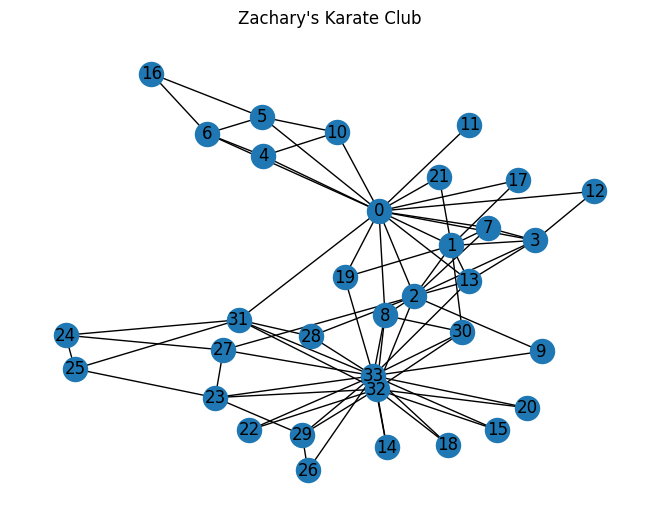

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Read the adjacency list file and skip empty lines and comments
with open('/content/graph-adjlist.py', 'r') as f:
    # Filter out empty lines and lines starting with comments
    lines = [line for line in f if line.strip() and not line.strip().startswith('#')]

# Use the filtered lines to parse the adjacency list
# networkx.parse_adjlist expects an iterable of strings, so pass the list directly
G = nx.parse_adjlist(lines)

# Convert node labels from strings to integers
# Create a mapping from string node labels to integer node labels
mapping = {str(i): i for i in range(len(G.nodes()))}
# Relabel the nodes in the graph using the integer mapping
G = nx.relabel_nodes(G, mapping)


nx.draw(G, with_labels=True) # Added with_labels=True for better visualization
plt.title("Zachary's Karate Club")
plt.show()

In [ ]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

### Clustering the Karate Club
* Before that, we need to preprocess the data by transforming the graph into a matrix since that is the format required for the clusterers.
* The `edge_mat` variable below, we will use for input to the clustering models in the next few sections.



In [ ]:
def graph_to_edge_matrix(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/Incidence_matrix for a good explaination on edge matrices

    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)

    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_mat[node][neighbor] = 1
        edge_mat[node][node] = 1

    return edge_mat

Transform graph to matrix

In [ ]:
## graph to edge matrix
edge_mat = graph_to_edge_matrix(G)
edge_mat

array([[1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

### Clustering Approaches
1. K-Means
  * K-means is considered by many to be the gold standard when it comes to clustering due to its simplicity and performance, so it's the first one we'll try out.
  * When you have no idea at all what algorithm to use, K-means is usually the first choice.
  * K-means works by defining spherical clusters that are separable in a way so that the mean value converges towards the cluster center. Because of this, K-Means may underperform sometimes.
  * To simply construct and train a K-means model, we can use sklearn's package.
  * Before we do, we are going to define the number of clusters we know to be true (two), a list to hold results (labels), and a dictionary containing each algorithm we end up trying.

2. Agglomerative clustering
  * Each node first starts in its own cluster, and then pairs of clusters recursively merge together in a way that minimally increases a given linkage distance.
  * The main advantage of Agglomerative clustering (and hierarchical clustering in general) is that you don’t need to specify the number of clusters. * That of course, comes with a price: performance. But, in sklearn’s implementation, you can specify the number of clusters to assist the algorithm’s performance.

3. Spectral Clustering
  * The Spectral clustering technique applies clustering to a projection of the normalized Laplacian. When it comes to image clustering, Spectral clustering works quite well.


4. Affinity Propagation
  * Affinity propagation is a bit different. Unlike the previous algorithms, this one does not require the number of clusters to be determined before running the algorithm.
  * Affinity propagation performs really well on several computer vision and biology problems, such as clustering pictures of human faces and identifying regulated transcripts, but we'll soon find out it doesn't work well for our dataset.



In [ ]:
k_clusters = 2
results = []
algorithms = {}

algorithms['kmeans'] = cluster.KMeans(n_clusters=k_clusters, n_init=200)

algorithms['agglom'] = cluster.AgglomerativeClustering(n_clusters=k_clusters, linkage="ward")

algorithms['spectral'] = cluster.SpectralClustering(n_clusters=k_clusters, affinity="precomputed", n_init=200)

algorithms['affinity'] = cluster.AffinityPropagation(damping=0.6)

for model in algorithms.values():
    model.fit(edge_mat)
    results.append(list(model.labels_))

In [ ]:
# Check to see how many cluster the affinity propagation algo thinks there is
cluster_centers_indices = algorithms['affinity'].cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print(n_clusters_)

8


In [ ]:
# The resulting clubs
algorithms['affinity'].labels_

array([0, 2, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 2, 4, 4, 1, 2, 4, 3, 4, 2,
       4, 6, 5, 5, 6, 3, 3, 6, 4, 5, 7, 7])

In [ ]:
import matplotlib.colors as colors # Import the colors module from matplotlib

In [ ]:
def draw_communities(G, membership, pos):
    """Draws the nodes to a plot with assigned colors for each individual cluster
    Parameters
    ----------
    G : networkx graph
    membership : list
        A list where the position is the student and the value at the position is the student club membership.
        E.g. `print(membership[8]) --> 1` means that student #8 is a member of club 1.
    pos : positioning as a networkx spring layout
        E.g. nx.spring_layout(G)
    """
    fig, ax = plt.subplots(figsize=(16,9))

    # Convert membership list to a dict where key=club, value=list of students in club
    club_dict = defaultdict(list)
    for student, club in enumerate(membership):
        club_dict[club].append(student)

    # Normalize number of clubs for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(club_dict.keys()))

    for club, members in club_dict.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               node_color=cm.jet(norm(club)),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    plt.title("Zachary's Karate Club - Clusters")
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

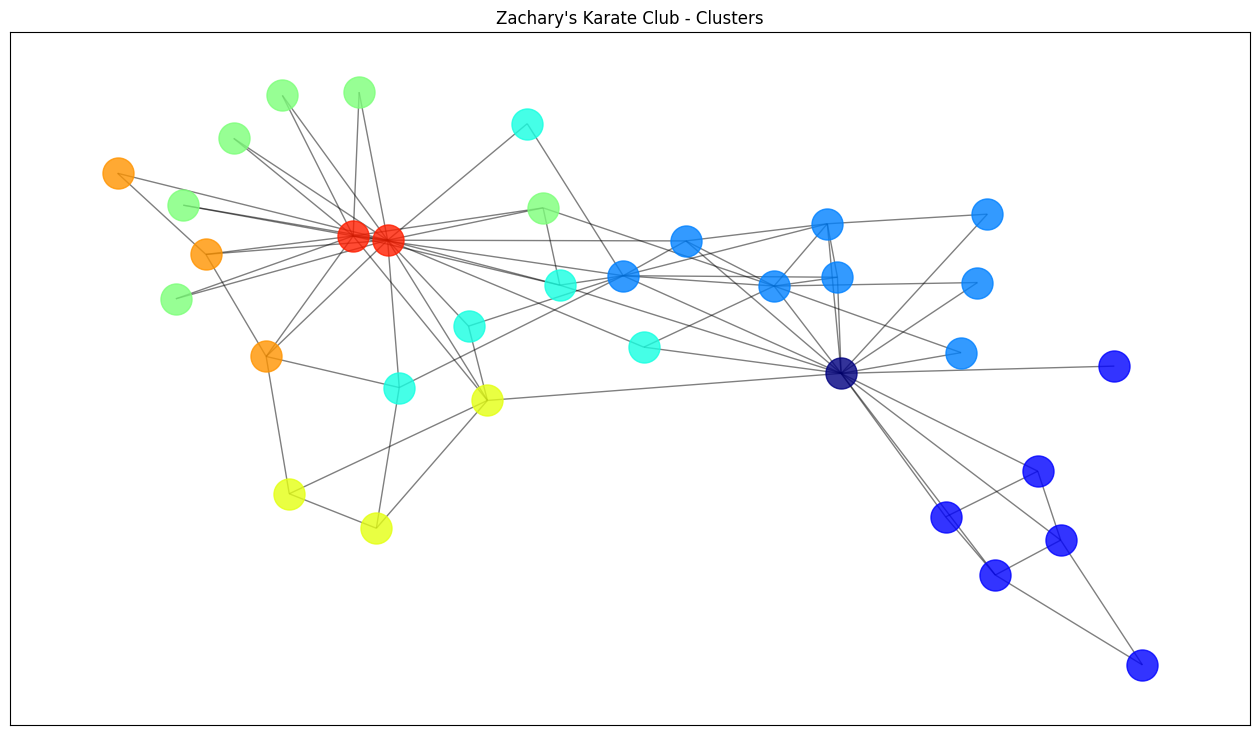

In [ ]:
pos = nx.spring_layout(G)

draw_communities(G, algorithms['affinity'].labels_, pos)

In [ ]:
# Define the true community labels for Zachary's Karate Club
# According to the original data, the club split into two groups.
# Node 0 (the instructor) and node 33 (the administrator) are key figures
# in the split.
y_true = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0,
    11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 0, 17: 0, 18: 1, 19: 0, 20: 1,
    21: 0, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1,
    31: 1, 32: 1, 33: 1
}

## Metrics for Clustering
* Metrics help us determine which clustering algorithm fits our data.
* These are the merics:

1. Normalized Mutual Information (NMI)
  * Mutual Information of two random variables is a measure of the mutual dependence between the two variables.
  * Normalized Mutual Information is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation).
  * In other words, 0 means dissimilar and 1 means
a perfect match.

2. Adjusted Rand Score (ARS)
  * Adjusted Rand Score computes a similarity measure between two clusters.
  * ARS considers all pairs of samples and counts pairs that are assigned in the same or different clusters in the predicted and true clusters.
  * Basically, 0 is the lowest similarity and 1 is the highest.


* To plot our scores, let's first calculate them.
Remember that y_true is still a dictionary where the key is a student and the value is the club they ended up in. We need to get y_true's values first in order to compare them to y_pred.



In [ ]:
nmi_results = []
ars_results = []

y_true_val = list(y_true.values())

# Append the results into lists
for y_pred in results:
    nmi_results.append(normalized_mutual_info_score(y_true_val, y_pred))
    ars_results.append(adjusted_rand_score(y_true_val, y_pred))

<ipython-input-35-5059bac50053>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=nmi_results, palette='Blues', ax=ax1)
<ipython-input-35-5059bac50053>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=ars_results, palette='Reds', ax=ax2)
<ipython-input-35-5059bac50053>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=avg, palette='Greens', ax=ax3)
<ipython-input-35-5059bac50053>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_

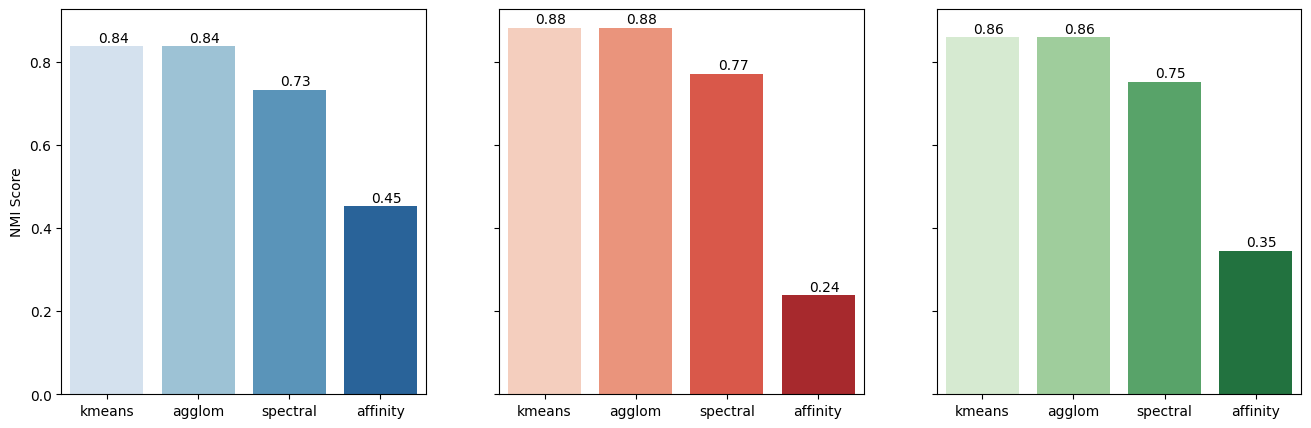

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

# Change len(y) to len(algorithms) or len(results)
x = np.arange(len(algorithms))
avg = [sum(x) / 2 for x in zip(nmi_results, ars_results)]

xlabels = list(algorithms.keys())

# Pass x and y as keyword arguments
sns.barplot(x=x, y=nmi_results, palette='Blues', ax=ax1)
sns.barplot(x=x, y=ars_results, palette='Reds', ax=ax2)
sns.barplot(x=x, y=avg, palette='Greens', ax=ax3)


ax1.set_ylabel('NMI Score')
ax2.set_ylabel('ARS Score')
ax3.set_ylabel('Average Score')

# # Add the xlabels to the chart
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax3.set_xticklabels(xlabels)


# Add the actual value on top of each bar
for i, v in enumerate(zip(nmi_results, ars_results, avg)):
    ax1.text(i - 0.1, v[0] + 0.01, str(round(v[0], 2)))
    ax2.text(i - 0.1, v[1] + 0.01, str(round(v[1], 2)))
    ax3.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))

# Show the final plot
plt.show()

Summary

* We can see that K-means and Agglomerative clustering have the best possible outcome for our dataset.
* That does not mean that Spectral and Agglomerative are low-performing algorithms, just that the did not fit in our particular dataset.



#### Comparing Predicted vs. True

In [ ]:
def draw_true_vs_pred(G, y_true, y_pred, pos, algo_name, ax):

    for student, club in y_true.items():
        if y_pred is not None:
            if club == y_pred[student]:
                node_color = [0, 1, 0]
                node_shape = 'o'
            else:
                node_color = [0, 0, 0]
                node_shape = 'X'

        nx.draw_networkx_nodes(G, pos,
                               nodelist=[student],
                               node_color=node_color,
                               node_size=250,
                               alpha=0.7,
                               ax=ax,
                               node_shape=node_shape)

    # Draw edges and show final plot
    ax.set_title(algo_name)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


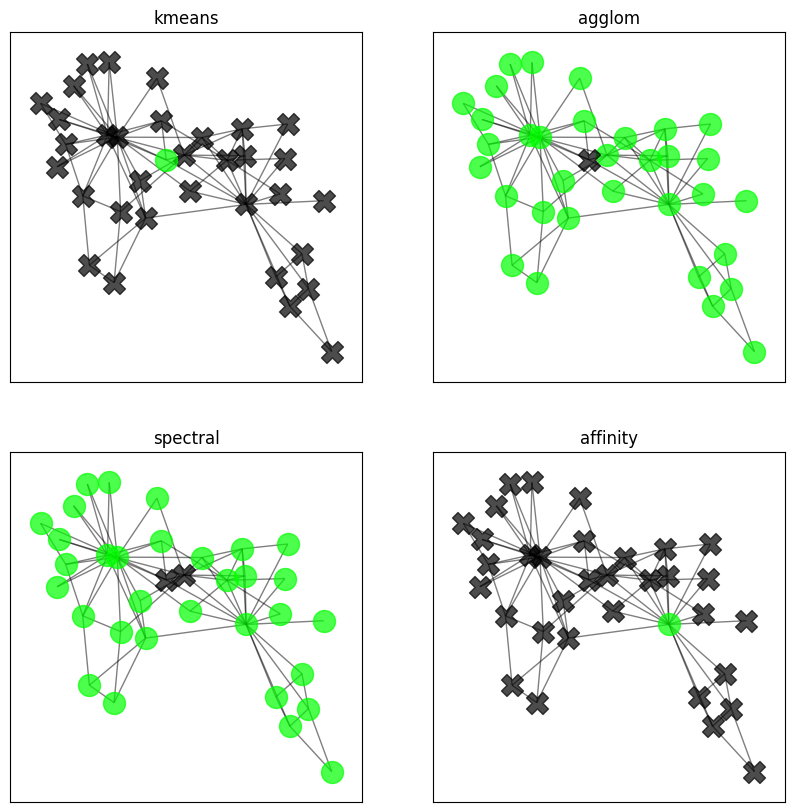

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))

for algo_name, ax in zip(algorithms.keys(), [ax1, ax2, ax3, ax4]):
    draw_true_vs_pred(G, y_true, algorithms[algo_name].labels_, pos, algo_name, ax)

## 2. Graph Generators
* In the NetworkX Python library, a graph generator is a function or algorithm that allows you to easily create graphs with specific predefined structures or properties.
* In essence, graph generators in NetworkX are like tools that provide blueprints for building various types of graphs.

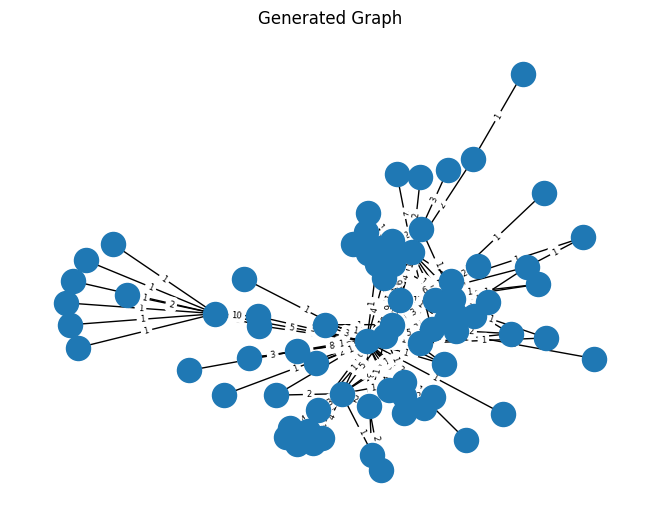

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


generated_graph = nx.les_miserables_graph()

# generated_graph = nx.star_graph(15)

pos = nx.spring_layout(generated_graph, scale=0.5)
nx.draw(generated_graph, pos)

edge_labels = nx.get_edge_attributes(generated_graph, "weight")
nx.draw_networkx_edge_labels(generated_graph, pos, edge_labels=edge_labels, font_size=6)

plt.title("Generated Graph")
plt.show()

## 3. CSV files in NetworkX
* The CSV below is a node with a target edge.

In [ ]:
%%writefile graph.csv

source,target
1,2
1,3
2,3
1,4
2,4
3,4
1,5
1,6
1,7
5,7
6,7
1,8
2,8
3,8
4,8
1,9
3,9
3,10
1,11
5,11
6,11
1,12
1,13
4,13
1,14
2,14
3,14
4,14
6,17
7,17
1,18
2,18
1,20
2,20
1,22
2,22
24,26
25,26
3,28
24,28
25,28
3,29
24,30
27,30
2,31
9,31
1,32
25,32
26,32
29,32
3,33
9,33
15,33
16,33
19,33
21,33
23,33
24,33
30,33
31,33
32,33
9,34
10,34
14,34
15,34
16,34
19,34
20,34
21,34
23,34
24,34
27,34
28,34
29,34
30,34
31,34
32,34
33,34

Writing graph.csv


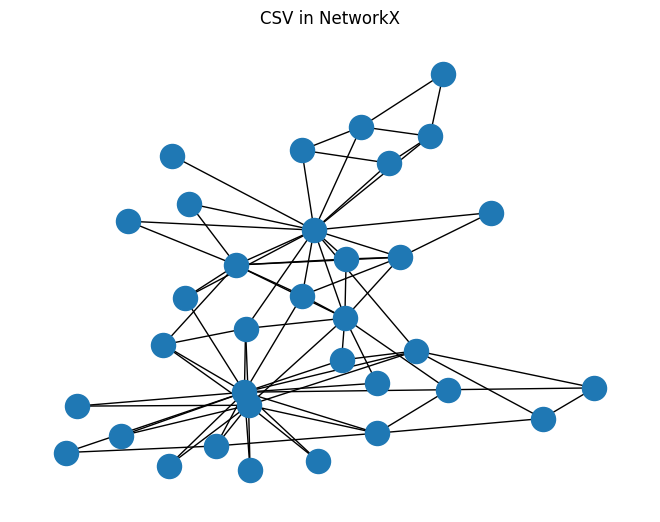

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


use_pandas = True ## False if not use pandas
graph_type = nx.Graph()


if use_pandas:
    df = pd.read_csv("/content/graph.csv")
    G = nx.from_pandas_edgelist(df, create_using=graph_type)
else:
    Data = open("/content/graph.csv", "r")
    next(Data, None)
    G = nx.parse_edgelist(Data, delimiter=",", create_using=graph_type, nodetype=int)

nx.draw(G)
plt.title("CSV in NetworkX")
plt.show()


## 4. GML files in NetworkX
* GML files are similar to NetworkX.
* A GML (Geography Markup Language) file is a text-based, XML format used for representing and exchanging geographic data.

In [45]:
%%writefile power.gml
graph
[
  directed 0
  node
  [
    id 0
  ]
  node
  [
    id 1
  ]
  node
  [
    id 2
  ]
  node
  [
    id 3
  ]
  node
  [
    id 4
  ]
  node
  [
    id 5
  ]
  node
  [
    id 6
  ]
  node
  [
    id 7
  ]
  node
  [
    id 8
  ]
  node
  [
    id 9
  ]
  node
  [
    id 10
  ]
  node
  [
    id 11
  ]
  node
  [
    id 12
  ]
  node
  [
    id 13
  ]
  node
  [
    id 14
  ]
  node
  [
    id 15
  ]
  node
  [
    id 16
  ]
  node
  [
    id 17
  ]
  node
  [
    id 18
  ]
  node
  [
    id 19
  ]
  node
  [
    id 20
  ]
  node
  [
    id 21
  ]
  node
  [
    id 22
  ]
  node
  [
    id 23
  ]
  node
  [
    id 24
  ]
  node
  [
    id 25
  ]
  node
  [
    id 26
  ]
  node
  [
    id 27
  ]
  node
  [
    id 28
  ]
  node
  [
    id 29
  ]
  node
  [
    id 30
  ]
  node
  [
    id 31
  ]
  node
  [
    id 32
  ]
  node
  [
    id 33
  ]
  node
  [
    id 34
  ]
  node
  [
    id 35
  ]
  node
  [
    id 36
  ]
  node
  [
    id 37
  ]
  node
  [
    id 38
  ]
  node
  [
    id 39
  ]
  node
  [
    id 40
  ]
  node
  [
    id 41
  ]
  node
  [
    id 42
  ]
  node
  [
    id 43
  ]
  node
  [
    id 44
  ]
  node
  [
    id 45
  ]
  node
  [
    id 46
  ]
  node
  [
    id 47
  ]
  node
  [
    id 48
  ]
  node
  [
    id 49
  ]
  node
  [
    id 50
  ]
  node
  [
    id 51
  ]
  node
  [
    id 52
  ]
  node
  [
    id 53
  ]
  node
  [
    id 54
  ]
  node
  [
    id 55
  ]
  node
  [
    id 56
  ]
  node
  [
    id 57
  ]
  node
  [
    id 58
  ]
  node
  [
    id 59
  ]
  node
  [
    id 60
  ]
  node
  [
    id 61
  ]
  node
  [
    id 62
  ]
  node
  [
    id 63
  ]
  node
  [
    id 64
  ]
  node
  [
    id 65
  ]
  node
  [
    id 66
  ]
  node
  [
    id 67
  ]
  node
  [
    id 68
  ]
  node
  [
    id 69
  ]
  node
  [
    id 70
  ]
  node
  [
    id 71
  ]
  node
  [
    id 72
  ]
  node
  [
    id 73
  ]
  node
  [
    id 74
  ]
  node
  [
    id 75
  ]
  node
  [
    id 76
  ]
  node
  [
    id 77
  ]
  node
  [
    id 78
  ]
  node
  [
    id 79
  ]
  node
  [
    id 80
  ]
  node
  [
    id 81
  ]
  node
  [
    id 82
  ]
  node
  [
    id 83
  ]
  node
  [
    id 84
  ]
  node
  [
    id 85
  ]
  node
  [
    id 86
  ]
  node
  [
    id 87
  ]
  node
  [
    id 88
  ]
  node
  [
    id 89
  ]
  node
  [
    id 90
  ]
  node
  [
    id 91
  ]
  node
  [
    id 92
  ]
  node
  [
    id 93
  ]
  node
  [
    id 94
  ]
  node
  [
    id 95
  ]
  node
  [
    id 96
  ]
  node
  [
    id 97
  ]
  node
  [
    id 98
  ]
  node
  [
    id 99
  ]
  node
  [
    id 100
  ]
  node
  [
    id 101
  ]
  node
  [
    id 102
  ]
  node
  [
    id 103
  ]
  node
  [
    id 104
  ]
  node
  [
    id 105
  ]
  node
  [
    id 106
  ]
  node
  [
    id 107
  ]
  node
  [
    id 108
  ]
  node
  [
    id 109
  ]
  node
  [
    id 110
  ]
  node
  [
    id 111
  ]
  node
  [
    id 112
  ]
  node
  [
    id 113
  ]
  node
  [
    id 114
  ]
  node
  [
    id 115
  ]
  node
  [
    id 116
  ]
  node
  [
    id 117
  ]
  node
  [
    id 118
  ]
  node
  [
    id 119
  ]
  node
  [
    id 120
  ]
  node
  [
    id 121
  ]
  node
  [
    id 122
  ]
  node
  [
    id 123
  ]
  node
  [
    id 124
  ]
  node
  [
    id 125
  ]
  node
  [
    id 126
  ]
  node
  [
    id 127
  ]
  node
  [
    id 128
  ]
  node
  [
    id 129
  ]
  node
  [
    id 130
  ]
  node
  [
    id 131
  ]
  node
  [
    id 132
  ]
  node
  [
    id 133
  ]
  node
  [
    id 134
  ]
  node
  [
    id 135
  ]
  node
  [
    id 136
  ]
  node
  [
    id 137
  ]
  node
  [
    id 138
  ]
  node
  [
    id 139
  ]
  node
  [
    id 140
  ]
  node
  [
    id 141
  ]
  node
  [
    id 142
  ]
  node
  [
    id 143
  ]
  node
  [
    id 144
  ]
  node
  [
    id 145
  ]
  node
  [
    id 146
  ]
  node
  [
    id 147
  ]
  node
  [
    id 148
  ]
  node
  [
    id 149
  ]
  node
  [
    id 150
  ]
  node
  [
    id 151
  ]
  node
  [
    id 152
  ]
  node
  [
    id 153
  ]
  node
  [
    id 154
  ]
  node
  [
    id 155
  ]
  node
  [
    id 156
  ]
  node
  [
    id 157
  ]
  node
  [
    id 158
  ]
  node
  [
    id 159
  ]
  node
  [
    id 160
  ]
  node
  [
    id 161
  ]
  node
  [
    id 162
  ]
  node
  [
    id 163
  ]
  node
  [
    id 164
  ]
  node
  [
    id 165
  ]
  node
  [
    id 166
  ]
  node
  [
    id 167
  ]
  node
  [
    id 168
  ]
  node
  [
    id 169
  ]
  node
  [
    id 170
  ]
  node
  [
    id 171
  ]
  node
  [
    id 172
  ]
  node
  [
    id 173
  ]
  node
  [
    id 174
  ]
  node
  [
    id 175
  ]
  node
  [
    id 176
  ]
  node
  [
    id 177
  ]
  node
  [
    id 178
  ]
  node
  [
    id 179
  ]
  node
  [
    id 180
  ]
  node
  [
    id 181
  ]
  node
  [
    id 182
  ]
  node
  [
    id 183
  ]
  node
  [
    id 184
  ]
  node
  [
    id 185
  ]
  node
  [
    id 186
  ]
  node
  [
    id 187
  ]
  node
  [
    id 188
  ]
  node
  [
    id 189
  ]
  node
  [
    id 190
  ]
  node
  [
    id 191
  ]
  node
  [
    id 192
  ]
  node
  [
    id 193
  ]
  node
  [
    id 194
  ]
  node
  [
    id 195
  ]
  node
  [
    id 196
  ]
  node
  [
    id 197
  ]
  node
  [
    id 198
  ]
  node
  [
    id 199
  ]
  node
  [
    id 200
  ]
  node
  [
    id 201
  ]
  node
  [
    id 202
  ]
  node
  [
    id 203
  ]
  node
  [
    id 204
  ]
  node
  [
    id 205
  ]
  node
  [
    id 206
  ]
  node
  [
    id 207
  ]
  node
  [
    id 208
  ]
  node
  [
    id 209
  ]
  node
  [
    id 210
  ]
  node
  [
    id 211
  ]
  node
  [
    id 212
  ]
  node
  [
    id 213
  ]
  node
  [
    id 214
  ]
  node
  [
    id 215
  ]
  node
  [
    id 216
  ]
  node
  [
    id 217
  ]
  node
  [
    id 218
  ]
  node
  [
    id 219
  ]
  node
  [
    id 220
  ]
  node
  [
    id 221
  ]
  node
  [
    id 222
  ]
  node
  [
    id 223
  ]
  node
  [
    id 224
  ]
  node
  [
    id 225
  ]
  node
  [
    id 226
  ]
  node
  [
    id 227
  ]
  node
  [
    id 228
  ]
  node
  [
    id 229
  ]
  node
  [
    id 230
  ]
  node
  [
    id 231
  ]
  node
  [
    id 232
  ]
  node
  [
    id 233
  ]
  node
  [
    id 234
  ]
  node
  [
    id 235
  ]
  node
  [
    id 236
  ]
  node
  [
    id 237
  ]
  node
  [
    id 238
  ]
  node
  [
    id 239
  ]
  node
  [
    id 240
  ]
  node
  [
    id 241
  ]
  node
  [
    id 242
  ]
  node
  [
    id 243
  ]
  node
  [
    id 244
  ]
  node
  [
    id 245
  ]
  node
  [
    id 246
  ]
  node
  [
    id 247
  ]
  node
  [
    id 248
  ]
  node
  [
    id 249
  ]
  node
  [
    id 250
  ]
  node
  [
    id 251
  ]
  node
  [
    id 252
  ]
  node
  [
    id 253
  ]
  node
  [
    id 254
  ]
  node
  [
    id 255
  ]
  node
  [
    id 256
  ]
  node
  [
    id 257
  ]
  node
  [
    id 258
  ]
  node
  [
    id 259
  ]
  node
  [
    id 260
  ]
  node
  [
    id 261
  ]
  node
  [
    id 262
  ]
  node
  [
    id 263
  ]
  node
  [
    id 264
  ]
  node
  [
    id 265
  ]
  node
  [
    id 266
  ]
  node
  [
    id 267
  ]
  node
  [
    id 268
  ]
  node
  [
    id 269
  ]
  node
  [
    id 270
  ]
  node
  [
    id 271
  ]
  node
  [
    id 272
  ]
  node
  [
    id 273
  ]
  node
  [
    id 274
  ]
  node
  [
    id 275
  ]
  node
  [
    id 276
  ]
  node
  [
    id 277
  ]
  node
  [
    id 278
  ]
  node
  [
    id 279
  ]
  node
  [
    id 280
  ]
  node
  [
    id 281
  ]
  node
  [
    id 282
  ]
  node
  [
    id 283
  ]
  node
  [
    id 284
  ]
  node
  [
    id 285
  ]
  node
  [
    id 286
  ]
  node
  [
    id 287
  ]
  node
  [
    id 288
  ]
  node
  [
    id 289
  ]
  node
  [
    id 290
  ]
  node
  [
    id 291
  ]
  node
  [
    id 292
  ]
  node
  [
    id 293
  ]
  node
  [
    id 294
  ]
  node
  [
    id 295
  ]
  node
  [
    id 296
  ]
  node
  [
    id 297
  ]
  node
  [
    id 298
  ]
  node
  [
    id 299
  ]
  node
  [
    id 300
  ]
  node
  [
    id 301
  ]
  node
  [
    id 302
  ]
  node
  [
    id 303
  ]
  node
  [
    id 304
  ]
  node
  [
    id 305
  ]
  node
  [
    id 306
  ]
  node
  [
    id 307
  ]
  node
  [
    id 308
  ]
  node
  [
    id 309
  ]
  node
  [
    id 310
  ]
  node
  [
    id 311
  ]
  node
  [
    id 312
  ]
  node
  [
    id 313
  ]
  node
  [
    id 314
  ]
  node
  [
    id 315
  ]
  node
  [
    id 316
  ]
  node
  [
    id 317
  ]
  node
  [
    id 318
  ]
  node
  [
    id 319
  ]
  node
  [
    id 320
  ]
  node
  [
    id 321
  ]
  node
  [
    id 322
  ]
  node
  [
    id 323
  ]
  node
  [
    id 324
  ]
  node
  [
    id 325
  ]
  node
  [
    id 326
  ]
  node
  [
    id 327
  ]
  node
  [
    id 328
  ]
  node
  [
    id 329
  ]
  node
  [
    id 330
  ]
  node
  [
    id 331
  ]
  node
  [
    id 332
  ]
  node
  [
    id 333
  ]
  node
  [
    id 334
  ]
  node
  [
    id 335
  ]
  node
  [
    id 336
  ]
  node
  [
    id 337
  ]
  node
  [
    id 338
  ]
  node
  [
    id 339
  ]
  node
  [
    id 340
  ]
  node
  [
    id 341
  ]
  node
  [
    id 342
  ]
  node
  [
    id 343
  ]
  node
  [
    id 344
  ]
  node
  [
    id 345
  ]
  node
  [
    id 346
  ]
  node
  [
    id 347
  ]
  node
  [
    id 348
  ]
  node
  [
    id 349
  ]
  node
  [
    id 350
  ]
  node
  [
    id 351
  ]
  node
  [
    id 352
  ]
  node
  [
    id 353
  ]
  node
  [
    id 354
  ]
  node
  [
    id 355
  ]
  node
  [
    id 356
  ]
  node
  [
    id 357
  ]
  node
  [
    id 358
  ]
  node
  [
    id 359
  ]
  node
  [
    id 360
  ]
  node
  [
    id 361
  ]
  node
  [
    id 362
  ]
  node
  [
    id 363
  ]
  node
  [
    id 364
  ]
  node
  [
    id 365
  ]
  node
  [
    id 366
  ]
  node
  [
    id 367
  ]
  node
  [
    id 368
  ]
  node
  [
    id 369
  ]
  node
  [
    id 370
  ]
  node
  [
    id 371
  ]
  node
  [
    id 372
  ]
  node
  [
    id 373
  ]
  node
  [
    id 374
  ]
  node
  [
    id 375
  ]
  node
  [
    id 376
  ]
  node
  [
    id 377
  ]
  node
  [
    id 378
  ]
  node
  [
    id 379
  ]
  node
  [
    id 380
  ]
  node
  [
    id 381
  ]
  node
  [
    id 382
  ]
  node
  [
    id 383
  ]
  node
  [
    id 384
  ]
  node
  [
    id 385
  ]
  node
  [
    id 386
  ]
  node
  [
    id 387
  ]
  node
  [
    id 388
  ]
  node
  [
    id 389
  ]
  node
  [
    id 390
  ]
  node
  [
    id 391
  ]
  node
  [
    id 392
  ]
  node
  [
    id 393
  ]
  node
  [
    id 394
  ]
  node
  [
    id 395
  ]
  node
  [
    id 396
  ]
  node
  [
    id 397
  ]
  node
  [
    id 398
  ]
  node
  [
    id 399
  ]
  node
  [
    id 400
  ]
  node
  [
    id 401
  ]
  node
  [
    id 402
  ]
  node
  [
    id 403
  ]
  node
  [
    id 404
  ]
  node
  [
    id 405
  ]
  node
  [
    id 406
  ]
  node
  [
    id 407
  ]
  node
  [
    id 408
  ]
  node
  [
    id 409
  ]
  node
  [
    id 410
  ]
  node
  [
    id 411
  ]
  node
  [
    id 412
  ]
  node
  [
    id 413
  ]
  node
  [
    id 414
  ]
  node
  [
    id 415
  ]
  node
  [
    id 416
  ]
  node
  [
    id 417
  ]
  node
  [
    id 418
  ]
  node
  [
    id 419
  ]
  node
  [
    id 420
  ]
  node
  [
    id 421
  ]
  node
  [
    id 422
  ]
  node
  [
    id 423
  ]
  node
  [
    id 424
  ]
  node
  [
    id 425
  ]
  node
  [
    id 426
  ]
  node
  [
    id 427
  ]
  node
  [
    id 428
  ]
  node
  [
    id 429
  ]
  node
  [
    id 430
  ]
  node
  [
    id 431
  ]
  node
  [
    id 432
  ]
  node
  [
    id 433
  ]
  node
  [
    id 434
  ]
  node
  [
    id 435
  ]
  node
  [
    id 436
  ]
  node
  [
    id 437
  ]
  node
  [
    id 438
  ]
  node
  [
    id 439
  ]
  node
  [
    id 440
  ]
  node
  [
    id 441
  ]
  node
  [
    id 442
  ]
  node
  [
    id 443
  ]
  node
  [
    id 444
  ]
  node
  [
    id 445
  ]
  node
  [
    id 446
  ]
  node
  [
    id 447
  ]
  node
  [
    id 448
  ]
  node
  [
    id 449
  ]
  node
  [
    id 450
  ]
  node
  [
    id 451
  ]
  node
  [
    id 452
  ]
  node
  [
    id 453
  ]
  node
  [
    id 454
  ]
  node
  [
    id 455
  ]
  node
  [
    id 456
  ]
  node
  [
    id 457
  ]
  node
  [
    id 458
  ]
  node
  [
    id 459
  ]
  node
  [
    id 460
  ]
  node
  [
    id 461
  ]
  node
  [
    id 462
  ]
  node
  [
    id 463
  ]
  node
  [
    id 464
  ]
  node
  [
    id 465
  ]
  node
  [
    id 466
  ]
  node
  [
    id 467
  ]
  node
  [
    id 468
  ]
  node
  [
    id 469
  ]
  node
  [
    id 470
  ]
  node
  [
    id 471
  ]
  node
  [
    id 472
  ]
  node
  [
    id 473
  ]
  node
  [
    id 474
  ]
  node
  [
    id 475
  ]
  node
  [
    id 476
  ]
  node
  [
    id 477
  ]
  node
  [
    id 478
  ]
  node
  [
    id 479
  ]
  node
  [
    id 480
  ]
  node
  [
    id 481
  ]
  node
  [
    id 482
  ]
  node
  [
    id 483
  ]
  node
  [
    id 484
  ]
  node
  [
    id 485
  ]
  node
  [
    id 486
  ]
  node
  [
    id 487
  ]
  node
  [
    id 488
  ]
  node
  [
    id 489
  ]
  node
  [
    id 490
  ]
  node
  [
    id 491
  ]
  node
  [
    id 492
  ]
  node
  [
    id 493
  ]
  node
  [
    id 494
  ]
  node
  [
    id 495
  ]
  node
  [
    id 496
  ]
  node
  [
    id 497
  ]
  node
  [
    id 498
  ]
  node
  [
    id 499
  ]
  node
  [
    id 500
  ]
  node
  [
    id 501
  ]
  node
  [
    id 502
  ]
  node
  [
    id 503
  ]
  node
  [
    id 504
  ]
  node
  [
    id 505
  ]
  node
  [
    id 506
  ]
  node
  [
    id 507
  ]
  node
  [
    id 508
  ]
  node
  [
    id 509
  ]
  node
  [
    id 510
  ]
  node
  [
    id 511
  ]
  node
  [
    id 512
  ]
  node
  [
    id 513
  ]
  node
  [
    id 514
  ]
  node
  [
    id 515
  ]
  node
  [
    id 516
  ]
  node
  [
    id 517
  ]
  node
  [
    id 518
  ]
  node
  [
    id 519
  ]
  node
  [
    id 520
  ]
  node
  [
    id 521
  ]
  node
  [
    id 522
  ]
  node
  [
    id 523
  ]
  node
  [
    id 524
  ]
  node
  [
    id 525
  ]
  node
  [
    id 526
  ]
  node
  [
    id 527
  ]
  node
  [
    id 528
  ]
  node
  [
    id 529
  ]
  node
  [
    id 530
  ]
  node
  [
    id 531
  ]
  node
  [
    id 532
  ]
  node
  [
    id 533
  ]
  node
  [
    id 534
  ]
  node
  [
    id 535
  ]
  node
  [
    id 536
  ]
  node
  [
    id 537
  ]
  node
  [
    id 538
  ]
  node
  [
    id 539
  ]
  node
  [
    id 540
  ]
  node
  [
    id 541
  ]
  node
  [
    id 542
  ]
  node
  [
    id 543
  ]
  node
  [
    id 544
  ]
  node
  [
    id 545
  ]
  node
  [
    id 546
  ]
  node
  [
    id 547
  ]
  node
  [
    id 548
  ]
  node
  [
    id 549
  ]
  node
  [
    id 550
  ]
  node
  [
    id 551
  ]
  node
  [
    id 552
  ]
  node
  [
    id 553
  ]
  node
  [
    id 554
  ]
  node
  [
    id 555
  ]
  node
  [
    id 556
  ]
  node
  [
    id 557
  ]
  node
  [
    id 558
  ]
  node
  [
    id 559
  ]
  node
  [
    id 560
  ]
  node
  [
    id 561
  ]
  node
  [
    id 562
  ]
  node
  [
    id 563
  ]
  node
  [
    id 564
  ]
  node
  [
    id 565
  ]
  node
  [
    id 566
  ]
  node
  [
    id 567
  ]
  node
  [
    id 568
  ]
  node
  [
    id 569
  ]
  node
  [
    id 570
  ]
  node
  [
    id 571
  ]
  node
  [
    id 572
  ]
  node
  [
    id 573
  ]
  node
  [
    id 574
  ]
  node
  [
    id 575
  ]
  node
  [
    id 576
  ]
  node
  [
    id 577
  ]
  node
  [
    id 578
  ]
  node
  [
    id 579
  ]
  node
  [
    id 580
  ]
  node
  [
    id 581
  ]
  node
  [
    id 582
  ]
  node
  [
    id 583
  ]
  node
  [
    id 584
  ]
  node
  [
    id 585
  ]
  node
  [
    id 586
  ]
  node
  [
    id 587
  ]
  node
  [
    id 588
  ]
  node
  [
    id 589
  ]
  node
  [
    id 590
  ]
  node
  [
    id 591
  ]
  node
  [
    id 592
  ]
  node
  [
    id 593
  ]
  node
  [
    id 594
  ]
  node
  [
    id 595
  ]
  node
  [
    id 596
  ]
  node
  [
    id 597
  ]
  node
  [
    id 598
  ]
  node
  [
    id 599
  ]
  node
  [
    id 600
  ]
  node
  [
    id 601
  ]
  node
  [
    id 602
  ]
  node
  [
    id 603
  ]
  node
  [
    id 604
  ]
  node
  [
    id 605
  ]
  node
  [
    id 606
  ]
  node
  [
    id 607
  ]
  node
  [
    id 608
  ]
  node
  [
    id 609
  ]
  node
  [
    id 610
  ]
  node
  [
    id 611
  ]
  node
  [
    id 612
  ]
  node
  [
    id 613
  ]
  node
  [
    id 614
  ]
  node
  [
    id 615
  ]
  node
  [
    id 616
  ]
  node
  [
    id 617
  ]
  node
  [
    id 618
  ]
  node
  [
    id 619
  ]
  node
  [
    id 620
  ]
  node
  [
    id 621
  ]
  node
  [
    id 622
  ]
  node
  [
    id 623
  ]
  node
  [
    id 624
  ]
  node
  [
    id 625
  ]
  node
  [
    id 626
  ]
  node
  [
    id 627
  ]
  node
  [
    id 628
  ]
  node
  [
    id 629
  ]
  node
  [
    id 630
  ]
  node
  [
    id 631
  ]
  node
  [
    id 632
  ]
  node
  [
    id 633
  ]
  node
  [
    id 634
  ]
  node
  [
    id 635
  ]
  node
  [
    id 636
  ]
  node
  [
    id 637
  ]
  node
  [
    id 638
  ]
  node
  [
    id 639
  ]
  node
  [
    id 640
  ]
  node
  [
    id 641
  ]
  node
  [
    id 642
  ]
  node
  [
    id 643
  ]
  node
  [
    id 644
  ]
  node
  [
    id 645
  ]
  node
  [
    id 646
  ]
  node
  [
    id 647
  ]
  node
  [
    id 648
  ]
  node
  [
    id 649
  ]
  node
  [
    id 650
  ]
  node
  [
    id 651
  ]
  node
  [
    id 652
  ]
  node
  [
    id 653
  ]
  node
  [
    id 654
  ]
  node
  [
    id 655
  ]
  node
  [
    id 656
  ]
  node
  [
    id 657
  ]
  node
  [
    id 658
  ]
  node
  [
    id 659
  ]
  node
  [
    id 660
  ]
  node
  [
    id 661
  ]
  node
  [
    id 662
  ]
  node
  [
    id 663
  ]
  node
  [
    id 664
  ]
  node
  [
    id 665
  ]
  node
  [
    id 666
  ]
  node
  [
    id 667
  ]
  node
  [
    id 668
  ]
  node
  [
    id 669
  ]
  node
  [
    id 670
  ]
  node
  [
    id 671
  ]
  node
  [
    id 672
  ]
  node
  [
    id 673
  ]
  node
  [
    id 674
  ]
  node
  [
    id 675
  ]
  node
  [
    id 676
  ]
  node
  [
    id 677
  ]
  node
  [
    id 678
  ]
  node
  [
    id 679
  ]
  node
  [
    id 680
  ]
  node
  [
    id 681
  ]
  node
  [
    id 682
  ]
  node
  [
    id 683
  ]
  node
  [
    id 684
  ]
  node
  [
    id 685
  ]
  node
  [
    id 686
  ]
  node
  [
    id 687
  ]
  node
  [
    id 688
  ]
  node
  [
    id 689
  ]
  node
  [
    id 690
  ]
  node
  [
    id 691
  ]
  node
  [
    id 692
  ]
  node
  [
    id 693
  ]
  node
  [
    id 694
  ]
  node
  [
    id 695
  ]
  node
  [
    id 696
  ]
  node
  [
    id 697
  ]
  node
  [
    id 698
  ]
  node
  [
    id 699
  ]
  node
  [
    id 700
  ]
  node
  [
    id 701
  ]
  node
  [
    id 702
  ]
  node
  [
    id 703
  ]
  node
  [
    id 704
  ]
  node
  [
    id 705
  ]
  node
  [
    id 706
  ]
  node
  [
    id 707
  ]
  node
  [
    id 708
  ]
  node
  [
    id 709
  ]
  node
  [
    id 710
  ]
  node
  [
    id 711
  ]
  node
  [
    id 712
  ]
  node
  [
    id 713
  ]
  node
  [
    id 714
  ]
  node
  [
    id 715
  ]
  node
  [
    id 716
  ]
  node
  [
    id 717
  ]
  node
  [
    id 718
  ]
  node
  [
    id 719
  ]
  node
  [
    id 720
  ]
  node
  [
    id 721
  ]
  node
  [
    id 722
  ]
  node
  [
    id 723
  ]
  node
  [
    id 724
  ]
  node
  [
    id 725
  ]
  node
  [
    id 726
  ]
  node
  [
    id 727
  ]
  node
  [
    id 728
  ]
  node
  [
    id 729
  ]
  node
  [
    id 730
  ]
  node
  [
    id 731
  ]
  node
  [
    id 732
  ]
  node
  [
    id 733
  ]
  node
  [
    id 734
  ]
  node
  [
    id 735
  ]
  node
  [
    id 736
  ]
  node
  [
    id 737
  ]
  node
  [
    id 738
  ]
  node
  [
    id 739
  ]
  node
  [
    id 740
  ]
  node
  [
    id 741
  ]
  node
  [
    id 742
  ]
  node
  [
    id 743
  ]
  node
  [
    id 744
  ]
  node
  [
    id 745
  ]
  node
  [
    id 746
  ]
  node
  [
    id 747
  ]
  node
  [
    id 748
  ]
  node
  [
    id 749
  ]
  node
  [
    id 750
  ]
  node
  [
    id 751
  ]
  node
  [
    id 752
  ]
  node
  [
    id 753
  ]
  node
  [
    id 754
  ]
  node
  [
    id 755
  ]
  node
  [
    id 756
  ]
  node
  [
    id 757
  ]
  node
  [
    id 758
  ]
  node
  [
    id 759
  ]
  node
  [
    id 760
  ]
  node
  [
    id 761
  ]
  node
  [
    id 762
  ]
  node
  [
    id 763
  ]
  node
  [
    id 764
  ]
  node
  [
    id 765
  ]
  node
  [
    id 766
  ]
  node
  [
    id 767
  ]
  node
  [
    id 768
  ]
  node
  [
    id 769
  ]
  node
  [
    id 770
  ]
  node
  [
    id 771
  ]
  node
  [
    id 772
  ]
  node
  [
    id 773
  ]
  node
  [
    id 774
  ]
  node
  [
    id 775
  ]
  node
  [
    id 776
  ]
  node
  [
    id 777
  ]
  node
  [
    id 778
  ]
  node
  [
    id 779
  ]
  node
  [
    id 780
  ]
  node
  [
    id 781
  ]
  node
  [
    id 782
  ]
  node
  [
    id 783
  ]
  node
  [
    id 784
  ]
  node
  [
    id 785
  ]
  node
  [
    id 786
  ]
  node
  [
    id 787
  ]
  node
  [
    id 788
  ]
  node
  [
    id 789
  ]
  node
  [
    id 790
  ]
  node
  [
    id 791
  ]
  node
  [
    id 792
  ]
  node
  [
    id 793
  ]
  node
  [
    id 794
  ]
  node
  [
    id 795
  ]
  node
  [
    id 796
  ]
  node
  [
    id 797
  ]
  node
  [
    id 798
  ]
  node
  [
    id 799
  ]
  node
  [
    id 800
  ]
  node
  [
    id 801
  ]
  node
  [
    id 802
  ]
  node
  [
    id 803
  ]
  node
  [
    id 804
  ]
  node
  [
    id 805
  ]
  node
  [
    id 806
  ]
  node
  [
    id 807
  ]
  node
  [
    id 808
  ]
  node
  [
    id 809
  ]
  node
  [
    id 810
  ]
  node
  [
    id 811
  ]
  node
  [
    id 812
  ]
  node
  [
    id 813
  ]
  node
  [
    id 814
  ]
  node
  [
    id 815
  ]
  node
  [
    id 816
  ]
  node
  [
    id 817
  ]
  node
  [
    id 818
  ]
  node
  [
    id 819
  ]
  node
  [
    id 820
  ]
  node
  [
    id 821
  ]
  node
  [
    id 822
  ]
  node
  [
    id 823
  ]
  node
  [
    id 824
  ]
  node
  [
    id 825
  ]
  node
  [
    id 826
  ]
  node
  [
    id 827
  ]
  node
  [
    id 828
  ]
  node
  [
    id 829
  ]
  node
  [
    id 830
  ]
  node
  [
    id 831
  ]
  node
  [
    id 832
  ]
  node
  [
    id 833
  ]
  node
  [
    id 834
  ]
  node
  [
    id 835
  ]
  node
  [
    id 836
  ]
  node
  [
    id 837
  ]
  node
  [
    id 838
  ]
  node
  [
    id 839
  ]
  node
  [
    id 840
  ]
  node
  [
    id 841
  ]
  node
  [
    id 842
  ]
  node
  [
    id 843
  ]
  node
  [
    id 844
  ]
  node
  [
    id 845
  ]
  node
  [
    id 846
  ]
  node
  [
    id 847
  ]
  node
  [
    id 848
  ]
  node
  [
    id 849
  ]
  node
  [
    id 850
  ]
  node
  [
    id 851
  ]
  node
  [
    id 852
  ]
  node
  [
    id 853
  ]
  node
  [
    id 854
  ]
  node
  [
    id 855
  ]
  node
  [
    id 856
  ]
  node
  [
    id 857
  ]
  node
  [
    id 858
  ]
  node
  [
    id 859
  ]
  node
  [
    id 860
  ]
  node
  [
    id 861
  ]
  node
  [
    id 862
  ]
  node
  [
    id 863
  ]
  node
  [
    id 864
  ]
  node
  [
    id 865
  ]
  node
  [
    id 866
  ]
  node
  [
    id 867
  ]
  node
  [
    id 868
  ]
  node
  [
    id 869
  ]
  node
  [
    id 870
  ]
  node
  [
    id 871
  ]
  node
  [
    id 872
  ]
  node
  [
    id 873
  ]
  node
  [
    id 874
  ]
  node
  [
    id 875
  ]
  node
  [
    id 876
  ]
  node
  [
    id 877
  ]
  node
  [
    id 878
  ]
  node
  [
    id 879
  ]
  node
  [
    id 880
  ]
  node
  [
    id 881
  ]
  node
  [
    id 882
  ]
  node
  [
    id 883
  ]
  node
  [
    id 884
  ]
  node
  [
    id 885
  ]
  node
  [
    id 886
  ]
  node
  [
    id 887
  ]
  node
  [
    id 888
  ]
  node
  [
    id 889
  ]
  node
  [
    id 890
  ]
  node
  [
    id 891
  ]
  node
  [
    id 892
  ]
  node
  [
    id 893
  ]
  node
  [
    id 894
  ]
  node
  [
    id 895
  ]
  node
  [
    id 896
  ]
  node
  [
    id 897
  ]
  node
  [
    id 898
  ]
  node
  [
    id 899
  ]
  node
  [
    id 900
  ]
  node
  [
    id 901
  ]
  node
  [
    id 902
  ]
  node
  [
    id 903
  ]
  node
  [
    id 904
  ]
  node
  [
    id 905
  ]
  node
  [
    id 906
  ]
  node
  [
    id 907
  ]
  node
  [
    id 908
  ]
  node
  [
    id 909
  ]
  node
  [
    id 910
  ]
  node
  [
    id 911
  ]
  node
  [
    id 912
  ]
  node
  [
    id 913
  ]
  node
  [
    id 914
  ]
  node
  [
    id 915
  ]
  node
  [
    id 916
  ]
  node
  [
    id 917
  ]
  node
  [
    id 918
  ]
  node
  [
    id 919
  ]
  node
  [
    id 920
  ]
  node
  [
    id 921
  ]
  node
  [
    id 922
  ]
  node
  [
    id 923
  ]
  node
  [
    id 924
  ]
  node
  [
    id 925
  ]
  node
  [
    id 926
  ]
  node
  [
    id 927
  ]
  node
  [
    id 928
  ]
  node
  [
    id 929
  ]
  node
  [
    id 930
  ]
  node
  [
    id 931
  ]
  node
  [
    id 932
  ]
  node
  [
    id 933
  ]
  node
  [
    id 934
  ]
  node
  [
    id 935
  ]
  node
  [
    id 936
  ]
  node
  [
    id 937
  ]
  node
  [
    id 938
  ]
  node
  [
    id 939
  ]
  node
  [
    id 940
  ]
  node
  [
    id 941
  ]
  node
  [
    id 942
  ]
  node
  [
    id 943
  ]
  node
  [
    id 944
  ]
  node
  [
    id 945
  ]
  node
  [
    id 946
  ]
  node
  [
    id 947
  ]
  node
  [
    id 948
  ]
  node
  [
    id 949
  ]
  node
  [
    id 950
  ]
  node
  [
    id 951
  ]
  node
  [
    id 952
  ]
  node
  [
    id 953
  ]
  node
  [
    id 954
  ]
  node
  [
    id 955
  ]
  node
  [
    id 956
  ]
  node
  [
    id 957
  ]
  node
  [
    id 958
  ]
  node
  [
    id 959
  ]
  node
  [
    id 960
  ]
  node
  [
    id 961
  ]
  node
  [
    id 962
  ]
  node
  [
    id 963
  ]
  node
  [
    id 964
  ]
  node
  [
    id 965
  ]
  node
  [
    id 966
  ]
  node
  [
    id 967
  ]
  node
  [
    id 968
  ]
  node
  [
    id 969
  ]
  node
  [
    id 970
  ]
  node
  [
    id 971
  ]
  node
  [
    id 972
  ]
  node
  [
    id 973
  ]
  node
  [
    id 974
  ]
  node
  [
    id 975
  ]
  node
  [
    id 976
  ]
  node
  [
    id 977
  ]
  node
  [
    id 978
  ]
  node
  [
    id 979
  ]
  node
  [
    id 980
  ]
  node
  [
    id 981
  ]
  node
  [
    id 982
  ]
  node
  [
    id 983
  ]
  node
  [
    id 984
  ]
  node
  [
    id 985
  ]
  node
  [
    id 986
  ]
  node
  [
    id 987
  ]
  node
  [
    id 988
  ]
  node
  [
    id 989
  ]
  node
  [
    id 990
  ]
  node
  [
    id 991
  ]
  node
  [
    id 992
  ]
  node
  [
    id 993
  ]
  node
  [
    id 994
  ]
  node
  [
    id 995
  ]
  node
  [
    id 996
  ]
  node
  [
    id 997
  ]
  node
  [
    id 998
  ]
  node
  [
    id 999
  ]
  node
  [
    id 1000
  ]
  node
  [
    id 1001
  ]
  node
  [
    id 1002
  ]
  node
  [
    id 1003
  ]
  node
  [
    id 1004
  ]
  node
  [
    id 1005
  ]
  node
  [
    id 1006
  ]
  node
  [
    id 1007
  ]
  node
  [
    id 1008
  ]
  node
  [
    id 1009
  ]
  node
  [
    id 1010
  ]
  node
  [
    id 1011
  ]
  node
  [
    id 1012
  ]
  node
  [
    id 1013
  ]
  node
  [
    id 1014
  ]
  node
  [
    id 1015
  ]
  node
  [
    id 1016
  ]
  node
  [
    id 1017
  ]
  node
  [
    id 1018
  ]
  node
  [
    id 1019
  ]
  node
  [
    id 1020
  ]
  node
  [
    id 1021
  ]
  node
  [
    id 1022
  ]
  node
  [
    id 1023
  ]
  node
  [
    id 1024
  ]
  node
  [
    id 1025
  ]
  node
  [
    id 1026
  ]
  node
  [
    id 1027
  ]
  node
  [
    id 1028
  ]
  node
  [
    id 1029
  ]
  node
  [
    id 1030
  ]
  node
  [
    id 1031
  ]
  node
  [
    id 1032
  ]
  node
  [
    id 1033
  ]
  node
  [
    id 1034
  ]
  node
  [
    id 1035
  ]
  node
  [
    id 1036
  ]
  node
  [
    id 1037
  ]
  node
  [
    id 1038
  ]
  node
  [
    id 1039
  ]
  node
  [
    id 1040
  ]
  node
  [
    id 1041
  ]
  node
  [
    id 1042
  ]
  node
  [
    id 1043
  ]
  node
  [
    id 1044
  ]
  node
  [
    id 1045
  ]
  node
  [
    id 1046
  ]
  node
  [
    id 1047
  ]
  node
  [
    id 1048
  ]
  node
  [
    id 1049
  ]
  node
  [
    id 1050
  ]
  node
  [
    id 1051
  ]
  node
  [
    id 1052
  ]
  node
  [
    id 1053
  ]
  node
  [
    id 1054
  ]
  node
  [
    id 1055
  ]
  node
  [
    id 1056
  ]
  node
  [
    id 1057
  ]
  node
  [
    id 1058
  ]
  node
  [
    id 1059
  ]
  node
  [
    id 1060
  ]
  node
  [
    id 1061
  ]
  node
  [
    id 1062
  ]
  node
  [
    id 1063
  ]
  node
  [
    id 1064
  ]
  node
  [
    id 1065
  ]
  node
  [
    id 1066
  ]
  node
  [
    id 1067
  ]
  node
  [
    id 1068
  ]
  node
  [
    id 1069
  ]
  node
  [
    id 1070
  ]
  node
  [
    id 1071
  ]
  node
  [
    id 1072
  ]
  node
  [
    id 1073
  ]
  node
  [
    id 1074
  ]
  node
  [
    id 1075
  ]
  node
  [
    id 1076
  ]
  node
  [
    id 1077
  ]
  node
  [
    id 1078
  ]
  node
  [
    id 1079
  ]
  node
  [
    id 1080
  ]
  node
  [
    id 1081
  ]
  node
  [
    id 1082
  ]
  node
  [
    id 1083
  ]
  node
  [
    id 1084
  ]
  node
  [
    id 1085
  ]
  node
  [
    id 1086
  ]
  node
  [
    id 1087
  ]
  node
  [
    id 1088
  ]
  node
  [
    id 1089
  ]
  node
  [
    id 1090
  ]
  node
  [
    id 1091
  ]
  node
  [
    id 1092
  ]
  node
  [
    id 1093
  ]
  node
  [
    id 1094
  ]
  node
  [
    id 1095
  ]
  node
  [
    id 1096
  ]
  node
  [
    id 1097
  ]
  node
  [
    id 1098
  ]
  node
  [
    id 1099
  ]
  node
  [
    id 1100
  ]
  node
  [
    id 1101
  ]
  node
  [
    id 1102
  ]
  node
  [
    id 1103
  ]
  node
  [
    id 1104
  ]
  node
  [
    id 1105
  ]
  node
  [
    id 1106
  ]
  node
  [
    id 1107
  ]
  node
  [
    id 1108
  ]
  node
  [
    id 1109
  ]
  node
  [
    id 1110
  ]
  node
  [
    id 1111
  ]
  node
  [
    id 1112
  ]
  node
  [
    id 1113
  ]
  node
  [
    id 1114
  ]
  node
  [
    id 1115
  ]
  node
  [
    id 1116
  ]
  node
  [
    id 1117
  ]
  node
  [
    id 1118
  ]
  node
  [
    id 1119
  ]
  node
  [
    id 1120
  ]
  node
  [
    id 1121
  ]
  node
  [
    id 1122
  ]
  node
  [
    id 1123
  ]
  node
  [
    id 1124
  ]
  node
  [
    id 1125
  ]
  node
  [
    id 1126
  ]
  node
  [
    id 1127
  ]
  node
  [
    id 1128
  ]
  node
  [
    id 1129
  ]
  node
  [
    id 1130
  ]
  node
  [
    id 1131
  ]
  node
  [
    id 1132
  ]
  node
  [
    id 1133
  ]
  node
  [
    id 1134
  ]
  node
  [
    id 1135
  ]
  node
  [
    id 1136
  ]
  node
  [
    id 1137
  ]
  node
  [
    id 1138
  ]
  node
  [
    id 1139
  ]
  node
  [
    id 1140
  ]
  node
  [
    id 1141
  ]
  node
  [
    id 1142
  ]
  node
  [
    id 1143
  ]
  node
  [
    id 1144
  ]
  node
  [
    id 1145
  ]
  node
  [
    id 1146
  ]
  node
  [
    id 1147
  ]
  node
  [
    id 1148
  ]
  node
  [
    id 1149
  ]
  node
  [
    id 1150
  ]
  node
  [
    id 1151
  ]
  node
  [
    id 1152
  ]
  node
  [
    id 1153
  ]
  node
  [
    id 1154
  ]
  node
  [
    id 1155
  ]
  node
  [
    id 1156
  ]
  node
  [
    id 1157
  ]
  node
  [
    id 1158
  ]
  node
  [
    id 1159
  ]
  node
  [
    id 1160
  ]
  node
  [
    id 1161
  ]
  node
  [
    id 1162
  ]
  node
  [
    id 1163
  ]
  node
  [
    id 1164
  ]
  node
  [
    id 1165
  ]
  node
  [
    id 1166
  ]
  node
  [
    id 1167
  ]
  node
  [
    id 1168
  ]
  node
  [
    id 1169
  ]
  node
  [
    id 1170
  ]
  node
  [
    id 1171
  ]
  node
  [
    id 1172
  ]
  node
  [
    id 1173
  ]
  node
  [
    id 1174
  ]
  node
  [
    id 1175
  ]
  node
  [
    id 1176
  ]
  node
  [
    id 1177
  ]
  node
  [
    id 1178
  ]
  node
  [
    id 1179
  ]
  node
  [
    id 1180
  ]
  node
  [
    id 1181
  ]
  node
  [
    id 1182
  ]
  node
  [
    id 1183
  ]
  node
  [
    id 1184
  ]
  node
  [
    id 1185
  ]
  node
  [
    id 1186
  ]
  node
  [
    id 1187
  ]
  node
  [
    id 1188
  ]
  node
  [
    id 1189
  ]
  node
  [
    id 1190
  ]
  node
  [
    id 1191
  ]
  node
  [
    id 1192
  ]
  node
  [
    id 1193
  ]
  node
  [
    id 1194
  ]
  node
  [
    id 1195
  ]
  node
  [
    id 1196
  ]
  node
  [
    id 1197
  ]
  node
  [
    id 1198
  ]
  node
  [
    id 1199
  ]
  node
  [
    id 1200
  ]
  node
  [
    id 1201
  ]
  node
  [
    id 1202
  ]
  node
  [
    id 1203
  ]
  node
  [
    id 1204
  ]
  node
  [
    id 1205
  ]
  node
  [
    id 1206
  ]
  node
  [
    id 1207
  ]
  node
  [
    id 1208
  ]
  node
  [
    id 1209
  ]
  node
  [
    id 1210
  ]
  node
  [
    id 1211
  ]
  node
  [
    id 1212
  ]
  node
  [
    id 1213
  ]
  node
  [
    id 1214
  ]
  node
  [
    id 1215
  ]
  node
  [
    id 1216
  ]
  node
  [
    id 1217
  ]
  node
  [
    id 1218
  ]
  node
  [
    id 1219
  ]
  node
  [
    id 1220
  ]
  node
  [
    id 1221
  ]
  node
  [
    id 1222
  ]
  node
  [
    id 1223
  ]
  node
  [
    id 1224
  ]
  node
  [
    id 1225
  ]
  node
  [
    id 1226
  ]
  node
  [
    id 1227
  ]
  node
  [
    id 1228
  ]
  node
  [
    id 1229
  ]
  node
  [
    id 1230
  ]
  node
  [
    id 1231
  ]
  node
  [
    id 1232
  ]
  node
  [
    id 1233
  ]
  node
  [
    id 1234
  ]
  node
  [
    id 1235
  ]
  node
  [
    id 1236
  ]
  node
  [
    id 1237
  ]
  node
  [
    id 1238
  ]
  node
  [
    id 1239
  ]
  node
  [
    id 1240
  ]
  node
  [
    id 1241
  ]
  node
  [
    id 1242
  ]
  node
  [
    id 1243
  ]
  node
  [
    id 1244
  ]
  node
  [
    id 1245
  ]
  node
  [
    id 1246
  ]
  node
  [
    id 1247
  ]
  node
  [
    id 1248
  ]
  node
  [
    id 1249
  ]
  node
  [
    id 1250
  ]
  node
  [
    id 1251
  ]
  node
  [
    id 1252
  ]
  node
  [
    id 1253
  ]
  node
  [
    id 1254
  ]
  node
  [
    id 1255
  ]
  node
  [
    id 1256
  ]
  node
  [
    id 1257
  ]
  node
  [
    id 1258
  ]
  node
  [
    id 1259
  ]
  node
  [
    id 1260
  ]
  node
  [
    id 1261
  ]
  node
  [
    id 1262
  ]
  node
  [
    id 1263
  ]
  node
  [
    id 1264
  ]
  node
  [
    id 1265
  ]
  node
  [
    id 1266
  ]
  node
  [
    id 1267
  ]
  node
  [
    id 1268
  ]
  node
  [
    id 1269
  ]
  node
  [
    id 1270
  ]
  node
  [
    id 1271
  ]
  node
  [
    id 1272
  ]
  node
  [
    id 1273
  ]
  node
  [
    id 1274
  ]
  node
  [
    id 1275
  ]
  node
  [
    id 1276
  ]
  node
  [
    id 1277
  ]
  node
  [
    id 1278
  ]
  node
  [
    id 1279
  ]
  node
  [
    id 1280
  ]
  node
  [
    id 1281
  ]
  node
  [
    id 1282
  ]
  node
  [
    id 1283
  ]
  node
  [
    id 1284
  ]
  node
  [
    id 1285
  ]
  node
  [
    id 1286
  ]
  node
  [
    id 1287
  ]
  node
  [
    id 1288
  ]
  node
  [
    id 1289
  ]
  node
  [
    id 1290
  ]
  node
  [
    id 1291
  ]
  node
  [
    id 1292
  ]
  node
  [
    id 1293
  ]
  node
  [
    id 1294
  ]
  node
  [
    id 1295
  ]
  node
  [
    id 1296
  ]
  node
  [
    id 1297
  ]
  node
  [
    id 1298
  ]
  node
  [
    id 1299
  ]
  node
  [
    id 1300
  ]
  node
  [
    id 1301
  ]
  node
  [
    id 1302
  ]
  node
  [
    id 1303
  ]
  node
  [
    id 1304
  ]
  node
  [
    id 1305
  ]
  node
  [
    id 1306
  ]
  node
  [
    id 1307
  ]
  node
  [
    id 1308
  ]
  node
  [
    id 1309
  ]
  node
  [
    id 1310
  ]
  node
  [
    id 1311
  ]
  node
  [
    id 1312
  ]
  node
  [
    id 1313
  ]
  node
  [
    id 1314
  ]
  node
  [
    id 1315
  ]
  node
  [
    id 1316
  ]
  node
  [
    id 1317
  ]
  node
  [
    id 1318
  ]
  node
  [
    id 1319
  ]
  node
  [
    id 1320
  ]
  node
  [
    id 1321
  ]
  node
  [
    id 1322
  ]
  node
  [
    id 1323
  ]
  node
  [
    id 1324
  ]
  node
  [
    id 1325
  ]
  node
  [
    id 1326
  ]
  node
  [
    id 1327
  ]
  node
  [
    id 1328
  ]
  node
  [
    id 1329
  ]
  node
  [
    id 1330
  ]
  node
  [
    id 1331
  ]
  node
  [
    id 1332
  ]
  node
  [
    id 1333
  ]
  node
  [
    id 1334
  ]
  node
  [
    id 1335
  ]
  node
  [
    id 1336
  ]
  node
  [
    id 1337
  ]
  node
  [
    id 1338
  ]
  node
  [
    id 1339
  ]
  node
  [
    id 1340
  ]
  node
  [
    id 1341
  ]
  node
  [
    id 1342
  ]
  node
  [
    id 1343
  ]
  node
  [
    id 1344
  ]
  node
  [
    id 1345
  ]
  node
  [
    id 1346
  ]
  node
  [
    id 1347
  ]
  node
  [
    id 1348
  ]
  node
  [
    id 1349
  ]
  node
  [
    id 1350
  ]
  node
  [
    id 1351
  ]
  node
  [
    id 1352
  ]
  node
  [
    id 1353
  ]
  node
  [
    id 1354
  ]
  node
  [
    id 1355
  ]
  node
  [
    id 1356
  ]
  node
  [
    id 1357
  ]
  node
  [
    id 1358
  ]
  node
  [
    id 1359
  ]
  node
  [
    id 1360
  ]
  node
  [
    id 1361
  ]
  node
  [
    id 1362
  ]
  node
  [
    id 1363
  ]
  node
  [
    id 1364
  ]
  node
  [
    id 1365
  ]
  node
  [
    id 1366
  ]
  node
  [
    id 1367
  ]
  node
  [
    id 1368
  ]
  node
  [
    id 1369
  ]
  node
  [
    id 1370
  ]
  node
  [
    id 1371
  ]
  node
  [
    id 1372
  ]
  node
  [
    id 1373
  ]
  node
  [
    id 1374
  ]
  node
  [
    id 1375
  ]
  node
  [
    id 1376
  ]
  node
  [
    id 1377
  ]
  node
  [
    id 1378
  ]
  node
  [
    id 1379
  ]
  node
  [
    id 1380
  ]
  node
  [
    id 1381
  ]
  node
  [
    id 1382
  ]
  node
  [
    id 1383
  ]
  node
  [
    id 1384
  ]
  node
  [
    id 1385
  ]
  node
  [
    id 1386
  ]
  node
  [
    id 1387
  ]
  node
  [
    id 1388
  ]
  node
  [
    id 1389
  ]
  node
  [
    id 1390
  ]
  node
  [
    id 1391
  ]
  node
  [
    id 1392
  ]
  node
  [
    id 1393
  ]
  node
  [
    id 1394
  ]
  node
  [
    id 1395
  ]
  node
  [
    id 1396
  ]
  node
  [
    id 1397
  ]
  node
  [
    id 1398
  ]
  node
  [
    id 1399
  ]
  node
  [
    id 1400
  ]
  node
  [
    id 1401
  ]
  node
  [
    id 1402
  ]
  node
  [
    id 1403
  ]
  node
  [
    id 1404
  ]
  node
  [
    id 1405
  ]
  node
  [
    id 1406
  ]
  node
  [
    id 1407
  ]
  node
  [
    id 1408
  ]
  node
  [
    id 1409
  ]
  node
  [
    id 1410
  ]
  node
  [
    id 1411
  ]
  node
  [
    id 1412
  ]
  node
  [
    id 1413
  ]
  node
  [
    id 1414
  ]
  node
  [
    id 1415
  ]
  node
  [
    id 1416
  ]
  node
  [
    id 1417
  ]
  node
  [
    id 1418
  ]
  node
  [
    id 1419
  ]
  node
  [
    id 1420
  ]
  node
  [
    id 1421
  ]
  node
  [
    id 1422
  ]
  node
  [
    id 1423
  ]
  node
  [
    id 1424
  ]
  node
  [
    id 1425
  ]
  node
  [
    id 1426
  ]
  node
  [
    id 1427
  ]
  node
  [
    id 1428
  ]
  node
  [
    id 1429
  ]
  node
  [
    id 1430
  ]
  node
  [
    id 1431
  ]
  node
  [
    id 1432
  ]
  node
  [
    id 1433
  ]
  node
  [
    id 1434
  ]
  node
  [
    id 1435
  ]
  node
  [
    id 1436
  ]
  node
  [
    id 1437
  ]
  node
  [
    id 1438
  ]
  node
  [
    id 1439
  ]
  node
  [
    id 1440
  ]
  node
  [
    id 1441
  ]
  node
  [
    id 1442
  ]
  node
  [
    id 1443
  ]
  node
  [
    id 1444
  ]
  node
  [
    id 1445
  ]
  node
  [
    id 1446
  ]
  node
  [
    id 1447
  ]
  node
  [
    id 1448
  ]
  node
  [
    id 1449
  ]
  node
  [
    id 1450
  ]
  node
  [
    id 1451
  ]
  node
  [
    id 1452
  ]
  node
  [
    id 1453
  ]
  node
  [
    id 1454
  ]
  node
  [
    id 1455
  ]
  node
  [
    id 1456
  ]
  node
  [
    id 1457
  ]
  node
  [
    id 1458
  ]
  node
  [
    id 1459
  ]
  node
  [
    id 1460
  ]
  node
  [
    id 1461
  ]
  node
  [
    id 1462
  ]
  node
  [
    id 1463
  ]
  node
  [
    id 1464
  ]
  node
  [
    id 1465
  ]
  node
  [
    id 1466
  ]
  node
  [
    id 1467
  ]
  node
  [
    id 1468
  ]
  node
  [
    id 1469
  ]
  node
  [
    id 1470
  ]
  node
  [
    id 1471
  ]
  node
  [
    id 1472
  ]
  node
  [
    id 1473
  ]
  node
  [
    id 1474
  ]
  node
  [
    id 1475
  ]
  node
  [
    id 1476
  ]
  node
  [
    id 1477
  ]
  node
  [
    id 1478
  ]
  node
  [
    id 1479
  ]
  node
  [
    id 1480
  ]
  node
  [
    id 1481
  ]
  node
  [
    id 1482
  ]
  node
  [
    id 1483
  ]
  node
  [
    id 1484
  ]
  node
  [
    id 1485
  ]
  node
  [
    id 1486
  ]
  node
  [
    id 1487
  ]
  node
  [
    id 1488
  ]
  node
  [
    id 1489
  ]
  node
  [
    id 1490
  ]
  node
  [
    id 1491
  ]
  node
  [
    id 1492
  ]
  node
  [
    id 1493
  ]
  node
  [
    id 1494
  ]
  node
  [
    id 1495
  ]
  node
  [
    id 1496
  ]
  node
  [
    id 1497
  ]
  node
  [
    id 1498
  ]
  node
  [
    id 1499
  ]
  node
  [
    id 1500
  ]
  node
  [
    id 1501
  ]
  node
  [
    id 1502
  ]
  node
  [
    id 1503
  ]
  node
  [
    id 1504
  ]
  node
  [
    id 1505
  ]
  node
  [
    id 1506
  ]
  node
  [
    id 1507
  ]
  node
  [
    id 1508
  ]
  node
  [
    id 1509
  ]
  node
  [
    id 1510
  ]
  node
  [
    id 1511
  ]
  node
  [
    id 1512
  ]
  node
  [
    id 1513
  ]
  node
  [
    id 1514
  ]
  node
  [
    id 1515
  ]
  node
  [
    id 1516
  ]
  node
  [
    id 1517
  ]
  node
  [
    id 1518
  ]
  node
  [
    id 1519
  ]
  node
  [
    id 1520
  ]
  node
  [
    id 1521
  ]
  node
  [
    id 1522
  ]
  node
  [
    id 1523
  ]
  node
  [
    id 1524
  ]
  node
  [
    id 1525
  ]
  node
  [
    id 1526
  ]
  node
  [
    id 1527
  ]
  node
  [
    id 1528
  ]
  node
  [
    id 1529
  ]
  node
  [
    id 1530
  ]
  node
  [
    id 1531
  ]
  node
  [
    id 1532
  ]
  node
  [
    id 1533
  ]
  node
  [
    id 1534
  ]
  node
  [
    id 1535
  ]
  node
  [
    id 1536
  ]
  node
  [
    id 1537
  ]
  node
  [
    id 1538
  ]
  node
  [
    id 1539
  ]
  node
  [
    id 1540
  ]
  node
  [
    id 1541
  ]
  node
  [
    id 1542
  ]
  node
  [
    id 1543
  ]
  node
  [
    id 1544
  ]
  node
  [
    id 1545
  ]
  node
  [
    id 1546
  ]
  node
  [
    id 1547
  ]
  node
  [
    id 1548
  ]
  node
  [
    id 1549
  ]
  node
  [
    id 1550
  ]
  node
  [
    id 1551
  ]
  node
  [
    id 1552
  ]
  node
  [
    id 1553
  ]
  node
  [
    id 1554
  ]
  node
  [
    id 1555
  ]
  node
  [
    id 1556
  ]
  node
  [
    id 1557
  ]
  node
  [
    id 1558
  ]
  node
  [
    id 1559
  ]
  node
  [
    id 1560
  ]
  node
  [
    id 1561
  ]
  node
  [
    id 1562
  ]
  node
  [
    id 1563
  ]
  node
  [
    id 1564
  ]
  node
  [
    id 1565
  ]
  node
  [
    id 1566
  ]
  node
  [
    id 1567
  ]
  node
  [
    id 1568
  ]
  node
  [
    id 1569
  ]
  node
  [
    id 1570
  ]
  node
  [
    id 1571
  ]
  node
  [
    id 1572
  ]
  node
  [
    id 1573
  ]
  node
  [
    id 1574
  ]
  node
  [
    id 1575
  ]
  node
  [
    id 1576
  ]
  node
  [
    id 1577
  ]
  node
  [
    id 1578
  ]
  node
  [
    id 1579
  ]
  node
  [
    id 1580
  ]
  node
  [
    id 1581
  ]
  node
  [
    id 1582
  ]
  node
  [
    id 1583
  ]
  node
  [
    id 1584
  ]
  node
  [
    id 1585
  ]
  node
  [
    id 1586
  ]
  node
  [
    id 1587
  ]
  node
  [
    id 1588
  ]
  node
  [
    id 1589
  ]
  node
  [
    id 1590
  ]
  node
  [
    id 1591
  ]
  node
  [
    id 1592
  ]
  node
  [
    id 1593
  ]
  node
  [
    id 1594
  ]
  node
  [
    id 1595
  ]
  node
  [
    id 1596
  ]
  node
  [
    id 1597
  ]
  node
  [
    id 1598
  ]
  node
  [
    id 1599
  ]
  node
  [
    id 1600
  ]
  node
  [
    id 1601
  ]
  node
  [
    id 1602
  ]
  node
  [
    id 1603
  ]
  node
  [
    id 1604
  ]
  node
  [
    id 1605
  ]
  node
  [
    id 1606
  ]
  node
  [
    id 1607
  ]
  node
  [
    id 1608
  ]
  node
  [
    id 1609
  ]
  node
  [
    id 1610
  ]
  node
  [
    id 1611
  ]
  node
  [
    id 1612
  ]
  node
  [
    id 1613
  ]
  node
  [
    id 1614
  ]
  node
  [
    id 1615
  ]
  node
  [
    id 1616
  ]
  node
  [
    id 1617
  ]
  node
  [
    id 1618
  ]
  node
  [
    id 1619
  ]
  node
  [
    id 1620
  ]
  node
  [
    id 1621
  ]
  node
  [
    id 1622
  ]
  node
  [
    id 1623
  ]
  node
  [
    id 1624
  ]
  node
  [
    id 1625
  ]
  node
  [
    id 1626
  ]
  node
  [
    id 1627
  ]
  node
  [
    id 1628
  ]
  node
  [
    id 1629
  ]
  node
  [
    id 1630
  ]
  node
  [
    id 1631
  ]
  node
  [
    id 1632
  ]
  node
  [
    id 1633
  ]
  node
  [
    id 1634
  ]
  node
  [
    id 1635
  ]
  node
  [
    id 1636
  ]
  node
  [
    id 1637
  ]
  node
  [
    id 1638
  ]
  node
  [
    id 1639
  ]
  node
  [
    id 1640
  ]
  node
  [
    id 1641
  ]
  node
  [
    id 1642
  ]
  node
  [
    id 1643
  ]
  node
  [
    id 1644
  ]
  node
  [
    id 1645
  ]
  node
  [
    id 1646
  ]
  node
  [
    id 1647
  ]
  node
  [
    id 1648
  ]
  node
  [
    id 1649
  ]
  node
  [
    id 1650
  ]
  node
  [
    id 1651
  ]
  node
  [
    id 1652
  ]
  node
  [
    id 1653
  ]
  node
  [
    id 1654
  ]
  node
  [
    id 1655
  ]
  node
  [
    id 1656
  ]
  node
  [
    id 1657
  ]
  node
  [
    id 1658
  ]
  node
  [
    id 1659
  ]
  node
  [
    id 1660
  ]
  node
  [
    id 1661
  ]
  node
  [
    id 1662
  ]
  node
  [
    id 1663
  ]
  node
  [
    id 1664
  ]
  node
  [
    id 1665
  ]
  node
  [
    id 1666
  ]
  node
  [
    id 1667
  ]
  node
  [
    id 1668
  ]
  node
  [
    id 1669
  ]
  node
  [
    id 1670
  ]
  node
  [
    id 1671
  ]
  node
  [
    id 1672
  ]
  node
  [
    id 1673
  ]
  node
  [
    id 1674
  ]
  node
  [
    id 1675
  ]
  node
  [
    id 1676
  ]
  node
  [
    id 1677
  ]
  node
  [
    id 1678
  ]
  node
  [
    id 1679
  ]
  node
  [
    id 1680
  ]
  node
  [
    id 1681
  ]
  node
  [
    id 1682
  ]
  node
  [
    id 1683
  ]
  node
  [
    id 1684
  ]
  node
  [
    id 1685
  ]
  node
  [
    id 1686
  ]
  node
  [
    id 1687
  ]
  node
  [
    id 1688
  ]
  node
  [
    id 1689
  ]
  node
  [
    id 1690
  ]
  node
  [
    id 1691
  ]
  node
  [
    id 1692
  ]
  node
  [
    id 1693
  ]
  node
  [
    id 1694
  ]
  node
  [
    id 1695
  ]
  node
  [
    id 1696
  ]
  node
  [
    id 1697
  ]
  node
  [
    id 1698
  ]
  node
  [
    id 1699
  ]
  node
  [
    id 1700
  ]
  node
  [
    id 1701
  ]
  node
  [
    id 1702
  ]
  node
  [
    id 1703
  ]
  node
  [
    id 1704
  ]
  node
  [
    id 1705
  ]
  node
  [
    id 1706
  ]
  node
  [
    id 1707
  ]
  node
  [
    id 1708
  ]
  node
  [
    id 1709
  ]
  node
  [
    id 1710
  ]
  node
  [
    id 1711
  ]
  node
  [
    id 1712
  ]
  node
  [
    id 1713
  ]
  node
  [
    id 1714
  ]
  node
  [
    id 1715
  ]
  node
  [
    id 1716
  ]
  node
  [
    id 1717
  ]
  node
  [
    id 1718
  ]
  node
  [
    id 1719
  ]
  node
  [
    id 1720
  ]
  node
  [
    id 1721
  ]
  node
  [
    id 1722
  ]
  node
  [
    id 1723
  ]
  node
  [
    id 1724
  ]
  node
  [
    id 1725
  ]
  node
  [
    id 1726
  ]
  node
  [
    id 1727
  ]
  node
  [
    id 1728
  ]
  node
  [
    id 1729
  ]
  node
  [
    id 1730
  ]
  node
  [
    id 1731
  ]
  node
  [
    id 1732
  ]
  node
  [
    id 1733
  ]
  node
  [
    id 1734
  ]
  node
  [
    id 1735
  ]
  node
  [
    id 1736
  ]
  node
  [
    id 1737
  ]
  node
  [
    id 1738
  ]
  node
  [
    id 1739
  ]
  node
  [
    id 1740
  ]
  node
  [
    id 1741
  ]
  node
  [
    id 1742
  ]
  node
  [
    id 1743
  ]
  node
  [
    id 1744
  ]
  node
  [
    id 1745
  ]
  node
  [
    id 1746
  ]
  node
  [
    id 1747
  ]
  node
  [
    id 1748
  ]
  node
  [
    id 1749
  ]
  node
  [
    id 1750
  ]
  node
  [
    id 1751
  ]
  node
  [
    id 1752
  ]
  node
  [
    id 1753
  ]
  node
  [
    id 1754
  ]
  node
  [
    id 1755
  ]
  node
  [
    id 1756
  ]
  node
  [
    id 1757
  ]
  node
  [
    id 1758
  ]
  node
  [
    id 1759
  ]
  node
  [
    id 1760
  ]
  node
  [
    id 1761
  ]
  node
  [
    id 1762
  ]
  node
  [
    id 1763
  ]
  node
  [
    id 1764
  ]
  node
  [
    id 1765
  ]
  node
  [
    id 1766
  ]
  node
  [
    id 1767
  ]
  node
  [
    id 1768
  ]
  node
  [
    id 1769
  ]
  node
  [
    id 1770
  ]
  node
  [
    id 1771
  ]
  node
  [
    id 1772
  ]
  node
  [
    id 1773
  ]
  node
  [
    id 1774
  ]
  node
  [
    id 1775
  ]
  node
  [
    id 1776
  ]
  node
  [
    id 1777
  ]
  node
  [
    id 1778
  ]
  node
  [
    id 1779
  ]
  node
  [
    id 1780
  ]
  node
  [
    id 1781
  ]
  node
  [
    id 1782
  ]
  node
  [
    id 1783
  ]
  node
  [
    id 1784
  ]
  node
  [
    id 1785
  ]
  node
  [
    id 1786
  ]
  node
  [
    id 1787
  ]
  node
  [
    id 1788
  ]
  node
  [
    id 1789
  ]
  node
  [
    id 1790
  ]
  node
  [
    id 1791
  ]
  node
  [
    id 1792
  ]
  node
  [
    id 1793
  ]
  node
  [
    id 1794
  ]
  node
  [
    id 1795
  ]
  node
  [
    id 1796
  ]
  node
  [
    id 1797
  ]
  node
  [
    id 1798
  ]
  node
  [
    id 1799
  ]
  node
  [
    id 1800
  ]
  node
  [
    id 1801
  ]
  node
  [
    id 1802
  ]
  node
  [
    id 1803
  ]
  node
  [
    id 1804
  ]
  node
  [
    id 1805
  ]
  node
  [
    id 1806
  ]
  node
  [
    id 1807
  ]
  node
  [
    id 1808
  ]
  node
  [
    id 1809
  ]
  node
  [
    id 1810
  ]
  node
  [
    id 1811
  ]
  node
  [
    id 1812
  ]
  node
  [
    id 1813
  ]
  node
  [
    id 1814
  ]
  node
  [
    id 1815
  ]
  node
  [
    id 1816
  ]
  node
  [
    id 1817
  ]
  node
  [
    id 1818
  ]
  node
  [
    id 1819
  ]
  node
  [
    id 1820
  ]
  node
  [
    id 1821
  ]
  node
  [
    id 1822
  ]
  node
  [
    id 1823
  ]
  node
  [
    id 1824
  ]
  node
  [
    id 1825
  ]
  node
  [
    id 1826
  ]
  node
  [
    id 1827
  ]
  node
  [
    id 1828
  ]
  node
  [
    id 1829
  ]
  node
  [
    id 1830
  ]
  node
  [
    id 1831
  ]
  node
  [
    id 1832
  ]
  node
  [
    id 1833
  ]
  node
  [
    id 1834
  ]
  node
  [
    id 1835
  ]
  node
  [
    id 1836
  ]
  node
  [
    id 1837
  ]
  node
  [
    id 1838
  ]
  node
  [
    id 1839
  ]
  node
  [
    id 1840
  ]
  node
  [
    id 1841
  ]
  node
  [
    id 1842
  ]
  node
  [
    id 1843
  ]
  node
  [
    id 1844
  ]
  node
  [
    id 1845
  ]
  node
  [
    id 1846
  ]
  node
  [
    id 1847
  ]
  node
  [
    id 1848
  ]
  node
  [
    id 1849
  ]
  node
  [
    id 1850
  ]
  node
  [
    id 1851
  ]
  node
  [
    id 1852
  ]
  node
  [
    id 1853
  ]
  node
  [
    id 1854
  ]
  node
  [
    id 1855
  ]
  node
  [
    id 1856
  ]
  node
  [
    id 1857
  ]
  node
  [
    id 1858
  ]
  node
  [
    id 1859
  ]
  node
  [
    id 1860
  ]
  node
  [
    id 1861
  ]
  node
  [
    id 1862
  ]
  node
  [
    id 1863
  ]
  node
  [
    id 1864
  ]
  node
  [
    id 1865
  ]
  node
  [
    id 1866
  ]
  node
  [
    id 1867
  ]
  node
  [
    id 1868
  ]
  node
  [
    id 1869
  ]
  node
  [
    id 1870
  ]
  node
  [
    id 1871
  ]
  node
  [
    id 1872
  ]
  node
  [
    id 1873
  ]
  node
  [
    id 1874
  ]
  node
  [
    id 1875
  ]
  node
  [
    id 1876
  ]
  node
  [
    id 1877
  ]
  node
  [
    id 1878
  ]
  node
  [
    id 1879
  ]
  node
  [
    id 1880
  ]
  node
  [
    id 1881
  ]
  node
  [
    id 1882
  ]
  node
  [
    id 1883
  ]
  node
  [
    id 1884
  ]
  node
  [
    id 1885
  ]
  node
  [
    id 1886
  ]
  node
  [
    id 1887
  ]
  node
  [
    id 1888
  ]
  node
  [
    id 1889
  ]
  node
  [
    id 1890
  ]
  node
  [
    id 1891
  ]
  node
  [
    id 1892
  ]
  node
  [
    id 1893
  ]
  node
  [
    id 1894
  ]
  node
  [
    id 1895
  ]
  node
  [
    id 1896
  ]
  node
  [
    id 1897
  ]
  node
  [
    id 1898
  ]
  node
  [
    id 1899
  ]
  node
  [
    id 1900
  ]
  node
  [
    id 1901
  ]
  node
  [
    id 1902
  ]
  node
  [
    id 1903
  ]
  node
  [
    id 1904
  ]
  node
  [
    id 1905
  ]
  node
  [
    id 1906
  ]
  node
  [
    id 1907
  ]
  node
  [
    id 1908
  ]
  node
  [
    id 1909
  ]
  node
  [
    id 1910
  ]
  node
  [
    id 1911
  ]
  node
  [
    id 1912
  ]
  node
  [
    id 1913
  ]
  node
  [
    id 1914
  ]
  node
  [
    id 1915
  ]
  node
  [
    id 1916
  ]
  node
  [
    id 1917
  ]
  node
  [
    id 1918
  ]
  node
  [
    id 1919
  ]
  node
  [
    id 1920
  ]
  node
  [
    id 1921
  ]
  node
  [
    id 1922
  ]
  node
  [
    id 1923
  ]
  node
  [
    id 1924
  ]
  node
  [
    id 1925
  ]
  node
  [
    id 1926
  ]
  node
  [
    id 1927
  ]
  node
  [
    id 1928
  ]
  node
  [
    id 1929
  ]
  node
  [
    id 1930
  ]
  node
  [
    id 1931
  ]
  node
  [
    id 1932
  ]
  node
  [
    id 1933
  ]
  node
  [
    id 1934
  ]
  node
  [
    id 1935
  ]
  node
  [
    id 1936
  ]
  node
  [
    id 1937
  ]
  node
  [
    id 1938
  ]
  node
  [
    id 1939
  ]
  node
  [
    id 1940
  ]
  node
  [
    id 1941
  ]
  node
  [
    id 1942
  ]
  node
  [
    id 1943
  ]
  node
  [
    id 1944
  ]
  node
  [
    id 1945
  ]
  node
  [
    id 1946
  ]
  node
  [
    id 1947
  ]
  node
  [
    id 1948
  ]
  node
  [
    id 1949
  ]
  node
  [
    id 1950
  ]
  node
  [
    id 1951
  ]
  node
  [
    id 1952
  ]
  node
  [
    id 1953
  ]
  node
  [
    id 1954
  ]
  node
  [
    id 1955
  ]
  node
  [
    id 1956
  ]
  node
  [
    id 1957
  ]
  node
  [
    id 1958
  ]
  node
  [
    id 1959
  ]
  node
  [
    id 1960
  ]
  node
  [
    id 1961
  ]
  node
  [
    id 1962
  ]
  node
  [
    id 1963
  ]
  node
  [
    id 1964
  ]
  node
  [
    id 1965
  ]
  node
  [
    id 1966
  ]
  node
  [
    id 1967
  ]
  node
  [
    id 1968
  ]
  node
  [
    id 1969
  ]
  node
  [
    id 1970
  ]
  node
  [
    id 1971
  ]
  node
  [
    id 1972
  ]
  node
  [
    id 1973
  ]
  node
  [
    id 1974
  ]
  node
  [
    id 1975
  ]
  node
  [
    id 1976
  ]
  node
  [
    id 1977
  ]
  node
  [
    id 1978
  ]
  node
  [
    id 1979
  ]
  node
  [
    id 1980
  ]
  node
  [
    id 1981
  ]
  node
  [
    id 1982
  ]
  node
  [
    id 1983
  ]
  node
  [
    id 1984
  ]
  node
  [
    id 1985
  ]
  node
  [
    id 1986
  ]
  node
  [
    id 1987
  ]
  node
  [
    id 1988
  ]
  node
  [
    id 1989
  ]
  node
  [
    id 1990
  ]
  node
  [
    id 1991
  ]
  node
  [
    id 1992
  ]
  node
  [
    id 1993
  ]
  node
  [
    id 1994
  ]
  node
  [
    id 1995
  ]
  node
  [
    id 1996
  ]
  node
  [
    id 1997
  ]
  node
  [
    id 1998
  ]
  node
  [
    id 1999
  ]
  node
  [
    id 2000
  ]
  node
  [
    id 2001
  ]
  node
  [
    id 2002
  ]
  node
  [
    id 2003
  ]
  node
  [
    id 2004
  ]
  node
  [
    id 2005
  ]
  node
  [
    id 2006
  ]
  node
  [
    id 2007
  ]
  node
  [
    id 2008
  ]
  node
  [
    id 2009
  ]
  node
  [
    id 2010
  ]
  node
  [
    id 2011
  ]
  node
  [
    id 2012
  ]
  node
  [
    id 2013
  ]
  node
  [
    id 2014
  ]
  node
  [
    id 2015
  ]
  node
  [
    id 2016
  ]
  node
  [
    id 2017
  ]
  node
  [
    id 2018
  ]
  node
  [
    id 2019
  ]
  node
  [
    id 2020
  ]
  node
  [
    id 2021
  ]
  node
  [
    id 2022
  ]
  node
  [
    id 2023
  ]
  node
  [
    id 2024
  ]
  node
  [
    id 2025
  ]
  node
  [
    id 2026
  ]
  node
  [
    id 2027
  ]
  node
  [
    id 2028
  ]
  node
  [
    id 2029
  ]
  node
  [
    id 2030
  ]
  node
  [
    id 2031
  ]
  node
  [
    id 2032
  ]
  node
  [
    id 2033
  ]
  node
  [
    id 2034
  ]
  node
  [
    id 2035
  ]
  node
  [
    id 2036
  ]
  node
  [
    id 2037
  ]
  node
  [
    id 2038
  ]
  node
  [
    id 2039
  ]
  node
  [
    id 2040
  ]
  node
  [
    id 2041
  ]
  node
  [
    id 2042
  ]
  node
  [
    id 2043
  ]
  node
  [
    id 2044
  ]
  node
  [
    id 2045
  ]
  node
  [
    id 2046
  ]
  node
  [
    id 2047
  ]
  node
  [
    id 2048
  ]
  node
  [
    id 2049
  ]
  node
  [
    id 2050
  ]
  node
  [
    id 2051
  ]
  node
  [
    id 2052
  ]
  node
  [
    id 2053
  ]
  node
  [
    id 2054
  ]
  node
  [
    id 2055
  ]
  node
  [
    id 2056
  ]
  node
  [
    id 2057
  ]
  node
  [
    id 2058
  ]
  node
  [
    id 2059
  ]
  node
  [
    id 2060
  ]
  node
  [
    id 2061
  ]
  node
  [
    id 2062
  ]
  node
  [
    id 2063
  ]
  node
  [
    id 2064
  ]
  node
  [
    id 2065
  ]
  node
  [
    id 2066
  ]
  node
  [
    id 2067
  ]
  node
  [
    id 2068
  ]
  node
  [
    id 2069
  ]
  node
  [
    id 2070
  ]
  node
  [
    id 2071
  ]
  node
  [
    id 2072
  ]
  node
  [
    id 2073
  ]
  node
  [
    id 2074
  ]
  node
  [
    id 2075
  ]
  node
  [
    id 2076
  ]
  node
  [
    id 2077
  ]
  node
  [
    id 2078
  ]
  node
  [
    id 2079
  ]
  node
  [
    id 2080
  ]
  node
  [
    id 2081
  ]
  node
  [
    id 2082
  ]
  node
  [
    id 2083
  ]
  node
  [
    id 2084
  ]
  node
  [
    id 2085
  ]
  node
  [
    id 2086
  ]
  node
  [
    id 2087
  ]
  node
  [
    id 2088
  ]
  node
  [
    id 2089
  ]
  node
  [
    id 2090
  ]
  node
  [
    id 2091
  ]
  node
  [
    id 2092
  ]
  node
  [
    id 2093
  ]
  node
  [
    id 2094
  ]
  node
  [
    id 2095
  ]
  node
  [
    id 2096
  ]
  node
  [
    id 2097
  ]
  node
  [
    id 2098
  ]
  node
  [
    id 2099
  ]
  node
  [
    id 2100
  ]
  node
  [
    id 2101
  ]
  node
  [
    id 2102
  ]
  node
  [
    id 2103
  ]
  node
  [
    id 2104
  ]
  node
  [
    id 2105
  ]
  node
  [
    id 2106
  ]
  node
  [
    id 2107
  ]
  node
  [
    id 2108
  ]
  node
  [
    id 2109
  ]
  node
  [
    id 2110
  ]
  node
  [
    id 2111
  ]
  node
  [
    id 2112
  ]
  node
  [
    id 2113
  ]
  node
  [
    id 2114
  ]
  node
  [
    id 2115
  ]
  node
  [
    id 2116
  ]
  node
  [
    id 2117
  ]
  node
  [
    id 2118
  ]
  node
  [
    id 2119
  ]
  node
  [
    id 2120
  ]
  node
  [
    id 2121
  ]
  node
  [
    id 2122
  ]
  node
  [
    id 2123
  ]
  node
  [
    id 2124
  ]
  node
  [
    id 2125
  ]
  node
  [
    id 2126
  ]
  node
  [
    id 2127
  ]
  node
  [
    id 2128
  ]
  node
  [
    id 2129
  ]
  node
  [
    id 2130
  ]
  node
  [
    id 2131
  ]
  node
  [
    id 2132
  ]
  node
  [
    id 2133
  ]
  node
  [
    id 2134
  ]
  node
  [
    id 2135
  ]
  node
  [
    id 2136
  ]
  node
  [
    id 2137
  ]
  node
  [
    id 2138
  ]
  node
  [
    id 2139
  ]
  node
  [
    id 2140
  ]
  node
  [
    id 2141
  ]
  node
  [
    id 2142
  ]
  node
  [
    id 2143
  ]
  node
  [
    id 2144
  ]
  node
  [
    id 2145
  ]
  node
  [
    id 2146
  ]
  node
  [
    id 2147
  ]
  node
  [
    id 2148
  ]
  node
  [
    id 2149
  ]
  node
  [
    id 2150
  ]
  node
  [
    id 2151
  ]
  node
  [
    id 2152
  ]
  node
  [
    id 2153
  ]
  node
  [
    id 2154
  ]
  node
  [
    id 2155
  ]
  node
  [
    id 2156
  ]
  node
  [
    id 2157
  ]
  node
  [
    id 2158
  ]
  node
  [
    id 2159
  ]
  node
  [
    id 2160
  ]
  node
  [
    id 2161
  ]
  node
  [
    id 2162
  ]
  node
  [
    id 2163
  ]
  node
  [
    id 2164
  ]
  node
  [
    id 2165
  ]
  node
  [
    id 2166
  ]
  node
  [
    id 2167
  ]
  node
  [
    id 2168
  ]
  node
  [
    id 2169
  ]
  node
  [
    id 2170
  ]
  node
  [
    id 2171
  ]
  node
  [
    id 2172
  ]
  node
  [
    id 2173
  ]
  node
  [
    id 2174
  ]
  node
  [
    id 2175
  ]
  node
  [
    id 2176
  ]
  node
  [
    id 2177
  ]
  node
  [
    id 2178
  ]
  node
  [
    id 2179
  ]
  node
  [
    id 2180
  ]
  node
  [
    id 2181
  ]
  node
  [
    id 2182
  ]
  node
  [
    id 2183
  ]
  node
  [
    id 2184
  ]
  node
  [
    id 2185
  ]
  node
  [
    id 2186
  ]
  node
  [
    id 2187
  ]
  node
  [
    id 2188
  ]
  node
  [
    id 2189
  ]
  node
  [
    id 2190
  ]
  node
  [
    id 2191
  ]
  node
  [
    id 2192
  ]
  node
  [
    id 2193
  ]
  node
  [
    id 2194
  ]
  node
  [
    id 2195
  ]
  node
  [
    id 2196
  ]
  node
  [
    id 2197
  ]
  node
  [
    id 2198
  ]
  node
  [
    id 2199
  ]
  node
  [
    id 2200
  ]
  node
  [
    id 2201
  ]
  node
  [
    id 2202
  ]
  node
  [
    id 2203
  ]
  node
  [
    id 2204
  ]
  node
  [
    id 2205
  ]
  node
  [
    id 2206
  ]
  node
  [
    id 2207
  ]
  node
  [
    id 2208
  ]
  node
  [
    id 2209
  ]
  node
  [
    id 2210
  ]
  node
  [
    id 2211
  ]
  node
  [
    id 2212
  ]
  node
  [
    id 2213
  ]
  node
  [
    id 2214
  ]
  node
  [
    id 2215
  ]
  node
  [
    id 2216
  ]
  node
  [
    id 2217
  ]
  node
  [
    id 2218
  ]
  node
  [
    id 2219
  ]
  node
  [
    id 2220
  ]
  node
  [
    id 2221
  ]
  node
  [
    id 2222
  ]
  node
  [
    id 2223
  ]
  node
  [
    id 2224
  ]
  node
  [
    id 2225
  ]
  node
  [
    id 2226
  ]
  node
  [
    id 2227
  ]
  node
  [
    id 2228
  ]
  node
  [
    id 2229
  ]
  node
  [
    id 2230
  ]
  node
  [
    id 2231
  ]
  node
  [
    id 2232
  ]
  node
  [
    id 2233
  ]
  node
  [
    id 2234
  ]
  node
  [
    id 2235
  ]
  node
  [
    id 2236
  ]
  node
  [
    id 2237
  ]
  node
  [
    id 2238
  ]
  node
  [
    id 2239
  ]
  node
  [
    id 2240
  ]
  node
  [
    id 2241
  ]
  node
  [
    id 2242
  ]
  node
  [
    id 2243
  ]
  node
  [
    id 2244
  ]
  node
  [
    id 2245
  ]
  node
  [
    id 2246
  ]
  node
  [
    id 2247
  ]
  node
  [
    id 2248
  ]
  node
  [
    id 2249
  ]
  node
  [
    id 2250
  ]
  node
  [
    id 2251
  ]
  node
  [
    id 2252
  ]
  node
  [
    id 2253
  ]
  node
  [
    id 2254
  ]
  node
  [
    id 2255
  ]
  node
  [
    id 2256
  ]
  node
  [
    id 2257
  ]
  node
  [
    id 2258
  ]
  node
  [
    id 2259
  ]
  node
  [
    id 2260
  ]
  node
  [
    id 2261
  ]
  node
  [
    id 2262
  ]
  node
  [
    id 2263
  ]
  node
  [
    id 2264
  ]
  node
  [
    id 2265
  ]
  node
  [
    id 2266
  ]
  node
  [
    id 2267
  ]
  node
  [
    id 2268
  ]
  node
  [
    id 2269
  ]
  node
  [
    id 2270
  ]
  node
  [
    id 2271
  ]
  node
  [
    id 2272
  ]
  node
  [
    id 2273
  ]
  node
  [
    id 2274
  ]
  node
  [
    id 2275
  ]
  node
  [
    id 2276
  ]
  node
  [
    id 2277
  ]
  node
  [
    id 2278
  ]
  node
  [
    id 2279
  ]
  node
  [
    id 2280
  ]
  node
  [
    id 2281
  ]
  node
  [
    id 2282
  ]
  node
  [
    id 2283
  ]
  node
  [
    id 2284
  ]
  node
  [
    id 2285
  ]
  node
  [
    id 2286
  ]
  node
  [
    id 2287
  ]
  node
  [
    id 2288
  ]
  node
  [
    id 2289
  ]
  node
  [
    id 2290
  ]
  node
  [
    id 2291
  ]
  node
  [
    id 2292
  ]
  node
  [
    id 2293
  ]
  node
  [
    id 2294
  ]
  node
  [
    id 2295
  ]
  node
  [
    id 2296
  ]
  node
  [
    id 2297
  ]
  node
  [
    id 2298
  ]
  node
  [
    id 2299
  ]
  node
  [
    id 2300
  ]
  node
  [
    id 2301
  ]
  node
  [
    id 2302
  ]
  node
  [
    id 2303
  ]
  node
  [
    id 2304
  ]
  node
  [
    id 2305
  ]
  node
  [
    id 2306
  ]
  node
  [
    id 2307
  ]
  node
  [
    id 2308
  ]
  node
  [
    id 2309
  ]
  node
  [
    id 2310
  ]
  node
  [
    id 2311
  ]
  node
  [
    id 2312
  ]
  node
  [
    id 2313
  ]
  node
  [
    id 2314
  ]
  node
  [
    id 2315
  ]
  node
  [
    id 2316
  ]
  node
  [
    id 2317
  ]
  node
  [
    id 2318
  ]
  node
  [
    id 2319
  ]
  node
  [
    id 2320
  ]
  node
  [
    id 2321
  ]
  node
  [
    id 2322
  ]
  node
  [
    id 2323
  ]
  node
  [
    id 2324
  ]
  node
  [
    id 2325
  ]
  node
  [
    id 2326
  ]
  node
  [
    id 2327
  ]
  node
  [
    id 2328
  ]
  node
  [
    id 2329
  ]
  node
  [
    id 2330
  ]
  node
  [
    id 2331
  ]
  node
  [
    id 2332
  ]
  node
  [
    id 2333
  ]
  node
  [
    id 2334
  ]
  node
  [
    id 2335
  ]
  node
  [
    id 2336
  ]
  node
  [
    id 2337
  ]
  node
  [
    id 2338
  ]
  node
  [
    id 2339
  ]
  node
  [
    id 2340
  ]
  node
  [
    id 2341
  ]
  node
  [
    id 2342
  ]
  node
  [
    id 2343
  ]
  node
  [
    id 2344
  ]
  node
  [
    id 2345
  ]
  node
  [
    id 2346
  ]
  node
  [
    id 2347
  ]
  node
  [
    id 2348
  ]
  node
  [
    id 2349
  ]
  node
  [
    id 2350
  ]
  node
  [
    id 2351
  ]
  node
  [
    id 2352
  ]
  node
  [
    id 2353
  ]
  node
  [
    id 2354
  ]
  node
  [
    id 2355
  ]
  node
  [
    id 2356
  ]
  node
  [
    id 2357
  ]
  node
  [
    id 2358
  ]
  node
  [
    id 2359
  ]
  node
  [
    id 2360
  ]
  node
  [
    id 2361
  ]
  node
  [
    id 2362
  ]
  node
  [
    id 2363
  ]
  node
  [
    id 2364
  ]
  node
  [
    id 2365
  ]
  node
  [
    id 2366
  ]
  node
  [
    id 2367
  ]
  node
  [
    id 2368
  ]
  node
  [
    id 2369
  ]
  node
  [
    id 2370
  ]
  node
  [
    id 2371
  ]
  node
  [
    id 2372
  ]
  node
  [
    id 2373
  ]
  node
  [
    id 2374
  ]
  node
  [
    id 2375
  ]
  node
  [
    id 2376
  ]
  node
  [
    id 2377
  ]
  node
  [
    id 2378
  ]
  node
  [
    id 2379
  ]
  node
  [
    id 2380
  ]
  node
  [
    id 2381
  ]
  node
  [
    id 2382
  ]
  node
  [
    id 2383
  ]
  node
  [
    id 2384
  ]
  node
  [
    id 2385
  ]
  node
  [
    id 2386
  ]
  node
  [
    id 2387
  ]
  node
  [
    id 2388
  ]
  node
  [
    id 2389
  ]
  node
  [
    id 2390
  ]
  node
  [
    id 2391
  ]
  node
  [
    id 2392
  ]
  node
  [
    id 2393
  ]
  node
  [
    id 2394
  ]
  node
  [
    id 2395
  ]
  node
  [
    id 2396
  ]
  node
  [
    id 2397
  ]
  node
  [
    id 2398
  ]
  node
  [
    id 2399
  ]
  node
  [
    id 2400
  ]
  node
  [
    id 2401
  ]
  node
  [
    id 2402
  ]
  node
  [
    id 2403
  ]
  node
  [
    id 2404
  ]
  node
  [
    id 2405
  ]
  node
  [
    id 2406
  ]
  node
  [
    id 2407
  ]
  node
  [
    id 2408
  ]
  node
  [
    id 2409
  ]
  node
  [
    id 2410
  ]
  node
  [
    id 2411
  ]
  node
  [
    id 2412
  ]
  node
  [
    id 2413
  ]
  node
  [
    id 2414
  ]
  node
  [
    id 2415
  ]
  node
  [
    id 2416
  ]
  node
  [
    id 2417
  ]
  node
  [
    id 2418
  ]
  node
  [
    id 2419
  ]
  node
  [
    id 2420
  ]
  node
  [
    id 2421
  ]
  node
  [
    id 2422
  ]
  node
  [
    id 2423
  ]
  node
  [
    id 2424
  ]
  node
  [
    id 2425
  ]
  node
  [
    id 2426
  ]
  node
  [
    id 2427
  ]
  node
  [
    id 2428
  ]
  node
  [
    id 2429
  ]
  node
  [
    id 2430
  ]
  node
  [
    id 2431
  ]
  node
  [
    id 2432
  ]
  node
  [
    id 2433
  ]
  node
  [
    id 2434
  ]
  node
  [
    id 2435
  ]
  node
  [
    id 2436
  ]
  node
  [
    id 2437
  ]
  node
  [
    id 2438
  ]
  node
  [
    id 2439
  ]
  node
  [
    id 2440
  ]
  node
  [
    id 2441
  ]
  node
  [
    id 2442
  ]
  node
  [
    id 2443
  ]
  node
  [
    id 2444
  ]
  node
  [
    id 2445
  ]
  node
  [
    id 2446
  ]
  node
  [
    id 2447
  ]
  node
  [
    id 2448
  ]
  node
  [
    id 2449
  ]
  node
  [
    id 2450
  ]
  node
  [
    id 2451
  ]
  node
  [
    id 2452
  ]
  node
  [
    id 2453
  ]
  node
  [
    id 2454
  ]
  node
  [
    id 2455
  ]
  node
  [
    id 2456
  ]
  node
  [
    id 2457
  ]
  node
  [
    id 2458
  ]
  node
  [
    id 2459
  ]
  node
  [
    id 2460
  ]
  node
  [
    id 2461
  ]
  node
  [
    id 2462
  ]
  node
  [
    id 2463
  ]
  node
  [
    id 2464
  ]
  node
  [
    id 2465
  ]
  node
  [
    id 2466
  ]
  node
  [
    id 2467
  ]
  node
  [
    id 2468
  ]
  node
  [
    id 2469
  ]
  node
  [
    id 2470
  ]
  node
  [
    id 2471
  ]
  node
  [
    id 2472
  ]
  node
  [
    id 2473
  ]
  node
  [
    id 2474
  ]
  node
  [
    id 2475
  ]
  node
  [
    id 2476
  ]
  node
  [
    id 2477
  ]
  node
  [
    id 2478
  ]
  node
  [
    id 2479
  ]
  node
  [
    id 2480
  ]
  node
  [
    id 2481
  ]
  node
  [
    id 2482
  ]
  node
  [
    id 2483
  ]
  node
  [
    id 2484
  ]
  node
  [
    id 2485
  ]
  node
  [
    id 2486
  ]
  node
  [
    id 2487
  ]
  node
  [
    id 2488
  ]
  node
  [
    id 2489
  ]
  node
  [
    id 2490
  ]
  node
  [
    id 2491
  ]
  node
  [
    id 2492
  ]
  node
  [
    id 2493
  ]
  node
  [
    id 2494
  ]
  node
  [
    id 2495
  ]
  node
  [
    id 2496
  ]
  node
  [
    id 2497
  ]
  node
  [
    id 2498
  ]
  node
  [
    id 2499
  ]
  node
  [
    id 2500
  ]
  node
  [
    id 2501
  ]
  node
  [
    id 2502
  ]
  node
  [
    id 2503
  ]
  node
  [
    id 2504
  ]
  node
  [
    id 2505
  ]
  node
  [
    id 2506
  ]
  node
  [
    id 2507
  ]
  node
  [
    id 2508
  ]
  node
  [
    id 2509
  ]
  node
  [
    id 2510
  ]
  node
  [
    id 2511
  ]
  node
  [
    id 2512
  ]
  node
  [
    id 2513
  ]
  node
  [
    id 2514
  ]
  node
  [
    id 2515
  ]
  node
  [
    id 2516
  ]
  node
  [
    id 2517
  ]
  node
  [
    id 2518
  ]
  node
  [
    id 2519
  ]
  node
  [
    id 2520
  ]
  node
  [
    id 2521
  ]
  node
  [
    id 2522
  ]
  node
  [
    id 2523
  ]
  node
  [
    id 2524
  ]
  node
  [
    id 2525
  ]
  node
  [
    id 2526
  ]
  node
  [
    id 2527
  ]
  node
  [
    id 2528
  ]
  node
  [
    id 2529
  ]
  node
  [
    id 2530
  ]
  node
  [
    id 2531
  ]
  node
  [
    id 2532
  ]
  node
  [
    id 2533
  ]
  node
  [
    id 2534
  ]
  node
  [
    id 2535
  ]
  node
  [
    id 2536
  ]
  node
  [
    id 2537
  ]
  node
  [
    id 2538
  ]
  node
  [
    id 2539
  ]
  node
  [
    id 2540
  ]
  node
  [
    id 2541
  ]
  node
  [
    id 2542
  ]
  node
  [
    id 2543
  ]
  node
  [
    id 2544
  ]
  node
  [
    id 2545
  ]
  node
  [
    id 2546
  ]
  node
  [
    id 2547
  ]
  node
  [
    id 2548
  ]
  node
  [
    id 2549
  ]
  node
  [
    id 2550
  ]
  node
  [
    id 2551
  ]
  node
  [
    id 2552
  ]
  node
  [
    id 2553
  ]
  node
  [
    id 2554
  ]
  node
  [
    id 2555
  ]
  node
  [
    id 2556
  ]
  node
  [
    id 2557
  ]
  node
  [
    id 2558
  ]
  node
  [
    id 2559
  ]
  node
  [
    id 2560
  ]
  node
  [
    id 2561
  ]
  node
  [
    id 2562
  ]
  node
  [
    id 2563
  ]
  node
  [
    id 2564
  ]
  node
  [
    id 2565
  ]
  node
  [
    id 2566
  ]
  node
  [
    id 2567
  ]
  node
  [
    id 2568
  ]
  node
  [
    id 2569
  ]
  node
  [
    id 2570
  ]
  node
  [
    id 2571
  ]
  node
  [
    id 2572
  ]
  node
  [
    id 2573
  ]
  node
  [
    id 2574
  ]
  node
  [
    id 2575
  ]
  node
  [
    id 2576
  ]
  node
  [
    id 2577
  ]
  node
  [
    id 2578
  ]
  node
  [
    id 2579
  ]
  node
  [
    id 2580
  ]
  node
  [
    id 2581
  ]
  node
  [
    id 2582
  ]
  node
  [
    id 2583
  ]
  node
  [
    id 2584
  ]
  node
  [
    id 2585
  ]
  node
  [
    id 2586
  ]
  node
  [
    id 2587
  ]
  node
  [
    id 2588
  ]
  node
  [
    id 2589
  ]
  node
  [
    id 2590
  ]
  node
  [
    id 2591
  ]
  node
  [
    id 2592
  ]
  node
  [
    id 2593
  ]
  node
  [
    id 2594
  ]
  node
  [
    id 2595
  ]
  node
  [
    id 2596
  ]
  node
  [
    id 2597
  ]
  node
  [
    id 2598
  ]
  node
  [
    id 2599
  ]
  node
  [
    id 2600
  ]
  node
  [
    id 2601
  ]
  node
  [
    id 2602
  ]
  node
  [
    id 2603
  ]
  node
  [
    id 2604
  ]
  node
  [
    id 2605
  ]
  node
  [
    id 2606
  ]
  node
  [
    id 2607
  ]
  node
  [
    id 2608
  ]
  node
  [
    id 2609
  ]
  node
  [
    id 2610
  ]
  node
  [
    id 2611
  ]
  node
  [
    id 2612
  ]
  node
  [
    id 2613
  ]
  node
  [
    id 2614
  ]
  node
  [
    id 2615
  ]
  node
  [
    id 2616
  ]
  node
  [
    id 2617
  ]
  node
  [
    id 2618
  ]
  node
  [
    id 2619
  ]
  node
  [
    id 2620
  ]
  node
  [
    id 2621
  ]
  node
  [
    id 2622
  ]
  node
  [
    id 2623
  ]
  node
  [
    id 2624
  ]
  node
  [
    id 2625
  ]
  node
  [
    id 2626
  ]
  node
  [
    id 2627
  ]
  node
  [
    id 2628
  ]
  node
  [
    id 2629
  ]
  node
  [
    id 2630
  ]
  node
  [
    id 2631
  ]
  node
  [
    id 2632
  ]
  node
  [
    id 2633
  ]
  node
  [
    id 2634
  ]
  node
  [
    id 2635
  ]
  node
  [
    id 2636
  ]
  node
  [
    id 2637
  ]
  node
  [
    id 2638
  ]
  node
  [
    id 2639
  ]
  node
  [
    id 2640
  ]
  node
  [
    id 2641
  ]
  node
  [
    id 2642
  ]
  node
  [
    id 2643
  ]
  node
  [
    id 2644
  ]
  node
  [
    id 2645
  ]
  node
  [
    id 2646
  ]
  node
  [
    id 2647
  ]
  node
  [
    id 2648
  ]
  node
  [
    id 2649
  ]
  node
  [
    id 2650
  ]
  node
  [
    id 2651
  ]
  node
  [
    id 2652
  ]
  node
  [
    id 2653
  ]
  node
  [
    id 2654
  ]
  node
  [
    id 2655
  ]
  node
  [
    id 2656
  ]
  node
  [
    id 2657
  ]
  node
  [
    id 2658
  ]
  node
  [
    id 2659
  ]
  node
  [
    id 2660
  ]
  node
  [
    id 2661
  ]
  node
  [
    id 2662
  ]
  node
  [
    id 2663
  ]
  node
  [
    id 2664
  ]
  node
  [
    id 2665
  ]
  node
  [
    id 2666
  ]
  node
  [
    id 2667
  ]
  node
  [
    id 2668
  ]
  node
  [
    id 2669
  ]
  node
  [
    id 2670
  ]
  node
  [
    id 2671
  ]
  node
  [
    id 2672
  ]
  node
  [
    id 2673
  ]
  node
  [
    id 2674
  ]
  node
  [
    id 2675
  ]
  node
  [
    id 2676
  ]
  node
  [
    id 2677
  ]
  node
  [
    id 2678
  ]
  node
  [
    id 2679
  ]
  node
  [
    id 2680
  ]
  node
  [
    id 2681
  ]
  node
  [
    id 2682
  ]
  node
  [
    id 2683
  ]
  node
  [
    id 2684
  ]
  node
  [
    id 2685
  ]
  node
  [
    id 2686
  ]
  node
  [
    id 2687
  ]
  node
  [
    id 2688
  ]
  node
  [
    id 2689
  ]
  node
  [
    id 2690
  ]
  node
  [
    id 2691
  ]
  node
  [
    id 2692
  ]
  node
  [
    id 2693
  ]
  node
  [
    id 2694
  ]
  node
  [
    id 2695
  ]
  node
  [
    id 2696
  ]
  node
  [
    id 2697
  ]
  node
  [
    id 2698
  ]
  node
  [
    id 2699
  ]
  node
  [
    id 2700
  ]
  node
  [
    id 2701
  ]
  node
  [
    id 2702
  ]
  node
  [
    id 2703
  ]
  node
  [
    id 2704
  ]
  node
  [
    id 2705
  ]
  node
  [
    id 2706
  ]
  node
  [
    id 2707
  ]
  node
  [
    id 2708
  ]
  node
  [
    id 2709
  ]
  node
  [
    id 2710
  ]
  node
  [
    id 2711
  ]
  node
  [
    id 2712
  ]
  node
  [
    id 2713
  ]
  node
  [
    id 2714
  ]
  node
  [
    id 2715
  ]
  node
  [
    id 2716
  ]
  node
  [
    id 2717
  ]
  node
  [
    id 2718
  ]
  node
  [
    id 2719
  ]
  node
  [
    id 2720
  ]
  node
  [
    id 2721
  ]
  node
  [
    id 2722
  ]
  node
  [
    id 2723
  ]
  node
  [
    id 2724
  ]
  node
  [
    id 2725
  ]
  node
  [
    id 2726
  ]
  node
  [
    id 2727
  ]
  node
  [
    id 2728
  ]
  node
  [
    id 2729
  ]
  node
  [
    id 2730
  ]
  node
  [
    id 2731
  ]
  node
  [
    id 2732
  ]
  node
  [
    id 2733
  ]
  node
  [
    id 2734
  ]
  node
  [
    id 2735
  ]
  node
  [
    id 2736
  ]
  node
  [
    id 2737
  ]
  node
  [
    id 2738
  ]
  node
  [
    id 2739
  ]
  node
  [
    id 2740
  ]
  node
  [
    id 2741
  ]
  node
  [
    id 2742
  ]
  node
  [
    id 2743
  ]
  node
  [
    id 2744
  ]
  node
  [
    id 2745
  ]
  node
  [
    id 2746
  ]
  node
  [
    id 2747
  ]
  node
  [
    id 2748
  ]
  node
  [
    id 2749
  ]
  node
  [
    id 2750
  ]
  node
  [
    id 2751
  ]
  node
  [
    id 2752
  ]
  node
  [
    id 2753
  ]
  node
  [
    id 2754
  ]
  node
  [
    id 2755
  ]
  node
  [
    id 2756
  ]
  node
  [
    id 2757
  ]
  node
  [
    id 2758
  ]
  node
  [
    id 2759
  ]
  node
  [
    id 2760
  ]
  node
  [
    id 2761
  ]
  node
  [
    id 2762
  ]
  node
  [
    id 2763
  ]
  node
  [
    id 2764
  ]
  node
  [
    id 2765
  ]
  node
  [
    id 2766
  ]
  node
  [
    id 2767
  ]
  node
  [
    id 2768
  ]
  node
  [
    id 2769
  ]
  node
  [
    id 2770
  ]
  node
  [
    id 2771
  ]
  node
  [
    id 2772
  ]
  node
  [
    id 2773
  ]
  node
  [
    id 2774
  ]
  node
  [
    id 2775
  ]
  node
  [
    id 2776
  ]
  node
  [
    id 2777
  ]
  node
  [
    id 2778
  ]
  node
  [
    id 2779
  ]
  node
  [
    id 2780
  ]
  node
  [
    id 2781
  ]
  node
  [
    id 2782
  ]
  node
  [
    id 2783
  ]
  node
  [
    id 2784
  ]
  node
  [
    id 2785
  ]
  node
  [
    id 2786
  ]
  node
  [
    id 2787
  ]
  node
  [
    id 2788
  ]
  node
  [
    id 2789
  ]
  node
  [
    id 2790
  ]
  node
  [
    id 2791
  ]
  node
  [
    id 2792
  ]
  node
  [
    id 2793
  ]
  node
  [
    id 2794
  ]
  node
  [
    id 2795
  ]
  node
  [
    id 2796
  ]
  node
  [
    id 2797
  ]
  node
  [
    id 2798
  ]
  node
  [
    id 2799
  ]
  node
  [
    id 2800
  ]
  node
  [
    id 2801
  ]
  node
  [
    id 2802
  ]
  node
  [
    id 2803
  ]
  node
  [
    id 2804
  ]
  node
  [
    id 2805
  ]
  node
  [
    id 2806
  ]
  node
  [
    id 2807
  ]
  node
  [
    id 2808
  ]
  node
  [
    id 2809
  ]
  node
  [
    id 2810
  ]
  node
  [
    id 2811
  ]
  node
  [
    id 2812
  ]
  node
  [
    id 2813
  ]
  node
  [
    id 2814
  ]
  node
  [
    id 2815
  ]
  node
  [
    id 2816
  ]
  node
  [
    id 2817
  ]
  node
  [
    id 2818
  ]
  node
  [
    id 2819
  ]
  node
  [
    id 2820
  ]
  node
  [
    id 2821
  ]
  node
  [
    id 2822
  ]
  node
  [
    id 2823
  ]
  node
  [
    id 2824
  ]
  node
  [
    id 2825
  ]
  node
  [
    id 2826
  ]
  node
  [
    id 2827
  ]
  node
  [
    id 2828
  ]
  node
  [
    id 2829
  ]
  node
  [
    id 2830
  ]
  node
  [
    id 2831
  ]
  node
  [
    id 2832
  ]
  node
  [
    id 2833
  ]
  node
  [
    id 2834
  ]
  node
  [
    id 2835
  ]
  node
  [
    id 2836
  ]
  node
  [
    id 2837
  ]
  node
  [
    id 2838
  ]
  node
  [
    id 2839
  ]
  node
  [
    id 2840
  ]
  node
  [
    id 2841
  ]
  node
  [
    id 2842
  ]
  node
  [
    id 2843
  ]
  node
  [
    id 2844
  ]
  node
  [
    id 2845
  ]
  node
  [
    id 2846
  ]
  node
  [
    id 2847
  ]
  node
  [
    id 2848
  ]
  node
  [
    id 2849
  ]
  node
  [
    id 2850
  ]
  node
  [
    id 2851
  ]
  node
  [
    id 2852
  ]
  node
  [
    id 2853
  ]
  node
  [
    id 2854
  ]
  node
  [
    id 2855
  ]
  node
  [
    id 2856
  ]
  node
  [
    id 2857
  ]
  node
  [
    id 2858
  ]
  node
  [
    id 2859
  ]
  node
  [
    id 2860
  ]
  node
  [
    id 2861
  ]
  node
  [
    id 2862
  ]
  node
  [
    id 2863
  ]
  node
  [
    id 2864
  ]
  node
  [
    id 2865
  ]
  node
  [
    id 2866
  ]
  node
  [
    id 2867
  ]
  node
  [
    id 2868
  ]
  node
  [
    id 2869
  ]
  node
  [
    id 2870
  ]
  node
  [
    id 2871
  ]
  node
  [
    id 2872
  ]
  node
  [
    id 2873
  ]
  node
  [
    id 2874
  ]
  node
  [
    id 2875
  ]
  node
  [
    id 2876
  ]
  node
  [
    id 2877
  ]
  node
  [
    id 2878
  ]
  node
  [
    id 2879
  ]
  node
  [
    id 2880
  ]
  node
  [
    id 2881
  ]
  node
  [
    id 2882
  ]
  node
  [
    id 2883
  ]
  node
  [
    id 2884
  ]
  node
  [
    id 2885
  ]
  node
  [
    id 2886
  ]
  node
  [
    id 2887
  ]
  node
  [
    id 2888
  ]
  node
  [
    id 2889
  ]
  node
  [
    id 2890
  ]
  node
  [
    id 2891
  ]
  node
  [
    id 2892
  ]
  node
  [
    id 2893
  ]
  node
  [
    id 2894
  ]
  node
  [
    id 2895
  ]
  node
  [
    id 2896
  ]
  node
  [
    id 2897
  ]
  node
  [
    id 2898
  ]
  node
  [
    id 2899
  ]
  node
  [
    id 2900
  ]
  node
  [
    id 2901
  ]
  node
  [
    id 2902
  ]
  node
  [
    id 2903
  ]
  node
  [
    id 2904
  ]
  node
  [
    id 2905
  ]
  node
  [
    id 2906
  ]
  node
  [
    id 2907
  ]
  node
  [
    id 2908
  ]
  node
  [
    id 2909
  ]
  node
  [
    id 2910
  ]
  node
  [
    id 2911
  ]
  node
  [
    id 2912
  ]
  node
  [
    id 2913
  ]
  node
  [
    id 2914
  ]
  node
  [
    id 2915
  ]
  node
  [
    id 2916
  ]
  node
  [
    id 2917
  ]
  node
  [
    id 2918
  ]
  node
  [
    id 2919
  ]
  node
  [
    id 2920
  ]
  node
  [
    id 2921
  ]
  node
  [
    id 2922
  ]
  node
  [
    id 2923
  ]
  node
  [
    id 2924
  ]
  node
  [
    id 2925
  ]
  node
  [
    id 2926
  ]
  node
  [
    id 2927
  ]
  node
  [
    id 2928
  ]
  node
  [
    id 2929
  ]
  node
  [
    id 2930
  ]
  node
  [
    id 2931
  ]
  node
  [
    id 2932
  ]
  node
  [
    id 2933
  ]
  node
  [
    id 2934
  ]
  node
  [
    id 2935
  ]
  node
  [
    id 2936
  ]
  node
  [
    id 2937
  ]
  node
  [
    id 2938
  ]
  node
  [
    id 2939
  ]
  node
  [
    id 2940
  ]
  node
  [
    id 2941
  ]
  node
  [
    id 2942
  ]
  node
  [
    id 2943
  ]
  node
  [
    id 2944
  ]
  node
  [
    id 2945
  ]
  node
  [
    id 2946
  ]
  node
  [
    id 2947
  ]
  node
  [
    id 2948
  ]
  node
  [
    id 2949
  ]
  node
  [
    id 2950
  ]
  node
  [
    id 2951
  ]
  node
  [
    id 2952
  ]
  node
  [
    id 2953
  ]
  node
  [
    id 2954
  ]
  node
  [
    id 2955
  ]
  node
  [
    id 2956
  ]
  node
  [
    id 2957
  ]
  node
  [
    id 2958
  ]
  node
  [
    id 2959
  ]
  node
  [
    id 2960
  ]
  node
  [
    id 2961
  ]
  node
  [
    id 2962
  ]
  node
  [
    id 2963
  ]
  node
  [
    id 2964
  ]
  node
  [
    id 2965
  ]
  node
  [
    id 2966
  ]
  node
  [
    id 2967
  ]
  node
  [
    id 2968
  ]
  node
  [
    id 2969
  ]
  node
  [
    id 2970
  ]
  node
  [
    id 2971
  ]
  node
  [
    id 2972
  ]
  node
  [
    id 2973
  ]
  node
  [
    id 2974
  ]
  node
  [
    id 2975
  ]
  node
  [
    id 2976
  ]
  node
  [
    id 2977
  ]
  node
  [
    id 2978
  ]
  node
  [
    id 2979
  ]
  node
  [
    id 2980
  ]
  node
  [
    id 2981
  ]
  node
  [
    id 2982
  ]
  node
  [
    id 2983
  ]
  node
  [
    id 2984
  ]
  node
  [
    id 2985
  ]
  node
  [
    id 2986
  ]
  node
  [
    id 2987
  ]
  node
  [
    id 2988
  ]
  node
  [
    id 2989
  ]
  node
  [
    id 2990
  ]
  node
  [
    id 2991
  ]
  node
  [
    id 2992
  ]
  node
  [
    id 2993
  ]
  node
  [
    id 2994
  ]
  node
  [
    id 2995
  ]
  node
  [
    id 2996
  ]
  node
  [
    id 2997
  ]
  node
  [
    id 2998
  ]
  node
  [
    id 2999
  ]
  node
  [
    id 3000
  ]
  node
  [
    id 3001
  ]
  node
  [
    id 3002
  ]
  node
  [
    id 3003
  ]
  node
  [
    id 3004
  ]
  node
  [
    id 3005
  ]
  node
  [
    id 3006
  ]
  node
  [
    id 3007
  ]
  node
  [
    id 3008
  ]
  node
  [
    id 3009
  ]
  node
  [
    id 3010
  ]
  node
  [
    id 3011
  ]
  node
  [
    id 3012
  ]
  node
  [
    id 3013
  ]
  node
  [
    id 3014
  ]
  node
  [
    id 3015
  ]
  node
  [
    id 3016
  ]
  node
  [
    id 3017
  ]
  node
  [
    id 3018
  ]
  node
  [
    id 3019
  ]
  node
  [
    id 3020
  ]
  node
  [
    id 3021
  ]
  node
  [
    id 3022
  ]
  node
  [
    id 3023
  ]
  node
  [
    id 3024
  ]
  node
  [
    id 3025
  ]
  node
  [
    id 3026
  ]
  node
  [
    id 3027
  ]
  node
  [
    id 3028
  ]
  node
  [
    id 3029
  ]
  node
  [
    id 3030
  ]
  node
  [
    id 3031
  ]
  node
  [
    id 3032
  ]
  node
  [
    id 3033
  ]
  node
  [
    id 3034
  ]
  node
  [
    id 3035
  ]
  node
  [
    id 3036
  ]
  node
  [
    id 3037
  ]
  node
  [
    id 3038
  ]
  node
  [
    id 3039
  ]
  node
  [
    id 3040
  ]
  node
  [
    id 3041
  ]
  node
  [
    id 3042
  ]
  node
  [
    id 3043
  ]
  node
  [
    id 3044
  ]
  node
  [
    id 3045
  ]
  node
  [
    id 3046
  ]
  node
  [
    id 3047
  ]
  node
  [
    id 3048
  ]
  node
  [
    id 3049
  ]
  node
  [
    id 3050
  ]
  node
  [
    id 3051
  ]
  node
  [
    id 3052
  ]
  node
  [
    id 3053
  ]
  node
  [
    id 3054
  ]
  node
  [
    id 3055
  ]
  node
  [
    id 3056
  ]
  node
  [
    id 3057
  ]
  node
  [
    id 3058
  ]
  node
  [
    id 3059
  ]
  node
  [
    id 3060
  ]
  node
  [
    id 3061
  ]
  node
  [
    id 3062
  ]
  node
  [
    id 3063
  ]
  node
  [
    id 3064
  ]
  node
  [
    id 3065
  ]
  node
  [
    id 3066
  ]
  node
  [
    id 3067
  ]
  node
  [
    id 3068
  ]
  node
  [
    id 3069
  ]
  node
  [
    id 3070
  ]
  node
  [
    id 3071
  ]
  node
  [
    id 3072
  ]
  node
  [
    id 3073
  ]
  node
  [
    id 3074
  ]
  node
  [
    id 3075
  ]
  node
  [
    id 3076
  ]
  node
  [
    id 3077
  ]
  node
  [
    id 3078
  ]
  node
  [
    id 3079
  ]
  node
  [
    id 3080
  ]
  node
  [
    id 3081
  ]
  node
  [
    id 3082
  ]
  node
  [
    id 3083
  ]
  node
  [
    id 3084
  ]
  node
  [
    id 3085
  ]
  node
  [
    id 3086
  ]
  node
  [
    id 3087
  ]
  node
  [
    id 3088
  ]
  node
  [
    id 3089
  ]
  node
  [
    id 3090
  ]
  node
  [
    id 3091
  ]
  node
  [
    id 3092
  ]
  node
  [
    id 3093
  ]
  node
  [
    id 3094
  ]
  node
  [
    id 3095
  ]
  node
  [
    id 3096
  ]
  node
  [
    id 3097
  ]
  node
  [
    id 3098
  ]
  node
  [
    id 3099
  ]
  node
  [
    id 3100
  ]
  node
  [
    id 3101
  ]
  node
  [
    id 3102
  ]
  node
  [
    id 3103
  ]
  node
  [
    id 3104
  ]
  node
  [
    id 3105
  ]
  node
  [
    id 3106
  ]
  node
  [
    id 3107
  ]
  node
  [
    id 3108
  ]
  node
  [
    id 3109
  ]
  node
  [
    id 3110
  ]
  node
  [
    id 3111
  ]
  node
  [
    id 3112
  ]
  node
  [
    id 3113
  ]
  node
  [
    id 3114
  ]
  node
  [
    id 3115
  ]
  node
  [
    id 3116
  ]
  node
  [
    id 3117
  ]
  node
  [
    id 3118
  ]
  node
  [
    id 3119
  ]
  node
  [
    id 3120
  ]
  node
  [
    id 3121
  ]
  node
  [
    id 3122
  ]
  node
  [
    id 3123
  ]
  node
  [
    id 3124
  ]
  node
  [
    id 3125
  ]
  node
  [
    id 3126
  ]
  node
  [
    id 3127
  ]
  node
  [
    id 3128
  ]
  node
  [
    id 3129
  ]
  node
  [
    id 3130
  ]
  node
  [
    id 3131
  ]
  node
  [
    id 3132
  ]
  node
  [
    id 3133
  ]
  node
  [
    id 3134
  ]
  node
  [
    id 3135
  ]
  node
  [
    id 3136
  ]
  node
  [
    id 3137
  ]
  node
  [
    id 3138
  ]
  node
  [
    id 3139
  ]
  node
  [
    id 3140
  ]
  node
  [
    id 3141
  ]
  node
  [
    id 3142
  ]
  node
  [
    id 3143
  ]
  node
  [
    id 3144
  ]
  node
  [
    id 3145
  ]
  node
  [
    id 3146
  ]
  node
  [
    id 3147
  ]
  node
  [
    id 3148
  ]
  node
  [
    id 3149
  ]
  node
  [
    id 3150
  ]
  node
  [
    id 3151
  ]
  node
  [
    id 3152
  ]
  node
  [
    id 3153
  ]
  node
  [
    id 3154
  ]
  node
  [
    id 3155
  ]
  node
  [
    id 3156
  ]
  node
  [
    id 3157
  ]
  node
  [
    id 3158
  ]
  node
  [
    id 3159
  ]
  node
  [
    id 3160
  ]
  node
  [
    id 3161
  ]
  node
  [
    id 3162
  ]
  node
  [
    id 3163
  ]
  node
  [
    id 3164
  ]
  node
  [
    id 3165
  ]
  node
  [
    id 3166
  ]
  node
  [
    id 3167
  ]
  node
  [
    id 3168
  ]
  node
  [
    id 3169
  ]
  node
  [
    id 3170
  ]
  node
  [
    id 3171
  ]
  node
  [
    id 3172
  ]
  node
  [
    id 3173
  ]
  node
  [
    id 3174
  ]
  node
  [
    id 3175
  ]
  node
  [
    id 3176
  ]
  node
  [
    id 3177
  ]
  node
  [
    id 3178
  ]
  node
  [
    id 3179
  ]
  node
  [
    id 3180
  ]
  node
  [
    id 3181
  ]
  node
  [
    id 3182
  ]
  node
  [
    id 3183
  ]
  node
  [
    id 3184
  ]
  node
  [
    id 3185
  ]
  node
  [
    id 3186
  ]
  node
  [
    id 3187
  ]
  node
  [
    id 3188
  ]
  node
  [
    id 3189
  ]
  node
  [
    id 3190
  ]
  node
  [
    id 3191
  ]
  node
  [
    id 3192
  ]
  node
  [
    id 3193
  ]
  node
  [
    id 3194
  ]
  node
  [
    id 3195
  ]
  node
  [
    id 3196
  ]
  node
  [
    id 3197
  ]
  node
  [
    id 3198
  ]
  node
  [
    id 3199
  ]
  node
  [
    id 3200
  ]
  node
  [
    id 3201
  ]
  node
  [
    id 3202
  ]
  node
  [
    id 3203
  ]
  node
  [
    id 3204
  ]
  node
  [
    id 3205
  ]
  node
  [
    id 3206
  ]
  node
  [
    id 3207
  ]
  node
  [
    id 3208
  ]
  node
  [
    id 3209
  ]
  node
  [
    id 3210
  ]
  node
  [
    id 3211
  ]
  node
  [
    id 3212
  ]
  node
  [
    id 3213
  ]
  node
  [
    id 3214
  ]
  node
  [
    id 3215
  ]
  node
  [
    id 3216
  ]
  node
  [
    id 3217
  ]
  node
  [
    id 3218
  ]
  node
  [
    id 3219
  ]
  node
  [
    id 3220
  ]
  node
  [
    id 3221
  ]
  node
  [
    id 3222
  ]
  node
  [
    id 3223
  ]
  node
  [
    id 3224
  ]
  node
  [
    id 3225
  ]
  node
  [
    id 3226
  ]
  node
  [
    id 3227
  ]
  node
  [
    id 3228
  ]
  node
  [
    id 3229
  ]
  node
  [
    id 3230
  ]
  node
  [
    id 3231
  ]
  node
  [
    id 3232
  ]
  node
  [
    id 3233
  ]
  node
  [
    id 3234
  ]
  node
  [
    id 3235
  ]
  node
  [
    id 3236
  ]
  node
  [
    id 3237
  ]
  node
  [
    id 3238
  ]
  node
  [
    id 3239
  ]
  node
  [
    id 3240
  ]
  node
  [
    id 3241
  ]
  node
  [
    id 3242
  ]
  node
  [
    id 3243
  ]
  node
  [
    id 3244
  ]
  node
  [
    id 3245
  ]
  node
  [
    id 3246
  ]
  node
  [
    id 3247
  ]
  node
  [
    id 3248
  ]
  node
  [
    id 3249
  ]
  node
  [
    id 3250
  ]
  node
  [
    id 3251
  ]
  node
  [
    id 3252
  ]
  node
  [
    id 3253
  ]
  node
  [
    id 3254
  ]
  node
  [
    id 3255
  ]
  node
  [
    id 3256
  ]
  node
  [
    id 3257
  ]
  node
  [
    id 3258
  ]
  node
  [
    id 3259
  ]
  node
  [
    id 3260
  ]
  node
  [
    id 3261
  ]
  node
  [
    id 3262
  ]
  node
  [
    id 3263
  ]
  node
  [
    id 3264
  ]
  node
  [
    id 3265
  ]
  node
  [
    id 3266
  ]
  node
  [
    id 3267
  ]
  node
  [
    id 3268
  ]
  node
  [
    id 3269
  ]
  node
  [
    id 3270
  ]
  node
  [
    id 3271
  ]
  node
  [
    id 3272
  ]
  node
  [
    id 3273
  ]
  node
  [
    id 3274
  ]
  node
  [
    id 3275
  ]
  node
  [
    id 3276
  ]
  node
  [
    id 3277
  ]
  node
  [
    id 3278
  ]
  node
  [
    id 3279
  ]
  node
  [
    id 3280
  ]
  node
  [
    id 3281
  ]
  node
  [
    id 3282
  ]
  node
  [
    id 3283
  ]
  node
  [
    id 3284
  ]
  node
  [
    id 3285
  ]
  node
  [
    id 3286
  ]
  node
  [
    id 3287
  ]
  node
  [
    id 3288
  ]
  node
  [
    id 3289
  ]
  node
  [
    id 3290
  ]
  node
  [
    id 3291
  ]
  node
  [
    id 3292
  ]
  node
  [
    id 3293
  ]
  node
  [
    id 3294
  ]
  node
  [
    id 3295
  ]
  node
  [
    id 3296
  ]
  node
  [
    id 3297
  ]
  node
  [
    id 3298
  ]
  node
  [
    id 3299
  ]
  node
  [
    id 3300
  ]
  node
  [
    id 3301
  ]
  node
  [
    id 3302
  ]
  node
  [
    id 3303
  ]
  node
  [
    id 3304
  ]
  node
  [
    id 3305
  ]
  node
  [
    id 3306
  ]
  node
  [
    id 3307
  ]
  node
  [
    id 3308
  ]
  node
  [
    id 3309
  ]
  node
  [
    id 3310
  ]
  node
  [
    id 3311
  ]
  node
  [
    id 3312
  ]
  node
  [
    id 3313
  ]
  node
  [
    id 3314
  ]
  node
  [
    id 3315
  ]
  node
  [
    id 3316
  ]
  node
  [
    id 3317
  ]
  node
  [
    id 3318
  ]
  node
  [
    id 3319
  ]
  node
  [
    id 3320
  ]
  node
  [
    id 3321
  ]
  node
  [
    id 3322
  ]
  node
  [
    id 3323
  ]
  node
  [
    id 3324
  ]
  node
  [
    id 3325
  ]
  node
  [
    id 3326
  ]
  node
  [
    id 3327
  ]
  node
  [
    id 3328
  ]
  node
  [
    id 3329
  ]
  node
  [
    id 3330
  ]
  node
  [
    id 3331
  ]
  node
  [
    id 3332
  ]
  node
  [
    id 3333
  ]
  node
  [
    id 3334
  ]
  node
  [
    id 3335
  ]
  node
  [
    id 3336
  ]
  node
  [
    id 3337
  ]
  node
  [
    id 3338
  ]
  node
  [
    id 3339
  ]
  node
  [
    id 3340
  ]
  node
  [
    id 3341
  ]
  node
  [
    id 3342
  ]
  node
  [
    id 3343
  ]
  node
  [
    id 3344
  ]
  node
  [
    id 3345
  ]
  node
  [
    id 3346
  ]
  node
  [
    id 3347
  ]
  node
  [
    id 3348
  ]
  node
  [
    id 3349
  ]
  node
  [
    id 3350
  ]
  node
  [
    id 3351
  ]
  node
  [
    id 3352
  ]
  node
  [
    id 3353
  ]
  node
  [
    id 3354
  ]
  node
  [
    id 3355
  ]
  node
  [
    id 3356
  ]
  node
  [
    id 3357
  ]
  node
  [
    id 3358
  ]
  node
  [
    id 3359
  ]
  node
  [
    id 3360
  ]
  node
  [
    id 3361
  ]
  node
  [
    id 3362
  ]
  node
  [
    id 3363
  ]
  node
  [
    id 3364
  ]
  node
  [
    id 3365
  ]
  node
  [
    id 3366
  ]
  node
  [
    id 3367
  ]
  node
  [
    id 3368
  ]
  node
  [
    id 3369
  ]
  node
  [
    id 3370
  ]
  node
  [
    id 3371
  ]
  node
  [
    id 3372
  ]
  node
  [
    id 3373
  ]
  node
  [
    id 3374
  ]
  node
  [
    id 3375
  ]
  node
  [
    id 3376
  ]
  node
  [
    id 3377
  ]
  node
  [
    id 3378
  ]
  node
  [
    id 3379
  ]
  node
  [
    id 3380
  ]
  node
  [
    id 3381
  ]
  node
  [
    id 3382
  ]
  node
  [
    id 3383
  ]
  node
  [
    id 3384
  ]
  node
  [
    id 3385
  ]
  node
  [
    id 3386
  ]
  node
  [
    id 3387
  ]
  node
  [
    id 3388
  ]
  node
  [
    id 3389
  ]
  node
  [
    id 3390
  ]
  node
  [
    id 3391
  ]
  node
  [
    id 3392
  ]
  node
  [
    id 3393
  ]
  node
  [
    id 3394
  ]
  node
  [
    id 3395
  ]
  node
  [
    id 3396
  ]
  node
  [
    id 3397
  ]
  node
  [
    id 3398
  ]
  node
  [
    id 3399
  ]
  node
  [
    id 3400
  ]
  node
  [
    id 3401
  ]
  node
  [
    id 3402
  ]
  node
  [
    id 3403
  ]
  node
  [
    id 3404
  ]
  node
  [
    id 3405
  ]
  node
  [
    id 3406
  ]
  node
  [
    id 3407
  ]
  node
  [
    id 3408
  ]
  node
  [
    id 3409
  ]
  node
  [
    id 3410
  ]
  node
  [
    id 3411
  ]
  node
  [
    id 3412
  ]
  node
  [
    id 3413
  ]
  node
  [
    id 3414
  ]
  node
  [
    id 3415
  ]
  node
  [
    id 3416
  ]
  node
  [
    id 3417
  ]
  node
  [
    id 3418
  ]
  node
  [
    id 3419
  ]
  node
  [
    id 3420
  ]
  node
  [
    id 3421
  ]
  node
  [
    id 3422
  ]
  node
  [
    id 3423
  ]
  node
  [
    id 3424
  ]
  node
  [
    id 3425
  ]
  node
  [
    id 3426
  ]
  node
  [
    id 3427
  ]
  node
  [
    id 3428
  ]
  node
  [
    id 3429
  ]
  node
  [
    id 3430
  ]
  node
  [
    id 3431
  ]
  node
  [
    id 3432
  ]
  node
  [
    id 3433
  ]
  node
  [
    id 3434
  ]
  node
  [
    id 3435
  ]
  node
  [
    id 3436
  ]
  node
  [
    id 3437
  ]
  node
  [
    id 3438
  ]
  node
  [
    id 3439
  ]
  node
  [
    id 3440
  ]
  node
  [
    id 3441
  ]
  node
  [
    id 3442
  ]
  node
  [
    id 3443
  ]
  node
  [
    id 3444
  ]
  node
  [
    id 3445
  ]
  node
  [
    id 3446
  ]
  node
  [
    id 3447
  ]
  node
  [
    id 3448
  ]
  node
  [
    id 3449
  ]
  node
  [
    id 3450
  ]
  node
  [
    id 3451
  ]
  node
  [
    id 3452
  ]
  node
  [
    id 3453
  ]
  node
  [
    id 3454
  ]
  node
  [
    id 3455
  ]
  node
  [
    id 3456
  ]
  node
  [
    id 3457
  ]
  node
  [
    id 3458
  ]
  node
  [
    id 3459
  ]
  node
  [
    id 3460
  ]
  node
  [
    id 3461
  ]
  node
  [
    id 3462
  ]
  node
  [
    id 3463
  ]
  node
  [
    id 3464
  ]
  node
  [
    id 3465
  ]
  node
  [
    id 3466
  ]
  node
  [
    id 3467
  ]
  node
  [
    id 3468
  ]
  node
  [
    id 3469
  ]
  node
  [
    id 3470
  ]
  node
  [
    id 3471
  ]
  node
  [
    id 3472
  ]
  node
  [
    id 3473
  ]
  node
  [
    id 3474
  ]
  node
  [
    id 3475
  ]
  node
  [
    id 3476
  ]
  node
  [
    id 3477
  ]
  node
  [
    id 3478
  ]
  node
  [
    id 3479
  ]
  node
  [
    id 3480
  ]
  node
  [
    id 3481
  ]
  node
  [
    id 3482
  ]
  node
  [
    id 3483
  ]
  node
  [
    id 3484
  ]
  node
  [
    id 3485
  ]
  node
  [
    id 3486
  ]
  node
  [
    id 3487
  ]
  node
  [
    id 3488
  ]
  node
  [
    id 3489
  ]
  node
  [
    id 3490
  ]
  node
  [
    id 3491
  ]
  node
  [
    id 3492
  ]
  node
  [
    id 3493
  ]
  node
  [
    id 3494
  ]
  node
  [
    id 3495
  ]
  node
  [
    id 3496
  ]
  node
  [
    id 3497
  ]
  node
  [
    id 3498
  ]
  node
  [
    id 3499
  ]
  node
  [
    id 3500
  ]
  node
  [
    id 3501
  ]
  node
  [
    id 3502
  ]
  node
  [
    id 3503
  ]
  node
  [
    id 3504
  ]
  node
  [
    id 3505
  ]
  node
  [
    id 3506
  ]
  node
  [
    id 3507
  ]
  node
  [
    id 3508
  ]
  node
  [
    id 3509
  ]
  node
  [
    id 3510
  ]
  node
  [
    id 3511
  ]
  node
  [
    id 3512
  ]
  node
  [
    id 3513
  ]
  node
  [
    id 3514
  ]
  node
  [
    id 3515
  ]
  node
  [
    id 3516
  ]
  node
  [
    id 3517
  ]
  node
  [
    id 3518
  ]
  node
  [
    id 3519
  ]
  node
  [
    id 3520
  ]
  node
  [
    id 3521
  ]
  node
  [
    id 3522
  ]
  node
  [
    id 3523
  ]
  node
  [
    id 3524
  ]
  node
  [
    id 3525
  ]
  node
  [
    id 3526
  ]
  node
  [
    id 3527
  ]
  node
  [
    id 3528
  ]
  node
  [
    id 3529
  ]
  node
  [
    id 3530
  ]
  node
  [
    id 3531
  ]
  node
  [
    id 3532
  ]
  node
  [
    id 3533
  ]
  node
  [
    id 3534
  ]
  node
  [
    id 3535
  ]
  node
  [
    id 3536
  ]
  node
  [
    id 3537
  ]
  node
  [
    id 3538
  ]
  node
  [
    id 3539
  ]
  node
  [
    id 3540
  ]
  node
  [
    id 3541
  ]
  node
  [
    id 3542
  ]
  node
  [
    id 3543
  ]
  node
  [
    id 3544
  ]
  node
  [
    id 3545
  ]
  node
  [
    id 3546
  ]
  node
  [
    id 3547
  ]
  node
  [
    id 3548
  ]
  node
  [
    id 3549
  ]
  node
  [
    id 3550
  ]
  node
  [
    id 3551
  ]
  node
  [
    id 3552
  ]
  node
  [
    id 3553
  ]
  node
  [
    id 3554
  ]
  node
  [
    id 3555
  ]
  node
  [
    id 3556
  ]
  node
  [
    id 3557
  ]
  node
  [
    id 3558
  ]
  node
  [
    id 3559
  ]
  node
  [
    id 3560
  ]
  node
  [
    id 3561
  ]
  node
  [
    id 3562
  ]
  node
  [
    id 3563
  ]
  node
  [
    id 3564
  ]
  node
  [
    id 3565
  ]
  node
  [
    id 3566
  ]
  node
  [
    id 3567
  ]
  node
  [
    id 3568
  ]
  node
  [
    id 3569
  ]
  node
  [
    id 3570
  ]
  node
  [
    id 3571
  ]
  node
  [
    id 3572
  ]
  node
  [
    id 3573
  ]
  node
  [
    id 3574
  ]
  node
  [
    id 3575
  ]
  node
  [
    id 3576
  ]
  node
  [
    id 3577
  ]
  node
  [
    id 3578
  ]
  node
  [
    id 3579
  ]
  node
  [
    id 3580
  ]
  node
  [
    id 3581
  ]
  node
  [
    id 3582
  ]
  node
  [
    id 3583
  ]
  node
  [
    id 3584
  ]
  node
  [
    id 3585
  ]
  node
  [
    id 3586
  ]
  node
  [
    id 3587
  ]
  node
  [
    id 3588
  ]
  node
  [
    id 3589
  ]
  node
  [
    id 3590
  ]
  node
  [
    id 3591
  ]
  node
  [
    id 3592
  ]
  node
  [
    id 3593
  ]
  node
  [
    id 3594
  ]
  node
  [
    id 3595
  ]
  node
  [
    id 3596
  ]
  node
  [
    id 3597
  ]
  node
  [
    id 3598
  ]
  node
  [
    id 3599
  ]
  node
  [
    id 3600
  ]
  node
  [
    id 3601
  ]
  node
  [
    id 3602
  ]
  node
  [
    id 3603
  ]
  node
  [
    id 3604
  ]
  node
  [
    id 3605
  ]
  node
  [
    id 3606
  ]
  node
  [
    id 3607
  ]
  node
  [
    id 3608
  ]
  node
  [
    id 3609
  ]
  node
  [
    id 3610
  ]
  node
  [
    id 3611
  ]
  node
  [
    id 3612
  ]
  node
  [
    id 3613
  ]
  node
  [
    id 3614
  ]
  node
  [
    id 3615
  ]
  node
  [
    id 3616
  ]
  node
  [
    id 3617
  ]
  node
  [
    id 3618
  ]
  node
  [
    id 3619
  ]
  node
  [
    id 3620
  ]
  node
  [
    id 3621
  ]
  node
  [
    id 3622
  ]
  node
  [
    id 3623
  ]
  node
  [
    id 3624
  ]
  node
  [
    id 3625
  ]
  node
  [
    id 3626
  ]
  node
  [
    id 3627
  ]
  node
  [
    id 3628
  ]
  node
  [
    id 3629
  ]
  node
  [
    id 3630
  ]
  node
  [
    id 3631
  ]
  node
  [
    id 3632
  ]
  node
  [
    id 3633
  ]
  node
  [
    id 3634
  ]
  node
  [
    id 3635
  ]
  node
  [
    id 3636
  ]
  node
  [
    id 3637
  ]
  node
  [
    id 3638
  ]
  node
  [
    id 3639
  ]
  node
  [
    id 3640
  ]
  node
  [
    id 3641
  ]
  node
  [
    id 3642
  ]
  node
  [
    id 3643
  ]
  node
  [
    id 3644
  ]
  node
  [
    id 3645
  ]
  node
  [
    id 3646
  ]
  node
  [
    id 3647
  ]
  node
  [
    id 3648
  ]
  node
  [
    id 3649
  ]
  node
  [
    id 3650
  ]
  node
  [
    id 3651
  ]
  node
  [
    id 3652
  ]
  node
  [
    id 3653
  ]
  node
  [
    id 3654
  ]
  node
  [
    id 3655
  ]
  node
  [
    id 3656
  ]
  node
  [
    id 3657
  ]
  node
  [
    id 3658
  ]
  node
  [
    id 3659
  ]
  node
  [
    id 3660
  ]
  node
  [
    id 3661
  ]
  node
  [
    id 3662
  ]
  node
  [
    id 3663
  ]
  node
  [
    id 3664
  ]
  node
  [
    id 3665
  ]
  node
  [
    id 3666
  ]
  node
  [
    id 3667
  ]
  node
  [
    id 3668
  ]
  node
  [
    id 3669
  ]
  node
  [
    id 3670
  ]
  node
  [
    id 3671
  ]
  node
  [
    id 3672
  ]
  node
  [
    id 3673
  ]
  node
  [
    id 3674
  ]
  node
  [
    id 3675
  ]
  node
  [
    id 3676
  ]
  node
  [
    id 3677
  ]
  node
  [
    id 3678
  ]
  node
  [
    id 3679
  ]
  node
  [
    id 3680
  ]
  node
  [
    id 3681
  ]
  node
  [
    id 3682
  ]
  node
  [
    id 3683
  ]
  node
  [
    id 3684
  ]
  node
  [
    id 3685
  ]
  node
  [
    id 3686
  ]
  node
  [
    id 3687
  ]
  node
  [
    id 3688
  ]
  node
  [
    id 3689
  ]
  node
  [
    id 3690
  ]
  node
  [
    id 3691
  ]
  node
  [
    id 3692
  ]
  node
  [
    id 3693
  ]
  node
  [
    id 3694
  ]
  node
  [
    id 3695
  ]
  node
  [
    id 3696
  ]
  node
  [
    id 3697
  ]
  node
  [
    id 3698
  ]
  node
  [
    id 3699
  ]
  node
  [
    id 3700
  ]
  node
  [
    id 3701
  ]
  node
  [
    id 3702
  ]
  node
  [
    id 3703
  ]
  node
  [
    id 3704
  ]
  node
  [
    id 3705
  ]
  node
  [
    id 3706
  ]
  node
  [
    id 3707
  ]
  node
  [
    id 3708
  ]
  node
  [
    id 3709
  ]
  node
  [
    id 3710
  ]
  node
  [
    id 3711
  ]
  node
  [
    id 3712
  ]
  node
  [
    id 3713
  ]
  node
  [
    id 3714
  ]
  node
  [
    id 3715
  ]
  node
  [
    id 3716
  ]
  node
  [
    id 3717
  ]
  node
  [
    id 3718
  ]
  node
  [
    id 3719
  ]
  node
  [
    id 3720
  ]
  node
  [
    id 3721
  ]
  node
  [
    id 3722
  ]
  node
  [
    id 3723
  ]
  node
  [
    id 3724
  ]
  node
  [
    id 3725
  ]
  node
  [
    id 3726
  ]
  node
  [
    id 3727
  ]
  node
  [
    id 3728
  ]
  node
  [
    id 3729
  ]
  node
  [
    id 3730
  ]
  node
  [
    id 3731
  ]
  node
  [
    id 3732
  ]
  node
  [
    id 3733
  ]
  node
  [
    id 3734
  ]
  node
  [
    id 3735
  ]
  node
  [
    id 3736
  ]
  node
  [
    id 3737
  ]
  node
  [
    id 3738
  ]
  node
  [
    id 3739
  ]
  node
  [
    id 3740
  ]
  node
  [
    id 3741
  ]
  node
  [
    id 3742
  ]
  node
  [
    id 3743
  ]
  node
  [
    id 3744
  ]
  node
  [
    id 3745
  ]
  node
  [
    id 3746
  ]
  node
  [
    id 3747
  ]
  node
  [
    id 3748
  ]
  node
  [
    id 3749
  ]
  node
  [
    id 3750
  ]
  node
  [
    id 3751
  ]
  node
  [
    id 3752
  ]
  node
  [
    id 3753
  ]
  node
  [
    id 3754
  ]
  node
  [
    id 3755
  ]
  node
  [
    id 3756
  ]
  node
  [
    id 3757
  ]
  node
  [
    id 3758
  ]
  node
  [
    id 3759
  ]
  node
  [
    id 3760
  ]
  node
  [
    id 3761
  ]
  node
  [
    id 3762
  ]
  node
  [
    id 3763
  ]
  node
  [
    id 3764
  ]
  node
  [
    id 3765
  ]
  node
  [
    id 3766
  ]
  node
  [
    id 3767
  ]
  node
  [
    id 3768
  ]
  node
  [
    id 3769
  ]
  node
  [
    id 3770
  ]
  node
  [
    id 3771
  ]
  node
  [
    id 3772
  ]
  node
  [
    id 3773
  ]
  node
  [
    id 3774
  ]
  node
  [
    id 3775
  ]
  node
  [
    id 3776
  ]
  node
  [
    id 3777
  ]
  node
  [
    id 3778
  ]
  node
  [
    id 3779
  ]
  node
  [
    id 3780
  ]
  node
  [
    id 3781
  ]
  node
  [
    id 3782
  ]
  node
  [
    id 3783
  ]
  node
  [
    id 3784
  ]
  node
  [
    id 3785
  ]
  node
  [
    id 3786
  ]
  node
  [
    id 3787
  ]
  node
  [
    id 3788
  ]
  node
  [
    id 3789
  ]
  node
  [
    id 3790
  ]
  node
  [
    id 3791
  ]
  node
  [
    id 3792
  ]
  node
  [
    id 3793
  ]
  node
  [
    id 3794
  ]
  node
  [
    id 3795
  ]
  node
  [
    id 3796
  ]
  node
  [
    id 3797
  ]
  node
  [
    id 3798
  ]
  node
  [
    id 3799
  ]
  node
  [
    id 3800
  ]
  node
  [
    id 3801
  ]
  node
  [
    id 3802
  ]
  node
  [
    id 3803
  ]
  node
  [
    id 3804
  ]
  node
  [
    id 3805
  ]
  node
  [
    id 3806
  ]
  node
  [
    id 3807
  ]
  node
  [
    id 3808
  ]
  node
  [
    id 3809
  ]
  node
  [
    id 3810
  ]
  node
  [
    id 3811
  ]
  node
  [
    id 3812
  ]
  node
  [
    id 3813
  ]
  node
  [
    id 3814
  ]
  node
  [
    id 3815
  ]
  node
  [
    id 3816
  ]
  node
  [
    id 3817
  ]
  node
  [
    id 3818
  ]
  node
  [
    id 3819
  ]
  node
  [
    id 3820
  ]
  node
  [
    id 3821
  ]
  node
  [
    id 3822
  ]
  node
  [
    id 3823
  ]
  node
  [
    id 3824
  ]
  node
  [
    id 3825
  ]
  node
  [
    id 3826
  ]
  node
  [
    id 3827
  ]
  node
  [
    id 3828
  ]
  node
  [
    id 3829
  ]
  node
  [
    id 3830
  ]
  node
  [
    id 3831
  ]
  node
  [
    id 3832
  ]
  node
  [
    id 3833
  ]
  node
  [
    id 3834
  ]
  node
  [
    id 3835
  ]
  node
  [
    id 3836
  ]
  node
  [
    id 3837
  ]
  node
  [
    id 3838
  ]
  node
  [
    id 3839
  ]
  node
  [
    id 3840
  ]
  node
  [
    id 3841
  ]
  node
  [
    id 3842
  ]
  node
  [
    id 3843
  ]
  node
  [
    id 3844
  ]
  node
  [
    id 3845
  ]
  node
  [
    id 3846
  ]
  node
  [
    id 3847
  ]
  node
  [
    id 3848
  ]
  node
  [
    id 3849
  ]
  node
  [
    id 3850
  ]
  node
  [
    id 3851
  ]
  node
  [
    id 3852
  ]
  node
  [
    id 3853
  ]
  node
  [
    id 3854
  ]
  node
  [
    id 3855
  ]
  node
  [
    id 3856
  ]
  node
  [
    id 3857
  ]
  node
  [
    id 3858
  ]
  node
  [
    id 3859
  ]
  node
  [
    id 3860
  ]
  node
  [
    id 3861
  ]
  node
  [
    id 3862
  ]
  node
  [
    id 3863
  ]
  node
  [
    id 3864
  ]
  node
  [
    id 3865
  ]
  node
  [
    id 3866
  ]
  node
  [
    id 3867
  ]
  node
  [
    id 3868
  ]
  node
  [
    id 3869
  ]
  node
  [
    id 3870
  ]
  node
  [
    id 3871
  ]
  node
  [
    id 3872
  ]
  node
  [
    id 3873
  ]
  node
  [
    id 3874
  ]
  node
  [
    id 3875
  ]
  node
  [
    id 3876
  ]
  node
  [
    id 3877
  ]
  node
  [
    id 3878
  ]
  node
  [
    id 3879
  ]
  node
  [
    id 3880
  ]
  node
  [
    id 3881
  ]
  node
  [
    id 3882
  ]
  node
  [
    id 3883
  ]
  node
  [
    id 3884
  ]
  node
  [
    id 3885
  ]
  node
  [
    id 3886
  ]
  node
  [
    id 3887
  ]
  node
  [
    id 3888
  ]
  node
  [
    id 3889
  ]
  node
  [
    id 3890
  ]
  node
  [
    id 3891
  ]
  node
  [
    id 3892
  ]
  node
  [
    id 3893
  ]
  node
  [
    id 3894
  ]
  node
  [
    id 3895
  ]
  node
  [
    id 3896
  ]
  node
  [
    id 3897
  ]
  node
  [
    id 3898
  ]
  node
  [
    id 3899
  ]
  node
  [
    id 3900
  ]
  node
  [
    id 3901
  ]
  node
  [
    id 3902
  ]
  node
  [
    id 3903
  ]
  node
  [
    id 3904
  ]
  node
  [
    id 3905
  ]
  node
  [
    id 3906
  ]
  node
  [
    id 3907
  ]
  node
  [
    id 3908
  ]
  node
  [
    id 3909
  ]
  node
  [
    id 3910
  ]
  node
  [
    id 3911
  ]
  node
  [
    id 3912
  ]
  node
  [
    id 3913
  ]
  node
  [
    id 3914
  ]
  node
  [
    id 3915
  ]
  node
  [
    id 3916
  ]
  node
  [
    id 3917
  ]
  node
  [
    id 3918
  ]
  node
  [
    id 3919
  ]
  node
  [
    id 3920
  ]
  node
  [
    id 3921
  ]
  node
  [
    id 3922
  ]
  node
  [
    id 3923
  ]
  node
  [
    id 3924
  ]
  node
  [
    id 3925
  ]
  node
  [
    id 3926
  ]
  node
  [
    id 3927
  ]
  node
  [
    id 3928
  ]
  node
  [
    id 3929
  ]
  node
  [
    id 3930
  ]
  node
  [
    id 3931
  ]
  node
  [
    id 3932
  ]
  node
  [
    id 3933
  ]
  node
  [
    id 3934
  ]
  node
  [
    id 3935
  ]
  node
  [
    id 3936
  ]
  node
  [
    id 3937
  ]
  node
  [
    id 3938
  ]
  node
  [
    id 3939
  ]
  node
  [
    id 3940
  ]
  node
  [
    id 3941
  ]
  node
  [
    id 3942
  ]
  node
  [
    id 3943
  ]
  node
  [
    id 3944
  ]
  node
  [
    id 3945
  ]
  node
  [
    id 3946
  ]
  node
  [
    id 3947
  ]
  node
  [
    id 3948
  ]
  node
  [
    id 3949
  ]
  node
  [
    id 3950
  ]
  node
  [
    id 3951
  ]
  node
  [
    id 3952
  ]
  node
  [
    id 3953
  ]
  node
  [
    id 3954
  ]
  node
  [
    id 3955
  ]
  node
  [
    id 3956
  ]
  node
  [
    id 3957
  ]
  node
  [
    id 3958
  ]
  node
  [
    id 3959
  ]
  node
  [
    id 3960
  ]
  node
  [
    id 3961
  ]
  node
  [
    id 3962
  ]
  node
  [
    id 3963
  ]
  node
  [
    id 3964
  ]
  node
  [
    id 3965
  ]
  node
  [
    id 3966
  ]
  node
  [
    id 3967
  ]
  node
  [
    id 3968
  ]
  node
  [
    id 3969
  ]
  node
  [
    id 3970
  ]
  node
  [
    id 3971
  ]
  node
  [
    id 3972
  ]
  node
  [
    id 3973
  ]
  node
  [
    id 3974
  ]
  node
  [
    id 3975
  ]
  node
  [
    id 3976
  ]
  node
  [
    id 3977
  ]
  node
  [
    id 3978
  ]
  node
  [
    id 3979
  ]
  node
  [
    id 3980
  ]
  node
  [
    id 3981
  ]
  node
  [
    id 3982
  ]
  node
  [
    id 3983
  ]
  node
  [
    id 3984
  ]
  node
  [
    id 3985
  ]
  node
  [
    id 3986
  ]
  node
  [
    id 3987
  ]
  node
  [
    id 3988
  ]
  node
  [
    id 3989
  ]
  node
  [
    id 3990
  ]
  node
  [
    id 3991
  ]
  node
  [
    id 3992
  ]
  node
  [
    id 3993
  ]
  node
  [
    id 3994
  ]
  node
  [
    id 3995
  ]
  node
  [
    id 3996
  ]
  node
  [
    id 3997
  ]
  node
  [
    id 3998
  ]
  node
  [
    id 3999
  ]
  node
  [
    id 4000
  ]
  node
  [
    id 4001
  ]
  node
  [
    id 4002
  ]
  node
  [
    id 4003
  ]
  node
  [
    id 4004
  ]
  node
  [
    id 4005
  ]
  node
  [
    id 4006
  ]
  node
  [
    id 4007
  ]
  node
  [
    id 4008
  ]
  node
  [
    id 4009
  ]
  node
  [
    id 4010
  ]
  node
  [
    id 4011
  ]
  node
  [
    id 4012
  ]
  node
  [
    id 4013
  ]
  node
  [
    id 4014
  ]
  node
  [
    id 4015
  ]
  node
  [
    id 4016
  ]
  node
  [
    id 4017
  ]
  node
  [
    id 4018
  ]
  node
  [
    id 4019
  ]
  node
  [
    id 4020
  ]
  node
  [
    id 4021
  ]
  node
  [
    id 4022
  ]
  node
  [
    id 4023
  ]
  node
  [
    id 4024
  ]
  node
  [
    id 4025
  ]
  node
  [
    id 4026
  ]
  node
  [
    id 4027
  ]
  node
  [
    id 4028
  ]
  node
  [
    id 4029
  ]
  node
  [
    id 4030
  ]
  node
  [
    id 4031
  ]
  node
  [
    id 4032
  ]
  node
  [
    id 4033
  ]
  node
  [
    id 4034
  ]
  node
  [
    id 4035
  ]
  node
  [
    id 4036
  ]
  node
  [
    id 4037
  ]
  node
  [
    id 4038
  ]
  node
  [
    id 4039
  ]
  node
  [
    id 4040
  ]
  node
  [
    id 4041
  ]
  node
  [
    id 4042
  ]
  node
  [
    id 4043
  ]
  node
  [
    id 4044
  ]
  node
  [
    id 4045
  ]
  node
  [
    id 4046
  ]
  node
  [
    id 4047
  ]
  node
  [
    id 4048
  ]
  node
  [
    id 4049
  ]
  node
  [
    id 4050
  ]
  node
  [
    id 4051
  ]
  node
  [
    id 4052
  ]
  node
  [
    id 4053
  ]
  node
  [
    id 4054
  ]
  node
  [
    id 4055
  ]
  node
  [
    id 4056
  ]
  node
  [
    id 4057
  ]
  node
  [
    id 4058
  ]
  node
  [
    id 4059
  ]
  node
  [
    id 4060
  ]
  node
  [
    id 4061
  ]
  node
  [
    id 4062
  ]
  node
  [
    id 4063
  ]
  node
  [
    id 4064
  ]
  node
  [
    id 4065
  ]
  node
  [
    id 4066
  ]
  node
  [
    id 4067
  ]
  node
  [
    id 4068
  ]
  node
  [
    id 4069
  ]
  node
  [
    id 4070
  ]
  node
  [
    id 4071
  ]
  node
  [
    id 4072
  ]
  node
  [
    id 4073
  ]
  node
  [
    id 4074
  ]
  node
  [
    id 4075
  ]
  node
  [
    id 4076
  ]
  node
  [
    id 4077
  ]
  node
  [
    id 4078
  ]
  node
  [
    id 4079
  ]
  node
  [
    id 4080
  ]
  node
  [
    id 4081
  ]
  node
  [
    id 4082
  ]
  node
  [
    id 4083
  ]
  node
  [
    id 4084
  ]
  node
  [
    id 4085
  ]
  node
  [
    id 4086
  ]
  node
  [
    id 4087
  ]
  node
  [
    id 4088
  ]
  node
  [
    id 4089
  ]
  node
  [
    id 4090
  ]
  node
  [
    id 4091
  ]
  node
  [
    id 4092
  ]
  node
  [
    id 4093
  ]
  node
  [
    id 4094
  ]
  node
  [
    id 4095
  ]
  node
  [
    id 4096
  ]
  node
  [
    id 4097
  ]
  node
  [
    id 4098
  ]
  node
  [
    id 4099
  ]
  node
  [
    id 4100
  ]
  node
  [
    id 4101
  ]
  node
  [
    id 4102
  ]
  node
  [
    id 4103
  ]
  node
  [
    id 4104
  ]
  node
  [
    id 4105
  ]
  node
  [
    id 4106
  ]
  node
  [
    id 4107
  ]
  node
  [
    id 4108
  ]
  node
  [
    id 4109
  ]
  node
  [
    id 4110
  ]
  node
  [
    id 4111
  ]
  node
  [
    id 4112
  ]
  node
  [
    id 4113
  ]
  node
  [
    id 4114
  ]
  node
  [
    id 4115
  ]
  node
  [
    id 4116
  ]
  node
  [
    id 4117
  ]
  node
  [
    id 4118
  ]
  node
  [
    id 4119
  ]
  node
  [
    id 4120
  ]
  node
  [
    id 4121
  ]
  node
  [
    id 4122
  ]
  node
  [
    id 4123
  ]
  node
  [
    id 4124
  ]
  node
  [
    id 4125
  ]
  node
  [
    id 4126
  ]
  node
  [
    id 4127
  ]
  node
  [
    id 4128
  ]
  node
  [
    id 4129
  ]
  node
  [
    id 4130
  ]
  node
  [
    id 4131
  ]
  node
  [
    id 4132
  ]
  node
  [
    id 4133
  ]
  node
  [
    id 4134
  ]
  node
  [
    id 4135
  ]
  node
  [
    id 4136
  ]
  node
  [
    id 4137
  ]
  node
  [
    id 4138
  ]
  node
  [
    id 4139
  ]
  node
  [
    id 4140
  ]
  node
  [
    id 4141
  ]
  node
  [
    id 4142
  ]
  node
  [
    id 4143
  ]
  node
  [
    id 4144
  ]
  node
  [
    id 4145
  ]
  node
  [
    id 4146
  ]
  node
  [
    id 4147
  ]
  node
  [
    id 4148
  ]
  node
  [
    id 4149
  ]
  node
  [
    id 4150
  ]
  node
  [
    id 4151
  ]
  node
  [
    id 4152
  ]
  node
  [
    id 4153
  ]
  node
  [
    id 4154
  ]
  node
  [
    id 4155
  ]
  node
  [
    id 4156
  ]
  node
  [
    id 4157
  ]
  node
  [
    id 4158
  ]
  node
  [
    id 4159
  ]
  node
  [
    id 4160
  ]
  node
  [
    id 4161
  ]
  node
  [
    id 4162
  ]
  node
  [
    id 4163
  ]
  node
  [
    id 4164
  ]
  node
  [
    id 4165
  ]
  node
  [
    id 4166
  ]
  node
  [
    id 4167
  ]
  node
  [
    id 4168
  ]
  node
  [
    id 4169
  ]
  node
  [
    id 4170
  ]
  node
  [
    id 4171
  ]
  node
  [
    id 4172
  ]
  node
  [
    id 4173
  ]
  node
  [
    id 4174
  ]
  node
  [
    id 4175
  ]
  node
  [
    id 4176
  ]
  node
  [
    id 4177
  ]
  node
  [
    id 4178
  ]
  node
  [
    id 4179
  ]
  node
  [
    id 4180
  ]
  node
  [
    id 4181
  ]
  node
  [
    id 4182
  ]
  node
  [
    id 4183
  ]
  node
  [
    id 4184
  ]
  node
  [
    id 4185
  ]
  node
  [
    id 4186
  ]
  node
  [
    id 4187
  ]
  node
  [
    id 4188
  ]
  node
  [
    id 4189
  ]
  node
  [
    id 4190
  ]
  node
  [
    id 4191
  ]
  node
  [
    id 4192
  ]
  node
  [
    id 4193
  ]
  node
  [
    id 4194
  ]
  node
  [
    id 4195
  ]
  node
  [
    id 4196
  ]
  node
  [
    id 4197
  ]
  node
  [
    id 4198
  ]
  node
  [
    id 4199
  ]
  node
  [
    id 4200
  ]
  node
  [
    id 4201
  ]
  node
  [
    id 4202
  ]
  node
  [
    id 4203
  ]
  node
  [
    id 4204
  ]
  node
  [
    id 4205
  ]
  node
  [
    id 4206
  ]
  node
  [
    id 4207
  ]
  node
  [
    id 4208
  ]
  node
  [
    id 4209
  ]
  node
  [
    id 4210
  ]
  node
  [
    id 4211
  ]
  node
  [
    id 4212
  ]
  node
  [
    id 4213
  ]
  node
  [
    id 4214
  ]
  node
  [
    id 4215
  ]
  node
  [
    id 4216
  ]
  node
  [
    id 4217
  ]
  node
  [
    id 4218
  ]
  node
  [
    id 4219
  ]
  node
  [
    id 4220
  ]
  node
  [
    id 4221
  ]
  node
  [
    id 4222
  ]
  node
  [
    id 4223
  ]
  node
  [
    id 4224
  ]
  node
  [
    id 4225
  ]
  node
  [
    id 4226
  ]
  node
  [
    id 4227
  ]
  node
  [
    id 4228
  ]
  node
  [
    id 4229
  ]
  node
  [
    id 4230
  ]
  node
  [
    id 4231
  ]
  node
  [
    id 4232
  ]
  node
  [
    id 4233
  ]
  node
  [
    id 4234
  ]
  node
  [
    id 4235
  ]
  node
  [
    id 4236
  ]
  node
  [
    id 4237
  ]
  node
  [
    id 4238
  ]
  node
  [
    id 4239
  ]
  node
  [
    id 4240
  ]
  node
  [
    id 4241
  ]
  node
  [
    id 4242
  ]
  node
  [
    id 4243
  ]
  node
  [
    id 4244
  ]
  node
  [
    id 4245
  ]
  node
  [
    id 4246
  ]
  node
  [
    id 4247
  ]
  node
  [
    id 4248
  ]
  node
  [
    id 4249
  ]
  node
  [
    id 4250
  ]
  node
  [
    id 4251
  ]
  node
  [
    id 4252
  ]
  node
  [
    id 4253
  ]
  node
  [
    id 4254
  ]
  node
  [
    id 4255
  ]
  node
  [
    id 4256
  ]
  node
  [
    id 4257
  ]
  node
  [
    id 4258
  ]
  node
  [
    id 4259
  ]
  node
  [
    id 4260
  ]
  node
  [
    id 4261
  ]
  node
  [
    id 4262
  ]
  node
  [
    id 4263
  ]
  node
  [
    id 4264
  ]
  node
  [
    id 4265
  ]
  node
  [
    id 4266
  ]
  node
  [
    id 4267
  ]
  node
  [
    id 4268
  ]
  node
  [
    id 4269
  ]
  node
  [
    id 4270
  ]
  node
  [
    id 4271
  ]
  node
  [
    id 4272
  ]
  node
  [
    id 4273
  ]
  node
  [
    id 4274
  ]
  node
  [
    id 4275
  ]
  node
  [
    id 4276
  ]
  node
  [
    id 4277
  ]
  node
  [
    id 4278
  ]
  node
  [
    id 4279
  ]
  node
  [
    id 4280
  ]
  node
  [
    id 4281
  ]
  node
  [
    id 4282
  ]
  node
  [
    id 4283
  ]
  node
  [
    id 4284
  ]
  node
  [
    id 4285
  ]
  node
  [
    id 4286
  ]
  node
  [
    id 4287
  ]
  node
  [
    id 4288
  ]
  node
  [
    id 4289
  ]
  node
  [
    id 4290
  ]
  node
  [
    id 4291
  ]
  node
  [
    id 4292
  ]
  node
  [
    id 4293
  ]
  node
  [
    id 4294
  ]
  node
  [
    id 4295
  ]
  node
  [
    id 4296
  ]
  node
  [
    id 4297
  ]
  node
  [
    id 4298
  ]
  node
  [
    id 4299
  ]
  node
  [
    id 4300
  ]
  node
  [
    id 4301
  ]
  node
  [
    id 4302
  ]
  node
  [
    id 4303
  ]
  node
  [
    id 4304
  ]
  node
  [
    id 4305
  ]
  node
  [
    id 4306
  ]
  node
  [
    id 4307
  ]
  node
  [
    id 4308
  ]
  node
  [
    id 4309
  ]
  node
  [
    id 4310
  ]
  node
  [
    id 4311
  ]
  node
  [
    id 4312
  ]
  node
  [
    id 4313
  ]
  node
  [
    id 4314
  ]
  node
  [
    id 4315
  ]
  node
  [
    id 4316
  ]
  node
  [
    id 4317
  ]
  node
  [
    id 4318
  ]
  node
  [
    id 4319
  ]
  node
  [
    id 4320
  ]
  node
  [
    id 4321
  ]
  node
  [
    id 4322
  ]
  node
  [
    id 4323
  ]
  node
  [
    id 4324
  ]
  node
  [
    id 4325
  ]
  node
  [
    id 4326
  ]
  node
  [
    id 4327
  ]
  node
  [
    id 4328
  ]
  node
  [
    id 4329
  ]
  node
  [
    id 4330
  ]
  node
  [
    id 4331
  ]
  node
  [
    id 4332
  ]
  node
  [
    id 4333
  ]
  node
  [
    id 4334
  ]
  node
  [
    id 4335
  ]
  node
  [
    id 4336
  ]
  node
  [
    id 4337
  ]
  node
  [
    id 4338
  ]
  node
  [
    id 4339
  ]
  node
  [
    id 4340
  ]
  node
  [
    id 4341
  ]
  node
  [
    id 4342
  ]
  node
  [
    id 4343
  ]
  node
  [
    id 4344
  ]
  node
  [
    id 4345
  ]
  node
  [
    id 4346
  ]
  node
  [
    id 4347
  ]
  node
  [
    id 4348
  ]
  node
  [
    id 4349
  ]
  node
  [
    id 4350
  ]
  node
  [
    id 4351
  ]
  node
  [
    id 4352
  ]
  node
  [
    id 4353
  ]
  node
  [
    id 4354
  ]
  node
  [
    id 4355
  ]
  node
  [
    id 4356
  ]
  node
  [
    id 4357
  ]
  node
  [
    id 4358
  ]
  node
  [
    id 4359
  ]
  node
  [
    id 4360
  ]
  node
  [
    id 4361
  ]
  node
  [
    id 4362
  ]
  node
  [
    id 4363
  ]
  node
  [
    id 4364
  ]
  node
  [
    id 4365
  ]
  node
  [
    id 4366
  ]
  node
  [
    id 4367
  ]
  node
  [
    id 4368
  ]
  node
  [
    id 4369
  ]
  node
  [
    id 4370
  ]
  node
  [
    id 4371
  ]
  node
  [
    id 4372
  ]
  node
  [
    id 4373
  ]
  node
  [
    id 4374
  ]
  node
  [
    id 4375
  ]
  node
  [
    id 4376
  ]
  node
  [
    id 4377
  ]
  node
  [
    id 4378
  ]
  node
  [
    id 4379
  ]
  node
  [
    id 4380
  ]
  node
  [
    id 4381
  ]
  node
  [
    id 4382
  ]
  node
  [
    id 4383
  ]
  node
  [
    id 4384
  ]
  node
  [
    id 4385
  ]
  node
  [
    id 4386
  ]
  node
  [
    id 4387
  ]
  node
  [
    id 4388
  ]
  node
  [
    id 4389
  ]
  node
  [
    id 4390
  ]
  node
  [
    id 4391
  ]
  node
  [
    id 4392
  ]
  node
  [
    id 4393
  ]
  node
  [
    id 4394
  ]
  node
  [
    id 4395
  ]
  node
  [
    id 4396
  ]
  node
  [
    id 4397
  ]
  node
  [
    id 4398
  ]
  node
  [
    id 4399
  ]
  node
  [
    id 4400
  ]
  node
  [
    id 4401
  ]
  node
  [
    id 4402
  ]
  node
  [
    id 4403
  ]
  node
  [
    id 4404
  ]
  node
  [
    id 4405
  ]
  node
  [
    id 4406
  ]
  node
  [
    id 4407
  ]
  node
  [
    id 4408
  ]
  node
  [
    id 4409
  ]
  node
  [
    id 4410
  ]
  node
  [
    id 4411
  ]
  node
  [
    id 4412
  ]
  node
  [
    id 4413
  ]
  node
  [
    id 4414
  ]
  node
  [
    id 4415
  ]
  node
  [
    id 4416
  ]
  node
  [
    id 4417
  ]
  node
  [
    id 4418
  ]
  node
  [
    id 4419
  ]
  node
  [
    id 4420
  ]
  node
  [
    id 4421
  ]
  node
  [
    id 4422
  ]
  node
  [
    id 4423
  ]
  node
  [
    id 4424
  ]
  node
  [
    id 4425
  ]
  node
  [
    id 4426
  ]
  node
  [
    id 4427
  ]
  node
  [
    id 4428
  ]
  node
  [
    id 4429
  ]
  node
  [
    id 4430
  ]
  node
  [
    id 4431
  ]
  node
  [
    id 4432
  ]
  node
  [
    id 4433
  ]
  node
  [
    id 4434
  ]
  node
  [
    id 4435
  ]
  node
  [
    id 4436
  ]
  node
  [
    id 4437
  ]
  node
  [
    id 4438
  ]
  node
  [
    id 4439
  ]
  node
  [
    id 4440
  ]
  node
  [
    id 4441
  ]
  node
  [
    id 4442
  ]
  node
  [
    id 4443
  ]
  node
  [
    id 4444
  ]
  node
  [
    id 4445
  ]
  node
  [
    id 4446
  ]
  node
  [
    id 4447
  ]
  node
  [
    id 4448
  ]
  node
  [
    id 4449
  ]
  node
  [
    id 4450
  ]
  node
  [
    id 4451
  ]
  node
  [
    id 4452
  ]
  node
  [
    id 4453
  ]
  node
  [
    id 4454
  ]
  node
  [
    id 4455
  ]
  node
  [
    id 4456
  ]
  node
  [
    id 4457
  ]
  node
  [
    id 4458
  ]
  node
  [
    id 4459
  ]
  node
  [
    id 4460
  ]
  node
  [
    id 4461
  ]
  node
  [
    id 4462
  ]
  node
  [
    id 4463
  ]
  node
  [
    id 4464
  ]
  node
  [
    id 4465
  ]
  node
  [
    id 4466
  ]
  node
  [
    id 4467
  ]
  node
  [
    id 4468
  ]
  node
  [
    id 4469
  ]
  node
  [
    id 4470
  ]
  node
  [
    id 4471
  ]
  node
  [
    id 4472
  ]
  node
  [
    id 4473
  ]
  node
  [
    id 4474
  ]
  node
  [
    id 4475
  ]
  node
  [
    id 4476
  ]
  node
  [
    id 4477
  ]
  node
  [
    id 4478
  ]
  node
  [
    id 4479
  ]
  node
  [
    id 4480
  ]
  node
  [
    id 4481
  ]
  node
  [
    id 4482
  ]
  node
  [
    id 4483
  ]
  node
  [
    id 4484
  ]
  node
  [
    id 4485
  ]
  node
  [
    id 4486
  ]
  node
  [
    id 4487
  ]
  node
  [
    id 4488
  ]
  node
  [
    id 4489
  ]
  node
  [
    id 4490
  ]
  node
  [
    id 4491
  ]
  node
  [
    id 4492
  ]
  node
  [
    id 4493
  ]
  node
  [
    id 4494
  ]
  node
  [
    id 4495
  ]
  node
  [
    id 4496
  ]
  node
  [
    id 4497
  ]
  node
  [
    id 4498
  ]
  node
  [
    id 4499
  ]
  node
  [
    id 4500
  ]
  node
  [
    id 4501
  ]
  node
  [
    id 4502
  ]
  node
  [
    id 4503
  ]
  node
  [
    id 4504
  ]
  node
  [
    id 4505
  ]
  node
  [
    id 4506
  ]
  node
  [
    id 4507
  ]
  node
  [
    id 4508
  ]
  node
  [
    id 4509
  ]
  node
  [
    id 4510
  ]
  node
  [
    id 4511
  ]
  node
  [
    id 4512
  ]
  node
  [
    id 4513
  ]
  node
  [
    id 4514
  ]
  node
  [
    id 4515
  ]
  node
  [
    id 4516
  ]
  node
  [
    id 4517
  ]
  node
  [
    id 4518
  ]
  node
  [
    id 4519
  ]
  node
  [
    id 4520
  ]
  node
  [
    id 4521
  ]
  node
  [
    id 4522
  ]
  node
  [
    id 4523
  ]
  node
  [
    id 4524
  ]
  node
  [
    id 4525
  ]
  node
  [
    id 4526
  ]
  node
  [
    id 4527
  ]
  node
  [
    id 4528
  ]
  node
  [
    id 4529
  ]
  node
  [
    id 4530
  ]
  node
  [
    id 4531
  ]
  node
  [
    id 4532
  ]
  node
  [
    id 4533
  ]
  node
  [
    id 4534
  ]
  node
  [
    id 4535
  ]
  node
  [
    id 4536
  ]
  node
  [
    id 4537
  ]
  node
  [
    id 4538
  ]
  node
  [
    id 4539
  ]
  node
  [
    id 4540
  ]
  node
  [
    id 4541
  ]
  node
  [
    id 4542
  ]
  node
  [
    id 4543
  ]
  node
  [
    id 4544
  ]
  node
  [
    id 4545
  ]
  node
  [
    id 4546
  ]
  node
  [
    id 4547
  ]
  node
  [
    id 4548
  ]
  node
  [
    id 4549
  ]
  node
  [
    id 4550
  ]
  node
  [
    id 4551
  ]
  node
  [
    id 4552
  ]
  node
  [
    id 4553
  ]
  node
  [
    id 4554
  ]
  node
  [
    id 4555
  ]
  node
  [
    id 4556
  ]
  node
  [
    id 4557
  ]
  node
  [
    id 4558
  ]
  node
  [
    id 4559
  ]
  node
  [
    id 4560
  ]
  node
  [
    id 4561
  ]
  node
  [
    id 4562
  ]
  node
  [
    id 4563
  ]
  node
  [
    id 4564
  ]
  node
  [
    id 4565
  ]
  node
  [
    id 4566
  ]
  node
  [
    id 4567
  ]
  node
  [
    id 4568
  ]
  node
  [
    id 4569
  ]
  node
  [
    id 4570
  ]
  node
  [
    id 4571
  ]
  node
  [
    id 4572
  ]
  node
  [
    id 4573
  ]
  node
  [
    id 4574
  ]
  node
  [
    id 4575
  ]
  node
  [
    id 4576
  ]
  node
  [
    id 4577
  ]
  node
  [
    id 4578
  ]
  node
  [
    id 4579
  ]
  node
  [
    id 4580
  ]
  node
  [
    id 4581
  ]
  node
  [
    id 4582
  ]
  node
  [
    id 4583
  ]
  node
  [
    id 4584
  ]
  node
  [
    id 4585
  ]
  node
  [
    id 4586
  ]
  node
  [
    id 4587
  ]
  node
  [
    id 4588
  ]
  node
  [
    id 4589
  ]
  node
  [
    id 4590
  ]
  node
  [
    id 4591
  ]
  node
  [
    id 4592
  ]
  node
  [
    id 4593
  ]
  node
  [
    id 4594
  ]
  node
  [
    id 4595
  ]
  node
  [
    id 4596
  ]
  node
  [
    id 4597
  ]
  node
  [
    id 4598
  ]
  node
  [
    id 4599
  ]
  node
  [
    id 4600
  ]
  node
  [
    id 4601
  ]
  node
  [
    id 4602
  ]
  node
  [
    id 4603
  ]
  node
  [
    id 4604
  ]
  node
  [
    id 4605
  ]
  node
  [
    id 4606
  ]
  node
  [
    id 4607
  ]
  node
  [
    id 4608
  ]
  node
  [
    id 4609
  ]
  node
  [
    id 4610
  ]
  node
  [
    id 4611
  ]
  node
  [
    id 4612
  ]
  node
  [
    id 4613
  ]
  node
  [
    id 4614
  ]
  node
  [
    id 4615
  ]
  node
  [
    id 4616
  ]
  node
  [
    id 4617
  ]
  node
  [
    id 4618
  ]
  node
  [
    id 4619
  ]
  node
  [
    id 4620
  ]
  node
  [
    id 4621
  ]
  node
  [
    id 4622
  ]
  node
  [
    id 4623
  ]
  node
  [
    id 4624
  ]
  node
  [
    id 4625
  ]
  node
  [
    id 4626
  ]
  node
  [
    id 4627
  ]
  node
  [
    id 4628
  ]
  node
  [
    id 4629
  ]
  node
  [
    id 4630
  ]
  node
  [
    id 4631
  ]
  node
  [
    id 4632
  ]
  node
  [
    id 4633
  ]
  node
  [
    id 4634
  ]
  node
  [
    id 4635
  ]
  node
  [
    id 4636
  ]
  node
  [
    id 4637
  ]
  node
  [
    id 4638
  ]
  node
  [
    id 4639
  ]
  node
  [
    id 4640
  ]
  node
  [
    id 4641
  ]
  node
  [
    id 4642
  ]
  node
  [
    id 4643
  ]
  node
  [
    id 4644
  ]
  node
  [
    id 4645
  ]
  node
  [
    id 4646
  ]
  node
  [
    id 4647
  ]
  node
  [
    id 4648
  ]
  node
  [
    id 4649
  ]
  node
  [
    id 4650
  ]
  node
  [
    id 4651
  ]
  node
  [
    id 4652
  ]
  node
  [
    id 4653
  ]
  node
  [
    id 4654
  ]
  node
  [
    id 4655
  ]
  node
  [
    id 4656
  ]
  node
  [
    id 4657
  ]
  node
  [
    id 4658
  ]
  node
  [
    id 4659
  ]
  node
  [
    id 4660
  ]
  node
  [
    id 4661
  ]
  node
  [
    id 4662
  ]
  node
  [
    id 4663
  ]
  node
  [
    id 4664
  ]
  node
  [
    id 4665
  ]
  node
  [
    id 4666
  ]
  node
  [
    id 4667
  ]
  node
  [
    id 4668
  ]
  node
  [
    id 4669
  ]
  node
  [
    id 4670
  ]
  node
  [
    id 4671
  ]
  node
  [
    id 4672
  ]
  node
  [
    id 4673
  ]
  node
  [
    id 4674
  ]
  node
  [
    id 4675
  ]
  node
  [
    id 4676
  ]
  node
  [
    id 4677
  ]
  node
  [
    id 4678
  ]
  node
  [
    id 4679
  ]
  node
  [
    id 4680
  ]
  node
  [
    id 4681
  ]
  node
  [
    id 4682
  ]
  node
  [
    id 4683
  ]
  node
  [
    id 4684
  ]
  node
  [
    id 4685
  ]
  node
  [
    id 4686
  ]
  node
  [
    id 4687
  ]
  node
  [
    id 4688
  ]
  node
  [
    id 4689
  ]
  node
  [
    id 4690
  ]
  node
  [
    id 4691
  ]
  node
  [
    id 4692
  ]
  node
  [
    id 4693
  ]
  node
  [
    id 4694
  ]
  node
  [
    id 4695
  ]
  node
  [
    id 4696
  ]
  node
  [
    id 4697
  ]
  node
  [
    id 4698
  ]
  node
  [
    id 4699
  ]
  node
  [
    id 4700
  ]
  node
  [
    id 4701
  ]
  node
  [
    id 4702
  ]
  node
  [
    id 4703
  ]
  node
  [
    id 4704
  ]
  node
  [
    id 4705
  ]
  node
  [
    id 4706
  ]
  node
  [
    id 4707
  ]
  node
  [
    id 4708
  ]
  node
  [
    id 4709
  ]
  node
  [
    id 4710
  ]
  node
  [
    id 4711
  ]
  node
  [
    id 4712
  ]
  node
  [
    id 4713
  ]
  node
  [
    id 4714
  ]
  node
  [
    id 4715
  ]
  node
  [
    id 4716
  ]
  node
  [
    id 4717
  ]
  node
  [
    id 4718
  ]
  node
  [
    id 4719
  ]
  node
  [
    id 4720
  ]
  node
  [
    id 4721
  ]
  node
  [
    id 4722
  ]
  node
  [
    id 4723
  ]
  node
  [
    id 4724
  ]
  node
  [
    id 4725
  ]
  node
  [
    id 4726
  ]
  node
  [
    id 4727
  ]
  node
  [
    id 4728
  ]
  node
  [
    id 4729
  ]
  node
  [
    id 4730
  ]
  node
  [
    id 4731
  ]
  node
  [
    id 4732
  ]
  node
  [
    id 4733
  ]
  node
  [
    id 4734
  ]
  node
  [
    id 4735
  ]
  node
  [
    id 4736
  ]
  node
  [
    id 4737
  ]
  node
  [
    id 4738
  ]
  node
  [
    id 4739
  ]
  node
  [
    id 4740
  ]
  node
  [
    id 4741
  ]
  node
  [
    id 4742
  ]
  node
  [
    id 4743
  ]
  node
  [
    id 4744
  ]
  node
  [
    id 4745
  ]
  node
  [
    id 4746
  ]
  node
  [
    id 4747
  ]
  node
  [
    id 4748
  ]
  node
  [
    id 4749
  ]
  node
  [
    id 4750
  ]
  node
  [
    id 4751
  ]
  node
  [
    id 4752
  ]
  node
  [
    id 4753
  ]
  node
  [
    id 4754
  ]
  node
  [
    id 4755
  ]
  node
  [
    id 4756
  ]
  node
  [
    id 4757
  ]
  node
  [
    id 4758
  ]
  node
  [
    id 4759
  ]
  node
  [
    id 4760
  ]
  node
  [
    id 4761
  ]
  node
  [
    id 4762
  ]
  node
  [
    id 4763
  ]
  node
  [
    id 4764
  ]
  node
  [
    id 4765
  ]
  node
  [
    id 4766
  ]
  node
  [
    id 4767
  ]
  node
  [
    id 4768
  ]
  node
  [
    id 4769
  ]
  node
  [
    id 4770
  ]
  node
  [
    id 4771
  ]
  node
  [
    id 4772
  ]
  node
  [
    id 4773
  ]
  node
  [
    id 4774
  ]
  node
  [
    id 4775
  ]
  node
  [
    id 4776
  ]
  node
  [
    id 4777
  ]
  node
  [
    id 4778
  ]
  node
  [
    id 4779
  ]
  node
  [
    id 4780
  ]
  node
  [
    id 4781
  ]
  node
  [
    id 4782
  ]
  node
  [
    id 4783
  ]
  node
  [
    id 4784
  ]
  node
  [
    id 4785
  ]
  node
  [
    id 4786
  ]
  node
  [
    id 4787
  ]
  node
  [
    id 4788
  ]
  node
  [
    id 4789
  ]
  node
  [
    id 4790
  ]
  node
  [
    id 4791
  ]
  node
  [
    id 4792
  ]
  node
  [
    id 4793
  ]
  node
  [
    id 4794
  ]
  node
  [
    id 4795
  ]
  node
  [
    id 4796
  ]
  node
  [
    id 4797
  ]
  node
  [
    id 4798
  ]
  node
  [
    id 4799
  ]
  node
  [
    id 4800
  ]
  node
  [
    id 4801
  ]
  node
  [
    id 4802
  ]
  node
  [
    id 4803
  ]
  node
  [
    id 4804
  ]
  node
  [
    id 4805
  ]
  node
  [
    id 4806
  ]
  node
  [
    id 4807
  ]
  node
  [
    id 4808
  ]
  node
  [
    id 4809
  ]
  node
  [
    id 4810
  ]
  node
  [
    id 4811
  ]
  node
  [
    id 4812
  ]
  node
  [
    id 4813
  ]
  node
  [
    id 4814
  ]
  node
  [
    id 4815
  ]
  node
  [
    id 4816
  ]
  node
  [
    id 4817
  ]
  node
  [
    id 4818
  ]
  node
  [
    id 4819
  ]
  node
  [
    id 4820
  ]
  node
  [
    id 4821
  ]
  node
  [
    id 4822
  ]
  node
  [
    id 4823
  ]
  node
  [
    id 4824
  ]
  node
  [
    id 4825
  ]
  node
  [
    id 4826
  ]
  node
  [
    id 4827
  ]
  node
  [
    id 4828
  ]
  node
  [
    id 4829
  ]
  node
  [
    id 4830
  ]
  node
  [
    id 4831
  ]
  node
  [
    id 4832
  ]
  node
  [
    id 4833
  ]
  node
  [
    id 4834
  ]
  node
  [
    id 4835
  ]
  node
  [
    id 4836
  ]
  node
  [
    id 4837
  ]
  node
  [
    id 4838
  ]
  node
  [
    id 4839
  ]
  node
  [
    id 4840
  ]
  node
  [
    id 4841
  ]
  node
  [
    id 4842
  ]
  node
  [
    id 4843
  ]
  node
  [
    id 4844
  ]
  node
  [
    id 4845
  ]
  node
  [
    id 4846
  ]
  node
  [
    id 4847
  ]
  node
  [
    id 4848
  ]
  node
  [
    id 4849
  ]
  node
  [
    id 4850
  ]
  node
  [
    id 4851
  ]
  node
  [
    id 4852
  ]
  node
  [
    id 4853
  ]
  node
  [
    id 4854
  ]
  node
  [
    id 4855
  ]
  node
  [
    id 4856
  ]
  node
  [
    id 4857
  ]
  node
  [
    id 4858
  ]
  node
  [
    id 4859
  ]
  node
  [
    id 4860
  ]
  node
  [
    id 4861
  ]
  node
  [
    id 4862
  ]
  node
  [
    id 4863
  ]
  node
  [
    id 4864
  ]
  node
  [
    id 4865
  ]
  node
  [
    id 4866
  ]
  node
  [
    id 4867
  ]
  node
  [
    id 4868
  ]
  node
  [
    id 4869
  ]
  node
  [
    id 4870
  ]
  node
  [
    id 4871
  ]
  node
  [
    id 4872
  ]
  node
  [
    id 4873
  ]
  node
  [
    id 4874
  ]
  node
  [
    id 4875
  ]
  node
  [
    id 4876
  ]
  node
  [
    id 4877
  ]
  node
  [
    id 4878
  ]
  node
  [
    id 4879
  ]
  node
  [
    id 4880
  ]
  node
  [
    id 4881
  ]
  node
  [
    id 4882
  ]
  node
  [
    id 4883
  ]
  node
  [
    id 4884
  ]
  node
  [
    id 4885
  ]
  node
  [
    id 4886
  ]
  node
  [
    id 4887
  ]
  node
  [
    id 4888
  ]
  node
  [
    id 4889
  ]
  node
  [
    id 4890
  ]
  node
  [
    id 4891
  ]
  node
  [
    id 4892
  ]
  node
  [
    id 4893
  ]
  node
  [
    id 4894
  ]
  node
  [
    id 4895
  ]
  node
  [
    id 4896
  ]
  node
  [
    id 4897
  ]
  node
  [
    id 4898
  ]
  node
  [
    id 4899
  ]
  node
  [
    id 4900
  ]
  node
  [
    id 4901
  ]
  node
  [
    id 4902
  ]
  node
  [
    id 4903
  ]
  node
  [
    id 4904
  ]
  node
  [
    id 4905
  ]
  node
  [
    id 4906
  ]
  node
  [
    id 4907
  ]
  node
  [
    id 4908
  ]
  node
  [
    id 4909
  ]
  node
  [
    id 4910
  ]
  node
  [
    id 4911
  ]
  node
  [
    id 4912
  ]
  node
  [
    id 4913
  ]
  node
  [
    id 4914
  ]
  node
  [
    id 4915
  ]
  node
  [
    id 4916
  ]
  node
  [
    id 4917
  ]
  node
  [
    id 4918
  ]
  node
  [
    id 4919
  ]
  node
  [
    id 4920
  ]
  node
  [
    id 4921
  ]
  node
  [
    id 4922
  ]
  node
  [
    id 4923
  ]
  node
  [
    id 4924
  ]
  node
  [
    id 4925
  ]
  node
  [
    id 4926
  ]
  node
  [
    id 4927
  ]
  node
  [
    id 4928
  ]
  node
  [
    id 4929
  ]
  node
  [
    id 4930
  ]
  node
  [
    id 4931
  ]
  node
  [
    id 4932
  ]
  node
  [
    id 4933
  ]
  node
  [
    id 4934
  ]
  node
  [
    id 4935
  ]
  node
  [
    id 4936
  ]
  node
  [
    id 4937
  ]
  node
  [
    id 4938
  ]
  node
  [
    id 4939
  ]
  node
  [
    id 4940
  ]
  edge
  [
    source 8
    target 6
  ]
  edge
  [
    source 8
    target 7
  ]
  edge
  [
    source 9
    target 8
  ]
  edge
  [
    source 10
    target 9
  ]
  edge
  [
    source 13
    target 5
  ]
  edge
  [
    source 13
    target 12
  ]
  edge
  [
    source 14
    target 13
  ]
  edge
  [
    source 15
    target 13
  ]
  edge
  [
    source 16
    target 14
  ]
  edge
  [
    source 17
    target 14
  ]
  edge
  [
    source 19
    target 18
  ]
  edge
  [
    source 20
    target 19
  ]
  edge
  [
    source 29
    target 14
  ]
  edge
  [
    source 34
    target 33
  ]
  edge
  [
    source 35
    target 34
  ]
  edge
  [
    source 36
    target 35
  ]
  edge
  [
    source 37
    target 36
  ]
  edge
  [
    source 38
    target 36
  ]
  edge
  [
    source 39
    target 36
  ]
  edge
  [
    source 42
    target 41
  ]
  edge
  [
    source 47
    target 36
  ]
  edge
  [
    source 47
    target 44
  ]
  edge
  [
    source 47
    target 45
  ]
  edge
  [
    source 47
    target 46
  ]
  edge
  [
    source 50
    target 10
  ]
  edge
  [
    source 51
    target 21
  ]
  edge
  [
    source 53
    target 24
  ]
  edge
  [
    source 58
    target 25
  ]
  edge
  [
    source 58
    target 41
  ]
  edge
  [
    source 59
    target 58
  ]
  edge
  [
    source 60
    target 59
  ]
  edge
  [
    source 61
    target 9
  ]
  edge
  [
    source 62
    target 31
  ]
  edge
  [
    source 68
    target 63
  ]
  edge
  [
    source 68
    target 64
  ]
  edge
  [
    source 68
    target 65
  ]
  edge
  [
    source 69
    target 35
  ]
  edge
  [
    source 69
    target 66
  ]
  edge
  [
    source 69
    target 68
  ]
  edge
  [
    source 70
    target 67
  ]
  edge
  [
    source 70
    target 69
  ]
  edge
  [
    source 73
    target 72
  ]
  edge
  [
    source 75
    target 9
  ]
  edge
  [
    source 75
    target 48
  ]
  edge
  [
    source 77
    target 76
  ]
  edge
  [
    source 79
    target 78
  ]
  edge
  [
    source 80
    target 79
  ]
  edge
  [
    source 82
    target 81
  ]
  edge
  [
    source 83
    target 13
  ]
  edge
  [
    source 86
    target 71
  ]
  edge
  [
    source 86
    target 76
  ]
  edge
  [
    source 88
    target 4
  ]
  edge
  [
    source 88
    target 55
  ]
  edge
  [
    source 88
    target 87
  ]
  edge
  [
    source 89
    target 87
  ]
  edge
  [
    source 90
    target 88
  ]
  edge
  [
    source 91
    target 73
  ]
  edge
  [
    source 94
    target 11
  ]
  edge
  [
    source 94
    target 26
  ]
  edge
  [
    source 94
    target 43
  ]
  edge
  [
    source 94
    target 92
  ]
  edge
  [
    source 94
    target 93
  ]
  edge
  [
    source 95
    target 94
  ]
  edge
  [
    source 97
    target 34
  ]
  edge
  [
    source 97
    target 40
  ]
  edge
  [
    source 98
    target 28
  ]
  edge
  [
    source 98
    target 42
  ]
  edge
  [
    source 98
    target 57
  ]
  edge
  [
    source 98
    target 74
  ]
  edge
  [
    source 98
    target 82
  ]
  edge
  [
    source 100
    target 98
  ]
  edge
  [
    source 100
    target 99
  ]
  edge
  [
    source 101
    target 48
  ]
  edge
  [
    source 104
    target 31
  ]
  edge
  [
    source 106
    target 48
  ]
  edge
  [
    source 107
    target 55
  ]
  edge
  [
    source 108
    target 70
  ]
  edge
  [
    source 109
    target 54
  ]
  edge
  [
    source 109
    target 78
  ]
  edge
  [
    source 110
    target 76
  ]
  edge
  [
    source 110
    target 86
  ]
  edge
  [
    source 111
    target 52
  ]
  edge
  [
    source 112
    target 72
  ]
  edge
  [
    source 113
    target 112
  ]
  edge
  [
    source 115
    target 114
  ]
  edge
  [
    source 116
    target 108
  ]
  edge
  [
    source 117
    target 116
  ]
  edge
  [
    source 118
    target 116
  ]
  edge
  [
    source 119
    target 52
  ]
  edge
  [
    source 119
    target 56
  ]
  edge
  [
    source 120
    target 5
  ]
  edge
  [
    source 120
    target 51
  ]
  edge
  [
    source 122
    target 121
  ]
  edge
  [
    source 123
    target 30
  ]
  edge
  [
    source 123
    target 92
  ]
  edge
  [
    source 123
    target 101
  ]
  edge
  [
    source 123
    target 122
  ]
  edge
  [
    source 125
    target 11
  ]
  edge
  [
    source 125
    target 98
  ]
  edge
  [
    source 129
    target 95
  ]
  edge
  [
    source 129
    target 113
  ]
  edge
  [
    source 129
    target 126
  ]
  edge
  [
    source 129
    target 127
  ]
  edge
  [
    source 129
    target 128
  ]
  edge
  [
    source 130
    target 19
  ]
  edge
  [
    source 130
    target 29
  ]
  edge
  [
    source 131
    target 26
  ]
  edge
  [
    source 131
    target 94
  ]
  edge
  [
    source 135
    target 98
  ]
  edge
  [
    source 136
    target 25
  ]
  edge
  [
    source 139
    target 26
  ]
  edge
  [
    source 139
    target 50
  ]
  edge
  [
    source 139
    target 131
  ]
  edge
  [
    source 139
    target 138
  ]
  edge
  [
    source 140
    target 30
  ]
  edge
  [
    source 140
    target 102
  ]
  edge
  [
    source 140
    target 123
  ]
  edge
  [
    source 140
    target 138
  ]
  edge
  [
    source 140
    target 139
  ]
  edge
  [
    source 141
    target 35
  ]
  edge
  [
    source 141
    target 140
  ]
  edge
  [
    source 142
    target 35
  ]
  edge
  [
    source 142
    target 141
  ]
  edge
  [
    source 143
    target 138
  ]
  edge
  [
    source 144
    target 96
  ]
  edge
  [
    source 145
    target 103
  ]
  edge
  [
    source 146
    target 136
  ]
  edge
  [
    source 147
    target 14
  ]
  edge
  [
    source 147
    target 54
  ]
  edge
  [
    source 148
    target 96
  ]
  edge
  [
    source 148
    target 111
  ]
  edge
  [
    source 148
    target 119
  ]
  edge
  [
    source 149
    target 56
  ]
  edge
  [
    source 150
    target 138
  ]
  edge
  [
    source 151
    target 85
  ]
  edge
  [
    source 151
    target 143
  ]
  edge
  [
    source 152
    target 56
  ]
  edge
  [
    source 153
    target 103
  ]
  edge
  [
    source 153
    target 124
  ]
  edge
  [
    source 153
    target 146
  ]
  edge
  [
    source 154
    target 60
  ]
  edge
  [
    source 154
    target 62
  ]
  edge
  [
    source 154
    target 153
  ]
  edge
  [
    source 155
    target 32
  ]
  edge
  [
    source 155
    target 154
  ]
  edge
  [
    source 156
    target 153
  ]
  edge
  [
    source 157
    target 36
  ]
  edge
  [
    source 157
    target 153
  ]
  edge
  [
    source 157
    target 154
  ]
  edge
  [
    source 158
    target 153
  ]
  edge
  [
    source 159
    target 154
  ]
  edge
  [
    source 160
    target 29
  ]
  edge
  [
    source 161
    target 27
  ]
  edge
  [
    source 163
    target 43
  ]
  edge
  [
    source 163
    target 162
  ]
  edge
  [
    source 164
    target 163
  ]
  edge
  [
    source 165
    target 162
  ]
  edge
  [
    source 166
    target 27
  ]
  edge
  [
    source 167
    target 41
  ]
  edge
  [
    source 167
    target 58
  ]
  edge
  [
    source 170
    target 77
  ]
  edge
  [
    source 170
    target 168
  ]
  edge
  [
    source 170
    target 169
  ]
  edge
  [
    source 171
    target 47
  ]
  edge
  [
    source 171
    target 95
  ]
  edge
  [
    source 171
    target 170
  ]
  edge
  [
    source 172
    target 52
  ]
  edge
  [
    source 172
    target 88
  ]
  edge
  [
    source 173
    target 124
  ]
  edge
  [
    source 173
    target 154
  ]
  edge
  [
    source 174
    target 32
  ]
  edge
  [
    source 174
    target 92
  ]
  edge
  [
    source 174
    target 104
  ]
  edge
  [
    source 175
    target 56
  ]
  edge
  [
    source 175
    target 119
  ]
  edge
  [
    source 176
    target 21
  ]
  edge
  [
    source 176
    target 166
  ]
  edge
  [
    source 178
    target 88
  ]
  edge
  [
    source 178
    target 107
  ]
  edge
  [
    source 178
    target 177
  ]
  edge
  [
    source 179
    target 177
  ]
  edge
  [
    source 180
    target 177
  ]
  edge
  [
    source 181
    target 42
  ]
  edge
  [
    source 181
    target 150
  ]
  edge
  [
    source 184
    target 46
  ]
  edge
  [
    source 184
    target 80
  ]
  edge
  [
    source 184
    target 105
  ]
  edge
  [
    source 184
    target 182
  ]
  edge
  [
    source 184
    target 183
  ]
  edge
  [
    source 185
    target 76
  ]
  edge
  [
    source 186
    target 106
  ]
  edge
  [
    source 186
    target 140
  ]
  edge
  [
    source 187
    target 169
  ]
  edge
  [
    source 187
    target 185
  ]
  edge
  [
    source 188
    target 61
  ]
  edge
  [
    source 189
    target 156
  ]
  edge
  [
    source 189
    target 174
  ]
  edge
  [
    source 190
    target 18
  ]
  edge
  [
    source 190
    target 103
  ]
  edge
  [
    source 191
    target 77
  ]
  edge
  [
    source 191
    target 150
  ]
  edge
  [
    source 191
    target 163
  ]
  edge
  [
    source 192
    target 111
  ]
  edge
  [
    source 192
    target 144
  ]
  edge
  [
    source 193
    target 157
  ]
  edge
  [
    source 193
    target 192
  ]
  edge
  [
    source 194
    target 51
  ]
  edge
  [
    source 194
    target 124
  ]
  edge
  [
    source 194
    target 145
  ]
  edge
  [
    source 195
    target 88
  ]
  edge
  [
    source 196
    target 145
  ]
  edge
  [
    source 196
    target 161
  ]
  edge
  [
    source 198
    target 56
  ]
  edge
  [
    source 198
    target 88
  ]
  edge
  [
    source 198
    target 149
  ]
  edge
  [
    source 198
    target 152
  ]
  edge
  [
    source 199
    target 20
  ]
  edge
  [
    source 199
    target 80
  ]
  edge
  [
    source 199
    target 179
  ]
  edge
  [
    source 200
    target 184
  ]
  edge
  [
    source 200
    target 198
  ]
  edge
  [
    source 201
    target 197
  ]
  edge
  [
    source 201
    target 198
  ]
  edge
  [
    source 201
    target 199
  ]
  edge
  [
    source 202
    target 40
  ]
  edge
  [
    source 202
    target 143
  ]
  edge
  [
    source 203
    target 26
  ]
  edge
  [
    source 204
    target 111
  ]
  edge
  [
    source 204
    target 195
  ]
  edge
  [
    source 205
    target 9
  ]
  edge
  [
    source 205
    target 50
  ]
  edge
  [
    source 205
    target 98
  ]
  edge
  [
    source 205
    target 115
  ]
  edge
  [
    source 205
    target 138
  ]
  edge
  [
    source 205
    target 188
  ]
  edge
  [
    source 206
    target 179
  ]
  edge
  [
    source 207
    target 108
  ]
  edge
  [
    source 207
    target 116
  ]
  edge
  [
    source 207
    target 129
  ]
  edge
  [
    source 207
    target 205
  ]
  edge
  [
    source 207
    target 206
  ]
  edge
  [
    source 208
    target 9
  ]
  edge
  [
    source 208
    target 125
  ]
  edge
  [
    source 209
    target 61
  ]
  edge
  [
    source 210
    target 101
  ]
  edge
  [
    source 211
    target 210
  ]
  edge
  [
    source 212
    target 210
  ]
  edge
  [
    source 213
    target 210
  ]
  edge
  [
    source 215
    target 72
  ]
  edge
  [
    source 215
    target 112
  ]
  edge
  [
    source 215
    target 214
  ]
  edge
  [
    source 218
    target 41
  ]
  edge
  [
    source 218
    target 83
  ]
  edge
  [
    source 218
    target 217
  ]
  edge
  [
    source 221
    target 83
  ]
  edge
  [
    source 221
    target 220
  ]
  edge
  [
    source 222
    target 104
  ]
  edge
  [
    source 222
    target 134
  ]
  edge
  [
    source 223
    target 137
  ]
  edge
  [
    source 224
    target 71
  ]
  edge
  [
    source 224
    target 137
  ]
  edge
  [
    source 224
    target 219
  ]
  edge
  [
    source 225
    target 216
  ]
  edge
  [
    source 225
    target 221
  ]
  edge
  [
    source 227
    target 169
  ]
  edge
  [
    source 227
    target 223
  ]
  edge
  [
    source 228
    target 187
  ]
  edge
  [
    source 228
    target 216
  ]
  edge
  [
    source 229
    target 137
  ]
  edge
  [
    source 229
    target 168
  ]
  edge
  [
    source 229
    target 226
  ]
  edge
  [
    source 230
    target 187
  ]
  edge
  [
    source 230
    target 226
  ]
  edge
  [
    source 231
    target 53
  ]
  edge
  [
    source 231
    target 73
  ]
  edge
  [
    source 232
    target 41
  ]
  edge
  [
    source 232
    target 124
  ]
  edge
  [
    source 234
    target 143
  ]
  edge
  [
    source 234
    target 233
  ]
  edge
  [
    source 235
    target 129
  ]
  edge
  [
    source 236
    target 134
  ]
  edge
  [
    source 236
    target 135
  ]
  edge
  [
    source 237
    target 236
  ]
  edge
  [
    source 240
    target 239
  ]
  edge
  [
    source 242
    target 241
  ]
  edge
  [
    source 247
    target 245
  ]
  edge
  [
    source 247
    target 246
  ]
  edge
  [
    source 250
    target 248
  ]
  edge
  [
    source 250
    target 249
  ]
  edge
  [
    source 252
    target 238
  ]
  edge
  [
    source 252
    target 251
  ]
  edge
  [
    source 253
    target 252
  ]
  edge
  [
    source 255
    target 254
  ]
  edge
  [
    source 257
    target 246
  ]
  edge
  [
    source 259
    target 256
  ]
  edge
  [
    source 259
    target 257
  ]
  edge
  [
    source 261
    target 260
  ]
  edge
  [
    source 262
    target 261
  ]
  edge
  [
    source 267
    target 261
  ]
  edge
  [
    source 267
    target 266
  ]
  edge
  [
    source 269
    target 268
  ]
  edge
  [
    source 274
    target 270
  ]
  edge
  [
    source 274
    target 271
  ]
  edge
  [
    source 274
    target 272
  ]
  edge
  [
    source 274
    target 273
  ]
  edge
  [
    source 275
    target 274
  ]
  edge
  [
    source 280
    target 249
  ]
  edge
  [
    source 280
    target 279
  ]
  edge
  [
    source 281
    target 264
  ]
  edge
  [
    source 282
    target 279
  ]
  edge
  [
    source 284
    target 242
  ]
  edge
  [
    source 284
    target 254
  ]
  edge
  [
    source 284
    target 282
  ]
  edge
  [
    source 284
    target 283
  ]
  edge
  [
    source 285
    target 255
  ]
  edge
  [
    source 285
    target 284
  ]
  edge
  [
    source 286
    target 276
  ]
  edge
  [
    source 287
    target 260
  ]
  edge
  [
    source 289
    target 251
  ]
  edge
  [
    source 289
    target 252
  ]
  edge
  [
    source 290
    target 288
  ]
  edge
  [
    source 292
    target 291
  ]
  edge
  [
    source 295
    target 279
  ]
  edge
  [
    source 295
    target 282
  ]
  edge
  [
    source 296
    target 284
  ]
  edge
  [
    source 296
    target 295
  ]
  edge
  [
    source 298
    target 246
  ]
  edge
  [
    source 298
    target 278
  ]
  edge
  [
    source 298
    target 293
  ]
  edge
  [
    source 299
    target 255
  ]
  edge
  [
    source 299
    target 258
  ]
  edge
  [
    source 299
    target 298
  ]
  edge
  [
    source 300
    target 294
  ]
  edge
  [
    source 300
    target 297
  ]
  edge
  [
    source 302
    target 279
  ]
  edge
  [
    source 302
    target 282
  ]
  edge
  [
    source 302
    target 295
  ]
  edge
  [
    source 302
    target 301
  ]
  edge
  [
    source 305
    target 249
  ]
  edge
  [
    source 305
    target 280
  ]
  edge
  [
    source 305
    target 284
  ]
  edge
  [
    source 305
    target 304
  ]
  edge
  [
    source 306
    target 258
  ]
  edge
  [
    source 306
    target 285
  ]
  edge
  [
    source 306
    target 305
  ]
  edge
  [
    source 307
    target 303
  ]
  edge
  [
    source 308
    target 265
  ]
  edge
  [
    source 308
    target 297
  ]
  edge
  [
    source 310
    target 257
  ]
  edge
  [
    source 311
    target 258
  ]
  edge
  [
    source 311
    target 310
  ]
  edge
  [
    source 312
    target 249
  ]
  edge
  [
    source 312
    target 280
  ]
  edge
  [
    source 313
    target 249
  ]
  edge
  [
    source 313
    target 279
  ]
  edge
  [
    source 313
    target 280
  ]
  edge
  [
    source 313
    target 282
  ]
  edge
  [
    source 313
    target 295
  ]
  edge
  [
    source 313
    target 302
  ]
  edge
  [
    source 313
    target 305
  ]
  edge
  [
    source 313
    target 312
  ]
  edge
  [
    source 314
    target 277
  ]
  edge
  [
    source 315
    target 314
  ]
  edge
  [
    source 316
    target 240
  ]
  edge
  [
    source 316
    target 285
  ]
  edge
  [
    source 316
    target 299
  ]
  edge
  [
    source 316
    target 303
  ]
  edge
  [
    source 316
    target 306
  ]
  edge
  [
    source 316
    target 315
  ]
  edge
  [
    source 318
    target 238
  ]
  edge
  [
    source 318
    target 317
  ]
  edge
  [
    source 319
    target 251
  ]
  edge
  [
    source 320
    target 319
  ]
  edge
  [
    source 321
    target 263
  ]
  edge
  [
    source 321
    target 320
  ]
  edge
  [
    source 322
    target 252
  ]
  edge
  [
    source 322
    target 319
  ]
  edge
  [
    source 323
    target 308
  ]
  edge
  [
    source 325
    target 274
  ]
  edge
  [
    source 325
    target 292
  ]
  edge
  [
    source 325
    target 324
  ]
  edge
  [
    source 326
    target 314
  ]
  edge
  [
    source 327
    target 240
  ]
  edge
  [
    source 328
    target 327
  ]
  edge
  [
    source 329
    target 254
  ]
  edge
  [
    source 330
    target 247
  ]
  edge
  [
    source 330
    target 329
  ]
  edge
  [
    source 333
    target 239
  ]
  edge
  [
    source 333
    target 332
  ]
  edge
  [
    source 334
    target 261
  ]
  edge
  [
    source 334
    target 264
  ]
  edge
  [
    source 334
    target 281
  ]
  edge
  [
    source 335
    target 244
  ]
  edge
  [
    source 335
    target 278
  ]
  edge
  [
    source 335
    target 298
  ]
  edge
  [
    source 336
    target 290
  ]
  edge
  [
    source 336
    target 318
  ]
  edge
  [
    source 337
    target 240
  ]
  edge
  [
    source 337
    target 253
  ]
  edge
  [
    source 337
    target 316
  ]
  edge
  [
    source 337
    target 336
  ]
  edge
  [
    source 338
    target 336
  ]
  edge
  [
    source 339
    target 338
  ]
  edge
  [
    source 340
    target 297
  ]
  edge
  [
    source 340
    target 308
  ]
  edge
  [
    source 340
    target 331
  ]
  edge
  [
    source 341
    target 340
  ]
  edge
  [
    source 342
    target 243
  ]
  edge
  [
    source 342
    target 277
  ]
  edge
  [
    source 343
    target 298
  ]
  edge
  [
    source 343
    target 342
  ]
  edge
  [
    source 344
    target 262
  ]
  edge
  [
    source 344
    target 311
  ]
  edge
  [
    source 345
    target 262
  ]
  edge
  [
    source 345
    target 311
  ]
  edge
  [
    source 346
    target 269
  ]
  edge
  [
    source 346
    target 341
  ]
  edge
  [
    source 350
    target 260
  ]
  edge
  [
    source 350
    target 266
  ]
  edge
  [
    source 350
    target 349
  ]
  edge
  [
    source 351
    target 241
  ]
  edge
  [
    source 351
    target 276
  ]
  edge
  [
    source 351
    target 287
  ]
  edge
  [
    source 352
    target 334
  ]
  edge
  [
    source 352
    target 347
  ]
  edge
  [
    source 352
    target 348
  ]
  edge
  [
    source 352
    target 351
  ]
  edge
  [
    source 353
    target 309
  ]
  edge
  [
    source 353
    target 332
  ]
  edge
  [
    source 354
    target 239
  ]
  edge
  [
    source 354
    target 353
  ]
  edge
  [
    source 355
    target 243
  ]
  edge
  [
    source 355
    target 332
  ]
  edge
  [
    source 355
    target 342
  ]
  edge
  [
    source 355
    target 353
  ]
  edge
  [
    source 356
    target 315
  ]
  edge
  [
    source 356
    target 355
  ]
  edge
  [
    source 357
    target 330
  ]
  edge
  [
    source 358
    target 309
  ]
  edge
  [
    source 360
    target 249
  ]
  edge
  [
    source 360
    target 257
  ]
  edge
  [
    source 360
    target 280
  ]
  edge
  [
    source 361
    target 244
  ]
  edge
  [
    source 361
    target 359
  ]
  edge
  [
    source 362
    target 269
  ]
  edge
  [
    source 362
    target 274
  ]
  edge
  [
    source 362
    target 292
  ]
  edge
  [
    source 362
    target 299
  ]
  edge
  [
    source 362
    target 361
  ]
  edge
  [
    source 363
    target 242
  ]
  edge
  [
    source 364
    target 242
  ]
  edge
  [
    source 365
    target 242
  ]
  edge
  [
    source 365
    target 296
  ]
  edge
  [
    source 366
    target 242
  ]
  edge
  [
    source 366
    target 284
  ]
  edge
  [
    source 367
    target 251
  ]
  edge
  [
    source 368
    target 257
  ]
  edge
  [
    source 368
    target 310
  ]
  edge
  [
    source 369
    target 260
  ]
  edge
  [
    source 369
    target 350
  ]
  edge
  [
    source 370
    target 251
  ]
  edge
  [
    source 370
    target 319
  ]
  edge
  [
    source 370
    target 367
  ]
  edge
  [
    source 371
    target 246
  ]
  edge
  [
    source 372
    target 272
  ]
  edge
  [
    source 373
    target 335
  ]
  edge
  [
    source 374
    target 353
  ]
  edge
  [
    source 376
    target 252
  ]
  edge
  [
    source 377
    target 357
  ]
  edge
  [
    source 378
    target 246
  ]
  edge
  [
    source 378
    target 278
  ]
  edge
  [
    source 378
    target 371
  ]
  edge
  [
    source 378
    target 375
  ]
  edge
  [
    source 379
    target 327
  ]
  edge
  [
    source 380
    target 331
  ]
  edge
  [
    source 381
    target 257
  ]
  edge
  [
    source 381
    target 360
  ]
  edge
  [
    source 382
    target 260
  ]
  edge
  [
    source 384
    target 383
  ]
  edge
  [
    source 386
    target 0
  ]
  edge
  [
    source 386
    target 385
  ]
  edge
  [
    source 387
    target 386
  ]
  edge
  [
    source 391
    target 390
  ]
  edge
  [
    source 392
    target 391
  ]
  edge
  [
    source 393
    target 384
  ]
  edge
  [
    source 394
    target 391
  ]
  edge
  [
    source 395
    target 0
  ]
  edge
  [
    source 395
    target 393
  ]
  edge
  [
    source 396
    target 393
  ]
  edge
  [
    source 397
    target 396
  ]
  edge
  [
    source 398
    target 396
  ]
  edge
  [
    source 399
    target 396
  ]
  edge
  [
    source 400
    target 396
  ]
  edge
  [
    source 402
    target 392
  ]
  edge
  [
    source 402
    target 401
  ]
  edge
  [
    source 403
    target 402
  ]
  edge
  [
    source 405
    target 404
  ]
  edge
  [
    source 406
    target 392
  ]
  edge
  [
    source 406
    target 405
  ]
  edge
  [
    source 408
    target 407
  ]
  edge
  [
    source 409
    target 391
  ]
  edge
  [
    source 411
    target 402
  ]
  edge
  [
    source 411
    target 410
  ]
  edge
  [
    source 414
    target 413
  ]
  edge
  [
    source 415
    target 413
  ]
  edge
  [
    source 417
    target 416
  ]
  edge
  [
    source 419
    target 395
  ]
  edge
  [
    source 420
    target 396
  ]
  edge
  [
    source 421
    target 418
  ]
  edge
  [
    source 421
    target 419
  ]
  edge
  [
    source 421
    target 420
  ]
  edge
  [
    source 423
    target 391
  ]
  edge
  [
    source 425
    target 392
  ]
  edge
  [
    source 425
    target 414
  ]
  edge
  [
    source 425
    target 424
  ]
  edge
  [
    source 426
    target 384
  ]
  edge
  [
    source 426
    target 420
  ]
  edge
  [
    source 426
    target 425
  ]
  edge
  [
    source 427
    target 426
  ]
  edge
  [
    source 429
    target 383
  ]
  edge
  [
    source 430
    target 388
  ]
  edge
  [
    source 430
    target 416
  ]
  edge
  [
    source 430
    target 423
  ]
  edge
  [
    source 431
    target 405
  ]
  edge
  [
    source 431
    target 409
  ]
  edge
  [
    source 432
    target 431
  ]
  edge
  [
    source 433
    target 431
  ]
  edge
  [
    source 435
    target 402
  ]
  edge
  [
    source 435
    target 434
  ]
  edge
  [
    source 436
    target 392
  ]
  edge
  [
    source 436
    target 402
  ]
  edge
  [
    source 436
    target 432
  ]
  edge
  [
    source 437
    target 389
  ]
  edge
  [
    source 437
    target 408
  ]
  edge
  [
    source 439
    target 402
  ]
  edge
  [
    source 439
    target 422
  ]
  edge
  [
    source 439
    target 438
  ]
  edge
  [
    source 441
    target 430
  ]
  edge
  [
    source 441
    target 440
  ]
  edge
  [
    source 442
    target 394
  ]
  edge
  [
    source 442
    target 441
  ]
  edge
  [
    source 443
    target 424
  ]
  edge
  [
    source 444
    target 416
  ]
  edge
  [
    source 444
    target 424
  ]
  edge
  [
    source 445
    target 383
  ]
  edge
  [
    source 445
    target 386
  ]
  edge
  [
    source 446
    target 386
  ]
  edge
  [
    source 446
    target 429
  ]
  edge
  [
    source 447
    target 384
  ]
  edge
  [
    source 447
    target 393
  ]
  edge
  [
    source 447
    target 426
  ]
  edge
  [
    source 449
    target 448
  ]
  edge
  [
    source 450
    target 416
  ]
  edge
  [
    source 451
    target 0
  ]
  edge
  [
    source 451
    target 408
  ]
  edge
  [
    source 452
    target 413
  ]
  edge
  [
    source 452
    target 428
  ]
  edge
  [
    source 453
    target 451
  ]
  edge
  [
    source 454
    target 383
  ]
  edge
  [
    source 455
    target 383
  ]
  edge
  [
    source 455
    target 454
  ]
  edge
  [
    source 456
    target 408
  ]
  edge
  [
    source 456
    target 419
  ]
  edge
  [
    source 457
    target 394
  ]
  edge
  [
    source 457
    target 405
  ]
  edge
  [
    source 459
    target 413
  ]
  edge
  [
    source 459
    target 428
  ]
  edge
  [
    source 459
    target 455
  ]
  edge
  [
    source 460
    target 405
  ]
  edge
  [
    source 460
    target 457
  ]
  edge
  [
    source 461
    target 435
  ]
  edge
  [
    source 461
    target 458
  ]
  edge
  [
    source 462
    target 383
  ]
  edge
  [
    source 462
    target 413
  ]
  edge
  [
    source 463
    target 453
  ]
  edge
  [
    source 464
    target 413
  ]
  edge
  [
    source 464
    target 443
  ]
  edge
  [
    source 465
    target 449
  ]
  edge
  [
    source 465
    target 456
  ]
  edge
  [
    source 466
    target 442
  ]
  edge
  [
    source 467
    target 449
  ]
  edge
  [
    source 467
    target 463
  ]
  edge
  [
    source 468
    target 413
  ]
  edge
  [
    source 468
    target 443
  ]
  edge
  [
    source 468
    target 450
  ]
  edge
  [
    source 469
    target 416
  ]
  edge
  [
    source 469
    target 430
  ]
  edge
  [
    source 469
    target 464
  ]
  edge
  [
    source 470
    target 429
  ]
  edge
  [
    source 470
    target 454
  ]
  edge
  [
    source 472
    target 431
  ]
  edge
  [
    source 472
    target 438
  ]
  edge
  [
    source 472
    target 471
  ]
  edge
  [
    source 473
    target 412
  ]
  edge
  [
    source 473
    target 438
  ]
  edge
  [
    source 477
    target 476
  ]
  edge
  [
    source 479
    target 478
  ]
  edge
  [
    source 480
    target 477
  ]
  edge
  [
    source 480
    target 479
  ]
  edge
  [
    source 481
    target 474
  ]
  edge
  [
    source 481
    target 479
  ]
  edge
  [
    source 484
    target 477
  ]
  edge
  [
    source 484
    target 483
  ]
  edge
  [
    source 485
    target 482
  ]
  edge
  [
    source 485
    target 484
  ]
  edge
  [
    source 486
    target 485
  ]
  edge
  [
    source 489
    target 482
  ]
  edge
  [
    source 489
    target 485
  ]
  edge
  [
    source 491
    target 481
  ]
  edge
  [
    source 491
    target 487
  ]
  edge
  [
    source 492
    target 478
  ]
  edge
  [
    source 493
    target 480
  ]
  edge
  [
    source 493
    target 484
  ]
  edge
  [
    source 493
    target 492
  ]
  edge
  [
    source 494
    target 482
  ]
  edge
  [
    source 494
    target 486
  ]
  edge
  [
    source 495
    target 482
  ]
  edge
  [
    source 496
    target 91
  ]
  edge
  [
    source 496
    target 484
  ]
  edge
  [
    source 496
    target 495
  ]
  edge
  [
    source 497
    target 485
  ]
  edge
  [
    source 497
    target 492
  ]
  edge
  [
    source 498
    target 478
  ]
  edge
  [
    source 498
    target 485
  ]
  edge
  [
    source 499
    target 214
  ]
  edge
  [
    source 499
    target 496
  ]
  edge
  [
    source 501
    target 500
  ]
  edge
  [
    source 504
    target 502
  ]
  edge
  [
    source 504
    target 503
  ]
  edge
  [
    source 512
    target 511
  ]
  edge
  [
    source 513
    target 511
  ]
  edge
  [
    source 519
    target 515
  ]
  edge
  [
    source 520
    target 516
  ]
  edge
  [
    source 520
    target 517
  ]
  edge
  [
    source 520
    target 518
  ]
  edge
  [
    source 520
    target 519
  ]
  edge
  [
    source 522
    target 116
  ]
  edge
  [
    source 522
    target 521
  ]
  edge
  [
    source 523
    target 504
  ]
  edge
  [
    source 524
    target 523
  ]
  edge
  [
    source 525
    target 523
  ]
  edge
  [
    source 527
    target 526
  ]
  edge
  [
    source 528
    target 524
  ]
  edge
  [
    source 529
    target 528
  ]
  edge
  [
    source 530
    target 525
  ]
  edge
  [
    source 530
    target 528
  ]
  edge
  [
    source 531
    target 530
  ]
  edge
  [
    source 532
    target 523
  ]
  edge
  [
    source 532
    target 526
  ]
  edge
  [
    source 533
    target 532
  ]
  edge
  [
    source 534
    target 511
  ]
  edge
  [
    source 536
    target 535
  ]
  edge
  [
    source 537
    target 536
  ]
  edge
  [
    source 538
    target 511
  ]
  edge
  [
    source 538
    target 534
  ]
  edge
  [
    source 539
    target 506
  ]
  edge
  [
    source 539
    target 507
  ]
  edge
  [
    source 540
    target 539
  ]
  edge
  [
    source 541
    target 539
  ]
  edge
  [
    source 542
    target 539
  ]
  edge
  [
    source 543
    target 539
  ]
  edge
  [
    source 544
    target 539
  ]
  edge
  [
    source 545
    target 509
  ]
  edge
  [
    source 545
    target 543
  ]
  edge
  [
    source 545
    target 544
  ]
  edge
  [
    source 546
    target 506
  ]
  edge
  [
    source 546
    target 507
  ]
  edge
  [
    source 548
    target 505
  ]
  edge
  [
    source 548
    target 532
  ]
  edge
  [
    source 548
    target 547
  ]
  edge
  [
    source 549
    target 501
  ]
  edge
  [
    source 549
    target 548
  ]
  edge
  [
    source 550
    target 511
  ]
  edge
  [
    source 550
    target 534
  ]
  edge
  [
    source 550
    target 542
  ]
  edge
  [
    source 551
    target 505
  ]
  edge
  [
    source 551
    target 511
  ]
  edge
  [
    source 551
    target 538
  ]
  edge
  [
    source 551
    target 548
  ]
  edge
  [
    source 551
    target 550
  ]
  edge
  [
    source 552
    target 548
  ]
  edge
  [
    source 553
    target 546
  ]
  edge
  [
    source 554
    target 546
  ]
  edge
  [
    source 555
    target 547
  ]
  edge
  [
    source 555
    target 552
  ]
  edge
  [
    source 555
    target 553
  ]
  edge
  [
    source 555
    target 554
  ]
  edge
  [
    source 556
    target 504
  ]
  edge
  [
    source 556
    target 532
  ]
  edge
  [
    source 557
    target 536
  ]
  edge
  [
    source 558
    target 546
  ]
  edge
  [
    source 558
    target 557
  ]
  edge
  [
    source 559
    target 535
  ]
  edge
  [
    source 559
    target 546
  ]
  edge
  [
    source 561
    target 510
  ]
  edge
  [
    source 561
    target 543
  ]
  edge
  [
    source 561
    target 544
  ]
  edge
  [
    source 561
    target 560
  ]
  edge
  [
    source 562
    target 558
  ]
  edge
  [
    source 563
    target 556
  ]
  edge
  [
    source 563
    target 557
  ]
  edge
  [
    source 563
    target 562
  ]
  edge
  [
    source 564
    target 504
  ]
  edge
  [
    source 564
    target 532
  ]
  edge
  [
    source 565
    target 506
  ]
  edge
  [
    source 565
    target 508
  ]
  edge
  [
    source 565
    target 543
  ]
  edge
  [
    source 566
    target 507
  ]
  edge
  [
    source 566
    target 508
  ]
  edge
  [
    source 566
    target 544
  ]
  edge
  [
    source 568
    target 532
  ]
  edge
  [
    source 568
    target 548
  ]
  edge
  [
    source 568
    target 567
  ]
  edge
  [
    source 569
    target 540
  ]
  edge
  [
    source 569
    target 541
  ]
  edge
  [
    source 570
    target 501
  ]
  edge
  [
    source 570
    target 522
  ]
  edge
  [
    source 570
    target 533
  ]
  edge
  [
    source 570
    target 569
  ]
  edge
  [
    source 571
    target 509
  ]
  edge
  [
    source 572
    target 509
  ]
  edge
  [
    source 573
    target 501
  ]
  edge
  [
    source 573
    target 532
  ]
  edge
  [
    source 574
    target 535
  ]
  edge
  [
    source 578
    target 577
  ]
  edge
  [
    source 582
    target 576
  ]
  edge
  [
    source 583
    target 582
  ]
  edge
  [
    source 584
    target 582
  ]
  edge
  [
    source 585
    target 581
  ]
  edge
  [
    source 585
    target 584
  ]
  edge
  [
    source 587
    target 586
  ]
  edge
  [
    source 590
    target 589
  ]
  edge
  [
    source 591
    target 589
  ]
  edge
  [
    source 593
    target 592
  ]
  edge
  [
    source 594
    target 578
  ]
  edge
  [
    source 594
    target 589
  ]
  edge
  [
    source 595
    target 594
  ]
  edge
  [
    source 596
    target 594
  ]
  edge
  [
    source 597
    target 588
  ]
  edge
  [
    source 597
    target 592
  ]
  edge
  [
    source 598
    target 597
  ]
  edge
  [
    source 599
    target 597
  ]
  edge
  [
    source 600
    target 597
  ]
  edge
  [
    source 601
    target 597
  ]
  edge
  [
    source 602
    target 597
  ]
  edge
  [
    source 604
    target 603
  ]
  edge
  [
    source 605
    target 604
  ]
  edge
  [
    source 606
    target 604
  ]
  edge
  [
    source 609
    target 608
  ]
  edge
  [
    source 610
    target 578
  ]
  edge
  [
    source 610
    target 607
  ]
  edge
  [
    source 610
    target 609
  ]
  edge
  [
    source 611
    target 609
  ]
  edge
  [
    source 612
    target 582
  ]
  edge
  [
    source 613
    target 612
  ]
  edge
  [
    source 614
    target 585
  ]
  edge
  [
    source 614
    target 613
  ]
  edge
  [
    source 616
    target 615
  ]
  edge
  [
    source 618
    target 587
  ]
  edge
  [
    source 618
    target 617
  ]
  edge
  [
    source 619
    target 614
  ]
  edge
  [
    source 620
    target 597
  ]
  edge
  [
    source 622
    target 621
  ]
  edge
  [
    source 624
    target 587
  ]
  edge
  [
    source 624
    target 623
  ]
  edge
  [
    source 625
    target 576
  ]
  edge
  [
    source 626
    target 581
  ]
  edge
  [
    source 626
    target 619
  ]
  edge
  [
    source 628
    target 594
  ]
  edge
  [
    source 628
    target 627
  ]
  edge
  [
    source 630
    target 592
  ]
  edge
  [
    source 630
    target 629
  ]
  edge
  [
    source 632
    target 631
  ]
  edge
  [
    source 634
    target 632
  ]
  edge
  [
    source 634
    target 633
  ]
  edge
  [
    source 636
    target 614
  ]
  edge
  [
    source 636
    target 635
  ]
  edge
  [
    source 639
    target 616
  ]
  edge
  [
    source 639
    target 632
  ]
  edge
  [
    source 639
    target 638
  ]
  edge
  [
    source 640
    target 576
  ]
  edge
  [
    source 640
    target 612
  ]
  edge
  [
    source 641
    target 640
  ]
  edge
  [
    source 644
    target 643
  ]
  edge
  [
    source 645
    target 582
  ]
  edge
  [
    source 646
    target 645
  ]
  edge
  [
    source 648
    target 636
  ]
  edge
  [
    source 648
    target 644
  ]
  edge
  [
    source 648
    target 647
  ]
  edge
  [
    source 650
    target 649
  ]
  edge
  [
    source 652
    target 584
  ]
  edge
  [
    source 653
    target 622
  ]
  edge
  [
    source 653
    target 639
  ]
  edge
  [
    source 653
    target 651
  ]
  edge
  [
    source 653
    target 652
  ]
  edge
  [
    source 655
    target 624
  ]
  edge
  [
    source 655
    target 654
  ]
  edge
  [
    source 657
    target 575
  ]
  edge
  [
    source 657
    target 597
  ]
  edge
  [
    source 657
    target 604
  ]
  edge
  [
    source 657
    target 609
  ]
  edge
  [
    source 658
    target 605
  ]
  edge
  [
    source 658
    target 628
  ]
  edge
  [
    source 658
    target 642
  ]
  edge
  [
    source 658
    target 656
  ]
  edge
  [
    source 658
    target 657
  ]
  edge
  [
    source 659
    target 575
  ]
  edge
  [
    source 660
    target 575
  ]
  edge
  [
    source 662
    target 609
  ]
  edge
  [
    source 662
    target 661
  ]
  edge
  [
    source 664
    target 579
  ]
  edge
  [
    source 664
    target 663
  ]
  edge
  [
    source 666
    target 605
  ]
  edge
  [
    source 666
    target 665
  ]
  edge
  [
    source 667
    target 584
  ]
  edge
  [
    source 668
    target 618
  ]
  edge
  [
    source 668
    target 624
  ]
  edge
  [
    source 668
    target 632
  ]
  edge
  [
    source 668
    target 667
  ]
  edge
  [
    source 669
    target 587
  ]
  edge
  [
    source 669
    target 655
  ]
  edge
  [
    source 671
    target 637
  ]
  edge
  [
    source 672
    target 584
  ]
  edge
  [
    source 672
    target 671
  ]
  edge
  [
    source 673
    target 672
  ]
  edge
  [
    source 674
    target 672
  ]
  edge
  [
    source 676
    target 614
  ]
  edge
  [
    source 676
    target 675
  ]
  edge
  [
    source 679
    target 587
  ]
  edge
  [
    source 679
    target 678
  ]
  edge
  [
    source 680
    target 584
  ]
  edge
  [
    source 680
    target 652
  ]
  edge
  [
    source 680
    target 667
  ]
  edge
  [
    source 681
    target 639
  ]
  edge
  [
    source 681
    target 679
  ]
  edge
  [
    source 681
    target 680
  ]
  edge
  [
    source 682
    target 680
  ]
  edge
  [
    source 683
    target 680
  ]
  edge
  [
    source 685
    target 639
  ]
  edge
  [
    source 685
    target 653
  ]
  edge
  [
    source 685
    target 681
  ]
  edge
  [
    source 685
    target 684
  ]
  edge
  [
    source 687
    target 644
  ]
  edge
  [
    source 687
    target 681
  ]
  edge
  [
    source 687
    target 686
  ]
  edge
  [
    source 689
    target 632
  ]
  edge
  [
    source 689
    target 655
  ]
  edge
  [
    source 689
    target 688
  ]
  edge
  [
    source 691
    target 604
  ]
  edge
  [
    source 691
    target 662
  ]
  edge
  [
    source 691
    target 690
  ]
  edge
  [
    source 692
    target 589
  ]
  edge
  [
    source 692
    target 666
  ]
  edge
  [
    source 693
    target 680
  ]
  edge
  [
    source 694
    target 692
  ]
  edge
  [
    source 695
    target 694
  ]
  edge
  [
    source 696
    target 630
  ]
  edge
  [
    source 696
    target 657
  ]
  edge
  [
    source 697
    target 696
  ]
  edge
  [
    source 699
    target 698
  ]
  edge
  [
    source 700
    target 612
  ]
  edge
  [
    source 702
    target 579
  ]
  edge
  [
    source 702
    target 675
  ]
  edge
  [
    source 702
    target 681
  ]
  edge
  [
    source 702
    target 700
  ]
  edge
  [
    source 702
    target 701
  ]
  edge
  [
    source 703
    target 587
  ]
  edge
  [
    source 704
    target 645
  ]
  edge
  [
    source 704
    target 670
  ]
  edge
  [
    source 705
    target 594
  ]
  edge
  [
    source 707
    target 706
  ]
  edge
  [
    source 708
    target 624
  ]
  edge
  [
    source 708
    target 681
  ]
  edge
  [
    source 709
    target 637
  ]
  edge
  [
    source 709
    target 706
  ]
  edge
  [
    source 710
    target 709
  ]
  edge
  [
    source 712
    target 658
  ]
  edge
  [
    source 712
    target 711
  ]
  edge
  [
    source 713
    target 637
  ]
  edge
  [
    source 713
    target 671
  ]
  edge
  [
    source 713
    target 704
  ]
  edge
  [
    source 714
    target 713
  ]
  edge
  [
    source 716
    target 715
  ]
  edge
  [
    source 718
    target 632
  ]
  edge
  [
    source 718
    target 668
  ]
  edge
  [
    source 718
    target 717
  ]
  edge
  [
    source 720
    target 580
  ]
  edge
  [
    source 720
    target 677
  ]
  edge
  [
    source 720
    target 716
  ]
  edge
  [
    source 720
    target 719
  ]
  edge
  [
    source 722
    target 610
  ]
  edge
  [
    source 722
    target 712
  ]
  edge
  [
    source 722
    target 721
  ]
  edge
  [
    source 723
    target 722
  ]
  edge
  [
    source 725
    target 580
  ]
  edge
  [
    source 725
    target 616
  ]
  edge
  [
    source 725
    target 634
  ]
  edge
  [
    source 725
    target 639
  ]
  edge
  [
    source 725
    target 650
  ]
  edge
  [
    source 725
    target 653
  ]
  edge
  [
    source 725
    target 677
  ]
  edge
  [
    source 725
    target 720
  ]
  edge
  [
    source 725
    target 724
  ]
  edge
  [
    source 726
    target 652
  ]
  edge
  [
    source 726
    target 667
  ]
  edge
  [
    source 726
    target 680
  ]
  edge
  [
    source 726
    target 692
  ]
  edge
  [
    source 726
    target 694
  ]
  edge
  [
    source 726
    target 725
  ]
  edge
  [
    source 727
    target 720
  ]
  edge
  [
    source 728
    target 637
  ]
  edge
  [
    source 728
    target 698
  ]
  edge
  [
    source 729
    target 728
  ]
  edge
  [
    source 730
    target 575
  ]
  edge
  [
    source 732
    target 689
  ]
  edge
  [
    source 732
    target 731
  ]
  edge
  [
    source 734
    target 702
  ]
  edge
  [
    source 734
    target 733
  ]
  edge
  [
    source 736
    target 622
  ]
  edge
  [
    source 736
    target 734
  ]
  edge
  [
    source 736
    target 735
  ]
  edge
  [
    source 738
    target 658
  ]
  edge
  [
    source 738
    target 692
  ]
  edge
  [
    source 738
    target 737
  ]
  edge
  [
    source 740
    target 739
  ]
  edge
  [
    source 743
    target 742
  ]
  edge
  [
    source 744
    target 741
  ]
  edge
  [
    source 744
    target 743
  ]
  edge
  [
    source 745
    target 743
  ]
  edge
  [
    source 746
    target 744
  ]
  edge
  [
    source 748
    target 740
  ]
  edge
  [
    source 749
    target 739
  ]
  edge
  [
    source 750
    target 740
  ]
  edge
  [
    source 750
    target 748
  ]
  edge
  [
    source 751
    target 748
  ]
  edge
  [
    source 752
    target 749
  ]
  edge
  [
    source 753
    target 750
  ]
  edge
  [
    source 757
    target 740
  ]
  edge
  [
    source 757
    target 750
  ]
  edge
  [
    source 757
    target 755
  ]
  edge
  [
    source 757
    target 756
  ]
  edge
  [
    source 758
    target 757
  ]
  edge
  [
    source 759
    target 742
  ]
  edge
  [
    source 760
    target 743
  ]
  edge
  [
    source 760
    target 759
  ]
  edge
  [
    source 762
    target 742
  ]
  edge
  [
    source 762
    target 759
  ]
  edge
  [
    source 762
    target 761
  ]
  edge
  [
    source 763
    target 739
  ]
  edge
  [
    source 764
    target 754
  ]
  edge
  [
    source 766
    target 765
  ]
  edge
  [
    source 771
    target 767
  ]
  edge
  [
    source 771
    target 770
  ]
  edge
  [
    source 772
    target 768
  ]
  edge
  [
    source 772
    target 769
  ]
  edge
  [
    source 772
    target 771
  ]
  edge
  [
    source 773
    target 771
  ]
  edge
  [
    source 774
    target 764
  ]
  edge
  [
    source 775
    target 748
  ]
  edge
  [
    source 776
    target 750
  ]
  edge
  [
    source 777
    target 743
  ]
  edge
  [
    source 777
    target 763
  ]
  edge
  [
    source 778
    target 759
  ]
  edge
  [
    source 778
    target 762
  ]
  edge
  [
    source 779
    target 742
  ]
  edge
  [
    source 780
    target 747
  ]
  edge
  [
    source 780
    target 762
  ]
  edge
  [
    source 781
    target 774
  ]
  edge
  [
    source 781
    target 780
  ]
  edge
  [
    source 783
    target 754
  ]
  edge
  [
    source 783
    target 780
  ]
  edge
  [
    source 784
    target 780
  ]
  edge
  [
    source 785
    target 770
  ]
  edge
  [
    source 786
    target 771
  ]
  edge
  [
    source 786
    target 776
  ]
  edge
  [
    source 786
    target 785
  ]
  edge
  [
    source 787
    target 756
  ]
  edge
  [
    source 789
    target 762
  ]
  edge
  [
    source 789
    target 779
  ]
  edge
  [
    source 789
    target 780
  ]
  edge
  [
    source 789
    target 788
  ]
  edge
  [
    source 791
    target 757
  ]
  edge
  [
    source 791
    target 783
  ]
  edge
  [
    source 791
    target 787
  ]
  edge
  [
    source 793
    target 792
  ]
  edge
  [
    source 794
    target 793
  ]
  edge
  [
    source 795
    target 779
  ]
  edge
  [
    source 796
    target 795
  ]
  edge
  [
    source 797
    target 770
  ]
  edge
  [
    source 799
    target 780
  ]
  edge
  [
    source 799
    target 798
  ]
  edge
  [
    source 800
    target 783
  ]
  edge
  [
    source 801
    target 800
  ]
  edge
  [
    source 802
    target 744
  ]
  edge
  [
    source 803
    target 754
  ]
  edge
  [
    source 803
    target 766
  ]
  edge
  [
    source 803
    target 780
  ]
  edge
  [
    source 803
    target 782
  ]
  edge
  [
    source 803
    target 787
  ]
  edge
  [
    source 803
    target 791
  ]
  edge
  [
    source 804
    target 743
  ]
  edge
  [
    source 804
    target 794
  ]
  edge
  [
    source 804
    target 795
  ]
  edge
  [
    source 805
    target 748
  ]
  edge
  [
    source 805
    target 749
  ]
  edge
  [
    source 807
    target 803
  ]
  edge
  [
    source 807
    target 806
  ]
  edge
  [
    source 808
    target 795
  ]
  edge
  [
    source 809
    target 808
  ]
  edge
  [
    source 811
    target 793
  ]
  edge
  [
    source 811
    target 810
  ]
  edge
  [
    source 812
    target 758
  ]
  edge
  [
    source 813
    target 758
  ]
  edge
  [
    source 814
    target 760
  ]
  edge
  [
    source 814
    target 763
  ]
  edge
  [
    source 814
    target 778
  ]
  edge
  [
    source 815
    target 740
  ]
  edge
  [
    source 815
    target 744
  ]
  edge
  [
    source 815
    target 763
  ]
  edge
  [
    source 816
    target 815
  ]
  edge
  [
    source 817
    target 774
  ]
  edge
  [
    source 818
    target 817
  ]
  edge
  [
    source 819
    target 818
  ]
  edge
  [
    source 820
    target 764
  ]
  edge
  [
    source 820
    target 819
  ]
  edge
  [
    source 821
    target 803
  ]
  edge
  [
    source 822
    target 809
  ]
  edge
  [
    source 822
    target 811
  ]
  edge
  [
    source 823
    target 758
  ]
  edge
  [
    source 823
    target 772
  ]
  edge
  [
    source 824
    target 758
  ]
  edge
  [
    source 824
    target 772
  ]
  edge
  [
    source 826
    target 825
  ]
  edge
  [
    source 828
    target 521
  ]
  edge
  [
    source 828
    target 827
  ]
  edge
  [
    source 829
    target 826
  ]
  edge
  [
    source 832
    target 521
  ]
  edge
  [
    source 832
    target 831
  ]
  edge
  [
    source 834
    target 829
  ]
  edge
  [
    source 834
    target 833
  ]
  edge
  [
    source 836
    target 829
  ]
  edge
  [
    source 836
    target 835
  ]
  edge
  [
    source 837
    target 828
  ]
  edge
  [
    source 839
    target 838
  ]
  edge
  [
    source 840
    target 839
  ]
  edge
  [
    source 842
    target 841
  ]
  edge
  [
    source 844
    target 825
  ]
  edge
  [
    source 845
    target 827
  ]
  edge
  [
    source 846
    target 844
  ]
  edge
  [
    source 847
    target 846
  ]
  edge
  [
    source 848
    target 847
  ]
  edge
  [
    source 853
    target 837
  ]
  edge
  [
    source 853
    target 838
  ]
  edge
  [
    source 853
    target 852
  ]
  edge
  [
    source 854
    target 833
  ]
  edge
  [
    source 854
    target 850
  ]
  edge
  [
    source 854
    target 851
  ]
  edge
  [
    source 855
    target 831
  ]
  edge
  [
    source 855
    target 849
  ]
  edge
  [
    source 855
    target 854
  ]
  edge
  [
    source 856
    target 855
  ]
  edge
  [
    source 858
    target 827
  ]
  edge
  [
    source 859
    target 854
  ]
  edge
  [
    source 860
    target 846
  ]
  edge
  [
    source 860
    target 855
  ]
  edge
  [
    source 860
    target 859
  ]
  edge
  [
    source 861
    target 843
  ]
  edge
  [
    source 861
    target 854
  ]
  edge
  [
    source 862
    target 833
  ]
  edge
  [
    source 862
    target 843
  ]
  edge
  [
    source 863
    target 843
  ]
  edge
  [
    source 863
    target 854
  ]
  edge
  [
    source 864
    target 854
  ]
  edge
  [
    source 864
    target 859
  ]
  edge
  [
    source 865
    target 844
  ]
  edge
  [
    source 865
    target 852
  ]
  edge
  [
    source 866
    target 833
  ]
  edge
  [
    source 867
    target 831
  ]
  edge
  [
    source 868
    target 831
  ]
  edge
  [
    source 869
    target 831
  ]
  edge
  [
    source 870
    target 846
  ]
  edge
  [
    source 871
    target 837
  ]
  edge
  [
    source 872
    target 837
  ]
  edge
  [
    source 873
    target 852
  ]
  edge
  [
    source 874
    target 833
  ]
  edge
  [
    source 876
    target 875
  ]
  edge
  [
    source 877
    target 827
  ]
  edge
  [
    source 877
    target 845
  ]
  edge
  [
    source 878
    target 875
  ]
  edge
  [
    source 879
    target 848
  ]
  edge
  [
    source 880
    target 846
  ]
  edge
  [
    source 881
    target 859
  ]
  edge
  [
    source 881
    target 875
  ]
  edge
  [
    source 882
    target 857
  ]
  edge
  [
    source 883
    target 859
  ]
  edge
  [
    source 883
    target 864
  ]
  edge
  [
    source 883
    target 882
  ]
  edge
  [
    source 884
    target 846
  ]
  edge
  [
    source 884
    target 883
  ]
  edge
  [
    source 885
    target 858
  ]
  edge
  [
    source 885
    target 871
  ]
  edge
  [
    source 885
    target 874
  ]
  edge
  [
    source 886
    target 848
  ]
  edge
  [
    source 887
    target 848
  ]
  edge
  [
    source 888
    target 848
  ]
  edge
  [
    source 889
    target 848
  ]
  edge
  [
    source 891
    target 833
  ]
  edge
  [
    source 891
    target 854
  ]
  edge
  [
    source 891
    target 881
  ]
  edge
  [
    source 892
    target 835
  ]
  edge
  [
    source 892
    target 878
  ]
  edge
  [
    source 893
    target 857
  ]
  edge
  [
    source 893
    target 875
  ]
  edge
  [
    source 894
    target 846
  ]
  edge
  [
    source 894
    target 876
  ]
  edge
  [
    source 894
    target 893
  ]
  edge
  [
    source 895
    target 831
  ]
  edge
  [
    source 895
    target 869
  ]
  edge
  [
    source 895
    target 876
  ]
  edge
  [
    source 896
    target 835
  ]
  edge
  [
    source 896
    target 892
  ]
  edge
  [
    source 896
    target 895
  ]
  edge
  [
    source 897
    target 874
  ]
  edge
  [
    source 897
    target 895
  ]
  edge
  [
    source 898
    target 850
  ]
  edge
  [
    source 899
    target 869
  ]
  edge
  [
    source 900
    target 846
  ]
  edge
  [
    source 900
    target 852
  ]
  edge
  [
    source 900
    target 880
  ]
  edge
  [
    source 901
    target 874
  ]
  edge
  [
    source 902
    target 852
  ]
  edge
  [
    source 902
    target 857
  ]
  edge
  [
    source 902
    target 890
  ]
  edge
  [
    source 903
    target 831
  ]
  edge
  [
    source 903
    target 845
  ]
  edge
  [
    source 904
    target 831
  ]
  edge
  [
    source 905
    target 831
  ]
  edge
  [
    source 906
    target 831
  ]
  edge
  [
    source 907
    target 849
  ]
  edge
  [
    source 908
    target 849
  ]
  edge
  [
    source 909
    target 849
  ]
  edge
  [
    source 910
    target 831
  ]
  edge
  [
    source 911
    target 847
  ]
  edge
  [
    source 912
    target 846
  ]
  edge
  [
    source 917
    target 912
  ]
  edge
  [
    source 917
    target 913
  ]
  edge
  [
    source 917
    target 914
  ]
  edge
  [
    source 918
    target 912
  ]
  edge
  [
    source 918
    target 915
  ]
  edge
  [
    source 918
    target 916
  ]
  edge
  [
    source 919
    target 831
  ]
  edge
  [
    source 920
    target 831
  ]
  edge
  [
    source 921
    target 864
  ]
  edge
  [
    source 926
    target 921
  ]
  edge
  [
    source 926
    target 922
  ]
  edge
  [
    source 926
    target 923
  ]
  edge
  [
    source 927
    target 921
  ]
  edge
  [
    source 927
    target 924
  ]
  edge
  [
    source 927
    target 925
  ]
  edge
  [
    source 928
    target 871
  ]
  edge
  [
    source 928
    target 878
  ]
  edge
  [
    source 928
    target 885
  ]
  edge
  [
    source 928
    target 901
  ]
  edge
  [
    source 928
    target 902
  ]
  edge
  [
    source 929
    target 872
  ]
  edge
  [
    source 929
    target 878
  ]
  edge
  [
    source 929
    target 890
  ]
  edge
  [
    source 929
    target 902
  ]
  edge
  [
    source 929
    target 928
  ]
  edge
  [
    source 930
    target 873
  ]
  edge
  [
    source 930
    target 878
  ]
  edge
  [
    source 930
    target 899
  ]
  edge
  [
    source 931
    target 882
  ]
  edge
  [
    source 931
    target 902
  ]
  edge
  [
    source 932
    target 831
  ]
  edge
  [
    source 935
    target 934
  ]
  edge
  [
    source 936
    target 934
  ]
  edge
  [
    source 938
    target 937
  ]
  edge
  [
    source 940
    target 939
  ]
  edge
  [
    source 941
    target 936
  ]
  edge
  [
    source 942
    target 941
  ]
  edge
  [
    source 944
    target 943
  ]
  edge
  [
    source 945
    target 944
  ]
  edge
  [
    source 946
    target 942
  ]
  edge
  [
    source 947
    target 946
  ]
  edge
  [
    source 949
    target 948
  ]
  edge
  [
    source 950
    target 948
  ]
  edge
  [
    source 951
    target 949
  ]
  edge
  [
    source 951
    target 950
  ]
  edge
  [
    source 953
    target 952
  ]
  edge
  [
    source 954
    target 937
  ]
  edge
  [
    source 956
    target 939
  ]
  edge
  [
    source 957
    target 956
  ]
  edge
  [
    source 959
    target 942
  ]
  edge
  [
    source 959
    target 958
  ]
  edge
  [
    source 961
    target 939
  ]
  edge
  [
    source 962
    target 949
  ]
  edge
  [
    source 964
    target 948
  ]
  edge
  [
    source 965
    target 960
  ]
  edge
  [
    source 966
    target 965
  ]
  edge
  [
    source 968
    target 967
  ]
  edge
  [
    source 969
    target 934
  ]
  edge
  [
    source 969
    target 935
  ]
  edge
  [
    source 970
    target 950
  ]
  edge
  [
    source 971
    target 951
  ]
  edge
  [
    source 971
    target 970
  ]
  edge
  [
    source 973
    target 954
  ]
  edge
  [
    source 973
    target 965
  ]
  edge
  [
    source 973
    target 972
  ]
  edge
  [
    source 975
    target 952
  ]
  edge
  [
    source 978
    target 951
  ]
  edge
  [
    source 979
    target 68
  ]
  edge
  [
    source 980
    target 979
  ]
  edge
  [
    source 982
    target 981
  ]
  edge
  [
    source 983
    target 953
  ]
  edge
  [
    source 983
    target 955
  ]
  edge
  [
    source 984
    target 939
  ]
  edge
  [
    source 985
    target 984
  ]
  edge
  [
    source 987
    target 960
  ]
  edge
  [
    source 988
    target 987
  ]
  edge
  [
    source 989
    target 80
  ]
  edge
  [
    source 989
    target 987
  ]
  edge
  [
    source 991
    target 963
  ]
  edge
  [
    source 992
    target 977
  ]
  edge
  [
    source 993
    target 958
  ]
  edge
  [
    source 993
    target 962
  ]
  edge
  [
    source 993
    target 992
  ]
  edge
  [
    source 994
    target 941
  ]
  edge
  [
    source 994
    target 990
  ]
  edge
  [
    source 995
    target 944
  ]
  edge
  [
    source 995
    target 969
  ]
  edge
  [
    source 996
    target 970
  ]
  edge
  [
    source 997
    target 184
  ]
  edge
  [
    source 997
    target 966
  ]
  edge
  [
    source 997
    target 989
  ]
  edge
  [
    source 998
    target 992
  ]
  edge
  [
    source 999
    target 994
  ]
  edge
  [
    source 1000
    target 951
  ]
  edge
  [
    source 1001
    target 996
  ]
  edge
  [
    source 1002
    target 1001
  ]
  edge
  [
    source 1003
    target 943
  ]
  edge
  [
    source 1005
    target 943
  ]
  edge
  [
    source 1005
    target 978
  ]
  edge
  [
    source 1005
    target 1002
  ]
  edge
  [
    source 1006
    target 945
  ]
  edge
  [
    source 1006
    target 959
  ]
  edge
  [
    source 1006
    target 968
  ]
  edge
  [
    source 1006
    target 997
  ]
  edge
  [
    source 1006
    target 1005
  ]
  edge
  [
    source 1007
    target 1005
  ]
  edge
  [
    source 1008
    target 1005
  ]
  edge
  [
    source 1009
    target 1005
  ]
  edge
  [
    source 1010
    target 937
  ]
  edge
  [
    source 1010
    target 975
  ]
  edge
  [
    source 1010
    target 986
  ]
  edge
  [
    source 1011
    target 953
  ]
  edge
  [
    source 1011
    target 991
  ]
  edge
  [
    source 1011
    target 1010
  ]
  edge
  [
    source 1012
    target 986
  ]
  edge
  [
    source 1013
    target 963
  ]
  edge
  [
    source 1013
    target 1012
  ]
  edge
  [
    source 1014
    target 933
  ]
  edge
  [
    source 1014
    target 941
  ]
  edge
  [
    source 1014
    target 1005
  ]
  edge
  [
    source 1015
    target 956
  ]
  edge
  [
    source 1015
    target 981
  ]
  edge
  [
    source 1016
    target 940
  ]
  edge
  [
    source 1016
    target 1015
  ]
  edge
  [
    source 1017
    target 1016
  ]
  edge
  [
    source 1019
    target 1018
  ]
  edge
  [
    source 1021
    target 965
  ]
  edge
  [
    source 1021
    target 969
  ]
  edge
  [
    source 1021
    target 973
  ]
  edge
  [
    source 1021
    target 1004
  ]
  edge
  [
    source 1021
    target 1020
  ]
  edge
  [
    source 1022
    target 1018
  ]
  edge
  [
    source 1023
    target 952
  ]
  edge
  [
    source 1023
    target 974
  ]
  edge
  [
    source 1024
    target 952
  ]
  edge
  [
    source 1024
    target 974
  ]
  edge
  [
    source 1025
    target 964
  ]
  edge
  [
    source 1026
    target 967
  ]
  edge
  [
    source 1026
    target 971
  ]
  edge
  [
    source 1026
    target 1000
  ]
  edge
  [
    source 1026
    target 1005
  ]
  edge
  [
    source 1026
    target 1025
  ]
  edge
  [
    source 1027
    target 1026
  ]
  edge
  [
    source 1028
    target 943
  ]
  edge
  [
    source 1028
    target 944
  ]
  edge
  [
    source 1028
    target 995
  ]
  edge
  [
    source 1028
    target 1004
  ]
  edge
  [
    source 1030
    target 69
  ]
  edge
  [
    source 1030
    target 105
  ]
  edge
  [
    source 1030
    target 953
  ]
  edge
  [
    source 1030
    target 963
  ]
  edge
  [
    source 1030
    target 1029
  ]
  edge
  [
    source 1031
    target 974
  ]
  edge
  [
    source 1031
    target 1019
  ]
  edge
  [
    source 1032
    target 1031
  ]
  edge
  [
    source 1033
    target 1030
  ]
  edge
  [
    source 1034
    target 950
  ]
  edge
  [
    source 1034
    target 976
  ]
  edge
  [
    source 1034
    target 998
  ]
  edge
  [
    source 1035
    target 1034
  ]
  edge
  [
    source 1036
    target 940
  ]
  edge
  [
    source 1036
    target 979
  ]
  edge
  [
    source 1037
    target 971
  ]
  edge
  [
    source 1037
    target 1005
  ]
  edge
  [
    source 1038
    target 1030
  ]
  edge
  [
    source 1039
    target 1030
  ]
  edge
  [
    source 1040
    target 1030
  ]
  edge
  [
    source 1042
    target 1041
  ]
  edge
  [
    source 1043
    target 949
  ]
  edge
  [
    source 1043
    target 1026
  ]
  edge
  [
    source 1044
    target 986
  ]
  edge
  [
    source 1044
    target 1012
  ]
  edge
  [
    source 1044
    target 1041
  ]
  edge
  [
    source 1045
    target 1003
  ]
  edge
  [
    source 1045
    target 1026
  ]
  edge
  [
    source 1046
    target 1019
  ]
  edge
  [
    source 1046
    target 1022
  ]
  edge
  [
    source 1046
    target 1031
  ]
  edge
  [
    source 1047
    target 948
  ]
  edge
  [
    source 1047
    target 977
  ]
  edge
  [
    source 1047
    target 992
  ]
  edge
  [
    source 1048
    target 948
  ]
  edge
  [
    source 1048
    target 976
  ]
  edge
  [
    source 1049
    target 958
  ]
  edge
  [
    source 1049
    target 993
  ]
  edge
  [
    source 1049
    target 1005
  ]
  edge
  [
    source 1049
    target 1035
  ]
  edge
  [
    source 1050
    target 937
  ]
  edge
  [
    source 1050
    target 954
  ]
  edge
  [
    source 1050
    target 956
  ]
  edge
  [
    source 1050
    target 984
  ]
  edge
  [
    source 1050
    target 1019
  ]
  edge
  [
    source 1050
    target 1022
  ]
  edge
  [
    source 1050
    target 1023
  ]
  edge
  [
    source 1050
    target 1024
  ]
  edge
  [
    source 1051
    target 940
  ]
  edge
  [
    source 1051
    target 1050
  ]
  edge
  [
    source 1052
    target 69
  ]
  edge
  [
    source 1052
    target 953
  ]
  edge
  [
    source 1052
    target 1032
  ]
  edge
  [
    source 1052
    target 1050
  ]
  edge
  [
    source 1053
    target 933
  ]
  edge
  [
    source 1054
    target 975
  ]
  edge
  [
    source 1054
    target 991
  ]
  edge
  [
    source 1055
    target 105
  ]
  edge
  [
    source 1055
    target 961
  ]
  edge
  [
    source 1055
    target 981
  ]
  edge
  [
    source 1056
    target 952
  ]
  edge
  [
    source 1056
    target 1010
  ]
  edge
  [
    source 1056
    target 1041
  ]
  edge
  [
    source 1057
    target 968
  ]
  edge
  [
    source 1057
    target 997
  ]
  edge
  [
    source 1057
    target 1006
  ]
  edge
  [
    source 1058
    target 945
  ]
  edge
  [
    source 1058
    target 1052
  ]
  edge
  [
    source 1059
    target 1022
  ]
  edge
  [
    source 1059
    target 1023
  ]
  edge
  [
    source 1059
    target 1024
  ]
  edge
  [
    source 1059
    target 1046
  ]
  edge
  [
    source 1061
    target 1060
  ]
  edge
  [
    source 1062
    target 1060
  ]
  edge
  [
    source 1065
    target 1063
  ]
  edge
  [
    source 1068
    target 1067
  ]
  edge
  [
    source 1070
    target 1069
  ]
  edge
  [
    source 1073
    target 1072
  ]
  edge
  [
    source 1076
    target 1074
  ]
  edge
  [
    source 1076
    target 1075
  ]
  edge
  [
    source 1079
    target 1078
  ]
  edge
  [
    source 1086
    target 1085
  ]
  edge
  [
    source 1087
    target 1085
  ]
  edge
  [
    source 1088
    target 1086
  ]
  edge
  [
    source 1088
    target 1087
  ]
  edge
  [
    source 1090
    target 1087
  ]
  edge
  [
    source 1091
    target 1065
  ]
  edge
  [
    source 1091
    target 1086
  ]
  edge
  [
    source 1091
    target 1088
  ]
  edge
  [
    source 1091
    target 1090
  ]
  edge
  [
    source 1092
    target 1091
  ]
  edge
  [
    source 1094
    target 1093
  ]
  edge
  [
    source 1095
    target 1093
  ]
  edge
  [
    source 1097
    target 1086
  ]
  edge
  [
    source 1097
    target 1096
  ]
  edge
  [
    source 1098
    target 1084
  ]
  edge
  [
    source 1099
    target 1098
  ]
  edge
  [
    source 1101
    target 1100
  ]
  edge
  [
    source 1103
    target 1102
  ]
  edge
  [
    source 1106
    target 1105
  ]
  edge
  [
    source 1107
    target 1106
  ]
  edge
  [
    source 1108
    target 1090
  ]
  edge
  [
    source 1111
    target 1110
  ]
  edge
  [
    source 1116
    target 1113
  ]
  edge
  [
    source 1119
    target 317
  ]
  edge
  [
    source 1119
    target 1065
  ]
  edge
  [
    source 1119
    target 1118
  ]
  edge
  [
    source 1122
    target 1121
  ]
  edge
  [
    source 1124
    target 811
  ]
  edge
  [
    source 1124
    target 822
  ]
  edge
  [
    source 1125
    target 427
  ]
  edge
  [
    source 1127
    target 1126
  ]
  edge
  [
    source 1128
    target 1126
  ]
  edge
  [
    source 1135
    target 1132
  ]
  edge
  [
    source 1136
    target 1106
  ]
  edge
  [
    source 1137
    target 1107
  ]
  edge
  [
    source 1137
    target 1136
  ]
  edge
  [
    source 1138
    target 1136
  ]
  edge
  [
    source 1139
    target 1136
  ]
  edge
  [
    source 1142
    target 1141
  ]
  edge
  [
    source 1143
    target 1103
  ]
  edge
  [
    source 1143
    target 1106
  ]
  edge
  [
    source 1145
    target 1105
  ]
  edge
  [
    source 1148
    target 1146
  ]
  edge
  [
    source 1148
    target 1147
  ]
  edge
  [
    source 1150
    target 1149
  ]
  edge
  [
    source 1154
    target 1081
  ]
  edge
  [
    source 1156
    target 1155
  ]
  edge
  [
    source 1159
    target 1074
  ]
  edge
  [
    source 1159
    target 1158
  ]
  edge
  [
    source 1160
    target 1063
  ]
  edge
  [
    source 1161
    target 1156
  ]
  edge
  [
    source 1163
    target 1122
  ]
  edge
  [
    source 1163
    target 1162
  ]
  edge
  [
    source 1165
    target 1090
  ]
  edge
  [
    source 1166
    target 1091
  ]
  edge
  [
    source 1166
    target 1147
  ]
  edge
  [
    source 1166
    target 1159
  ]
  edge
  [
    source 1166
    target 1165
  ]
  edge
  [
    source 1167
    target 1148
  ]
  edge
  [
    source 1167
    target 1166
  ]
  edge
  [
    source 1168
    target 1166
  ]
  edge
  [
    source 1170
    target 1152
  ]
  edge
  [
    source 1170
    target 1159
  ]
  edge
  [
    source 1170
    target 1169
  ]
  edge
  [
    source 1171
    target 1170
  ]
  edge
  [
    source 1175
    target 1170
  ]
  edge
  [
    source 1176
    target 1064
  ]
  edge
  [
    source 1176
    target 1119
  ]
  edge
  [
    source 1177
    target 1094
  ]
  edge
  [
    source 1178
    target 285
  ]
  edge
  [
    source 1178
    target 1177
  ]
  edge
  [
    source 1179
    target 1105
  ]
  edge
  [
    source 1180
    target 1106
  ]
  edge
  [
    source 1183
    target 488
  ]
  edge
  [
    source 1184
    target 1174
  ]
  edge
  [
    source 1187
    target 1129
  ]
  edge
  [
    source 1189
    target 1117
  ]
  edge
  [
    source 1189
    target 1188
  ]
  edge
  [
    source 1190
    target 1182
  ]
  edge
  [
    source 1191
    target 1072
  ]
  edge
  [
    source 1191
    target 1190
  ]
  edge
  [
    source 1192
    target 1073
  ]
  edge
  [
    source 1192
    target 1191
  ]
  edge
  [
    source 1193
    target 1098
  ]
  edge
  [
    source 1195
    target 1194
  ]
  edge
  [
    source 1196
    target 1069
  ]
  edge
  [
    source 1197
    target 1069
  ]
  edge
  [
    source 1197
    target 1154
  ]
  edge
  [
    source 1197
    target 1196
  ]
  edge
  [
    source 1200
    target 1199
  ]
  edge
  [
    source 1201
    target 488
  ]
  edge
  [
    source 1201
    target 1170
  ]
  edge
  [
    source 1201
    target 1175
  ]
  edge
  [
    source 1203
    target 1202
  ]
  edge
  [
    source 1204
    target 1202
  ]
  edge
  [
    source 1207
    target 1147
  ]
  edge
  [
    source 1207
    target 1206
  ]
  edge
  [
    source 1208
    target 1072
  ]
  edge
  [
    source 1210
    target 1109
  ]
  edge
  [
    source 1211
    target 1210
  ]
  edge
  [
    source 1213
    target 1212
  ]
  edge
  [
    source 1214
    target 793
  ]
  edge
  [
    source 1216
    target 411
  ]
  edge
  [
    source 1216
    target 1215
  ]
  edge
  [
    source 1217
    target 1075
  ]
  edge
  [
    source 1220
    target 1087
  ]
  edge
  [
    source 1221
    target 1156
  ]
  edge
  [
    source 1222
    target 1144
  ]
  edge
  [
    source 1223
    target 1087
  ]
  edge
  [
    source 1224
    target 1077
  ]
  edge
  [
    source 1224
    target 1082
  ]
  edge
  [
    source 1224
    target 1084
  ]
  edge
  [
    source 1225
    target 1224
  ]
  edge
  [
    source 1226
    target 1102
  ]
  edge
  [
    source 1226
    target 1129
  ]
  edge
  [
    source 1227
    target 812
  ]
  edge
  [
    source 1228
    target 813
  ]
  edge
  [
    source 1230
    target 744
  ]
  edge
  [
    source 1230
    target 800
  ]
  edge
  [
    source 1231
    target 1227
  ]
  edge
  [
    source 1231
    target 1228
  ]
  edge
  [
    source 1231
    target 1230
  ]
  edge
  [
    source 1234
    target 1189
  ]
  edge
  [
    source 1234
    target 1233
  ]
  edge
  [
    source 1236
    target 1235
  ]
  edge
  [
    source 1237
    target 1236
  ]
  edge
  [
    source 1239
    target 1232
  ]
  edge
  [
    source 1239
    target 1238
  ]
  edge
  [
    source 1240
    target 1108
  ]
  edge
  [
    source 1241
    target 1162
  ]
  edge
  [
    source 1242
    target 1133
  ]
  edge
  [
    source 1243
    target 1123
  ]
  edge
  [
    source 1243
    target 1131
  ]
  edge
  [
    source 1244
    target 1078
  ]
  edge
  [
    source 1244
    target 1167
  ]
  edge
  [
    source 1246
    target 1191
  ]
  edge
  [
    source 1246
    target 1232
  ]
  edge
  [
    source 1247
    target 1218
  ]
  edge
  [
    source 1248
    target 412
  ]
  edge
  [
    source 1249
    target 1106
  ]
  edge
  [
    source 1251
    target 1220
  ]
  edge
  [
    source 1253
    target 1204
  ]
  edge
  [
    source 1253
    target 1252
  ]
  edge
  [
    source 1254
    target 1222
  ]
  edge
  [
    source 1254
    target 1229
  ]
  edge
  [
    source 1256
    target 1249
  ]
  edge
  [
    source 1257
    target 800
  ]
  edge
  [
    source 1258
    target 1257
  ]
  edge
  [
    source 1260
    target 1156
  ]
  edge
  [
    source 1260
    target 1161
  ]
  edge
  [
    source 1260
    target 1259
  ]
  edge
  [
    source 1262
    target 1224
  ]
  edge
  [
    source 1263
    target 1261
  ]
  edge
  [
    source 1265
    target 1177
  ]
  edge
  [
    source 1267
    target 1107
  ]
  edge
  [
    source 1267
    target 1243
  ]
  edge
  [
    source 1267
    target 1244
  ]
  edge
  [
    source 1267
    target 1266
  ]
  edge
  [
    source 1269
    target 1070
  ]
  edge
  [
    source 1269
    target 1268
  ]
  edge
  [
    source 1271
    target 1270
  ]
  edge
  [
    source 1273
    target 1272
  ]
  edge
  [
    source 1274
    target 1272
  ]
  edge
  [
    source 1275
    target 1122
  ]
  edge
  [
    source 1275
    target 1150
  ]
  edge
  [
    source 1276
    target 1100
  ]
  edge
  [
    source 1277
    target 1101
  ]
  edge
  [
    source 1277
    target 1276
  ]
  edge
  [
    source 1278
    target 1276
  ]
  edge
  [
    source 1279
    target 1278
  ]
  edge
  [
    source 1280
    target 1072
  ]
  edge
  [
    source 1281
    target 1280
  ]
  edge
  [
    source 1283
    target 1150
  ]
  edge
  [
    source 1283
    target 1282
  ]
  edge
  [
    source 1285
    target 1096
  ]
  edge
  [
    source 1289
    target 1250
  ]
  edge
  [
    source 1289
    target 1287
  ]
  edge
  [
    source 1289
    target 1288
  ]
  edge
  [
    source 1290
    target 1205
  ]
  edge
  [
    source 1291
    target 1242
  ]
  edge
  [
    source 1292
    target 1221
  ]
  edge
  [
    source 1292
    target 1257
  ]
  edge
  [
    source 1294
    target 1293
  ]
  edge
  [
    source 1295
    target 1083
  ]
  edge
  [
    source 1297
    target 435
  ]
  edge
  [
    source 1297
    target 1252
  ]
  edge
  [
    source 1297
    target 1296
  ]
  edge
  [
    source 1299
    target 1163
  ]
  edge
  [
    source 1299
    target 1298
  ]
  edge
  [
    source 1300
    target 1069
  ]
  edge
  [
    source 1300
    target 1286
  ]
  edge
  [
    source 1301
    target 1140
  ]
  edge
  [
    source 1301
    target 1300
  ]
  edge
  [
    source 1302
    target 1298
  ]
  edge
  [
    source 1304
    target 1253
  ]
  edge
  [
    source 1304
    target 1294
  ]
  edge
  [
    source 1304
    target 1303
  ]
  edge
  [
    source 1306
    target 1078
  ]
  edge
  [
    source 1306
    target 1244
  ]
  edge
  [
    source 1306
    target 1294
  ]
  edge
  [
    source 1306
    target 1305
  ]
  edge
  [
    source 1307
    target 1275
  ]
  edge
  [
    source 1308
    target 1131
  ]
  edge
  [
    source 1308
    target 1243
  ]
  edge
  [
    source 1308
    target 1307
  ]
  edge
  [
    source 1309
    target 1170
  ]
  edge
  [
    source 1309
    target 1201
  ]
  edge
  [
    source 1309
    target 1209
  ]
  edge
  [
    source 1309
    target 1279
  ]
  edge
  [
    source 1310
    target 1309
  ]
  edge
  [
    source 1311
    target 1089
  ]
  edge
  [
    source 1312
    target 1311
  ]
  edge
  [
    source 1313
    target 1073
  ]
  edge
  [
    source 1313
    target 1078
  ]
  edge
  [
    source 1313
    target 1123
  ]
  edge
  [
    source 1313
    target 1267
  ]
  edge
  [
    source 1313
    target 1281
  ]
  edge
  [
    source 1314
    target 1072
  ]
  edge
  [
    source 1315
    target 1314
  ]
  edge
  [
    source 1316
    target 1309
  ]
  edge
  [
    source 1317
    target 1106
  ]
  edge
  [
    source 1319
    target 1318
  ]
  edge
  [
    source 1322
    target 1159
  ]
  edge
  [
    source 1323
    target 1106
  ]
  edge
  [
    source 1323
    target 1133
  ]
  edge
  [
    source 1324
    target 1323
  ]
  edge
  [
    source 1326
    target 1157
  ]
  edge
  [
    source 1326
    target 1225
  ]
  edge
  [
    source 1326
    target 1256
  ]
  edge
  [
    source 1326
    target 1325
  ]
  edge
  [
    source 1327
    target 1326
  ]
  edge
  [
    source 1328
    target 1326
  ]
  edge
  [
    source 1329
    target 1239
  ]
  edge
  [
    source 1329
    target 1299
  ]
  edge
  [
    source 1330
    target 1131
  ]
  edge
  [
    source 1330
    target 1192
  ]
  edge
  [
    source 1330
    target 1329
  ]
  edge
  [
    source 1331
    target 1063
  ]
  edge
  [
    source 1332
    target 1140
  ]
  edge
  [
    source 1332
    target 1319
  ]
  edge
  [
    source 1334
    target 1080
  ]
  edge
  [
    source 1334
    target 1099
  ]
  edge
  [
    source 1334
    target 1237
  ]
  edge
  [
    source 1334
    target 1333
  ]
  edge
  [
    source 1335
    target 1151
  ]
  edge
  [
    source 1337
    target 1336
  ]
  edge
  [
    source 1338
    target 1102
  ]
  edge
  [
    source 1338
    target 1323
  ]
  edge
  [
    source 1340
    target 1148
  ]
  edge
  [
    source 1340
    target 1178
  ]
  edge
  [
    source 1340
    target 1339
  ]
  edge
  [
    source 1341
    target 1339
  ]
  edge
  [
    source 1343
    target 1097
  ]
  edge
  [
    source 1343
    target 1252
  ]
  edge
  [
    source 1343
    target 1342
  ]
  edge
  [
    source 1345
    target 1140
  ]
  edge
  [
    source 1345
    target 1332
  ]
  edge
  [
    source 1345
    target 1344
  ]
  edge
  [
    source 1346
    target 1213
  ]
  edge
  [
    source 1346
    target 1333
  ]
  edge
  [
    source 1348
    target 1199
  ]
  edge
  [
    source 1349
    target 1198
  ]
  edge
  [
    source 1349
    target 1252
  ]
  edge
  [
    source 1349
    target 1348
  ]
  edge
  [
    source 1350
    target 1296
  ]
  edge
  [
    source 1351
    target 1085
  ]
  edge
  [
    source 1352
    target 1276
  ]
  edge
  [
    source 1353
    target 1091
  ]
  edge
  [
    source 1353
    target 1128
  ]
  edge
  [
    source 1353
    target 1257
  ]
  edge
  [
    source 1353
    target 1289
  ]
  edge
  [
    source 1354
    target 1353
  ]
  edge
  [
    source 1355
    target 1241
  ]
  edge
  [
    source 1356
    target 1151
  ]
  edge
  [
    source 1356
    target 1335
  ]
  edge
  [
    source 1357
    target 1152
  ]
  edge
  [
    source 1357
    target 1356
  ]
  edge
  [
    source 1359
    target 1206
  ]
  edge
  [
    source 1361
    target 1140
  ]
  edge
  [
    source 1361
    target 1273
  ]
  edge
  [
    source 1361
    target 1360
  ]
  edge
  [
    source 1362
    target 1361
  ]
  edge
  [
    source 1363
    target 1360
  ]
  edge
  [
    source 1364
    target 1203
  ]
  edge
  [
    source 1364
    target 1342
  ]
  edge
  [
    source 1364
    target 1350
  ]
  edge
  [
    source 1365
    target 1107
  ]
  edge
  [
    source 1365
    target 1244
  ]
  edge
  [
    source 1365
    target 1324
  ]
  edge
  [
    source 1367
    target 1085
  ]
  edge
  [
    source 1369
    target 1334
  ]
  edge
  [
    source 1369
    target 1368
  ]
  edge
  [
    source 1371
    target 1070
  ]
  edge
  [
    source 1371
    target 1362
  ]
  edge
  [
    source 1371
    target 1370
  ]
  edge
  [
    source 1373
    target 1269
  ]
  edge
  [
    source 1373
    target 1313
  ]
  edge
  [
    source 1373
    target 1365
  ]
  edge
  [
    source 1373
    target 1372
  ]
  edge
  [
    source 1374
    target 1323
  ]
  edge
  [
    source 1374
    target 1372
  ]
  edge
  [
    source 1376
    target 1375
  ]
  edge
  [
    source 1377
    target 1283
  ]
  edge
  [
    source 1379
    target 1097
  ]
  edge
  [
    source 1379
    target 1353
  ]
  edge
  [
    source 1379
    target 1378
  ]
  edge
  [
    source 1382
    target 1377
  ]
  edge
  [
    source 1382
    target 1381
  ]
  edge
  [
    source 1383
    target 1243
  ]
  edge
  [
    source 1383
    target 1382
  ]
  edge
  [
    source 1384
    target 1247
  ]
  edge
  [
    source 1385
    target 1218
  ]
  edge
  [
    source 1386
    target 1095
  ]
  edge
  [
    source 1387
    target 1177
  ]
  edge
  [
    source 1387
    target 1386
  ]
  edge
  [
    source 1388
    target 1367
  ]
  edge
  [
    source 1389
    target 1251
  ]
  edge
  [
    source 1391
    target 1334
  ]
  edge
  [
    source 1391
    target 1390
  ]
  edge
  [
    source 1396
    target 1334
  ]
  edge
  [
    source 1396
    target 1395
  ]
  edge
  [
    source 1397
    target 1381
  ]
  edge
  [
    source 1397
    target 1393
  ]
  edge
  [
    source 1398
    target 1182
  ]
  edge
  [
    source 1398
    target 1302
  ]
  edge
  [
    source 1399
    target 1388
  ]
  edge
  [
    source 1400
    target 1367
  ]
  edge
  [
    source 1400
    target 1378
  ]
  edge
  [
    source 1400
    target 1399
  ]
  edge
  [
    source 1401
    target 1088
  ]
  edge
  [
    source 1401
    target 1128
  ]
  edge
  [
    source 1401
    target 1400
  ]
  edge
  [
    source 1402
    target 804
  ]
  edge
  [
    source 1402
    target 1230
  ]
  edge
  [
    source 1402
    target 1257
  ]
  edge
  [
    source 1403
    target 1169
  ]
  edge
  [
    source 1403
    target 1171
  ]
  edge
  [
    source 1403
    target 1371
  ]
  edge
  [
    source 1404
    target 1393
  ]
  edge
  [
    source 1405
    target 1153
  ]
  edge
  [
    source 1406
    target 1317
  ]
  edge
  [
    source 1406
    target 1377
  ]
  edge
  [
    source 1406
    target 1405
  ]
  edge
  [
    source 1407
    target 1191
  ]
  edge
  [
    source 1407
    target 1219
  ]
  edge
  [
    source 1409
    target 1290
  ]
  edge
  [
    source 1410
    target 1268
  ]
  edge
  [
    source 1412
    target 1321
  ]
  edge
  [
    source 1412
    target 1411
  ]
  edge
  [
    source 1413
    target 1166
  ]
  edge
  [
    source 1413
    target 1391
  ]
  edge
  [
    source 1416
    target 1134
  ]
  edge
  [
    source 1416
    target 1159
  ]
  edge
  [
    source 1416
    target 1195
  ]
  edge
  [
    source 1416
    target 1322
  ]
  edge
  [
    source 1416
    target 1414
  ]
  edge
  [
    source 1416
    target 1415
  ]
  edge
  [
    source 1417
    target 1219
  ]
  edge
  [
    source 1418
    target 1067
  ]
  edge
  [
    source 1419
    target 1068
  ]
  edge
  [
    source 1419
    target 1410
  ]
  edge
  [
    source 1419
    target 1418
  ]
  edge
  [
    source 1420
    target 1085
  ]
  edge
  [
    source 1420
    target 1251
  ]
  edge
  [
    source 1422
    target 1102
  ]
  edge
  [
    source 1422
    target 1376
  ]
  edge
  [
    source 1422
    target 1406
  ]
  edge
  [
    source 1422
    target 1421
  ]
  edge
  [
    source 1423
    target 1243
  ]
  edge
  [
    source 1423
    target 1422
  ]
  edge
  [
    source 1424
    target 422
  ]
  edge
  [
    source 1424
    target 1326
  ]
  edge
  [
    source 1425
    target 1217
  ]
  edge
  [
    source 1425
    target 1390
  ]
  edge
  [
    source 1426
    target 1296
  ]
  edge
  [
    source 1426
    target 1348
  ]
  edge
  [
    source 1426
    target 1392
  ]
  edge
  [
    source 1427
    target 1342
  ]
  edge
  [
    source 1429
    target 1091
  ]
  edge
  [
    source 1429
    target 1119
  ]
  edge
  [
    source 1429
    target 1428
  ]
  edge
  [
    source 1431
    target 1430
  ]
  edge
  [
    source 1432
    target 1224
  ]
  edge
  [
    source 1432
    target 1263
  ]
  edge
  [
    source 1432
    target 1430
  ]
  edge
  [
    source 1433
    target 1306
  ]
  edge
  [
    source 1433
    target 1327
  ]
  edge
  [
    source 1433
    target 1431
  ]
  edge
  [
    source 1434
    target 1143
  ]
  edge
  [
    source 1435
    target 1164
  ]
  edge
  [
    source 1435
    target 1278
  ]
  edge
  [
    source 1435
    target 1352
  ]
  edge
  [
    source 1436
    target 1117
  ]
  edge
  [
    source 1436
    target 1309
  ]
  edge
  [
    source 1436
    target 1435
  ]
  edge
  [
    source 1438
    target 1166
  ]
  edge
  [
    source 1438
    target 1334
  ]
  edge
  [
    source 1439
    target 1390
  ]
  edge
  [
    source 1440
    target 1320
  ]
  edge
  [
    source 1440
    target 1439
  ]
  edge
  [
    source 1441
    target 1208
  ]
  edge
  [
    source 1442
    target 1103
  ]
  edge
  [
    source 1442
    target 1185
  ]
  edge
  [
    source 1442
    target 1441
  ]
  edge
  [
    source 1443
    target 1313
  ]
  edge
  [
    source 1443
    target 1442
  ]
  edge
  [
    source 1444
    target 1061
  ]
  edge
  [
    source 1444
    target 1062
  ]
  edge
  [
    source 1444
    target 1361
  ]
  edge
  [
    source 1445
    target 1371
  ]
  edge
  [
    source 1445
    target 1444
  ]
  edge
  [
    source 1446
    target 1083
  ]
  edge
  [
    source 1446
    target 1089
  ]
  edge
  [
    source 1446
    target 1095
  ]
  edge
  [
    source 1446
    target 1311
  ]
  edge
  [
    source 1447
    target 1094
  ]
  edge
  [
    source 1447
    target 1312
  ]
  edge
  [
    source 1447
    target 1347
  ]
  edge
  [
    source 1447
    target 1446
  ]
  edge
  [
    source 1448
    target 1341
  ]
  edge
  [
    source 1449
    target 1205
  ]
  edge
  [
    source 1449
    target 1348
  ]
  edge
  [
    source 1449
    target 1427
  ]
  edge
  [
    source 1450
    target 1218
  ]
  edge
  [
    source 1450
    target 1274
  ]
  edge
  [
    source 1450
    target 1361
  ]
  edge
  [
    source 1451
    target 1135
  ]
  edge
  [
    source 1451
    target 1372
  ]
  edge
  [
    source 1451
    target 1374
  ]
  edge
  [
    source 1452
    target 1148
  ]
  edge
  [
    source 1452
    target 1195
  ]
  edge
  [
    source 1453
    target 1116
  ]
  edge
  [
    source 1453
    target 1419
  ]
  edge
  [
    source 1454
    target 1116
  ]
  edge
  [
    source 1454
    target 1419
  ]
  edge
  [
    source 1455
    target 1418
  ]
  edge
  [
    source 1456
    target 1453
  ]
  edge
  [
    source 1456
    target 1455
  ]
  edge
  [
    source 1457
    target 1454
  ]
  edge
  [
    source 1457
    target 1455
  ]
  edge
  [
    source 1458
    target 1140
  ]
  edge
  [
    source 1458
    target 1319
  ]
  edge
  [
    source 1459
    target 1078
  ]
  edge
  [
    source 1459
    target 1111
  ]
  edge
  [
    source 1459
    target 1123
  ]
  edge
  [
    source 1459
    target 1267
  ]
  edge
  [
    source 1459
    target 1327
  ]
  edge
  [
    source 1460
    target 1104
  ]
  edge
  [
    source 1461
    target 1117
  ]
  edge
  [
    source 1461
    target 1234
  ]
  edge
  [
    source 1461
    target 1347
  ]
  edge
  [
    source 1461
    target 1448
  ]
  edge
  [
    source 1461
    target 1460
  ]
  edge
  [
    source 1462
    target 1339
  ]
  edge
  [
    source 1462
    target 1436
  ]
  edge
  [
    source 1463
    target 1117
  ]
  edge
  [
    source 1463
    target 1279
  ]
  edge
  [
    source 1463
    target 1462
  ]
  edge
  [
    source 1466
    target 1276
  ]
  edge
  [
    source 1466
    target 1352
  ]
  edge
  [
    source 1466
    target 1464
  ]
  edge
  [
    source 1466
    target 1465
  ]
  edge
  [
    source 1467
    target 1175
  ]
  edge
  [
    source 1467
    target 1183
  ]
  edge
  [
    source 1467
    target 1209
  ]
  edge
  [
    source 1467
    target 1316
  ]
  edge
  [
    source 1468
    target 1173
  ]
  edge
  [
    source 1469
    target 1072
  ]
  edge
  [
    source 1469
    target 1187
  ]
  edge
  [
    source 1470
    target 1409
  ]
  edge
  [
    source 1471
    target 1109
  ]
  edge
  [
    source 1471
    target 1363
  ]
  edge
  [
    source 1472
    target 1268
  ]
  edge
  [
    source 1472
    target 1451
  ]
  edge
  [
    source 1473
    target 1151
  ]
  edge
  [
    source 1474
    target 1142
  ]
  edge
  [
    source 1474
    target 1284
  ]
  edge
  [
    source 1475
    target 1474
  ]
  edge
  [
    source 1476
    target 1125
  ]
  edge
  [
    source 1476
    target 1308
  ]
  edge
  [
    source 1476
    target 1383
  ]
  edge
  [
    source 1478
    target 1085
  ]
  edge
  [
    source 1478
    target 1229
  ]
  edge
  [
    source 1478
    target 1389
  ]
  edge
  [
    source 1478
    target 1477
  ]
  edge
  [
    source 1480
    target 1479
  ]
  edge
  [
    source 1481
    target 564
  ]
  edge
  [
    source 1482
    target 564
  ]
  edge
  [
    source 1483
    target 1239
  ]
  edge
  [
    source 1483
    target 1329
  ]
  edge
  [
    source 1484
    target 1152
  ]
  edge
  [
    source 1484
    target 1170
  ]
  edge
  [
    source 1484
    target 1173
  ]
  edge
  [
    source 1484
    target 1468
  ]
  edge
  [
    source 1485
    target 1403
  ]
  edge
  [
    source 1485
    target 1484
  ]
  edge
  [
    source 1486
    target 1140
  ]
  edge
  [
    source 1486
    target 1170
  ]
  edge
  [
    source 1486
    target 1173
  ]
  edge
  [
    source 1487
    target 1173
  ]
  edge
  [
    source 1487
    target 1361
  ]
  edge
  [
    source 1488
    target 1092
  ]
  edge
  [
    source 1488
    target 1204
  ]
  edge
  [
    source 1488
    target 1231
  ]
  edge
  [
    source 1488
    target 1258
  ]
  edge
  [
    source 1489
    target 1151
  ]
  edge
  [
    source 1489
    target 1276
  ]
  edge
  [
    source 1489
    target 1278
  ]
  edge
  [
    source 1489
    target 1356
  ]
  edge
  [
    source 1490
    target 1098
  ]
  edge
  [
    source 1490
    target 1366
  ]
  edge
  [
    source 1491
    target 1145
  ]
  edge
  [
    source 1493
    target 1132
  ]
  edge
  [
    source 1493
    target 1492
  ]
  edge
  [
    source 1495
    target 1109
  ]
  edge
  [
    source 1495
    target 1370
  ]
  edge
  [
    source 1496
    target 1090
  ]
  edge
  [
    source 1496
    target 1108
  ]
  edge
  [
    source 1497
    target 1069
  ]
  edge
  [
    source 1497
    target 1472
  ]
  edge
  [
    source 1498
    target 1069
  ]
  edge
  [
    source 1498
    target 1410
  ]
  edge
  [
    source 1499
    target 1116
  ]
  edge
  [
    source 1500
    target 1365
  ]
  edge
  [
    source 1500
    target 1499
  ]
  edge
  [
    source 1501
    target 1161
  ]
  edge
  [
    source 1501
    target 1250
  ]
  edge
  [
    source 1502
    target 1334
  ]
  edge
  [
    source 1502
    target 1380
  ]
  edge
  [
    source 1503
    target 1083
  ]
  edge
  [
    source 1504
    target 1091
  ]
  edge
  [
    source 1504
    target 1176
  ]
  edge
  [
    source 1505
    target 1158
  ]
  edge
  [
    source 1505
    target 1245
  ]
  edge
  [
    source 1505
    target 1321
  ]
  edge
  [
    source 1505
    target 1412
  ]
  edge
  [
    source 1506
    target 1074
  ]
  edge
  [
    source 1506
    target 1159
  ]
  edge
  [
    source 1506
    target 1334
  ]
  edge
  [
    source 1506
    target 1380
  ]
  edge
  [
    source 1507
    target 1244
  ]
  edge
  [
    source 1507
    target 1506
  ]
  edge
  [
    source 1508
    target 1342
  ]
  edge
  [
    source 1510
    target 1082
  ]
  edge
  [
    source 1510
    target 1509
  ]
  edge
  [
    source 1512
    target 1198
  ]
  edge
  [
    source 1512
    target 1216
  ]
  edge
  [
    source 1512
    target 1506
  ]
  edge
  [
    source 1513
    target 1512
  ]
  edge
  [
    source 1514
    target 1506
  ]
  edge
  [
    source 1515
    target 1334
  ]
  edge
  [
    source 1515
    target 1394
  ]
  edge
  [
    source 1516
    target 1366
  ]
  edge
  [
    source 1516
    target 1439
  ]
  edge
  [
    source 1517
    target 1162
  ]
  edge
  [
    source 1518
    target 1174
  ]
  edge
  [
    source 1518
    target 1517
  ]
  edge
  [
    source 1521
    target 1195
  ]
  edge
  [
    source 1521
    target 1519
  ]
  edge
  [
    source 1521
    target 1520
  ]
  edge
  [
    source 1522
    target 1321
  ]
  edge
  [
    source 1522
    target 1415
  ]
  edge
  [
    source 1523
    target 1280
  ]
  edge
  [
    source 1523
    target 1494
  ]
  edge
  [
    source 1524
    target 1223
  ]
  edge
  [
    source 1524
    target 1229
  ]
  edge
  [
    source 1525
    target 1091
  ]
  edge
  [
    source 1525
    target 1166
  ]
  edge
  [
    source 1525
    target 1524
  ]
  edge
  [
    source 1526
    target 1284
  ]
  edge
  [
    source 1526
    target 1439
  ]
  edge
  [
    source 1527
    target 1320
  ]
  edge
  [
    source 1528
    target 1193
  ]
  edge
  [
    source 1529
    target 1528
  ]
  edge
  [
    source 1530
    target 1100
  ]
  edge
  [
    source 1530
    target 1151
  ]
  edge
  [
    source 1530
    target 1356
  ]
  edge
  [
    source 1530
    target 1473
  ]
  edge
  [
    source 1531
    target 1134
  ]
  edge
  [
    source 1531
    target 1170
  ]
  edge
  [
    source 1531
    target 1173
  ]
  edge
  [
    source 1531
    target 1487
  ]
  edge
  [
    source 1531
    target 1530
  ]
  edge
  [
    source 1532
    target 1238
  ]
  edge
  [
    source 1532
    target 1298
  ]
  edge
  [
    source 1533
    target 1530
  ]
  edge
  [
    source 1534
    target 1135
  ]
  edge
  [
    source 1535
    target 1286
  ]
  edge
  [
    source 1535
    target 1419
  ]
  edge
  [
    source 1535
    target 1480
  ]
  edge
  [
    source 1536
    target 1210
  ]
  edge
  [
    source 1536
    target 1530
  ]
  edge
  [
    source 1537
    target 1442
  ]
  edge
  [
    source 1537
    target 1494
  ]
  edge
  [
    source 1538
    target 1371
  ]
  edge
  [
    source 1539
    target 1371
  ]
  edge
  [
    source 1540
    target 1310
  ]
  edge
  [
    source 1540
    target 1340
  ]
  edge
  [
    source 1540
    target 1403
  ]
  edge
  [
    source 1541
    target 1167
  ]
  edge
  [
    source 1541
    target 1403
  ]
  edge
  [
    source 1541
    target 1452
  ]
  edge
  [
    source 1541
    target 1507
  ]
  edge
  [
    source 1542
    target 1060
  ]
  edge
  [
    source 1543
    target 1115
  ]
  edge
  [
    source 1547
    target 1544
  ]
  edge
  [
    source 1548
    target 1442
  ]
  edge
  [
    source 1548
    target 1547
  ]
  edge
  [
    source 1552
    target 1116
  ]
  edge
  [
    source 1552
    target 1369
  ]
  edge
  [
    source 1553
    target 1071
  ]
  edge
  [
    source 1553
    target 1546
  ]
  edge
  [
    source 1554
    target 1072
  ]
  edge
  [
    source 1556
    target 1089
  ]
  edge
  [
    source 1556
    target 1104
  ]
  edge
  [
    source 1558
    target 1335
  ]
  edge
  [
    source 1558
    target 1356
  ]
  edge
  [
    source 1559
    target 1080
  ]
  edge
  [
    source 1559
    target 1529
  ]
  edge
  [
    source 1560
    target 1081
  ]
  edge
  [
    source 1561
    target 1555
  ]
  edge
  [
    source 1562
    target 1298
  ]
  edge
  [
    source 1562
    target 1355
  ]
  edge
  [
    source 1565
    target 1492
  ]
  edge
  [
    source 1566
    target 1069
  ]
  edge
  [
    source 1567
    target 1566
  ]
  edge
  [
    source 1568
    target 1566
  ]
  edge
  [
    source 1569
    target 1272
  ]
  edge
  [
    source 1569
    target 1564
  ]
  edge
  [
    source 1570
    target 1255
  ]
  edge
  [
    source 1573
    target 1102
  ]
  edge
  [
    source 1574
    target 1573
  ]
  edge
  [
    source 1575
    target 1545
  ]
  edge
  [
    source 1576
    target 1124
  ]
  edge
  [
    source 1577
    target 1235
  ]
  edge
  [
    source 1579
    target 1112
  ]
  edge
  [
    source 1579
    target 1326
  ]
  edge
  [
    source 1580
    target 1326
  ]
  edge
  [
    source 1581
    target 1112
  ]
  edge
  [
    source 1582
    target 1581
  ]
  edge
  [
    source 1584
    target 1117
  ]
  edge
  [
    source 1586
    target 1272
  ]
  edge
  [
    source 1588
    target 1520
  ]
  edge
  [
    source 1588
    target 1587
  ]
  edge
  [
    source 1593
    target 1378
  ]
  edge
  [
    source 1593
    target 1576
  ]
  edge
  [
    source 1594
    target 1224
  ]
  edge
  [
    source 1594
    target 1511
  ]
  edge
  [
    source 1595
    target 1547
  ]
  edge
  [
    source 1598
    target 1455
  ]
  edge
  [
    source 1598
    target 1597
  ]
  edge
  [
    source 1599
    target 1584
  ]
  edge
  [
    source 1599
    target 1589
  ]
  edge
  [
    source 1601
    target 1600
  ]
  edge
  [
    source 1603
    target 1115
  ]
  edge
  [
    source 1605
    target 1132
  ]
  edge
  [
    source 1609
    target 1133
  ]
  edge
  [
    source 1610
    target 1134
  ]
  edge
  [
    source 1611
    target 1543
  ]
  edge
  [
    source 1613
    target 1612
  ]
  edge
  [
    source 1615
    target 1071
  ]
  edge
  [
    source 1618
    target 1570
  ]
  edge
  [
    source 1619
    target 1140
  ]
  edge
  [
    source 1620
    target 1140
  ]
  edge
  [
    source 1620
    target 1617
  ]
  edge
  [
    source 1621
    target 1491
  ]
  edge
  [
    source 1622
    target 1143
  ]
  edge
  [
    source 1622
    target 1550
  ]
  edge
  [
    source 1622
    target 1591
  ]
  edge
  [
    source 1623
    target 1622
  ]
  edge
  [
    source 1624
    target 1087
  ]
  edge
  [
    source 1624
    target 1367
  ]
  edge
  [
    source 1625
    target 1063
  ]
  edge
  [
    source 1626
    target 1272
  ]
  edge
  [
    source 1627
    target 1612
  ]
  edge
  [
    source 1629
    target 1296
  ]
  edge
  [
    source 1629
    target 1348
  ]
  edge
  [
    source 1630
    target 1090
  ]
  edge
  [
    source 1631
    target 1333
  ]
  edge
  [
    source 1631
    target 1577
  ]
  edge
  [
    source 1632
    target 1389
  ]
  edge
  [
    source 1632
    target 1524
  ]
  edge
  [
    source 1634
    target 1271
  ]
  edge
  [
    source 1634
    target 1331
  ]
  edge
  [
    source 1638
    target 1547
  ]
  edge
  [
    source 1641
    target 1162
  ]
  edge
  [
    source 1644
    target 1542
  ]
  edge
  [
    source 1645
    target 1578
  ]
  edge
  [
    source 1645
    target 1606
  ]
  edge
  [
    source 1646
    target 1166
  ]
  edge
  [
    source 1647
    target 1224
  ]
  edge
  [
    source 1648
    target 1604
  ]
  edge
  [
    source 1649
    target 1173
  ]
  edge
  [
    source 1653
    target 1554
  ]
  edge
  [
    source 1654
    target 1614
  ]
  edge
  [
    source 1657
    target 1579
  ]
  edge
  [
    source 1659
    target 1615
  ]
  edge
  [
    source 1662
    target 1623
  ]
  edge
  [
    source 1662
    target 1661
  ]
  edge
  [
    source 1663
    target 1337
  ]
  edge
  [
    source 1663
    target 1628
  ]
  edge
  [
    source 1664
    target 1627
  ]
  edge
  [
    source 1666
    target 1105
  ]
  edge
  [
    source 1667
    target 1635
  ]
  edge
  [
    source 1667
    target 1666
  ]
  edge
  [
    source 1670
    target 1554
  ]
  edge
  [
    source 1670
    target 1669
  ]
  edge
  [
    source 1674
    target 1607
  ]
  edge
  [
    source 1677
    target 1098
  ]
  edge
  [
    source 1677
    target 1333
  ]
  edge
  [
    source 1677
    target 1676
  ]
  edge
  [
    source 1678
    target 1194
  ]
  edge
  [
    source 1678
    target 1245
  ]
  edge
  [
    source 1679
    target 1209
  ]
  edge
  [
    source 1679
    target 1589
  ]
  edge
  [
    source 1684
    target 1158
  ]
  edge
  [
    source 1684
    target 1284
  ]
  edge
  [
    source 1685
    target 1572
  ]
  edge
  [
    source 1685
    target 1575
  ]
  edge
  [
    source 1685
    target 1670
  ]
  edge
  [
    source 1686
    target 1598
  ]
  edge
  [
    source 1686
    target 1603
  ]
  edge
  [
    source 1687
    target 1218
  ]
  edge
  [
    source 1687
    target 1673
  ]
  edge
  [
    source 1688
    target 1687
  ]
  edge
  [
    source 1689
    target 1219
  ]
  edge
  [
    source 1689
    target 1563
  ]
  edge
  [
    source 1689
    target 1642
  ]
  edge
  [
    source 1691
    target 1583
  ]
  edge
  [
    source 1691
    target 1690
  ]
  edge
  [
    source 1692
    target 1622
  ]
  edge
  [
    source 1694
    target 1528
  ]
  edge
  [
    source 1695
    target 1528
  ]
  edge
  [
    source 1696
    target 1149
  ]
  edge
  [
    source 1699
    target 1605
  ]
  edge
  [
    source 1699
    target 1643
  ]
  edge
  [
    source 1700
    target 1617
  ]
  edge
  [
    source 1700
    target 1620
  ]
  edge
  [
    source 1701
    target 1282
  ]
  edge
  [
    source 1701
    target 1592
  ]
  edge
  [
    source 1702
    target 1586
  ]
  edge
  [
    source 1703
    target 1635
  ]
  edge
  [
    source 1705
    target 1206
  ]
  edge
  [
    source 1706
    target 1675
  ]
  edge
  [
    source 1708
    target 1547
  ]
  edge
  [
    source 1709
    target 1226
  ]
  edge
  [
    source 1710
    target 1492
  ]
  edge
  [
    source 1712
    target 1557
  ]
  edge
  [
    source 1713
    target 1098
  ]
  edge
  [
    source 1714
    target 1689
  ]
  edge
  [
    source 1716
    target 1590
  ]
  edge
  [
    source 1717
    target 1104
  ]
  edge
  [
    source 1719
    target 1359
  ]
  edge
  [
    source 1720
    target 1554
  ]
  edge
  [
    source 1721
    target 1585
  ]
  edge
  [
    source 1722
    target 1662
  ]
  edge
  [
    source 1722
    target 1721
  ]
  edge
  [
    source 1723
    target 1235
  ]
  edge
  [
    source 1724
    target 1704
  ]
  edge
  [
    source 1725
    target 1242
  ]
  edge
  [
    source 1725
    target 1609
  ]
  edge
  [
    source 1726
    target 1242
  ]
  edge
  [
    source 1727
    target 1224
  ]
  edge
  [
    source 1728
    target 1082
  ]
  edge
  [
    source 1728
    target 1571
  ]
  edge
  [
    source 1729
    target 1630
  ]
  edge
  [
    source 1730
    target 1153
  ]
  edge
  [
    source 1731
    target 1098
  ]
  edge
  [
    source 1731
    target 1694
  ]
  edge
  [
    source 1733
    target 1547
  ]
  edge
  [
    source 1734
    target 1680
  ]
  edge
  [
    source 1735
    target 1181
  ]
  edge
  [
    source 1735
    target 1358
  ]
  edge
  [
    source 1736
    target 1157
  ]
  edge
  [
    source 1736
    target 1513
  ]
  edge
  [
    source 1738
    target 1636
  ]
  edge
  [
    source 1738
    target 1637
  ]
  edge
  [
    source 1738
    target 1737
  ]
  edge
  [
    source 1739
    target 1714
  ]
  edge
  [
    source 1740
    target 1554
  ]
  edge
  [
    source 1740
    target 1572
  ]
  edge
  [
    source 1742
    target 1653
  ]
  edge
  [
    source 1743
    target 1741
  ]
  edge
  [
    source 1743
    target 1742
  ]
  edge
  [
    source 1744
    target 1547
  ]
  edge
  [
    source 1745
    target 1565
  ]
  edge
  [
    source 1745
    target 1585
  ]
  edge
  [
    source 1746
    target 1224
  ]
  edge
  [
    source 1748
    target 1468
  ]
  edge
  [
    source 1748
    target 1747
  ]
  edge
  [
    source 1749
    target 1157
  ]
  edge
  [
    source 1750
    target 1082
  ]
  edge
  [
    source 1751
    target 1644
  ]
  edge
  [
    source 1752
    target 1649
  ]
  edge
  [
    source 1752
    target 1654
  ]
  edge
  [
    source 1753
    target 1104
  ]
  edge
  [
    source 1754
    target 1669
  ]
  edge
  [
    source 1755
    target 1726
  ]
  edge
  [
    source 1756
    target 1755
  ]
  edge
  [
    source 1758
    target 1734
  ]
  edge
  [
    source 1759
    target 1652
  ]
  edge
  [
    source 1760
    target 1491
  ]
  edge
  [
    source 1760
    target 1611
  ]
  edge
  [
    source 1761
    target 1346
  ]
  edge
  [
    source 1762
    target 1255
  ]
  edge
  [
    source 1762
    target 1528
  ]
  edge
  [
    source 1763
    target 1256
  ]
  edge
  [
    source 1764
    target 1582
  ]
  edge
  [
    source 1765
    target 1358
  ]
  edge
  [
    source 1766
    target 1640
  ]
  edge
  [
    source 1767
    target 1219
  ]
  edge
  [
    source 1767
    target 1766
  ]
  edge
  [
    source 1770
    target 1158
  ]
  edge
  [
    source 1770
    target 1212
  ]
  edge
  [
    source 1771
    target 1658
  ]
  edge
  [
    source 1773
    target 1604
  ]
  edge
  [
    source 1773
    target 1607
  ]
  edge
  [
    source 1774
    target 1155
  ]
  edge
  [
    source 1774
    target 1214
  ]
  edge
  [
    source 1775
    target 1360
  ]
  edge
  [
    source 1776
    target 1268
  ]
  edge
  [
    source 1776
    target 1698
  ]
  edge
  [
    source 1776
    target 1699
  ]
  edge
  [
    source 1777
    target 1165
  ]
  edge
  [
    source 1778
    target 1683
  ]
  edge
  [
    source 1778
    target 1727
  ]
  edge
  [
    source 1779
    target 1551
  ]
  edge
  [
    source 1780
    target 1703
  ]
  edge
  [
    source 1781
    target 1560
  ]
  edge
  [
    source 1781
    target 1612
  ]
  edge
  [
    source 1782
    target 1549
  ]
  edge
  [
    source 1782
    target 1758
  ]
  edge
  [
    source 1782
    target 1759
  ]
  edge
  [
    source 1783
    target 1437
  ]
  edge
  [
    source 1784
    target 422
  ]
  edge
  [
    source 1785
    target 1739
  ]
  edge
  [
    source 1786
    target 1280
  ]
  edge
  [
    source 1786
    target 1658
  ]
  edge
  [
    source 1786
    target 1685
  ]
  edge
  [
    source 1787
    target 1563
  ]
  edge
  [
    source 1788
    target 1650
  ]
  edge
  [
    source 1789
    target 1671
  ]
  edge
  [
    source 1790
    target 1653
  ]
  edge
  [
    source 1790
    target 1754
  ]
  edge
  [
    source 1793
    target 1741
  ]
  edge
  [
    source 1793
    target 1791
  ]
  edge
  [
    source 1793
    target 1792
  ]
  edge
  [
    source 1794
    target 1208
  ]
  edge
  [
    source 1794
    target 1441
  ]
  edge
  [
    source 1795
    target 1651
  ]
  edge
  [
    source 1795
    target 1708
  ]
  edge
  [
    source 1795
    target 1724
  ]
  edge
  [
    source 1796
    target 1794
  ]
  edge
  [
    source 1796
    target 1795
  ]
  edge
  [
    source 1797
    target 1651
  ]
  edge
  [
    source 1797
    target 1709
  ]
  edge
  [
    source 1798
    target 1255
  ]
  edge
  [
    source 1798
    target 1408
  ]
  edge
  [
    source 1799
    target 1224
  ]
  edge
  [
    source 1799
    target 1264
  ]
  edge
  [
    source 1800
    target 1286
  ]
  edge
  [
    source 1800
    target 1674
  ]
  edge
  [
    source 1801
    target 1288
  ]
  edge
  [
    source 1802
    target 1734
  ]
  edge
  [
    source 1803
    target 1291
  ]
  edge
  [
    source 1803
    target 1680
  ]
  edge
  [
    source 1804
    target 1640
  ]
  edge
  [
    source 1804
    target 1642
  ]
  edge
  [
    source 1805
    target 1298
  ]
  edge
  [
    source 1805
    target 1299
  ]
  edge
  [
    source 1807
    target 1300
  ]
  edge
  [
    source 1807
    target 1648
  ]
  edge
  [
    source 1807
    target 1800
  ]
  edge
  [
    source 1808
    target 1668
  ]
  edge
  [
    source 1809
    target 1063
  ]
  edge
  [
    source 1809
    target 1628
  ]
  edge
  [
    source 1810
    target 1106
  ]
  edge
  [
    source 1810
    target 1237
  ]
  edge
  [
    source 1811
    target 1438
  ]
  edge
  [
    source 1811
    target 1440
  ]
  edge
  [
    source 1812
    target 1307
  ]
  edge
  [
    source 1813
    target 1633
  ]
  edge
  [
    source 1814
    target 1309
  ]
  edge
  [
    source 1816
    target 1315
  ]
  edge
  [
    source 1816
    target 1672
  ]
  edge
  [
    source 1816
    target 1789
  ]
  edge
  [
    source 1817
    target 1316
  ]
  edge
  [
    source 1818
    target 1506
  ]
  edge
  [
    source 1818
    target 1515
  ]
  edge
  [
    source 1819
    target 1317
  ]
  edge
  [
    source 1819
    target 1561
  ]
  edge
  [
    source 1820
    target 1605
  ]
  edge
  [
    source 1820
    target 1661
  ]
  edge
  [
    source 1821
    target 1326
  ]
  edge
  [
    source 1822
    target 1325
  ]
  edge
  [
    source 1822
    target 1749
  ]
  edge
  [
    source 1823
    target 1604
  ]
  edge
  [
    source 1824
    target 1636
  ]
  edge
  [
    source 1825
    target 1118
  ]
  edge
  [
    source 1825
    target 1120
  ]
  edge
  [
    source 1826
    target 1659
  ]
  edge
  [
    source 1826
    target 1696
  ]
  edge
  [
    source 1827
    target 1660
  ]
  edge
  [
    source 1828
    target 1418
  ]
  edge
  [
    source 1829
    target 1707
  ]
  edge
  [
    source 1830
    target 1130
  ]
  edge
  [
    source 1830
    target 1710
  ]
  edge
  [
    source 1831
    target 1338
  ]
  edge
  [
    source 1832
    target 1544
  ]
  edge
  [
    source 1833
    target 1754
  ]
  edge
  [
    source 1833
    target 1769
  ]
  edge
  [
    source 1834
    target 1616
  ]
  edge
  [
    source 1834
    target 1682
  ]
  edge
  [
    source 1835
    target 1284
  ]
  edge
  [
    source 1837
    target 1114
  ]
  edge
  [
    source 1838
    target 1601
  ]
  edge
  [
    source 1838
    target 1831
  ]
  edge
  [
    source 1839
    target 1554
  ]
  edge
  [
    source 1839
    target 1808
  ]
  edge
  [
    source 1840
    target 1768
  ]
  edge
  [
    source 1840
    target 1839
  ]
  edge
  [
    source 1841
    target 1555
  ]
  edge
  [
    source 1841
    target 1703
  ]
  edge
  [
    source 1842
    target 1347
  ]
  edge
  [
    source 1843
    target 1713
  ]
  edge
  [
    source 1844
    target 1415
  ]
  edge
  [
    source 1844
    target 1522
  ]
  edge
  [
    source 1845
    target 1190
  ]
  edge
  [
    source 1846
    target 1557
  ]
  edge
  [
    source 1847
    target 1613
  ]
  edge
  [
    source 1847
    target 1757
  ]
  edge
  [
    source 1847
    target 1806
  ]
  edge
  [
    source 1848
    target 1633
  ]
  edge
  [
    source 1848
    target 1779
  ]
  edge
  [
    source 1849
    target 1719
  ]
  edge
  [
    source 1849
    target 1777
  ]
  edge
  [
    source 1850
    target 1661
  ]
  edge
  [
    source 1851
    target 1812
  ]
  edge
  [
    source 1852
    target 1066
  ]
  edge
  [
    source 1852
    target 1400
  ]
  edge
  [
    source 1853
    target 1165
  ]
  edge
  [
    source 1853
    target 1705
  ]
  edge
  [
    source 1854
    target 1590
  ]
  edge
  [
    source 1855
    target 1584
  ]
  edge
  [
    source 1856
    target 1584
  ]
  edge
  [
    source 1857
    target 1563
  ]
  edge
  [
    source 1857
    target 1689
  ]
  edge
  [
    source 1858
    target 1693
  ]
  edge
  [
    source 1859
    target 1353
  ]
  edge
  [
    source 1860
    target 1342
  ]
  edge
  [
    source 1861
    target 1690
  ]
  edge
  [
    source 1862
    target 1665
  ]
  edge
  [
    source 1863
    target 1127
  ]
  edge
  [
    source 1864
    target 1361
  ]
  edge
  [
    source 1864
    target 1646
  ]
  edge
  [
    source 1865
    target 1164
  ]
  edge
  [
    source 1865
    target 1753
  ]
  edge
  [
    source 1866
    target 1206
  ]
  edge
  [
    source 1867
    target 1359
  ]
  edge
  [
    source 1867
    target 1587
  ]
  edge
  [
    source 1869
    target 1692
  ]
  edge
  [
    source 1869
    target 1776
  ]
  edge
  [
    source 1870
    target 1709
  ]
  edge
  [
    source 1870
    target 1744
  ]
  edge
  [
    source 1872
    target 1871
  ]
  edge
  [
    source 1873
    target 1871
  ]
  edge
  [
    source 1874
    target 1142
  ]
  edge
  [
    source 1874
    target 1415
  ]
  edge
  [
    source 1875
    target 1681
  ]
  edge
  [
    source 1876
    target 1508
  ]
  edge
  [
    source 1877
    target 1106
  ]
  edge
  [
    source 1877
    target 1499
  ]
  edge
  [
    source 1878
    target 1685
  ]
  edge
  [
    source 1878
    target 1772
  ]
  edge
  [
    source 1879
    target 1652
  ]
  edge
  [
    source 1880
    target 1763
  ]
  edge
  [
    source 1881
    target 1325
  ]
  edge
  [
    source 1881
    target 1571
  ]
  edge
  [
    source 1882
    target 1619
  ]
  edge
  [
    source 1882
    target 1757
  ]
  edge
  [
    source 1883
    target 1654
  ]
  edge
  [
    source 1883
    target 1846
  ]
  edge
  [
    source 1884
    target 1439
  ]
  edge
  [
    source 1885
    target 1749
  ]
  edge
  [
    source 1886
    target 1776
  ]
  edge
  [
    source 1888
    target 1546
  ]
  edge
  [
    source 1889
    target 1716
  ]
  edge
  [
    source 1889
    target 1854
  ]
  edge
  [
    source 1890
    target 1554
  ]
  edge
  [
    source 1890
    target 1668
  ]
  edge
  [
    source 1891
    target 1199
  ]
  edge
  [
    source 1891
    target 1511
  ]
  edge
  [
    source 1892
    target 1200
  ]
  edge
  [
    source 1892
    target 1660
  ]
  edge
  [
    source 1893
    target 1380
  ]
  edge
  [
    source 1895
    target 1384
  ]
  edge
  [
    source 1895
    target 1385
  ]
  edge
  [
    source 1895
    target 1894
  ]
  edge
  [
    source 1896
    target 1711
  ]
  edge
  [
    source 1896
    target 1787
  ]
  edge
  [
    source 1897
    target 1655
  ]
  edge
  [
    source 1897
    target 1656
  ]
  edge
  [
    source 1897
    target 1673
  ]
  edge
  [
    source 1897
    target 1687
  ]
  edge
  [
    source 1898
    target 1760
  ]
  edge
  [
    source 1899
    target 1771
  ]
  edge
  [
    source 1900
    target 1783
  ]
  edge
  [
    source 1901
    target 1066
  ]
  edge
  [
    source 1901
    target 1900
  ]
  edge
  [
    source 1902
    target 1235
  ]
  edge
  [
    source 1902
    target 1618
  ]
  edge
  [
    source 1903
    target 1368
  ]
  edge
  [
    source 1904
    target 1712
  ]
  edge
  [
    source 1904
    target 1747
  ]
  edge
  [
    source 1905
    target 1075
  ]
  edge
  [
    source 1905
    target 1158
  ]
  edge
  [
    source 1906
    target 1676
  ]
  edge
  [
    source 1907
    target 1693
  ]
  edge
  [
    source 1907
    target 1786
  ]
  edge
  [
    source 1908
    target 1466
  ]
  edge
  [
    source 1909
    target 1644
  ]
  edge
  [
    source 1909
    target 1757
  ]
  edge
  [
    source 1910
    target 1785
  ]
  edge
  [
    source 1911
    target 1639
  ]
  edge
  [
    source 1912
    target 1219
  ]
  edge
  [
    source 1912
    target 1314
  ]
  edge
  [
    source 1913
    target 1248
  ]
  edge
  [
    source 1913
    target 1730
  ]
  edge
  [
    source 1914
    target 1098
  ]
  edge
  [
    source 1914
    target 1824
  ]
  edge
  [
    source 1915
    target 1665
  ]
  edge
  [
    source 1915
    target 1685
  ]
  edge
  [
    source 1916
    target 1647
  ]
  edge
  [
    source 1917
    target 1868
  ]
  edge
  [
    source 1917
    target 1893
  ]
  edge
  [
    source 1918
    target 1583
  ]
  edge
  [
    source 1918
    target 1691
  ]
  edge
  [
    source 1919
    target 1363
  ]
  edge
  [
    source 1919
    target 1495
  ]
  edge
  [
    source 1920
    target 1416
  ]
  edge
  [
    source 1920
    target 1814
  ]
  edge
  [
    source 1921
    target 1417
  ]
  edge
  [
    source 1921
    target 1711
  ]
  edge
  [
    source 1921
    target 1716
  ]
  edge
  [
    source 1922
    target 1600
  ]
  edge
  [
    source 1923
    target 1419
  ]
  edge
  [
    source 1923
    target 1821
  ]
  edge
  [
    source 1924
    target 1424
  ]
  edge
  [
    source 1924
    target 1885
  ]
  edge
  [
    source 1925
    target 1516
  ]
  edge
  [
    source 1926
    target 1526
  ]
  edge
  [
    source 1928
    target 1272
  ]
  edge
  [
    source 1928
    target 1586
  ]
  edge
  [
    source 1929
    target 1360
  ]
  edge
  [
    source 1929
    target 1682
  ]
  edge
  [
    source 1930
    target 1434
  ]
  edge
  [
    source 1930
    target 1591
  ]
  edge
  [
    source 1930
    target 1638
  ]
  edge
  [
    source 1930
    target 1721
  ]
  edge
  [
    source 1930
    target 1832
  ]
  edge
  [
    source 1931
    target 1550
  ]
  edge
  [
    source 1932
    target 1114
  ]
  edge
  [
    source 1933
    target 1863
  ]
  edge
  [
    source 1934
    target 1289
  ]
  edge
  [
    source 1934
    target 1933
  ]
  edge
  [
    source 1935
    target 1437
  ]
  edge
  [
    source 1935
    target 1933
  ]
  edge
  [
    source 1936
    target 1894
  ]
  edge
  [
    source 1937
    target 1936
  ]
  edge
  [
    source 1938
    target 1542
  ]
  edge
  [
    source 1938
    target 1929
  ]
  edge
  [
    source 1940
    target 1926
  ]
  edge
  [
    source 1940
    target 1939
  ]
  edge
  [
    source 1941
    target 1906
  ]
  edge
  [
    source 1942
    target 1081
  ]
  edge
  [
    source 1942
    target 1130
  ]
  edge
  [
    source 1944
    target 1932
  ]
  edge
  [
    source 1944
    target 1933
  ]
  edge
  [
    source 1945
    target 1725
  ]
  edge
  [
    source 1946
    target 1575
  ]
  edge
  [
    source 1947
    target 1780
  ]
  edge
  [
    source 1948
    target 1105
  ]
  edge
  [
    source 1948
    target 1621
  ]
  edge
  [
    source 1949
    target 1186
  ]
  edge
  [
    source 1949
    target 1524
  ]
  edge
  [
    source 1950
    target 1360
  ]
  edge
  [
    source 1950
    target 1564
  ]
  edge
  [
    source 1950
    target 1775
  ]
  edge
  [
    source 1950
    target 1897
  ]
  edge
  [
    source 1951
    target 1584
  ]
  edge
  [
    source 1951
    target 1855
  ]
  edge
  [
    source 1951
    target 1856
  ]
  edge
  [
    source 1952
    target 1458
  ]
  edge
  [
    source 1952
    target 1836
  ]
  edge
  [
    source 1953
    target 1463
  ]
  edge
  [
    source 1954
    target 1468
  ]
  edge
  [
    source 1954
    target 1614
  ]
  edge
  [
    source 1954
    target 1649
  ]
  edge
  [
    source 1954
    target 1883
  ]
  edge
  [
    source 1955
    target 1145
  ]
  edge
  [
    source 1955
    target 1718
  ]
  edge
  [
    source 1956
    target 1120
  ]
  edge
  [
    source 1956
    target 1160
  ]
  edge
  [
    source 1957
    target 1554
  ]
  edge
  [
    source 1958
    target 1899
  ]
  edge
  [
    source 1959
    target 1090
  ]
  edge
  [
    source 1959
    target 1788
  ]
  edge
  [
    source 1960
    target 1596
  ]
  edge
  [
    source 1960
    target 1899
  ]
  edge
  [
    source 1961
    target 1715
  ]
  edge
  [
    source 1962
    target 1776
  ]
  edge
  [
    source 1963
    target 1419
  ]
  edge
  [
    source 1963
    target 1962
  ]
  edge
  [
    source 1964
    target 1633
  ]
  edge
  [
    source 1964
    target 1823
  ]
  edge
  [
    source 1964
    target 1962
  ]
  edge
  [
    source 1966
    target 1965
  ]
  edge
  [
    source 1967
    target 1695
  ]
  edge
  [
    source 1969
    target 1067
  ]
  edge
  [
    source 1969
    target 1115
  ]
  edge
  [
    source 1970
    target 1608
  ]
  edge
  [
    source 1970
    target 1969
  ]
  edge
  [
    source 1971
    target 1155
  ]
  edge
  [
    source 1972
    target 1601
  ]
  edge
  [
    source 1974
    target 1430
  ]
  edge
  [
    source 1975
    target 1368
  ]
  edge
  [
    source 1975
    target 1723
  ]
  edge
  [
    source 1976
    target 1704
  ]
  edge
  [
    source 1976
    target 1795
  ]
  edge
  [
    source 1977
    target 1726
  ]
  edge
  [
    source 1977
    target 1927
  ]
  edge
  [
    source 1978
    target 1910
  ]
  edge
  [
    source 1979
    target 1523
  ]
  edge
  [
    source 1979
    target 1978
  ]
  edge
  [
    source 1980
    target 1408
  ]
  edge
  [
    source 1980
    target 1510
  ]
  edge
  [
    source 1981
    target 1843
  ]
  edge
  [
    source 1982
    target 1698
  ]
  edge
  [
    source 1983
    target 1408
  ]
  edge
  [
    source 1983
    target 1968
  ]
  edge
  [
    source 1984
    target 1491
  ]
  edge
  [
    source 1985
    target 1578
  ]
  edge
  [
    source 1986
    target 1492
  ]
  edge
  [
    source 1986
    target 1982
  ]
  edge
  [
    source 1987
    target 1442
  ]
  edge
  [
    source 1987
    target 1580
  ]
  edge
  [
    source 1988
    target 1494
  ]
  edge
  [
    source 1989
    target 1206
  ]
  edge
  [
    source 1990
    target 1903
  ]
  edge
  [
    source 1991
    target 1971
  ]
  edge
  [
    source 1992
    target 1257
  ]
  edge
  [
    source 1992
    target 1859
  ]
  edge
  [
    source 1993
    target 1551
  ]
  edge
  [
    source 1993
    target 1879
  ]
  edge
  [
    source 1994
    target 1291
  ]
  edge
  [
    source 1994
    target 1499
  ]
  edge
  [
    source 1994
    target 1993
  ]
  edge
  [
    source 1995
    target 1242
  ]
  edge
  [
    source 1995
    target 1499
  ]
  edge
  [
    source 1995
    target 1993
  ]
  edge
  [
    source 1996
    target 1801
  ]
  edge
  [
    source 1997
    target 1337
  ]
  edge
  [
    source 1997
    target 1729
  ]
  edge
  [
    source 1998
    target 1608
  ]
  edge
  [
    source 1999
    target 1502
  ]
  edge
  [
    source 1999
    target 1761
  ]
  edge
  [
    source 1999
    target 1868
  ]
  edge
  [
    source 1999
    target 1917
  ]
  edge
  [
    source 1999
    target 1943
  ]
  edge
  [
    source 2000
    target 1584
  ]
  edge
  [
    source 2000
    target 1589
  ]
  edge
  [
    source 2000
    target 1855
  ]
  edge
  [
    source 2001
    target 1602
  ]
  edge
  [
    source 2001
    target 1802
  ]
  edge
  [
    source 2002
    target 1060
  ]
  edge
  [
    source 2002
    target 1616
  ]
  edge
  [
    source 2003
    target 1626
  ]
  edge
  [
    source 2003
    target 1702
  ]
  edge
  [
    source 2003
    target 1928
  ]
  edge
  [
    source 2004
    target 1625
  ]
  edge
  [
    source 2006
    target 1828
  ]
  edge
  [
    source 2007
    target 1356
  ]
  edge
  [
    source 2007
    target 1706
  ]
  edge
  [
    source 2008
    target 1747
  ]
  edge
  [
    source 2009
    target 1973
  ]
  edge
  [
    source 2010
    target 1496
  ]
  edge
  [
    source 2010
    target 1973
  ]
  edge
  [
    source 2010
    target 2005
  ]
  edge
  [
    source 2011
    target 1782
  ]
  edge
  [
    source 2011
    target 1813
  ]
  edge
  [
    source 2012
    target 1584
  ]
  edge
  [
    source 2012
    target 1599
  ]
  edge
  [
    source 2012
    target 1951
  ]
  edge
  [
    source 2013
    target 1671
  ]
  edge
  [
    source 2014
    target 1623
  ]
  edge
  [
    source 2015
    target 1165
  ]
  edge
  [
    source 2015
    target 1650
  ]
  edge
  [
    source 2016
    target 1333
  ]
  edge
  [
    source 2016
    target 1425
  ]
  edge
  [
    source 2017
    target 1090
  ]
  edge
  [
    source 2017
    target 1351
  ]
  edge
  [
    source 2018
    target 2017
  ]
  edge
  [
    source 2019
    target 1511
  ]
  edge
  [
    source 2019
    target 1707
  ]
  edge
  [
    source 2019
    target 1965
  ]
  edge
  [
    source 2020
    target 1512
  ]
  edge
  [
    source 2020
    target 1827
  ]
  edge
  [
    source 2020
    target 2019
  ]
  edge
  [
    source 2021
    target 1124
  ]
  edge
  [
    source 2021
    target 1378
  ]
  edge
  [
    source 2022
    target 1513
  ]
  edge
  [
    source 2023
    target 1815
  ]
  edge
  [
    source 2023
    target 1858
  ]
  edge
  [
    source 2025
    target 1741
  ]
  edge
  [
    source 2025
    target 1793
  ]
  edge
  [
    source 2025
    target 2024
  ]
  edge
  [
    source 2026
    target 1990
  ]
  edge
  [
    source 2026
    target 1999
  ]
  edge
  [
    source 2027
    target 1516
  ]
  edge
  [
    source 2027
    target 1940
  ]
  edge
  [
    source 2028
    target 1071
  ]
  edge
  [
    source 2029
    target 1961
  ]
  edge
  [
    source 2029
    target 1962
  ]
  edge
  [
    source 2030
    target 1893
  ]
  edge
  [
    source 2030
    target 1943
  ]
  edge
  [
    source 2031
    target 1523
  ]
  edge
  [
    source 2031
    target 1697
  ]
  edge
  [
    source 2031
    target 1815
  ]
  edge
  [
    source 2032
    target 1769
  ]
  edge
  [
    source 2033
    target 1946
  ]
  edge
  [
    source 2033
    target 2032
  ]
  edge
  [
    source 2034
    target 1829
  ]
  edge
  [
    source 2034
    target 1965
  ]
  edge
  [
    source 2035
    target 1060
  ]
  edge
  [
    source 2035
    target 1644
  ]
  edge
  [
    source 2036
    target 1311
  ]
  edge
  [
    source 2037
    target 1206
  ]
  edge
  [
    source 2037
    target 1681
  ]
  edge
  [
    source 2038
    target 1596
  ]
  edge
  [
    source 2038
    target 1653
  ]
  edge
  [
    source 2038
    target 1958
  ]
  edge
  [
    source 2039
    target 1653
  ]
  edge
  [
    source 2039
    target 1862
  ]
  edge
  [
    source 2040
    target 1545
  ]
  edge
  [
    source 2040
    target 2039
  ]
  edge
  [
    source 2041
    target 1786
  ]
  edge
  [
    source 2041
    target 2032
  ]
  edge
  [
    source 2042
    target 1474
  ]
  edge
  [
    source 2042
    target 1765
  ]
  edge
  [
    source 2043
    target 1605
  ]
  edge
  [
    source 2043
    target 1820
  ]
  edge
  [
    source 2044
    target 1359
  ]
  edge
  [
    source 2045
    target 2044
  ]
  edge
  [
    source 2046
    target 1827
  ]
  edge
  [
    source 2046
    target 2020
  ]
  edge
  [
    source 2047
    target 1885
  ]
  edge
  [
    source 2047
    target 2020
  ]
  edge
  [
    source 2047
    target 2046
  ]
  edge
  [
    source 2048
    target 1592
  ]
  edge
  [
    source 2049
    target 1837
  ]
  edge
  [
    source 2049
    target 1996
  ]
  edge
  [
    source 2050
    target 1186
  ]
  edge
  [
    source 2050
    target 1478
  ]
  edge
  [
    source 2051
    target 1734
  ]
  edge
  [
    source 2051
    target 1977
  ]
  edge
  [
    source 2052
    target 1733
  ]
  edge
  [
    source 2052
    target 1772
  ]
  edge
  [
    source 2053
    target 1573
  ]
  edge
  [
    source 2056
    target 1953
  ]
  edge
  [
    source 2059
    target 2057
  ]
  edge
  [
    source 2060
    target 1307
  ]
  edge
  [
    source 2060
    target 2028
  ]
  edge
  [
    source 2060
    target 2057
  ]
  edge
  [
    source 2061
    target 1104
  ]
  edge
  [
    source 2062
    target 1100
  ]
  edge
  [
    source 2062
    target 1908
  ]
  edge
  [
    source 2063
    target 1147
  ]
  edge
  [
    source 2064
    target 1147
  ]
  edge
  [
    source 2065
    target 1609
  ]
  edge
  [
    source 2067
    target 1643
  ]
  edge
  [
    source 2067
    target 1662
  ]
  edge
  [
    source 2067
    target 1871
  ]
  edge
  [
    source 2068
    target 1649
  ]
  edge
  [
    source 2069
    target 1066
  ]
  edge
  [
    source 2069
    target 1428
  ]
  edge
  [
    source 2070
    target 1842
  ]
  edge
  [
    source 2071
    target 1095
  ]
  edge
  [
    source 2072
    target 1460
  ]
  edge
  [
    source 2073
    target 2072
  ]
  edge
  [
    source 2074
    target 1460
  ]
  edge
  [
    source 2075
    target 1186
  ]
  edge
  [
    source 2075
    target 2004
  ]
  edge
  [
    source 2076
    target 1210
  ]
  edge
  [
    source 2076
    target 1530
  ]
  edge
  [
    source 2077
    target 1446
  ]
  edge
  [
    source 2078
    target 1985
  ]
  edge
  [
    source 2078
    target 2038
  ]
  edge
  [
    source 2079
    target 1842
  ]
  edge
  [
    source 2080
    target 1725
  ]
  edge
  [
    source 2080
    target 1755
  ]
  edge
  [
    source 2080
    target 1927
  ]
  edge
  [
    source 2081
    target 1460
  ]
  edge
  [
    source 2081
    target 2055
  ]
  edge
  [
    source 2083
    target 2082
  ]
  edge
  [
    source 2084
    target 2056
  ]
  edge
  [
    source 2084
    target 2083
  ]
  edge
  [
    source 2085
    target 2082
  ]
  edge
  [
    source 2085
    target 2084
  ]
  edge
  [
    source 2086
    target 1205
  ]
  edge
  [
    source 2086
    target 1478
  ]
  edge
  [
    source 2087
    target 1583
  ]
  edge
  [
    source 2087
    target 1756
  ]
  edge
  [
    source 2088
    target 1760
  ]
  edge
  [
    source 2088
    target 1898
  ]
  edge
  [
    source 2089
    target 1945
  ]
  edge
  [
    source 2089
    target 2054
  ]
  edge
  [
    source 2091
    target 1095
  ]
  edge
  [
    source 2092
    target 1160
  ]
  edge
  [
    source 2092
    target 1639
  ]
  edge
  [
    source 2094
    target 2083
  ]
  edge
  [
    source 2095
    target 1460
  ]
  edge
  [
    source 2095
    target 2079
  ]
  edge
  [
    source 2096
    target 1093
  ]
  edge
  [
    source 2096
    target 1386
  ]
  edge
  [
    source 2097
    target 1323
  ]
  edge
  [
    source 2097
    target 1600
  ]
  edge
  [
    source 2097
    target 1690
  ]
  edge
  [
    source 2097
    target 2065
  ]
  edge
  [
    source 2098
    target 1323
  ]
  edge
  [
    source 2098
    target 1600
  ]
  edge
  [
    source 2098
    target 1861
  ]
  edge
  [
    source 2098
    target 1945
  ]
  edge
  [
    source 2099
    target 1574
  ]
  edge
  [
    source 2099
    target 1623
  ]
  edge
  [
    source 2099
    target 1838
  ]
  edge
  [
    source 2100
    target 1709
  ]
  edge
  [
    source 2101
    target 2070
  ]
  edge
  [
    source 2101
    target 2073
  ]
  edge
  [
    source 2101
    target 2074
  ]
  edge
  [
    source 2104
    target 1378
  ]
  edge
  [
    source 2105
    target 1460
  ]
  edge
  [
    source 2106
    target 1869
  ]
  edge
  [
    source 2106
    target 2058
  ]
  edge
  [
    source 2107
    target 2055
  ]
  edge
  [
    source 2107
    target 2061
  ]
  edge
  [
    source 2107
    target 2094
  ]
  edge
  [
    source 2107
    target 2105
  ]
  edge
  [
    source 2108
    target 1460
  ]
  edge
  [
    source 2108
    target 2073
  ]
  edge
  [
    source 2109
    target 1096
  ]
  edge
  [
    source 2109
    target 2104
  ]
  edge
  [
    source 2110
    target 1549
  ]
  edge
  [
    source 2111
    target 1715
  ]
  edge
  [
    source 2112
    target 1470
  ]
  edge
  [
    source 2113
    target 1410
  ]
  edge
  [
    source 2113
    target 1732
  ]
  edge
  [
    source 2113
    target 2110
  ]
  edge
  [
    source 2114
    target 1945
  ]
  edge
  [
    source 2114
    target 2001
  ]
  edge
  [
    source 2115
    target 1574
  ]
  edge
  [
    source 2115
    target 1623
  ]
  edge
  [
    source 2116
    target 1933
  ]
  edge
  [
    source 2117
    target 1732
  ]
  edge
  [
    source 2117
    target 1961
  ]
  edge
  [
    source 2118
    target 1451
  ]
  edge
  [
    source 2118
    target 1850
  ]
  edge
  [
    source 2119
    target 1451
  ]
  edge
  [
    source 2119
    target 1850
  ]
  edge
  [
    source 2119
    target 1922
  ]
  edge
  [
    source 2119
    target 2054
  ]
  edge
  [
    source 2120
    target 1278
  ]
  edge
  [
    source 2120
    target 1356
  ]
  edge
  [
    source 2120
    target 1489
  ]
  edge
  [
    source 2121
    target 1104
  ]
  edge
  [
    source 2122
    target 1842
  ]
  edge
  [
    source 2122
    target 2101
  ]
  edge
  [
    source 2123
    target 1460
  ]
  edge
  [
    source 2124
    target 1461
  ]
  edge
  [
    source 2124
    target 2063
  ]
  edge
  [
    source 2125
    target 1461
  ]
  edge
  [
    source 2125
    target 2064
  ]
  edge
  [
    source 2126
    target 1528
  ]
  edge
  [
    source 2126
    target 1968
  ]
  edge
  [
    source 2127
    target 2014
  ]
  edge
  [
    source 2127
    target 2102
  ]
  edge
  [
    source 2128
    target 1472
  ]
  edge
  [
    source 2128
    target 1873
  ]
  edge
  [
    source 2129
    target 1472
  ]
  edge
  [
    source 2129
    target 1872
  ]
  edge
  [
    source 2129
    target 2089
  ]
  edge
  [
    source 2130
    target 1602
  ]
  edge
  [
    source 2130
    target 1732
  ]
  edge
  [
    source 2131
    target 1473
  ]
  edge
  [
    source 2133
    target 1972
  ]
  edge
  [
    source 2134
    target 2090
  ]
  edge
  [
    source 2134
    target 2123
  ]
  edge
  [
    source 2135
    target 1093
  ]
  edge
  [
    source 2135
    target 2096
  ]
  edge
  [
    source 2136
    target 1717
  ]
  edge
  [
    source 2137
    target 1953
  ]
  edge
  [
    source 2137
    target 2082
  ]
  edge
  [
    source 2137
    target 2121
  ]
  edge
  [
    source 2138
    target 1309
  ]
  edge
  [
    source 2138
    target 1467
  ]
  edge
  [
    source 2138
    target 1489
  ]
  edge
  [
    source 2139
    target 1101
  ]
  edge
  [
    source 2139
    target 1309
  ]
  edge
  [
    source 2139
    target 1357
  ]
  edge
  [
    source 2139
    target 1489
  ]
  edge
  [
    source 2140
    target 1953
  ]
  edge
  [
    source 2140
    target 2066
  ]
  edge
  [
    source 2140
    target 2137
  ]
  edge
  [
    source 2141
    target 1285
  ]
  edge
  [
    source 2141
    target 1876
  ]
  edge
  [
    source 2142
    target 1554
  ]
  edge
  [
    source 2142
    target 2093
  ]
  edge
  [
    source 2143
    target 1953
  ]
  edge
  [
    source 2143
    target 2085
  ]
  edge
  [
    source 2144
    target 1460
  ]
  edge
  [
    source 2144
    target 2090
  ]
  edge
  [
    source 2145
    target 1887
  ]
  edge
  [
    source 2145
    target 2103
  ]
  edge
  [
    source 2145
    target 2131
  ]
  edge
  [
    source 2145
    target 2132
  ]
  edge
  [
    source 2146
    target 2102
  ]
  edge
  [
    source 2146
    target 2133
  ]
  edge
  [
    source 2147
    target 2146
  ]
  edge
  [
    source 2148
    target 1609
  ]
  edge
  [
    source 2148
    target 1945
  ]
  edge
  [
    source 2149
    target 1817
  ]
  edge
  [
    source 2150
    target 1589
  ]
  edge
  [
    source 2150
    target 1817
  ]
  edge
  [
    source 2150
    target 2149
  ]
  edge
  [
    source 2151
    target 1602
  ]
  edge
  [
    source 2151
    target 1922
  ]
  edge
  [
    source 2151
    target 2054
  ]
  edge
  [
    source 2151
    target 2114
  ]
  edge
  [
    source 2151
    target 2118
  ]
  edge
  [
    source 2153
    target 2128
  ]
  edge
  [
    source 2153
    target 2130
  ]
  edge
  [
    source 2154
    target 2106
  ]
  edge
  [
    source 2154
    target 2133
  ]
  edge
  [
    source 2155
    target 1831
  ]
  edge
  [
    source 2155
    target 2102
  ]
  edge
  [
    source 2156
    target 1321
  ]
  edge
  [
    source 2156
    target 1844
  ]
  edge
  [
    source 2156
    target 2136
  ]
  edge
  [
    source 2157
    target 1484
  ]
  edge
  [
    source 2157
    target 1614
  ]
  edge
  [
    source 2157
    target 1752
  ]
  edge
  [
    source 2157
    target 1887
  ]
  edge
  [
    source 2157
    target 2103
  ]
  edge
  [
    source 2158
    target 1298
  ]
  edge
  [
    source 2158
    target 1532
  ]
  edge
  [
    source 2158
    target 1562
  ]
  edge
  [
    source 2159
    target 1095
  ]
  edge
  [
    source 2159
    target 1386
  ]
  edge
  [
    source 2161
    target 1985
  ]
  edge
  [
    source 2161
    target 2160
  ]
  edge
  [
    source 2162
    target 1742
  ]
  edge
  [
    source 2162
    target 2152
  ]
  edge
  [
    source 2162
    target 2160
  ]
  edge
  [
    source 2163
    target 1664
  ]
  edge
  [
    source 2163
    target 1807
  ]
  edge
  [
    source 2163
    target 2111
  ]
  edge
  [
    source 2164
    target 1181
  ]
  edge
  [
    source 2164
    target 2112
  ]
  edge
  [
    source 2165
    target 2071
  ]
  edge
  [
    source 2166
    target 2071
  ]
  edge
  [
    source 2167
    target 1687
  ]
  edge
  [
    source 2167
    target 1702
  ]
  edge
  [
    source 2169
    target 2159
  ]
  edge
  [
    source 2170
    target 2159
  ]
  edge
  [
    source 2173
    target 1471
  ]
  edge
  [
    source 2173
    target 1530
  ]
  edge
  [
    source 2175
    target 1978
  ]
  edge
  [
    source 2175
    target 2031
  ]
  edge
  [
    source 2175
    target 2174
  ]
  edge
  [
    source 2176
    target 1100
  ]
  edge
  [
    source 2176
    target 1536
  ]
  edge
  [
    source 2177
    target 1928
  ]
  edge
  [
    source 2178
    target 2177
  ]
  edge
  [
    source 2179
    target 1100
  ]
  edge
  [
    source 2179
    target 1489
  ]
  edge
  [
    source 2180
    target 1172
  ]
  edge
  [
    source 2180
    target 1345
  ]
  edge
  [
    source 2181
    target 2180
  ]
  edge
  [
    source 2182
    target 1268
  ]
  edge
  [
    source 2183
    target 1747
  ]
  edge
  [
    source 2183
    target 2178
  ]
  edge
  [
    source 2184
    target 1164
  ]
  edge
  [
    source 2184
    target 1435
  ]
  edge
  [
    source 2185
    target 1309
  ]
  edge
  [
    source 2186
    target 1953
  ]
  edge
  [
    source 2186
    target 2066
  ]
  edge
  [
    source 2187
    target 1953
  ]
  edge
  [
    source 2187
    target 2066
  ]
  edge
  [
    source 2188
    target 1468
  ]
  edge
  [
    source 2188
    target 1471
  ]
  edge
  [
    source 2189
    target 1164
  ]
  edge
  [
    source 2189
    target 1352
  ]
  edge
  [
    source 2190
    target 2091
  ]
  edge
  [
    source 2190
    target 2096
  ]
  edge
  [
    source 2190
    target 2168
  ]
  edge
  [
    source 2191
    target 1311
  ]
  edge
  [
    source 2191
    target 2077
  ]
  edge
  [
    source 2192
    target 1311
  ]
  edge
  [
    source 2192
    target 2171
  ]
  edge
  [
    source 2192
    target 2172
  ]
  edge
  [
    source 2192
    target 2191
  ]
  edge
  [
    source 2193
    target 1413
  ]
  edge
  [
    source 2193
    target 1527
  ]
  edge
  [
    source 2194
    target 1224
  ]
  edge
  [
    source 2194
    target 1713
  ]
  edge
  [
    source 2195
    target 1117
  ]
  edge
  [
    source 2195
    target 1447
  ]
  edge
  [
    source 2196
    target 1930
  ]
  edge
  [
    source 2196
    target 2053
  ]
  edge
  [
    source 2197
    target 2182
  ]
  edge
  [
    source 2198
    target 2185
  ]
  edge
  [
    source 2200
    target 2199
  ]
  edge
  [
    source 2201
    target 2200
  ]
  edge
  [
    source 2202
    target 1506
  ]
  edge
  [
    source 2203
    target 1277
  ]
  edge
  [
    source 2203
    target 2201
  ]
  edge
  [
    source 2204
    target 2199
  ]
  edge
  [
    source 2204
    target 2202
  ]
  edge
  [
    source 2207
    target 802
  ]
  edge
  [
    source 2210
    target 2205
  ]
  edge
  [
    source 2211
    target 2205
  ]
  edge
  [
    source 2212
    target 2210
  ]
  edge
  [
    source 2212
    target 2211
  ]
  edge
  [
    source 2213
    target 395
  ]
  edge
  [
    source 2213
    target 2207
  ]
  edge
  [
    source 2213
    target 2212
  ]
  edge
  [
    source 2222
    target 2221
  ]
  edge
  [
    source 2223
    target 393
  ]
  edge
  [
    source 2223
    target 2221
  ]
  edge
  [
    source 2223
    target 2222
  ]
  edge
  [
    source 2224
    target 2222
  ]
  edge
  [
    source 2228
    target 2226
  ]
  edge
  [
    source 2229
    target 2220
  ]
  edge
  [
    source 2229
    target 2222
  ]
  edge
  [
    source 2229
    target 2223
  ]
  edge
  [
    source 2230
    target 2227
  ]
  edge
  [
    source 2231
    target 396
  ]
  edge
  [
    source 2232
    target 2221
  ]
  edge
  [
    source 2234
    target 2228
  ]
  edge
  [
    source 2235
    target 2223
  ]
  edge
  [
    source 2238
    target 2236
  ]
  edge
  [
    source 2238
    target 2237
  ]
  edge
  [
    source 2242
    target 2241
  ]
  edge
  [
    source 2244
    target 2208
  ]
  edge
  [
    source 2244
    target 2219
  ]
  edge
  [
    source 2249
    target 2242
  ]
  edge
  [
    source 2249
    target 2248
  ]
  edge
  [
    source 2250
    target 2248
  ]
  edge
  [
    source 2251
    target 2249
  ]
  edge
  [
    source 2252
    target 2249
  ]
  edge
  [
    source 2253
    target 2249
  ]
  edge
  [
    source 2256
    target 2247
  ]
  edge
  [
    source 2261
    target 2221
  ]
  edge
  [
    source 2262
    target 2235
  ]
  edge
  [
    source 2262
    target 2258
  ]
  edge
  [
    source 2262
    target 2259
  ]
  edge
  [
    source 2262
    target 2260
  ]
  edge
  [
    source 2263
    target 2230
  ]
  edge
  [
    source 2268
    target 2267
  ]
  edge
  [
    source 2269
    target 2267
  ]
  edge
  [
    source 2270
    target 2267
  ]
  edge
  [
    source 2271
    target 2268
  ]
  edge
  [
    source 2272
    target 2266
  ]
  edge
  [
    source 2275
    target 2273
  ]
  edge
  [
    source 2275
    target 2274
  ]
  edge
  [
    source 2277
    target 2276
  ]
  edge
  [
    source 2281
    target 2254
  ]
  edge
  [
    source 2282
    target 389
  ]
  edge
  [
    source 2282
    target 2212
  ]
  edge
  [
    source 2282
    target 2257
  ]
  edge
  [
    source 2282
    target 2264
  ]
  edge
  [
    source 2282
    target 2281
  ]
  edge
  [
    source 2283
    target 396
  ]
  edge
  [
    source 2283
    target 420
  ]
  edge
  [
    source 2283
    target 2282
  ]
  edge
  [
    source 2284
    target 2280
  ]
  edge
  [
    source 2284
    target 2282
  ]
  edge
  [
    source 2284
    target 2283
  ]
  edge
  [
    source 2285
    target 2239
  ]
  edge
  [
    source 2286
    target 2264
  ]
  edge
  [
    source 2286
    target 2285
  ]
  edge
  [
    source 2288
    target 2217
  ]
  edge
  [
    source 2290
    target 2276
  ]
  edge
  [
    source 2291
    target 2238
  ]
  edge
  [
    source 2292
    target 2255
  ]
  edge
  [
    source 2292
    target 2290
  ]
  edge
  [
    source 2295
    target 2221
  ]
  edge
  [
    source 2298
    target 2235
  ]
  edge
  [
    source 2298
    target 2262
  ]
  edge
  [
    source 2298
    target 2296
  ]
  edge
  [
    source 2298
    target 2297
  ]
  edge
  [
    source 2300
    target 2299
  ]
  edge
  [
    source 2302
    target 2282
  ]
  edge
  [
    source 2303
    target 2256
  ]
  edge
  [
    source 2304
    target 790
  ]
  edge
  [
    source 2304
    target 2282
  ]
  edge
  [
    source 2305
    target 2233
  ]
  edge
  [
    source 2306
    target 2263
  ]
  edge
  [
    source 2306
    target 2265
  ]
  edge
  [
    source 2307
    target 386
  ]
  edge
  [
    source 2308
    target 2246
  ]
  edge
  [
    source 2309
    target 2235
  ]
  edge
  [
    source 2310
    target 2242
  ]
  edge
  [
    source 2310
    target 2305
  ]
  edge
  [
    source 2311
    target 2253
  ]
  edge
  [
    source 2312
    target 520
  ]
  edge
  [
    source 2312
    target 2235
  ]
  edge
  [
    source 2313
    target 2239
  ]
  edge
  [
    source 2314
    target 2225
  ]
  edge
  [
    source 2315
    target 2245
  ]
  edge
  [
    source 2315
    target 2291
  ]
  edge
  [
    source 2316
    target 2288
  ]
  edge
  [
    source 2317
    target 2231
  ]
  edge
  [
    source 2317
    target 2316
  ]
  edge
  [
    source 2320
    target 2278
  ]
  edge
  [
    source 2321
    target 2222
  ]
  edge
  [
    source 2321
    target 2224
  ]
  edge
  [
    source 2321
    target 2314
  ]
  edge
  [
    source 2321
    target 2319
  ]
  edge
  [
    source 2321
    target 2320
  ]
  edge
  [
    source 2322
    target 2321
  ]
  edge
  [
    source 2323
    target 2321
  ]
  edge
  [
    source 2324
    target 2321
  ]
  edge
  [
    source 2325
    target 2240
  ]
  edge
  [
    source 2325
    target 2243
  ]
  edge
  [
    source 2327
    target 2255
  ]
  edge
  [
    source 2327
    target 2318
  ]
  edge
  [
    source 2328
    target 2235
  ]
  edge
  [
    source 2328
    target 2327
  ]
  edge
  [
    source 2329
    target 2326
  ]
  edge
  [
    source 2329
    target 2327
  ]
  edge
  [
    source 2329
    target 2328
  ]
  edge
  [
    source 2330
    target 2307
  ]
  edge
  [
    source 2331
    target 2285
  ]
  edge
  [
    source 2332
    target 2219
  ]
  edge
  [
    source 2332
    target 2244
  ]
  edge
  [
    source 2332
    target 2294
  ]
  edge
  [
    source 2332
    target 2318
  ]
  edge
  [
    source 2333
    target 2267
  ]
  edge
  [
    source 2334
    target 2272
  ]
  edge
  [
    source 2334
    target 2287
  ]
  edge
  [
    source 2335
    target 2243
  ]
  edge
  [
    source 2336
    target 2281
  ]
  edge
  [
    source 2338
    target 2336
  ]
  edge
  [
    source 2341
    target 2289
  ]
  edge
  [
    source 2343
    target 2298
  ]
  edge
  [
    source 2344
    target 69
  ]
  edge
  [
    source 2344
    target 2343
  ]
  edge
  [
    source 2345
    target 2217
  ]
  edge
  [
    source 2346
    target 2218
  ]
  edge
  [
    source 2346
    target 2311
  ]
  edge
  [
    source 2346
    target 2345
  ]
  edge
  [
    source 2347
    target 2218
  ]
  edge
  [
    source 2347
    target 2231
  ]
  edge
  [
    source 2348
    target 2293
  ]
  edge
  [
    source 2348
    target 2303
  ]
  edge
  [
    source 2349
    target 2335
  ]
  edge
  [
    source 2350
    target 2224
  ]
  edge
  [
    source 2350
    target 2349
  ]
  edge
  [
    source 2351
    target 840
  ]
  edge
  [
    source 2352
    target 2327
  ]
  edge
  [
    source 2354
    target 2302
  ]
  edge
  [
    source 2354
    target 2304
  ]
  edge
  [
    source 2355
    target 2242
  ]
  edge
  [
    source 2357
    target 2215
  ]
  edge
  [
    source 2357
    target 2231
  ]
  edge
  [
    source 2357
    target 2263
  ]
  edge
  [
    source 2357
    target 2337
  ]
  edge
  [
    source 2358
    target 2325
  ]
  edge
  [
    source 2359
    target 2227
  ]
  edge
  [
    source 2359
    target 2314
  ]
  edge
  [
    source 2360
    target 2234
  ]
  edge
  [
    source 2361
    target 2233
  ]
  edge
  [
    source 2361
    target 2279
  ]
  edge
  [
    source 2362
    target 2360
  ]
  edge
  [
    source 2363
    target 2340
  ]
  edge
  [
    source 2363
    target 2342
  ]
  edge
  [
    source 2363
    target 2362
  ]
  edge
  [
    source 2364
    target 2262
  ]
  edge
  [
    source 2364
    target 2312
  ]
  edge
  [
    source 2364
    target 2351
  ]
  edge
  [
    source 2364
    target 2363
  ]
  edge
  [
    source 2365
    target 2363
  ]
  edge
  [
    source 2366
    target 2240
  ]
  edge
  [
    source 2366
    target 2319
  ]
  edge
  [
    source 2367
    target 2293
  ]
  edge
  [
    source 2367
    target 2336
  ]
  edge
  [
    source 2368
    target 2238
  ]
  edge
  [
    source 2368
    target 2290
  ]
  edge
  [
    source 2369
    target 2235
  ]
  edge
  [
    source 2369
    target 2298
  ]
  edge
  [
    source 2369
    target 2368
  ]
  edge
  [
    source 2370
    target 2216
  ]
  edge
  [
    source 2370
    target 2249
  ]
  edge
  [
    source 2370
    target 2317
  ]
  edge
  [
    source 2371
    target 2278
  ]
  edge
  [
    source 2371
    target 2335
  ]
  edge
  [
    source 2371
    target 2358
  ]
  edge
  [
    source 2372
    target 2274
  ]
  edge
  [
    source 2372
    target 2282
  ]
  edge
  [
    source 2372
    target 2301
  ]
  edge
  [
    source 2372
    target 2354
  ]
  edge
  [
    source 2373
    target 2219
  ]
  edge
  [
    source 2373
    target 2332
  ]
  edge
  [
    source 2374
    target 2336
  ]
  edge
  [
    source 2375
    target 2282
  ]
  edge
  [
    source 2375
    target 2374
  ]
  edge
  [
    source 2376
    target 2221
  ]
  edge
  [
    source 2376
    target 2356
  ]
  edge
  [
    source 2377
    target 2290
  ]
  edge
  [
    source 2377
    target 2368
  ]
  edge
  [
    source 2378
    target 2374
  ]
  edge
  [
    source 2379
    target 2254
  ]
  edge
  [
    source 2379
    target 2378
  ]
  edge
  [
    source 2380
    target 2327
  ]
  edge
  [
    source 2381
    target 2267
  ]
  edge
  [
    source 2381
    target 2333
  ]
  edge
  [
    source 2382
    target 2206
  ]
  edge
  [
    source 2382
    target 2268
  ]
  edge
  [
    source 2382
    target 2289
  ]
  edge
  [
    source 2382
    target 2294
  ]
  edge
  [
    source 2382
    target 2341
  ]
  edge
  [
    source 2382
    target 2353
  ]
  edge
  [
    source 2382
    target 2381
  ]
  edge
  [
    source 2383
    target 2223
  ]
  edge
  [
    source 2383
    target 2235
  ]
  edge
  [
    source 2383
    target 2309
  ]
  edge
  [
    source 2383
    target 2328
  ]
  edge
  [
    source 2383
    target 2382
  ]
  edge
  [
    source 2384
    target 2382
  ]
  edge
  [
    source 2385
    target 2382
  ]
  edge
  [
    source 2386
    target 2247
  ]
  edge
  [
    source 2386
    target 2378
  ]
  edge
  [
    source 2387
    target 2216
  ]
  edge
  [
    source 2387
    target 2287
  ]
  edge
  [
    source 2387
    target 2355
  ]
  edge
  [
    source 2388
    target 2246
  ]
  edge
  [
    source 2388
    target 2308
  ]
  edge
  [
    source 2388
    target 2309
  ]
  edge
  [
    source 2388
    target 2339
  ]
  edge
  [
    source 2388
    target 2352
  ]
  edge
  [
    source 2388
    target 2353
  ]
  edge
  [
    source 2388
    target 2380
  ]
  edge
  [
    source 2389
    target 2276
  ]
  edge
  [
    source 2389
    target 2332
  ]
  edge
  [
    source 2389
    target 2368
  ]
  edge
  [
    source 2390
    target 2208
  ]
  edge
  [
    source 2392
    target 2285
  ]
  edge
  [
    source 2392
    target 2331
  ]
  edge
  [
    source 2393
    target 395
  ]
  edge
  [
    source 2393
    target 2321
  ]
  edge
  [
    source 2393
    target 2392
  ]
  edge
  [
    source 2394
    target 2391
  ]
  edge
  [
    source 2394
    target 2392
  ]
  edge
  [
    source 2394
    target 2393
  ]
  edge
  [
    source 2395
    target 2382
  ]
  edge
  [
    source 2395
    target 2390
  ]
  edge
  [
    source 2396
    target 2214
  ]
  edge
  [
    source 2396
    target 2238
  ]
  edge
  [
    source 2397
    target 2219
  ]
  edge
  [
    source 2397
    target 2373
  ]
  edge
  [
    source 2398
    target 2382
  ]
  edge
  [
    source 2398
    target 2397
  ]
  edge
  [
    source 2399
    target 2397
  ]
  edge
  [
    source 2400
    target 2397
  ]
  edge
  [
    source 2401
    target 2340
  ]
  edge
  [
    source 2402
    target 2221
  ]
  edge
  [
    source 2402
    target 2356
  ]
  edge
  [
    source 2403
    target 2221
  ]
  edge
  [
    source 2403
    target 2376
  ]
  edge
  [
    source 2404
    target 2225
  ]
  edge
  [
    source 2404
    target 2337
  ]
  edge
  [
    source 2405
    target 2221
  ]
  edge
  [
    source 2405
    target 2232
  ]
  edge
  [
    source 2405
    target 2295
  ]
  edge
  [
    source 2405
    target 2330
  ]
  edge
  [
    source 2405
    target 2392
  ]
  edge
  [
    source 2406
    target 2325
  ]
  edge
  [
    source 2406
    target 2349
  ]
  edge
  [
    source 2407
    target 2257
  ]
  edge
  [
    source 2407
    target 2274
  ]
  edge
  [
    source 2407
    target 2299
  ]
  edge
  [
    source 2407
    target 2300
  ]
  edge
  [
    source 2408
    target 2303
  ]
  edge
  [
    source 2408
    target 2386
  ]
  edge
  [
    source 2409
    target 2233
  ]
  edge
  [
    source 2410
    target 2409
  ]
  edge
  [
    source 2411
    target 2215
  ]
  edge
  [
    source 2411
    target 2355
  ]
  edge
  [
    source 2412
    target 2209
  ]
  edge
  [
    source 2412
    target 2249
  ]
  edge
  [
    source 2413
    target 752
  ]
  edge
  [
    source 2414
    target 753
  ]
  edge
  [
    source 2414
    target 2266
  ]
  edge
  [
    source 2414
    target 2279
  ]
  edge
  [
    source 2414
    target 2413
  ]
  edge
  [
    source 2415
    target 2308
  ]
  edge
  [
    source 2416
    target 2268
  ]
  edge
  [
    source 2416
    target 2415
  ]
  edge
  [
    source 2417
    target 777
  ]
  edge
  [
    source 2417
    target 790
  ]
  edge
  [
    source 2418
    target 2222
  ]
  edge
  [
    source 2418
    target 2384
  ]
  edge
  [
    source 2418
    target 2385
  ]
  edge
  [
    source 2419
    target 2339
  ]
  edge
  [
    source 2419
    target 2382
  ]
  edge
  [
    source 2420
    target 2246
  ]
  edge
  [
    source 2420
    target 2327
  ]
  edge
  [
    source 2421
    target 2245
  ]
  edge
  [
    source 2422
    target 2421
  ]
  edge
  [
    source 2425
    target 2424
  ]
  edge
  [
    source 2426
    target 490
  ]
  edge
  [
    source 2432
    target 2431
  ]
  edge
  [
    source 2436
    target 2434
  ]
  edge
  [
    source 2439
    target 2437
  ]
  edge
  [
    source 2439
    target 2438
  ]
  edge
  [
    source 2443
    target 2441
  ]
  edge
  [
    source 2443
    target 2442
  ]
  edge
  [
    source 2447
    target 1184
  ]
  edge
  [
    source 2449
    target 2439
  ]
  edge
  [
    source 2451
    target 2450
  ]
  edge
  [
    source 2454
    target 2453
  ]
  edge
  [
    source 2457
    target 2447
  ]
  edge
  [
    source 2458
    target 2456
  ]
  edge
  [
    source 2458
    target 2457
  ]
  edge
  [
    source 2459
    target 2425
  ]
  edge
  [
    source 2459
    target 2458
  ]
  edge
  [
    source 2461
    target 2460
  ]
  edge
  [
    source 2463
    target 2462
  ]
  edge
  [
    source 2471
    target 2434
  ]
  edge
  [
    source 2471
    target 2470
  ]
  edge
  [
    source 2475
    target 2474
  ]
  edge
  [
    source 2476
    target 2473
  ]
  edge
  [
    source 2476
    target 2474
  ]
  edge
  [
    source 2477
    target 2473
  ]
  edge
  [
    source 2477
    target 2474
  ]
  edge
  [
    source 2480
    target 2479
  ]
  edge
  [
    source 2481
    target 2479
  ]
  edge
  [
    source 2482
    target 2480
  ]
  edge
  [
    source 2483
    target 2474
  ]
  edge
  [
    source 2485
    target 2426
  ]
  edge
  [
    source 2486
    target 2464
  ]
  edge
  [
    source 2487
    target 2458
  ]
  edge
  [
    source 2489
    target 2428
  ]
  edge
  [
    source 2489
    target 2488
  ]
  edge
  [
    source 2490
    target 2435
  ]
  edge
  [
    source 2493
    target 2472
  ]
  edge
  [
    source 2493
    target 2492
  ]
  edge
  [
    source 2495
    target 2490
  ]
  edge
  [
    source 2496
    target 2485
  ]
  edge
  [
    source 2498
    target 2490
  ]
  edge
  [
    source 2502
    target 2446
  ]
  edge
  [
    source 2502
    target 2501
  ]
  edge
  [
    source 2503
    target 2475
  ]
  edge
  [
    source 2503
    target 2502
  ]
  edge
  [
    source 2505
    target 2484
  ]
  edge
  [
    source 2508
    target 2507
  ]
  edge
  [
    source 2510
    target 2509
  ]
  edge
  [
    source 2511
    target 2509
  ]
  edge
  [
    source 2513
    target 2498
  ]
  edge
  [
    source 2515
    target 2514
  ]
  edge
  [
    source 2517
    target 2516
  ]
  edge
  [
    source 2518
    target 2516
  ]
  edge
  [
    source 2519
    target 2425
  ]
  edge
  [
    source 2519
    target 2475
  ]
  edge
  [
    source 2519
    target 2508
  ]
  edge
  [
    source 2519
    target 2516
  ]
  edge
  [
    source 2521
    target 2443
  ]
  edge
  [
    source 2521
    target 2489
  ]
  edge
  [
    source 2522
    target 2505
  ]
  edge
  [
    source 2524
    target 2434
  ]
  edge
  [
    source 2525
    target 2458
  ]
  edge
  [
    source 2527
    target 2468
  ]
  edge
  [
    source 2528
    target 2486
  ]
  edge
  [
    source 2529
    target 2439
  ]
  edge
  [
    source 2530
    target 2500
  ]
  edge
  [
    source 2531
    target 2530
  ]
  edge
  [
    source 2533
    target 2520
  ]
  edge
  [
    source 2534
    target 2533
  ]
  edge
  [
    source 2536
    target 2535
  ]
  edge
  [
    source 2538
    target 2499
  ]
  edge
  [
    source 2539
    target 2538
  ]
  edge
  [
    source 2542
    target 490
  ]
  edge
  [
    source 2542
    target 2533
  ]
  edge
  [
    source 2543
    target 490
  ]
  edge
  [
    source 2543
    target 2464
  ]
  edge
  [
    source 2543
    target 2486
  ]
  edge
  [
    source 2543
    target 2528
  ]
  edge
  [
    source 2544
    target 2499
  ]
  edge
  [
    source 2544
    target 2538
  ]
  edge
  [
    source 2545
    target 2429
  ]
  edge
  [
    source 2545
    target 2448
  ]
  edge
  [
    source 2548
    target 490
  ]
  edge
  [
    source 2548
    target 2485
  ]
  edge
  [
    source 2548
    target 2537
  ]
  edge
  [
    source 2548
    target 2546
  ]
  edge
  [
    source 2548
    target 2547
  ]
  edge
  [
    source 2549
    target 2528
  ]
  edge
  [
    source 2549
    target 2539
  ]
  edge
  [
    source 2550
    target 2538
  ]
  edge
  [
    source 2551
    target 2452
  ]
  edge
  [
    source 2551
    target 2538
  ]
  edge
  [
    source 2551
    target 2549
  ]
  edge
  [
    source 2551
    target 2550
  ]
  edge
  [
    source 2552
    target 2474
  ]
  edge
  [
    source 2552
    target 2502
  ]
  edge
  [
    source 2554
    target 2529
  ]
  edge
  [
    source 2554
    target 2538
  ]
  edge
  [
    source 2554
    target 2545
  ]
  edge
  [
    source 2555
    target 2479
  ]
  edge
  [
    source 2557
    target 1131
  ]
  edge
  [
    source 2557
    target 2532
  ]
  edge
  [
    source 2558
    target 2459
  ]
  edge
  [
    source 2558
    target 2475
  ]
  edge
  [
    source 2558
    target 2519
  ]
  edge
  [
    source 2558
    target 2557
  ]
  edge
  [
    source 2559
    target 2446
  ]
  edge
  [
    source 2559
    target 2474
  ]
  edge
  [
    source 2559
    target 2483
  ]
  edge
  [
    source 2559
    target 2521
  ]
  edge
  [
    source 2560
    target 2454
  ]
  edge
  [
    source 2561
    target 2452
  ]
  edge
  [
    source 2561
    target 2468
  ]
  edge
  [
    source 2561
    target 2485
  ]
  edge
  [
    source 2561
    target 2494
  ]
  edge
  [
    source 2561
    target 2527
  ]
  edge
  [
    source 2561
    target 2550
  ]
  edge
  [
    source 2562
    target 57
  ]
  edge
  [
    source 2562
    target 81
  ]
  edge
  [
    source 2562
    target 133
  ]
  edge
  [
    source 2564
    target 2534
  ]
  edge
  [
    source 2567
    target 2566
  ]
  edge
  [
    source 2575
    target 2554
  ]
  edge
  [
    source 2575
    target 2574
  ]
  edge
  [
    source 2576
    target 2450
  ]
  edge
  [
    source 2576
    target 2488
  ]
  edge
  [
    source 2578
    target 2433
  ]
  edge
  [
    source 2579
    target 2500
  ]
  edge
  [
    source 2579
    target 2530
  ]
  edge
  [
    source 2580
    target 2579
  ]
  edge
  [
    source 2581
    target 2575
  ]
  edge
  [
    source 2583
    target 2489
  ]
  edge
  [
    source 2583
    target 2541
  ]
  edge
  [
    source 2583
    target 2582
  ]
  edge
  [
    source 2586
    target 2428
  ]
  edge
  [
    source 2586
    target 2436
  ]
  edge
  [
    source 2586
    target 2454
  ]
  edge
  [
    source 2586
    target 2461
  ]
  edge
  [
    source 2586
    target 2489
  ]
  edge
  [
    source 2586
    target 2524
  ]
  edge
  [
    source 2586
    target 2578
  ]
  edge
  [
    source 2586
    target 2585
  ]
  edge
  [
    source 2588
    target 2434
  ]
  edge
  [
    source 2588
    target 2472
  ]
  edge
  [
    source 2588
    target 2493
  ]
  edge
  [
    source 2588
    target 2577
  ]
  edge
  [
    source 2588
    target 2587
  ]
  edge
  [
    source 2590
    target 2432
  ]
  edge
  [
    source 2590
    target 2461
  ]
  edge
  [
    source 2591
    target 2459
  ]
  edge
  [
    source 2591
    target 2475
  ]
  edge
  [
    source 2591
    target 2480
  ]
  edge
  [
    source 2592
    target 2545
  ]
  edge
  [
    source 2592
    target 2575
  ]
  edge
  [
    source 2593
    target 2458
  ]
  edge
  [
    source 2593
    target 2459
  ]
  edge
  [
    source 2593
    target 2567
  ]
  edge
  [
    source 2593
    target 2569
  ]
  edge
  [
    source 2593
    target 2572
  ]
  edge
  [
    source 2594
    target 1308
  ]
  edge
  [
    source 2595
    target 2430
  ]
  edge
  [
    source 2595
    target 2497
  ]
  edge
  [
    source 2595
    target 2514
  ]
  edge
  [
    source 2595
    target 2515
  ]
  edge
  [
    source 2595
    target 2520
  ]
  edge
  [
    source 2595
    target 2533
  ]
  edge
  [
    source 2596
    target 2439
  ]
  edge
  [
    source 2596
    target 2469
  ]
  edge
  [
    source 2596
    target 2554
  ]
  edge
  [
    source 2596
    target 2584
  ]
  edge
  [
    source 2597
    target 2448
  ]
  edge
  [
    source 2597
    target 2575
  ]
  edge
  [
    source 2599
    target 2459
  ]
  edge
  [
    source 2599
    target 2519
  ]
  edge
  [
    source 2599
    target 2598
  ]
  edge
  [
    source 2600
    target 2527
  ]
  edge
  [
    source 2601
    target 2522
  ]
  edge
  [
    source 2601
    target 2575
  ]
  edge
  [
    source 2602
    target 2519
  ]
  edge
  [
    source 2604
    target 2445
  ]
  edge
  [
    source 2604
    target 2504
  ]
  edge
  [
    source 2604
    target 2560
  ]
  edge
  [
    source 2604
    target 2586
  ]
  edge
  [
    source 2605
    target 2594
  ]
  edge
  [
    source 2606
    target 2528
  ]
  edge
  [
    source 2606
    target 2539
  ]
  edge
  [
    source 2606
    target 2605
  ]
  edge
  [
    source 2607
    target 2606
  ]
  edge
  [
    source 2608
    target 2554
  ]
  edge
  [
    source 2608
    target 2584
  ]
  edge
  [
    source 2608
    target 2603
  ]
  edge
  [
    source 2608
    target 2607
  ]
  edge
  [
    source 2609
    target 2504
  ]
  edge
  [
    source 2609
    target 2604
  ]
  edge
  [
    source 2611
    target 2503
  ]
  edge
  [
    source 2611
    target 2523
  ]
  edge
  [
    source 2611
    target 2607
  ]
  edge
  [
    source 2612
    target 2528
  ]
  edge
  [
    source 2612
    target 2532
  ]
  edge
  [
    source 2612
    target 2606
  ]
  edge
  [
    source 2612
    target 2611
  ]
  edge
  [
    source 2613
    target 2508
  ]
  edge
  [
    source 2614
    target 2522
  ]
  edge
  [
    source 2616
    target 2443
  ]
  edge
  [
    source 2616
    target 2509
  ]
  edge
  [
    source 2616
    target 2615
  ]
  edge
  [
    source 2617
    target 2429
  ]
  edge
  [
    source 2617
    target 2456
  ]
  edge
  [
    source 2617
    target 2458
  ]
  edge
  [
    source 2617
    target 2487
  ]
  edge
  [
    source 2617
    target 2522
  ]
  edge
  [
    source 2617
    target 2525
  ]
  edge
  [
    source 2617
    target 2614
  ]
  edge
  [
    source 2618
    target 2605
  ]
  edge
  [
    source 2618
    target 2606
  ]
  edge
  [
    source 2619
    target 2434
  ]
  edge
  [
    source 2620
    target 2563
  ]
  edge
  [
    source 2621
    target 2556
  ]
  edge
  [
    source 2622
    target 2506
  ]
  edge
  [
    source 2623
    target 2434
  ]
  edge
  [
    source 2623
    target 2608
  ]
  edge
  [
    source 2624
    target 2434
  ]
  edge
  [
    source 2624
    target 2608
  ]
  edge
  [
    source 2627
    target 2443
  ]
  edge
  [
    source 2627
    target 2493
  ]
  edge
  [
    source 2627
    target 2509
  ]
  edge
  [
    source 2627
    target 2559
  ]
  edge
  [
    source 2627
    target 2625
  ]
  edge
  [
    source 2627
    target 2626
  ]
  edge
  [
    source 2629
    target 2536
  ]
  edge
  [
    source 2631
    target 2439
  ]
  edge
  [
    source 2632
    target 2487
  ]
  edge
  [
    source 2633
    target 2439
  ]
  edge
  [
    source 2634
    target 2631
  ]
  edge
  [
    source 2636
    target 2531
  ]
  edge
  [
    source 2637
    target 2545
  ]
  edge
  [
    source 2637
    target 2617
  ]
  edge
  [
    source 2638
    target 2435
  ]
  edge
  [
    source 2638
    target 2622
  ]
  edge
  [
    source 2638
    target 2635
  ]
  edge
  [
    source 2639
    target 2439
  ]
  edge
  [
    source 2639
    target 2469
  ]
  edge
  [
    source 2640
    target 2610
  ]
  edge
  [
    source 2641
    target 2521
  ]
  edge
  [
    source 2641
    target 2577
  ]
  edge
  [
    source 2642
    target 2474
  ]
  edge
  [
    source 2643
    target 2492
  ]
  edge
  [
    source 2643
    target 2501
  ]
  edge
  [
    source 2644
    target 2643
  ]
  edge
  [
    source 2645
    target 2473
  ]
  edge
  [
    source 2645
    target 2501
  ]
  edge
  [
    source 2646
    target 2492
  ]
  edge
  [
    source 2647
    target 2645
  ]
  edge
  [
    source 2648
    target 2644
  ]
  edge
  [
    source 2648
    target 2645
  ]
  edge
  [
    source 2648
    target 2646
  ]
  edge
  [
    source 2649
    target 2647
  ]
  edge
  [
    source 2649
    target 2648
  ]
  edge
  [
    source 2651
    target 2608
  ]
  edge
  [
    source 2654
    target 2463
  ]
  edge
  [
    source 2654
    target 2607
  ]
  edge
  [
    source 2655
    target 2426
  ]
  edge
  [
    source 2656
    target 2428
  ]
  edge
  [
    source 2658
    target 2564
  ]
  edge
  [
    source 2659
    target 2534
  ]
  edge
  [
    source 2661
    target 2433
  ]
  edge
  [
    source 2662
    target 2434
  ]
  edge
  [
    source 2666
    target 2569
  ]
  edge
  [
    source 2667
    target 2658
  ]
  edge
  [
    source 2668
    target 2434
  ]
  edge
  [
    source 2668
    target 2662
  ]
  edge
  [
    source 2668
    target 2663
  ]
  edge
  [
    source 2669
    target 2656
  ]
  edge
  [
    source 2670
    target 2435
  ]
  edge
  [
    source 2672
    target 2436
  ]
  edge
  [
    source 2673
    target 2672
  ]
  edge
  [
    source 2674
    target 2585
  ]
  edge
  [
    source 2674
    target 2672
  ]
  edge
  [
    source 2677
    target 2458
  ]
  edge
  [
    source 2677
    target 2565
  ]
  edge
  [
    source 2677
    target 2676
  ]
  edge
  [
    source 2680
    target 490
  ]
  edge
  [
    source 2680
    target 2679
  ]
  edge
  [
    source 2681
    target 2444
  ]
  edge
  [
    source 2682
    target 2439
  ]
  edge
  [
    source 2683
    target 2439
  ]
  edge
  [
    source 2684
    target 2662
  ]
  edge
  [
    source 2685
    target 2444
  ]
  edge
  [
    source 2685
    target 2445
  ]
  edge
  [
    source 2686
    target 2685
  ]
  edge
  [
    source 2687
    target 2449
  ]
  edge
  [
    source 2691
    target 2690
  ]
  edge
  [
    source 2692
    target 2574
  ]
  edge
  [
    source 2693
    target 2657
  ]
  edge
  [
    source 2694
    target 2452
  ]
  edge
  [
    source 2697
    target 2454
  ]
  edge
  [
    source 2698
    target 2434
  ]
  edge
  [
    source 2699
    target 2698
  ]
  edge
  [
    source 2701
    target 2434
  ]
  edge
  [
    source 2701
    target 2536
  ]
  edge
  [
    source 2702
    target 2434
  ]
  edge
  [
    source 2702
    target 2622
  ]
  edge
  [
    source 2703
    target 2458
  ]
  edge
  [
    source 2703
    target 2696
  ]
  edge
  [
    source 2704
    target 2593
  ]
  edge
  [
    source 2705
    target 2662
  ]
  edge
  [
    source 2707
    target 2444
  ]
  edge
  [
    source 2708
    target 2445
  ]
  edge
  [
    source 2709
    target 2455
  ]
  edge
  [
    source 2709
    target 2456
  ]
  edge
  [
    source 2709
    target 2700
  ]
  edge
  [
    source 2710
    target 2585
  ]
  edge
  [
    source 2710
    target 2674
  ]
  edge
  [
    source 2712
    target 2464
  ]
  edge
  [
    source 2713
    target 2464
  ]
  edge
  [
    source 2714
    target 2678
  ]
  edge
  [
    source 2716
    target 2465
  ]
  edge
  [
    source 2717
    target 2450
  ]
  edge
  [
    source 2717
    target 2465
  ]
  edge
  [
    source 2717
    target 2466
  ]
  edge
  [
    source 2717
    target 2467
  ]
  edge
  [
    source 2717
    target 2585
  ]
  edge
  [
    source 2718
    target 2468
  ]
  edge
  [
    source 2719
    target 2450
  ]
  edge
  [
    source 2719
    target 2717
  ]
  edge
  [
    source 2720
    target 2585
  ]
  edge
  [
    source 2720
    target 2717
  ]
  edge
  [
    source 2721
    target 2553
  ]
  edge
  [
    source 2722
    target 2585
  ]
  edge
  [
    source 2723
    target 2469
  ]
  edge
  [
    source 2723
    target 2721
  ]
  edge
  [
    source 2725
    target 2531
  ]
  edge
  [
    source 2726
    target 2531
  ]
  edge
  [
    source 2726
    target 2725
  ]
  edge
  [
    source 2728
    target 2542
  ]
  edge
  [
    source 2729
    target 2427
  ]
  edge
  [
    source 2729
    target 2498
  ]
  edge
  [
    source 2730
    target 2427
  ]
  edge
  [
    source 2730
    target 2490
  ]
  edge
  [
    source 2731
    target 2729
  ]
  edge
  [
    source 2732
    target 2730
  ]
  edge
  [
    source 2733
    target 2575
  ]
  edge
  [
    source 2733
    target 2607
  ]
  edge
  [
    source 2736
    target 2484
  ]
  edge
  [
    source 2737
    target 2736
  ]
  edge
  [
    source 2738
    target 2734
  ]
  edge
  [
    source 2738
    target 2736
  ]
  edge
  [
    source 2738
    target 2737
  ]
  edge
  [
    source 2740
    target 2655
  ]
  edge
  [
    source 2740
    target 2739
  ]
  edge
  [
    source 2741
    target 2485
  ]
  edge
  [
    source 2741
    target 2739
  ]
  edge
  [
    source 2742
    target 2741
  ]
  edge
  [
    source 2743
    target 2485
  ]
  edge
  [
    source 2743
    target 2486
  ]
  edge
  [
    source 2744
    target 2743
  ]
  edge
  [
    source 2745
    target 2703
  ]
  edge
  [
    source 2755
    target 2724
  ]
  edge
  [
    source 2756
    target 2724
  ]
  edge
  [
    source 2757
    target 2722
  ]
  edge
  [
    source 2758
    target 2687
  ]
  edge
  [
    source 2759
    target 2491
  ]
  edge
  [
    source 2759
    target 2659
  ]
  edge
  [
    source 2760
    target 2494
  ]
  edge
  [
    source 2760
    target 2652
  ]
  edge
  [
    source 2760
    target 2740
  ]
  edge
  [
    source 2761
    target 2495
  ]
  edge
  [
    source 2762
    target 2495
  ]
  edge
  [
    source 2763
    target 2495
  ]
  edge
  [
    source 2764
    target 2485
  ]
  edge
  [
    source 2765
    target 2533
  ]
  edge
  [
    source 2765
    target 2542
  ]
  edge
  [
    source 2765
    target 2764
  ]
  edge
  [
    source 2766
    target 2496
  ]
  edge
  [
    source 2766
    target 2655
  ]
  edge
  [
    source 2766
    target 2740
  ]
  edge
  [
    source 2767
    target 2497
  ]
  edge
  [
    source 2768
    target 2767
  ]
  edge
  [
    source 2769
    target 2497
  ]
  edge
  [
    source 2769
    target 2498
  ]
  edge
  [
    source 2770
    target 2769
  ]
  edge
  [
    source 2772
    target 2771
  ]
  edge
  [
    source 2775
    target 2500
  ]
  edge
  [
    source 2776
    target 2500
  ]
  edge
  [
    source 2777
    target 2506
  ]
  edge
  [
    source 2778
    target 2686
  ]
  edge
  [
    source 2779
    target 2724
  ]
  edge
  [
    source 2779
    target 2737
  ]
  edge
  [
    source 2780
    target 2671
  ]
  edge
  [
    source 2780
    target 2771
  ]
  edge
  [
    source 2781
    target 2727
  ]
  edge
  [
    source 2781
    target 2771
  ]
  edge
  [
    source 2781
    target 2780
  ]
  edge
  [
    source 2782
    target 2504
  ]
  edge
  [
    source 2783
    target 2505
  ]
  edge
  [
    source 2784
    target 2783
  ]
  edge
  [
    source 2785
    target 2505
  ]
  edge
  [
    source 2785
    target 2783
  ]
  edge
  [
    source 2785
    target 2784
  ]
  edge
  [
    source 2787
    target 2696
  ]
  edge
  [
    source 2787
    target 2703
  ]
  edge
  [
    source 2787
    target 2786
  ]
  edge
  [
    source 2788
    target 2666
  ]
  edge
  [
    source 2789
    target 2527
  ]
  edge
  [
    source 2789
    target 2620
  ]
  edge
  [
    source 2790
    target 2563
  ]
  edge
  [
    source 2790
    target 2608
  ]
  edge
  [
    source 2791
    target 2544
  ]
  edge
  [
    source 2792
    target 2530
  ]
  edge
  [
    source 2792
    target 2791
  ]
  edge
  [
    source 2793
    target 2447
  ]
  edge
  [
    source 2793
    target 2457
  ]
  edge
  [
    source 2794
    target 2575
  ]
  edge
  [
    source 2794
    target 2607
  ]
  edge
  [
    source 2795
    target 2513
  ]
  edge
  [
    source 2795
    target 2652
  ]
  edge
  [
    source 2795
    target 2670
  ]
  edge
  [
    source 2795
    target 2760
  ]
  edge
  [
    source 2796
    target 2671
  ]
  edge
  [
    source 2798
    target 2797
  ]
  edge
  [
    source 2799
    target 490
  ]
  edge
  [
    source 2799
    target 2664
  ]
  edge
  [
    source 2799
    target 2665
  ]
  edge
  [
    source 2800
    target 2797
  ]
  edge
  [
    source 2800
    target 2798
  ]
  edge
  [
    source 2800
    target 2799
  ]
  edge
  [
    source 2801
    target 2553
  ]
  edge
  [
    source 2802
    target 2506
  ]
  edge
  [
    source 2804
    target 2527
  ]
  edge
  [
    source 2804
    target 2528
  ]
  edge
  [
    source 2805
    target 2804
  ]
  edge
  [
    source 2806
    target 2522
  ]
  edge
  [
    source 2806
    target 2736
  ]
  edge
  [
    source 2807
    target 2522
  ]
  edge
  [
    source 2809
    target 2553
  ]
  edge
  [
    source 2810
    target 2478
  ]
  edge
  [
    source 2810
    target 2515
  ]
  edge
  [
    source 2810
    target 2706
  ]
  edge
  [
    source 2811
    target 2715
  ]
  edge
  [
    source 2812
    target 2574
  ]
  edge
  [
    source 2813
    target 2524
  ]
  edge
  [
    source 2813
    target 2662
  ]
  edge
  [
    source 2813
    target 2684
  ]
  edge
  [
    source 2814
    target 2447
  ]
  edge
  [
    source 2815
    target 2527
  ]
  edge
  [
    source 2816
    target 2431
  ]
  edge
  [
    source 2817
    target 2565
  ]
  edge
  [
    source 2818
    target 2817
  ]
  edge
  [
    source 2819
    target 2662
  ]
  edge
  [
    source 2820
    target 2798
  ]
  edge
  [
    source 2820
    target 2800
  ]
  edge
  [
    source 2821
    target 2533
  ]
  edge
  [
    source 2821
    target 2534
  ]
  edge
  [
    source 2822
    target 2821
  ]
  edge
  [
    source 2823
    target 2533
  ]
  edge
  [
    source 2823
    target 2534
  ]
  edge
  [
    source 2824
    target 2823
  ]
  edge
  [
    source 2825
    target 2655
  ]
  edge
  [
    source 2825
    target 2820
  ]
  edge
  [
    source 2826
    target 2561
  ]
  edge
  [
    source 2827
    target 2735
  ]
  edge
  [
    source 2828
    target 2540
  ]
  edge
  [
    source 2828
    target 2541
  ]
  edge
  [
    source 2828
    target 2827
  ]
  edge
  [
    source 2832
    target 490
  ]
  edge
  [
    source 2832
    target 2543
  ]
  edge
  [
    source 2833
    target 2832
  ]
  edge
  [
    source 2834
    target 490
  ]
  edge
  [
    source 2834
    target 2542
  ]
  edge
  [
    source 2834
    target 2829
  ]
  edge
  [
    source 2835
    target 490
  ]
  edge
  [
    source 2835
    target 2542
  ]
  edge
  [
    source 2835
    target 2830
  ]
  edge
  [
    source 2836
    target 490
  ]
  edge
  [
    source 2836
    target 2542
  ]
  edge
  [
    source 2836
    target 2831
  ]
  edge
  [
    source 2837
    target 2662
  ]
  edge
  [
    source 2837
    target 2691
  ]
  edge
  [
    source 2837
    target 2819
  ]
  edge
  [
    source 2838
    target 2455
  ]
  edge
  [
    source 2838
    target 2724
  ]
  edge
  [
    source 2838
    target 2779
  ]
  edge
  [
    source 2839
    target 2724
  ]
  edge
  [
    source 2839
    target 2779
  ]
  edge
  [
    source 2839
    target 2796
  ]
  edge
  [
    source 2839
    target 2838
  ]
  edge
  [
    source 2840
    target 2706
  ]
  edge
  [
    source 2840
    target 2760
  ]
  edge
  [
    source 2840
    target 2810
  ]
  edge
  [
    source 2841
    target 2537
  ]
  edge
  [
    source 2842
    target 2778
  ]
  edge
  [
    source 2842
    target 2808
  ]
  edge
  [
    source 2843
    target 2544
  ]
  edge
  [
    source 2843
    target 2553
  ]
  edge
  [
    source 2843
    target 2809
  ]
  edge
  [
    source 2844
    target 2544
  ]
  edge
  [
    source 2845
    target 2553
  ]
  edge
  [
    source 2846
    target 2687
  ]
  edge
  [
    source 2846
    target 2723
  ]
  edge
  [
    source 2847
    target 2548
  ]
  edge
  [
    source 2848
    target 2548
  ]
  edge
  [
    source 2849
    target 2550
  ]
  edge
  [
    source 2850
    target 2550
  ]
  edge
  [
    source 2851
    target 2849
  ]
  edge
  [
    source 2851
    target 2850
  ]
  edge
  [
    source 2852
    target 2551
  ]
  edge
  [
    source 2852
    target 2851
  ]
  edge
  [
    source 2853
    target 2550
  ]
  edge
  [
    source 2854
    target 2550
  ]
  edge
  [
    source 2855
    target 2549
  ]
  edge
  [
    source 2856
    target 2549
  ]
  edge
  [
    source 2857
    target 2724
  ]
  edge
  [
    source 2857
    target 2756
  ]
  edge
  [
    source 2857
    target 2779
  ]
  edge
  [
    source 2857
    target 2838
  ]
  edge
  [
    source 2858
    target 2545
  ]
  edge
  [
    source 2858
    target 2846
  ]
  edge
  [
    source 2859
    target 2858
  ]
  edge
  [
    source 2860
    target 2545
  ]
  edge
  [
    source 2860
    target 2846
  ]
  edge
  [
    source 2861
    target 2860
  ]
  edge
  [
    source 2862
    target 2545
  ]
  edge
  [
    source 2862
    target 2846
  ]
  edge
  [
    source 2863
    target 2862
  ]
  edge
  [
    source 2864
    target 2478
  ]
  edge
  [
    source 2864
    target 2810
  ]
  edge
  [
    source 2865
    target 2820
  ]
  edge
  [
    source 2865
    target 2825
  ]
  edge
  [
    source 2866
    target 2819
  ]
  edge
  [
    source 2870
    target 2553
  ]
  edge
  [
    source 2870
    target 2554
  ]
  edge
  [
    source 2871
    target 2553
  ]
  edge
  [
    source 2871
    target 2554
  ]
  edge
  [
    source 2872
    target 2553
  ]
  edge
  [
    source 2872
    target 2554
  ]
  edge
  [
    source 2873
    target 2872
  ]
  edge
  [
    source 2874
    target 2529
  ]
  edge
  [
    source 2874
    target 2553
  ]
  edge
  [
    source 2875
    target 2874
  ]
  edge
  [
    source 2876
    target 2870
  ]
  edge
  [
    source 2877
    target 2871
  ]
  edge
  [
    source 2878
    target 2760
  ]
  edge
  [
    source 2878
    target 2815
  ]
  edge
  [
    source 2878
    target 2840
  ]
  edge
  [
    source 2880
    target 2585
  ]
  edge
  [
    source 2880
    target 2722
  ]
  edge
  [
    source 2881
    target 2697
  ]
  edge
  [
    source 2881
    target 2879
  ]
  edge
  [
    source 2882
    target 2560
  ]
  edge
  [
    source 2882
    target 2880
  ]
  edge
  [
    source 2882
    target 2881
  ]
  edge
  [
    source 2883
    target 2561
  ]
  edge
  [
    source 2883
    target 2740
  ]
  edge
  [
    source 2883
    target 2760
  ]
  edge
  [
    source 2883
    target 2840
  ]
  edge
  [
    source 2883
    target 2878
  ]
  edge
  [
    source 2885
    target 2439
  ]
  edge
  [
    source 2885
    target 2617
  ]
  edge
  [
    source 2886
    target 2617
  ]
  edge
  [
    source 2887
    target 2885
  ]
  edge
  [
    source 2888
    target 2886
  ]
  edge
  [
    source 2889
    target 2585
  ]
  edge
  [
    source 2889
    target 2722
  ]
  edge
  [
    source 2889
    target 2757
  ]
  edge
  [
    source 2889
    target 2880
  ]
  edge
  [
    source 2890
    target 2674
  ]
  edge
  [
    source 2891
    target 2691
  ]
  edge
  [
    source 2892
    target 2564
  ]
  edge
  [
    source 2894
    target 2565
  ]
  edge
  [
    source 2894
    target 2893
  ]
  edge
  [
    source 2895
    target 2568
  ]
  edge
  [
    source 2895
    target 2569
  ]
  edge
  [
    source 2896
    target 2570
  ]
  edge
  [
    source 2896
    target 2704
  ]
  edge
  [
    source 2897
    target 2896
  ]
  edge
  [
    source 2898
    target 2571
  ]
  edge
  [
    source 2898
    target 2572
  ]
  edge
  [
    source 2899
    target 2572
  ]
  edge
  [
    source 2899
    target 2573
  ]
  edge
  [
    source 2900
    target 2561
  ]
  edge
  [
    source 2900
    target 2883
  ]
  edge
  [
    source 2901
    target 2900
  ]
  edge
  [
    source 2902
    target 2578
  ]
  edge
  [
    source 2903
    target 2813
  ]
  edge
  [
    source 2904
    target 2575
  ]
  edge
  [
    source 2905
    target 2575
  ]
  edge
  [
    source 2906
    target 2574
  ]
  edge
  [
    source 2907
    target 2575
  ]
  edge
  [
    source 2908
    target 2553
  ]
  edge
  [
    source 2908
    target 2584
  ]
  edge
  [
    source 2908
    target 2657
  ]
  edge
  [
    source 2908
    target 2693
  ]
  edge
  [
    source 2908
    target 2843
  ]
  edge
  [
    source 2909
    target 2593
  ]
  edge
  [
    source 2909
    target 2594
  ]
  edge
  [
    source 2910
    target 2909
  ]
  edge
  [
    source 2911
    target 2585
  ]
  edge
  [
    source 2911
    target 2586
  ]
  edge
  [
    source 2912
    target 2590
  ]
  edge
  [
    source 2914
    target 2675
  ]
  edge
  [
    source 2914
    target 2851
  ]
  edge
  [
    source 2916
    target 2530
  ]
  edge
  [
    source 2916
    target 2657
  ]
  edge
  [
    source 2916
    target 2792
  ]
  edge
  [
    source 2917
    target 2529
  ]
  edge
  [
    source 2917
    target 2597
  ]
  edge
  [
    source 2917
    target 2874
  ]
  edge
  [
    source 2918
    target 2530
  ]
  edge
  [
    source 2918
    target 2596
  ]
  edge
  [
    source 2918
    target 2657
  ]
  edge
  [
    source 2918
    target 2908
  ]
  edge
  [
    source 2918
    target 2916
  ]
  edge
  [
    source 2920
    target 2538
  ]
  edge
  [
    source 2920
    target 2544
  ]
  edge
  [
    source 2921
    target 2694
  ]
  edge
  [
    source 2922
    target 2553
  ]
  edge
  [
    source 2922
    target 2801
  ]
  edge
  [
    source 2923
    target 2544
  ]
  edge
  [
    source 2923
    target 2791
  ]
  edge
  [
    source 2923
    target 2913
  ]
  edge
  [
    source 2925
    target 2924
  ]
  edge
  [
    source 2926
    target 2916
  ]
  edge
  [
    source 2926
    target 2918
  ]
  edge
  [
    source 2927
    target 2596
  ]
  edge
  [
    source 2927
    target 2918
  ]
  edge
  [
    source 2928
    target 2596
  ]
  edge
  [
    source 2928
    target 2918
  ]
  edge
  [
    source 2929
    target 2926
  ]
  edge
  [
    source 2930
    target 2457
  ]
  edge
  [
    source 2932
    target 2740
  ]
  edge
  [
    source 2932
    target 2841
  ]
  edge
  [
    source 2932
    target 2847
  ]
  edge
  [
    source 2933
    target 2600
  ]
  edge
  [
    source 2934
    target 2596
  ]
  edge
  [
    source 2934
    target 2636
  ]
  edge
  [
    source 2935
    target 2841
  ]
  edge
  [
    source 2935
    target 2932
  ]
  edge
  [
    source 2936
    target 2574
  ]
  edge
  [
    source 2936
    target 2601
  ]
  edge
  [
    source 2936
    target 2687
  ]
  edge
  [
    source 2936
    target 2692
  ]
  edge
  [
    source 2936
    target 2846
  ]
  edge
  [
    source 2937
    target 2851
  ]
  edge
  [
    source 2937
    target 2924
  ]
  edge
  [
    source 2938
    target 2924
  ]
  edge
  [
    source 2938
    target 2937
  ]
  edge
  [
    source 2939
    target 2465
  ]
  edge
  [
    source 2940
    target 2842
  ]
  edge
  [
    source 2941
    target 2565
  ]
  edge
  [
    source 2941
    target 2567
  ]
  edge
  [
    source 2942
    target 2678
  ]
  edge
  [
    source 2942
    target 2691
  ]
  edge
  [
    source 2942
    target 2714
  ]
  edge
  [
    source 2942
    target 2891
  ]
  edge
  [
    source 2943
    target 2603
  ]
  edge
  [
    source 2944
    target 2662
  ]
  edge
  [
    source 2944
    target 2819
  ]
  edge
  [
    source 2944
    target 2837
  ]
  edge
  [
    source 2945
    target 2944
  ]
  edge
  [
    source 2946
    target 2799
  ]
  edge
  [
    source 2947
    target 2799
  ]
  edge
  [
    source 2948
    target 2490
  ]
  edge
  [
    source 2948
    target 2629
  ]
  edge
  [
    source 2949
    target 490
  ]
  edge
  [
    source 2950
    target 2949
  ]
  edge
  [
    source 2952
    target 2542
  ]
  edge
  [
    source 2952
    target 2728
  ]
  edge
  [
    source 2952
    target 2820
  ]
  edge
  [
    source 2952
    target 2825
  ]
  edge
  [
    source 2952
    target 2865
  ]
  edge
  [
    source 2953
    target 2604
  ]
  edge
  [
    source 2953
    target 2605
  ]
  edge
  [
    source 2954
    target 2953
  ]
  edge
  [
    source 2955
    target 2604
  ]
  edge
  [
    source 2956
    target 2444
  ]
  edge
  [
    source 2956
    target 2604
  ]
  edge
  [
    source 2956
    target 2955
  ]
  edge
  [
    source 2957
    target 2711
  ]
  edge
  [
    source 2957
    target 2955
  ]
  edge
  [
    source 2958
    target 2485
  ]
  edge
  [
    source 2958
    target 2548
  ]
  edge
  [
    source 2959
    target 2607
  ]
  edge
  [
    source 2959
    target 2662
  ]
  edge
  [
    source 2959
    target 2819
  ]
  edge
  [
    source 2959
    target 2866
  ]
  edge
  [
    source 2960
    target 2606
  ]
  edge
  [
    source 2960
    target 2608
  ]
  edge
  [
    source 2961
    target 2960
  ]
  edge
  [
    source 2963
    target 2609
  ]
  edge
  [
    source 2963
    target 2962
  ]
  edge
  [
    source 2964
    target 2575
  ]
  edge
  [
    source 2964
    target 2601
  ]
  edge
  [
    source 2965
    target 2640
  ]
  edge
  [
    source 2965
    target 2915
  ]
  edge
  [
    source 2966
    target 2471
  ]
  edge
  [
    source 2966
    target 2619
  ]
  edge
  [
    source 2966
    target 2640
  ]
  edge
  [
    source 2967
    target 2447
  ]
  edge
  [
    source 2967
    target 2781
  ]
  edge
  [
    source 2967
    target 2814
  ]
  edge
  [
    source 2968
    target 2781
  ]
  edge
  [
    source 2968
    target 2967
  ]
  edge
  [
    source 2969
    target 2662
  ]
  edge
  [
    source 2969
    target 2837
  ]
  edge
  [
    source 2970
    target 2614
  ]
  edge
  [
    source 2971
    target 2553
  ]
  edge
  [
    source 2971
    target 2715
  ]
  edge
  [
    source 2971
    target 2811
  ]
  edge
  [
    source 2971
    target 2845
  ]
  edge
  [
    source 2972
    target 2574
  ]
  edge
  [
    source 2972
    target 2692
  ]
  edge
  [
    source 2972
    target 2936
  ]
  edge
  [
    source 2973
    target 2617
  ]
  edge
  [
    source 2973
    target 2722
  ]
  edge
  [
    source 2974
    target 2617
  ]
  edge
  [
    source 2974
    target 2618
  ]
  edge
  [
    source 2975
    target 2974
  ]
  edge
  [
    source 2976
    target 2619
  ]
  edge
  [
    source 2976
    target 2813
  ]
  edge
  [
    source 2976
    target 2867
  ]
  edge
  [
    source 2976
    target 2903
  ]
  edge
  [
    source 2977
    target 2787
  ]
  edge
  [
    source 2977
    target 2814
  ]
  edge
  [
    source 2978
    target 2620
  ]
  edge
  [
    source 2978
    target 2715
  ]
  edge
  [
    source 2978
    target 2971
  ]
  edge
  [
    source 2979
    target 2623
  ]
  edge
  [
    source 2979
    target 2695
  ]
  edge
  [
    source 2980
    target 2624
  ]
  edge
  [
    source 2980
    target 2943
  ]
  edge
  [
    source 2981
    target 2774
  ]
  edge
  [
    source 2981
    target 2842
  ]
  edge
  [
    source 2982
    target 2628
  ]
  edge
  [
    source 2982
    target 2803
  ]
  edge
  [
    source 2983
    target 2814
  ]
  edge
  [
    source 2983
    target 2977
  ]
  edge
  [
    source 2984
    target 2680
  ]
  edge
  [
    source 2985
    target 2984
  ]
  edge
  [
    source 2986
    target 2629
  ]
  edge
  [
    source 2986
    target 2810
  ]
  edge
  [
    source 2986
    target 2878
  ]
  edge
  [
    source 2986
    target 2883
  ]
  edge
  [
    source 2987
    target 2629
  ]
  edge
  [
    source 2989
    target 2488
  ]
  edge
  [
    source 2989
    target 2576
  ]
  edge
  [
    source 2990
    target 2628
  ]
  edge
  [
    source 2990
    target 2984
  ]
  edge
  [
    source 2990
    target 2988
  ]
  edge
  [
    source 2991
    target 2439
  ]
  edge
  [
    source 2991
    target 2463
  ]
  edge
  [
    source 2993
    target 2622
  ]
  edge
  [
    source 2994
    target 2938
  ]
  edge
  [
    source 2995
    target 2553
  ]
  edge
  [
    source 2995
    target 2801
  ]
  edge
  [
    source 2996
    target 2893
  ]
  edge
  [
    source 2997
    target 2542
  ]
  edge
  [
    source 2997
    target 2798
  ]
  edge
  [
    source 2997
    target 2800
  ]
  edge
  [
    source 2997
    target 2951
  ]
  edge
  [
    source 2998
    target 2880
  ]
  edge
  [
    source 2999
    target 2553
  ]
  edge
  [
    source 3000
    target 2893
  ]
  edge
  [
    source 3001
    target 2671
  ]
  edge
  [
    source 3001
    target 2781
  ]
  edge
  [
    source 3002
    target 2773
  ]
  edge
  [
    source 3002
    target 3001
  ]
  edge
  [
    source 3003
    target 2686
  ]
  edge
  [
    source 3003
    target 2774
  ]
  edge
  [
    source 3003
    target 2981
  ]
  edge
  [
    source 3004
    target 2457
  ]
  edge
  [
    source 3004
    target 2671
  ]
  edge
  [
    source 3004
    target 2780
  ]
  edge
  [
    source 3005
    target 2520
  ]
  edge
  [
    source 3005
    target 2533
  ]
  edge
  [
    source 3005
    target 2595
  ]
  edge
  [
    source 3005
    target 2670
  ]
  edge
  [
    source 3007
    target 3006
  ]
  edge
  [
    source 3008
    target 2670
  ]
  edge
  [
    source 3008
    target 3005
  ]
  edge
  [
    source 3009
    target 2727
  ]
  edge
  [
    source 3009
    target 2781
  ]
  edge
  [
    source 3010
    target 2736
  ]
  edge
  [
    source 3010
    target 2806
  ]
  edge
  [
    source 3011
    target 2457
  ]
  edge
  [
    source 3011
    target 2780
  ]
  edge
  [
    source 3011
    target 2967
  ]
  edge
  [
    source 3012
    target 2703
  ]
  edge
  [
    source 3012
    target 2745
  ]
  edge
  [
    source 3012
    target 2793
  ]
  edge
  [
    source 3012
    target 2814
  ]
  edge
  [
    source 3014
    target 2493
  ]
  edge
  [
    source 3014
    target 2577
  ]
  edge
  [
    source 3014
    target 3013
  ]
  edge
  [
    source 3016
    target 2493
  ]
  edge
  [
    source 3016
    target 2502
  ]
  edge
  [
    source 3016
    target 3015
  ]
  edge
  [
    source 3017
    target 2490
  ]
  edge
  [
    source 3017
    target 2494
  ]
  edge
  [
    source 3017
    target 2496
  ]
  edge
  [
    source 3017
    target 2513
  ]
  edge
  [
    source 3017
    target 2534
  ]
  edge
  [
    source 3017
    target 2764
  ]
  edge
  [
    source 3017
    target 2826
  ]
  edge
  [
    source 3018
    target 2846
  ]
  edge
  [
    source 3019
    target 2654
  ]
  edge
  [
    source 3020
    target 2932
  ]
  edge
  [
    source 3021
    target 2694
  ]
  edge
  [
    source 3022
    target 2694
  ]
  edge
  [
    source 3023
    target 2897
  ]
  edge
  [
    source 3024
    target 2660
  ]
  edge
  [
    source 3025
    target 2840
  ]
  edge
  [
    source 3026
    target 2671
  ]
  edge
  [
    source 3026
    target 2796
  ]
  edge
  [
    source 3028
    target 2864
  ]
  edge
  [
    source 3029
    target 2694
  ]
  edge
  [
    source 3033
    target 2936
  ]
  edge
  [
    source 3034
    target 2936
  ]
  edge
  [
    source 3034
    target 3033
  ]
  edge
  [
    source 3035
    target 2952
  ]
  edge
  [
    source 3036
    target 2515
  ]
  edge
  [
    source 3036
    target 2810
  ]
  edge
  [
    source 3038
    target 2851
  ]
  edge
  [
    source 3038
    target 2914
  ]
  edge
  [
    source 3040
    target 2653
  ]
  edge
  [
    source 3041
    target 2740
  ]
  edge
  [
    source 3041
    target 2760
  ]
  edge
  [
    source 3041
    target 2883
  ]
  edge
  [
    source 3041
    target 2932
  ]
  edge
  [
    source 3041
    target 3037
  ]
  edge
  [
    source 3042
    target 2740
  ]
  edge
  [
    source 3042
    target 2932
  ]
  edge
  [
    source 3042
    target 3041
  ]
  edge
  [
    source 3043
    target 2450
  ]
  edge
  [
    source 3043
    target 2576
  ]
  edge
  [
    source 3045
    target 2522
  ]
  edge
  [
    source 3045
    target 3044
  ]
  edge
  [
    source 3047
    target 2522
  ]
  edge
  [
    source 3047
    target 2931
  ]
  edge
  [
    source 3047
    target 3046
  ]
  edge
  [
    source 3048
    target 3027
  ]
  edge
  [
    source 3049
    target 2505
  ]
  edge
  [
    source 3049
    target 2601
  ]
  edge
  [
    source 3049
    target 3027
  ]
  edge
  [
    source 3050
    target 2687
  ]
  edge
  [
    source 3051
    target 2922
  ]
  edge
  [
    source 3052
    target 2973
  ]
  edge
  [
    source 3054
    target 2979
  ]
  edge
  [
    source 3055
    target 2537
  ]
  edge
  [
    source 3055
    target 2548
  ]
  edge
  [
    source 3056
    target 3005
  ]
  edge
  [
    source 3057
    target 2715
  ]
  edge
  [
    source 3058
    target 2884
  ]
  edge
  [
    source 3060
    target 2489
  ]
  edge
  [
    source 3060
    target 2608
  ]
  edge
  [
    source 3061
    target 2725
  ]
  edge
  [
    source 3061
    target 2726
  ]
  edge
  [
    source 3062
    target 2728
  ]
  edge
  [
    source 3063
    target 2959
  ]
  edge
  [
    source 3064
    target 2733
  ]
  edge
  [
    source 3066
    target 2964
  ]
  edge
  [
    source 3067
    target 2702
  ]
  edge
  [
    source 3068
    target 2542
  ]
  edge
  [
    source 3070
    target 3069
  ]
  edge
  [
    source 3071
    target 3024
  ]
  edge
  [
    source 3073
    target 3046
  ]
  edge
  [
    source 3073
    target 3070
  ]
  edge
  [
    source 3073
    target 3072
  ]
  edge
  [
    source 3075
    target 3044
  ]
  edge
  [
    source 3075
    target 3074
  ]
  edge
  [
    source 3076
    target 2783
  ]
  edge
  [
    source 3077
    target 2657
  ]
  edge
  [
    source 3077
    target 2693
  ]
  edge
  [
    source 3078
    target 2499
  ]
  edge
  [
    source 3079
    target 2813
  ]
  edge
  [
    source 3080
    target 2857
  ]
  edge
  [
    source 3081
    target 2746
  ]
  edge
  [
    source 3081
    target 3072
  ]
  edge
  [
    source 3082
    target 2747
  ]
  edge
  [
    source 3083
    target 2748
  ]
  edge
  [
    source 3083
    target 3074
  ]
  edge
  [
    source 3084
    target 2749
  ]
  edge
  [
    source 3084
    target 3069
  ]
  edge
  [
    source 3085
    target 2750
  ]
  edge
  [
    source 3085
    target 3074
  ]
  edge
  [
    source 3086
    target 2751
  ]
  edge
  [
    source 3086
    target 3071
  ]
  edge
  [
    source 3087
    target 2752
  ]
  edge
  [
    source 3088
    target 2753
  ]
  edge
  [
    source 3088
    target 3075
  ]
  edge
  [
    source 3089
    target 2754
  ]
  edge
  [
    source 3089
    target 3070
  ]
  edge
  [
    source 3090
    target 2484
  ]
  edge
  [
    source 3090
    target 2688
  ]
  edge
  [
    source 3091
    target 2484
  ]
  edge
  [
    source 3091
    target 2689
  ]
  edge
  [
    source 3093
    target 2697
  ]
  edge
  [
    source 3094
    target 2444
  ]
  edge
  [
    source 3094
    target 2956
  ]
  edge
  [
    source 3095
    target 2585
  ]
  edge
  [
    source 3095
    target 2880
  ]
  edge
  [
    source 3096
    target 2553
  ]
  edge
  [
    source 3096
    target 2843
  ]
  edge
  [
    source 3096
    target 2908
  ]
  edge
  [
    source 3097
    target 2574
  ]
  edge
  [
    source 3098
    target 2687
  ]
  edge
  [
    source 3098
    target 3050
  ]
  edge
  [
    source 3099
    target 2687
  ]
  edge
  [
    source 3099
    target 2758
  ]
  edge
  [
    source 3100
    target 2766
  ]
  edge
  [
    source 3101
    target 3031
  ]
  edge
  [
    source 3101
    target 3082
  ]
  edge
  [
    source 3101
    target 3090
  ]
  edge
  [
    source 3102
    target 3032
  ]
  edge
  [
    source 3102
    target 3087
  ]
  edge
  [
    source 3102
    target 3091
  ]
  edge
  [
    source 3103
    target 2704
  ]
  edge
  [
    source 3104
    target 2662
  ]
  edge
  [
    source 3104
    target 2837
  ]
  edge
  [
    source 3104
    target 2969
  ]
  edge
  [
    source 3105
    target 2455
  ]
  edge
  [
    source 3105
    target 2724
  ]
  edge
  [
    source 3105
    target 3039
  ]
  edge
  [
    source 3106
    target 2815
  ]
  edge
  [
    source 3107
    target 2986
  ]
  edge
  [
    source 3108
    target 2794
  ]
  edge
  [
    source 3109
    target 2959
  ]
  edge
  [
    source 3109
    target 3063
  ]
  edge
  [
    source 3110
    target 2796
  ]
  edge
  [
    source 3111
    target 2879
  ]
  edge
  [
    source 3111
    target 2881
  ]
  edge
  [
    source 3112
    target 2533
  ]
  edge
  [
    source 3112
    target 2542
  ]
  edge
  [
    source 3112
    target 2765
  ]
  edge
  [
    source 3113
    target 2500
  ]
  edge
  [
    source 3113
    target 2530
  ]
  edge
  [
    source 3113
    target 2579
  ]
  edge
  [
    source 3114
    target 2651
  ]
  edge
  [
    source 3115
    target 2489
  ]
  edge
  [
    source 3115
    target 2603
  ]
  edge
  [
    source 3116
    target 2813
  ]
  edge
  [
    source 3116
    target 3079
  ]
  edge
  [
    source 3117
    target 2879
  ]
  edge
  [
    source 3117
    target 2881
  ]
  edge
  [
    source 3117
    target 3111
  ]
  edge
  [
    source 3118
    target 2993
  ]
  edge
  [
    source 3119
    target 2993
  ]
  edge
  [
    source 3119
    target 3118
  ]
  edge
  [
    source 3120
    target 2864
  ]
  edge
  [
    source 3121
    target 2959
  ]
  edge
  [
    source 3122
    target 2864
  ]
  edge
  [
    source 3122
    target 2987
  ]
  edge
  [
    source 3122
    target 3028
  ]
  edge
  [
    source 3123
    target 2538
  ]
  edge
  [
    source 3124
    target 2538
  ]
  edge
  [
    source 3125
    target 3004
  ]
  edge
  [
    source 3126
    target 2851
  ]
  edge
  [
    source 3126
    target 2852
  ]
  edge
  [
    source 3127
    target 3092
  ]
  edge
  [
    source 3128
    target 2553
  ]
  edge
  [
    source 3128
    target 3030
  ]
  edge
  [
    source 3128
    target 3059
  ]
  edge
  [
    source 3128
    target 3092
  ]
  edge
  [
    source 3128
    target 3123
  ]
  edge
  [
    source 3128
    target 3124
  ]
  edge
  [
    source 3128
    target 3127
  ]
  edge
  [
    source 3129
    target 3030
  ]
  edge
  [
    source 3129
    target 3059
  ]
  edge
  [
    source 3129
    target 3127
  ]
  edge
  [
    source 3129
    target 3128
  ]
  edge
  [
    source 3130
    target 2851
  ]
  edge
  [
    source 3130
    target 2852
  ]
  edge
  [
    source 3130
    target 3126
  ]
  edge
  [
    source 3131
    target 2819
  ]
  edge
  [
    source 3131
    target 2837
  ]
  edge
  [
    source 3131
    target 2944
  ]
  edge
  [
    source 3132
    target 2970
  ]
  edge
  [
    source 3133
    target 2697
  ]
  edge
  [
    source 3134
    target 2697
  ]
  edge
  [
    source 3134
    target 3133
  ]
  edge
  [
    source 3135
    target 2868
  ]
  edge
  [
    source 3135
    target 3046
  ]
  edge
  [
    source 3136
    target 2869
  ]
  edge
  [
    source 3137
    target 3044
  ]
  edge
  [
    source 3137
    target 3071
  ]
  edge
  [
    source 3137
    target 3136
  ]
  edge
  [
    source 3138
    target 2915
  ]
  edge
  [
    source 3140
    target 2938
  ]
  edge
  [
    source 3141
    target 2553
  ]
  edge
  [
    source 3142
    target 2815
  ]
  edge
  [
    source 3143
    target 2671
  ]
  edge
  [
    source 3143
    target 3001
  ]
  edge
  [
    source 3144
    target 3117
  ]
  edge
  [
    source 3145
    target 2692
  ]
  edge
  [
    source 3146
    target 2563
  ]
  edge
  [
    source 3146
    target 2884
  ]
  edge
  [
    source 3147
    target 2563
  ]
  edge
  [
    source 3147
    target 2884
  ]
  edge
  [
    source 3148
    target 2959
  ]
  edge
  [
    source 3148
    target 3063
  ]
  edge
  [
    source 3148
    target 3109
  ]
  edge
  [
    source 3149
    target 2553
  ]
  edge
  [
    source 3149
    target 3128
  ]
  edge
  [
    source 3150
    target 2798
  ]
  edge
  [
    source 3150
    target 2800
  ]
  edge
  [
    source 3151
    target 2800
  ]
  edge
  [
    source 3152
    target 2796
  ]
  edge
  [
    source 3152
    target 2839
  ]
  edge
  [
    source 3153
    target 2878
  ]
  edge
  [
    source 3153
    target 2883
  ]
  edge
  [
    source 3153
    target 2986
  ]
  edge
  [
    source 3154
    target 2545
  ]
  edge
  [
    source 3154
    target 2575
  ]
  edge
  [
    source 3155
    target 2656
  ]
  edge
  [
    source 3156
    target 2851
  ]
  edge
  [
    source 3156
    target 2852
  ]
  edge
  [
    source 3156
    target 2914
  ]
  edge
  [
    source 3156
    target 2937
  ]
  edge
  [
    source 3156
    target 3139
  ]
  edge
  [
    source 3157
    target 2595
  ]
  edge
  [
    source 3157
    target 3005
  ]
  edge
  [
    source 3158
    target 2585
  ]
  edge
  [
    source 3158
    target 2717
  ]
  edge
  [
    source 3159
    target 3065
  ]
  edge
  [
    source 3161
    target 2959
  ]
  edge
  [
    source 3161
    target 3121
  ]
  edge
  [
    source 3163
    target 2927
  ]
  edge
  [
    source 3164
    target 2928
  ]
  edge
  [
    source 3165
    target 3009
  ]
  edge
  [
    source 3166
    target 3072
  ]
  edge
  [
    source 3167
    target 2919
  ]
  edge
  [
    source 3167
    target 3069
  ]
  edge
  [
    source 3168
    target 2807
  ]
  edge
  [
    source 3169
    target 2939
  ]
  edge
  [
    source 3170
    target 2941
  ]
  edge
  [
    source 3171
    target 2693
  ]
  edge
  [
    source 3172
    target 2497
  ]
  edge
  [
    source 3173
    target 2846
  ]
  edge
  [
    source 3173
    target 2936
  ]
  edge
  [
    source 3173
    target 3018
  ]
  edge
  [
    source 3174
    target 2542
  ]
  edge
  [
    source 3174
    target 2932
  ]
  edge
  [
    source 3174
    target 3020
  ]
  edge
  [
    source 3174
    target 3160
  ]
  edge
  [
    source 3175
    target 2797
  ]
  edge
  [
    source 3176
    target 2655
  ]
  edge
  [
    source 3177
    target 2825
  ]
  edge
  [
    source 3178
    target 2655
  ]
  edge
  [
    source 3178
    target 2825
  ]
  edge
  [
    source 3179
    target 2533
  ]
  edge
  [
    source 3179
    target 2595
  ]
  edge
  [
    source 3180
    target 2692
  ]
  edge
  [
    source 3180
    target 3145
  ]
  edge
  [
    source 3181
    target 2530
  ]
  edge
  [
    source 3181
    target 2918
  ]
  edge
  [
    source 3186
    target 2529
  ]
  edge
  [
    source 3186
    target 2874
  ]
  edge
  [
    source 3186
    target 2917
  ]
  edge
  [
    source 3186
    target 3065
  ]
  edge
  [
    source 3186
    target 3159
  ]
  edge
  [
    source 3186
    target 3185
  ]
  edge
  [
    source 3187
    target 2554
  ]
  edge
  [
    source 3187
    target 2633
  ]
  edge
  [
    source 3187
    target 3184
  ]
  edge
  [
    source 3188
    target 2607
  ]
  edge
  [
    source 3188
    target 2653
  ]
  edge
  [
    source 3188
    target 3183
  ]
  edge
  [
    source 3189
    target 2449
  ]
  edge
  [
    source 3189
    target 2886
  ]
  edge
  [
    source 3189
    target 3182
  ]
  edge
  [
    source 3190
    target 2697
  ]
  edge
  [
    source 3190
    target 2881
  ]
  edge
  [
    source 3191
    target 2978
  ]
  edge
  [
    source 3192
    target 2978
  ]
  edge
  [
    source 3193
    target 2737
  ]
  edge
  [
    source 3194
    target 3174
  ]
  edge
  [
    source 3195
    target 2842
  ]
  edge
  [
    source 3196
    target 2991
  ]
  edge
  [
    source 3197
    target 2880
  ]
  edge
  [
    source 3197
    target 2992
  ]
  edge
  [
    source 3197
    target 2998
  ]
  edge
  [
    source 3197
    target 3053
  ]
  edge
  [
    source 3197
    target 3162
  ]
  edge
  [
    source 3198
    target 2815
  ]
  edge
  [
    source 3198
    target 2878
  ]
  edge
  [
    source 3199
    target 2585
  ]
  edge
  [
    source 3199
    target 2710
  ]
  edge
  [
    source 3200
    target 2662
  ]
  edge
  [
    source 3200
    target 2819
  ]
  edge
  [
    source 3200
    target 2944
  ]
  edge
  [
    source 3201
    target 2660
  ]
  edge
  [
    source 3201
    target 3071
  ]
  edge
  [
    source 3202
    target 3065
  ]
  edge
  [
    source 3202
    target 3159
  ]
  edge
  [
    source 3202
    target 3186
  ]
  edge
  [
    source 3203
    target 2977
  ]
  edge
  [
    source 3204
    target 2632
  ]
  edge
  [
    source 3205
    target 2576
  ]
  edge
  [
    source 3206
    target 2446
  ]
  edge
  [
    source 3207
    target 2542
  ]
  edge
  [
    source 3207
    target 2728
  ]
  edge
  [
    source 3208
    target 2641
  ]
  edge
  [
    source 3209
    target 3008
  ]
  edge
  [
    source 3210
    target 2711
  ]
  edge
  [
    source 3211
    target 2798
  ]
  edge
  [
    source 3211
    target 2800
  ]
  edge
  [
    source 3211
    target 2997
  ]
  edge
  [
    source 3212
    target 2643
  ]
  edge
  [
    source 3213
    target 2846
  ]
  edge
  [
    source 3213
    target 3018
  ]
  edge
  [
    source 3213
    target 3173
  ]
  edge
  [
    source 3214
    target 2488
  ]
  edge
  [
    source 3215
    target 2585
  ]
  edge
  [
    source 3215
    target 2674
  ]
  edge
  [
    source 3215
    target 2710
  ]
  edge
  [
    source 3216
    target 2472
  ]
  edge
  [
    source 3217
    target 2476
  ]
  edge
  [
    source 3218
    target 2477
  ]
  edge
  [
    source 3218
    target 3217
  ]
  edge
  [
    source 3219
    target 2483
  ]
  edge
  [
    source 3220
    target 2711
  ]
  edge
  [
    source 3221
    target 2670
  ]
  edge
  [
    source 3221
    target 3005
  ]
  edge
  [
    source 3221
    target 3008
  ]
  edge
  [
    source 3222
    target 2798
  ]
  edge
  [
    source 3222
    target 2800
  ]
  edge
  [
    source 3223
    target 2939
  ]
  edge
  [
    source 3224
    target 2493
  ]
  edge
  [
    source 3225
    target 2493
  ]
  edge
  [
    source 3226
    target 2502
  ]
  edge
  [
    source 3227
    target 2502
  ]
  edge
  [
    source 3228
    target 2455
  ]
  edge
  [
    source 3228
    target 2838
  ]
  edge
  [
    source 3229
    target 2512
  ]
  edge
  [
    source 3230
    target 2880
  ]
  edge
  [
    source 3230
    target 2998
  ]
  edge
  [
    source 3230
    target 3197
  ]
  edge
  [
    source 3231
    target 2515
  ]
  edge
  [
    source 3232
    target 2983
  ]
  edge
  [
    source 3233
    target 2521
  ]
  edge
  [
    source 3234
    target 2526
  ]
  edge
  [
    source 3235
    target 2983
  ]
  edge
  [
    source 3235
    target 3232
  ]
  edge
  [
    source 3236
    target 2644
  ]
  edge
  [
    source 3237
    target 2644
  ]
  edge
  [
    source 3238
    target 2806
  ]
  edge
  [
    source 3238
    target 3010
  ]
  edge
  [
    source 3239
    target 2645
  ]
  edge
  [
    source 3240
    target 2645
  ]
  edge
  [
    source 3241
    target 2936
  ]
  edge
  [
    source 3242
    target 2559
  ]
  edge
  [
    source 3243
    target 2559
  ]
  edge
  [
    source 3244
    target 2465
  ]
  edge
  [
    source 3244
    target 2716
  ]
  edge
  [
    source 3245
    target 2893
  ]
  edge
  [
    source 3245
    target 2996
  ]
  edge
  [
    source 3246
    target 3117
  ]
  edge
  [
    source 3246
    target 3144
  ]
  edge
  [
    source 3247
    target 2577
  ]
  edge
  [
    source 3247
    target 3007
  ]
  edge
  [
    source 3248
    target 2577
  ]
  edge
  [
    source 3249
    target 3122
  ]
  edge
  [
    source 3250
    target 2839
  ]
  edge
  [
    source 3250
    target 3152
  ]
  edge
  [
    source 3251
    target 2589
  ]
  edge
  [
    source 3251
    target 3234
  ]
  edge
  [
    source 3252
    target 2488
  ]
  edge
  [
    source 3252
    target 3214
  ]
  edge
  [
    source 3253
    target 2798
  ]
  edge
  [
    source 3253
    target 2800
  ]
  edge
  [
    source 3254
    target 2646
  ]
  edge
  [
    source 3255
    target 2647
  ]
  edge
  [
    source 3256
    target 2647
  ]
  edge
  [
    source 3257
    target 2647
  ]
  edge
  [
    source 3258
    target 2647
  ]
  edge
  [
    source 3259
    target 2647
  ]
  edge
  [
    source 3260
    target 2647
  ]
  edge
  [
    source 3261
    target 2648
  ]
  edge
  [
    source 3262
    target 2692
  ]
  edge
  [
    source 3263
    target 2711
  ]
  edge
  [
    source 3263
    target 2957
  ]
  edge
  [
    source 3264
    target 3009
  ]
  edge
  [
    source 3265
    target 2728
  ]
  edge
  [
    source 3265
    target 2952
  ]
  edge
  [
    source 3266
    target 2616
  ]
  edge
  [
    source 3266
    target 3229
  ]
  edge
  [
    source 3266
    target 3234
  ]
  edge
  [
    source 3266
    target 3251
  ]
  edge
  [
    source 3267
    target 2787
  ]
  edge
  [
    source 3267
    target 2977
  ]
  edge
  [
    source 3268
    target 2700
  ]
  edge
  [
    source 3269
    target 3008
  ]
  edge
  [
    source 3269
    target 3209
  ]
  edge
  [
    source 3270
    target 2697
  ]
  edge
  [
    source 3270
    target 3133
  ]
  edge
  [
    source 3270
    target 3134
  ]
  edge
  [
    source 3271
    target 2500
  ]
  edge
  [
    source 3272
    target 2630
  ]
  edge
  [
    source 3272
    target 3219
  ]
  edge
  [
    source 3273
    target 2649
  ]
  edge
  [
    source 3274
    target 2649
  ]
  edge
  [
    source 3275
    target 2852
  ]
  edge
  [
    source 3276
    target 2851
  ]
  edge
  [
    source 3276
    target 2852
  ]
  edge
  [
    source 3276
    target 2914
  ]
  edge
  [
    source 3276
    target 3038
  ]
  edge
  [
    source 3276
    target 3275
  ]
  edge
  [
    source 3277
    target 2576
  ]
  edge
  [
    source 3277
    target 3205
  ]
  edge
  [
    source 3278
    target 2852
  ]
  edge
  [
    source 3279
    target 2465
  ]
  edge
  [
    source 3279
    target 2716
  ]
  edge
  [
    source 3279
    target 3244
  ]
  edge
  [
    source 3280
    target 2914
  ]
  edge
  [
    source 3281
    target 2574
  ]
  edge
  [
    source 3281
    target 3097
  ]
  edge
  [
    source 3282
    target 3281
  ]
  edge
  [
    source 3283
    target 2631
  ]
  edge
  [
    source 3283
    target 3188
  ]
  edge
  [
    source 3284
    target 2553
  ]
  edge
  [
    source 3284
    target 2801
  ]
  edge
  [
    source 3284
    target 3030
  ]
  edge
  [
    source 3284
    target 3128
  ]
  edge
  [
    source 3284
    target 3129
  ]
  edge
  [
    source 3284
    target 3141
  ]
  edge
  [
    source 3286
    target 2693
  ]
  edge
  [
    source 3286
    target 2792
  ]
  edge
  [
    source 3286
    target 3171
  ]
  edge
  [
    source 3286
    target 3285
  ]
  edge
  [
    source 3287
    target 2727
  ]
  edge
  [
    source 3288
    target 2611
  ]
  edge
  [
    source 3288
    target 2650
  ]
  edge
  [
    source 3289
    target 2611
  ]
  edge
  [
    source 3289
    target 2650
  ]
  edge
  [
    source 3290
    target 3288
  ]
  edge
  [
    source 3291
    target 3289
  ]
  edge
  [
    source 3292
    target 2552
  ]
  edge
  [
    source 3295
    target 3294
  ]
  edge
  [
    source 3297
    target 3296
  ]
  edge
  [
    source 3299
    target 3298
  ]
  edge
  [
    source 3310
    target 3297
  ]
  edge
  [
    source 3310
    target 3309
  ]
  edge
  [
    source 3312
    target 3311
  ]
  edge
  [
    source 3314
    target 3295
  ]
  edge
  [
    source 3314
    target 3299
  ]
  edge
  [
    source 3314
    target 3313
  ]
  edge
  [
    source 3317
    target 3316
  ]
  edge
  [
    source 3321
    target 3312
  ]
  edge
  [
    source 3323
    target 3322
  ]
  edge
  [
    source 3325
    target 3296
  ]
  edge
  [
    source 3326
    target 3297
  ]
  edge
  [
    source 3328
    target 3321
  ]
  edge
  [
    source 3328
    target 3327
  ]
  edge
  [
    source 3329
    target 3299
  ]
  edge
  [
    source 3331
    target 3323
  ]
  edge
  [
    source 3331
    target 3330
  ]
  edge
  [
    source 3333
    target 3297
  ]
  edge
  [
    source 3333
    target 3310
  ]
  edge
  [
    source 3333
    target 3312
  ]
  edge
  [
    source 3333
    target 3332
  ]
  edge
  [
    source 3334
    target 3294
  ]
  edge
  [
    source 3336
    target 3312
  ]
  edge
  [
    source 3336
    target 3317
  ]
  edge
  [
    source 3336
    target 3335
  ]
  edge
  [
    source 3342
    target 3324
  ]
  edge
  [
    source 3342
    target 3340
  ]
  edge
  [
    source 3342
    target 3341
  ]
  edge
  [
    source 3344
    target 3307
  ]
  edge
  [
    source 3345
    target 3323
  ]
  edge
  [
    source 3348
    target 3347
  ]
  edge
  [
    source 3349
    target 3337
  ]
  edge
  [
    source 3349
    target 3347
  ]
  edge
  [
    source 3351
    target 3312
  ]
  edge
  [
    source 3351
    target 3336
  ]
  edge
  [
    source 3352
    target 3317
  ]
  edge
  [
    source 3355
    target 3315
  ]
  edge
  [
    source 3355
    target 3354
  ]
  edge
  [
    source 3357
    target 3310
  ]
  edge
  [
    source 3357
    target 3356
  ]
  edge
  [
    source 3359
    target 3312
  ]
  edge
  [
    source 3359
    target 3358
  ]
  edge
  [
    source 3360
    target 3320
  ]
  edge
  [
    source 3360
    target 3346
  ]
  edge
  [
    source 3361
    target 3352
  ]
  edge
  [
    source 3361
    target 3360
  ]
  edge
  [
    source 3362
    target 3352
  ]
  edge
  [
    source 3365
    target 3329
  ]
  edge
  [
    source 3365
    target 3352
  ]
  edge
  [
    source 3366
    target 3316
  ]
  edge
  [
    source 3368
    target 3367
  ]
  edge
  [
    source 3369
    target 3368
  ]
  edge
  [
    source 3370
    target 3368
  ]
  edge
  [
    source 3379
    target 3378
  ]
  edge
  [
    source 3380
    target 3378
  ]
  edge
  [
    source 3388
    target 3294
  ]
  edge
  [
    source 3392
    target 3317
  ]
  edge
  [
    source 3393
    target 3317
  ]
  edge
  [
    source 3395
    target 3358
  ]
  edge
  [
    source 3401
    target 3400
  ]
  edge
  [
    source 3402
    target 3347
  ]
  edge
  [
    source 3402
    target 3401
  ]
  edge
  [
    source 3403
    target 3345
  ]
  edge
  [
    source 3410
    target 3406
  ]
  edge
  [
    source 3410
    target 3407
  ]
  edge
  [
    source 3411
    target 3293
  ]
  edge
  [
    source 3411
    target 3408
  ]
  edge
  [
    source 3411
    target 3409
  ]
  edge
  [
    source 3411
    target 3410
  ]
  edge
  [
    source 3413
    target 3342
  ]
  edge
  [
    source 3417
    target 3416
  ]
  edge
  [
    source 3418
    target 3319
  ]
  edge
  [
    source 3420
    target 3307
  ]
  edge
  [
    source 3421
    target 3317
  ]
  edge
  [
    source 3423
    target 3353
  ]
  edge
  [
    source 3425
    target 3423
  ]
  edge
  [
    source 3426
    target 3423
  ]
  edge
  [
    source 3426
    target 3424
  ]
  edge
  [
    source 3429
    target 3337
  ]
  edge
  [
    source 3429
    target 3428
  ]
  edge
  [
    source 3430
    target 3416
  ]
  edge
  [
    source 3431
    target 3373
  ]
  edge
  [
    source 3431
    target 3374
  ]
  edge
  [
    source 3431
    target 3375
  ]
  edge
  [
    source 3431
    target 3416
  ]
  edge
  [
    source 3431
    target 3417
  ]
  edge
  [
    source 3432
    target 3355
  ]
  edge
  [
    source 3432
    target 3376
  ]
  edge
  [
    source 3433
    target 3296
  ]
  edge
  [
    source 3435
    target 3314
  ]
  edge
  [
    source 3435
    target 3331
  ]
  edge
  [
    source 3437
    target 3355
  ]
  edge
  [
    source 3440
    target 3299
  ]
  edge
  [
    source 3441
    target 3299
  ]
  edge
  [
    source 3444
    target 3442
  ]
  edge
  [
    source 3445
    target 3386
  ]
  edge
  [
    source 3446
    target 3300
  ]
  edge
  [
    source 3446
    target 3301
  ]
  edge
  [
    source 3447
    target 3445
  ]
  edge
  [
    source 3448
    target 3445
  ]
  edge
  [
    source 3450
    target 3302
  ]
  edge
  [
    source 3454
    target 3322
  ]
  edge
  [
    source 3454
    target 3453
  ]
  edge
  [
    source 3455
    target 3311
  ]
  edge
  [
    source 3456
    target 3404
  ]
  edge
  [
    source 3457
    target 3456
  ]
  edge
  [
    source 3458
    target 3456
  ]
  edge
  [
    source 3460
    target 3310
  ]
  edge
  [
    source 3462
    target 3461
  ]
  edge
  [
    source 3463
    target 3462
  ]
  edge
  [
    source 3464
    target 3309
  ]
  edge
  [
    source 3464
    target 3463
  ]
  edge
  [
    source 3465
    target 3309
  ]
  edge
  [
    source 3465
    target 3459
  ]
  edge
  [
    source 3465
    target 3462
  ]
  edge
  [
    source 3466
    target 3329
  ]
  edge
  [
    source 3466
    target 3359
  ]
  edge
  [
    source 3467
    target 3306
  ]
  edge
  [
    source 3468
    target 3303
  ]
  edge
  [
    source 3468
    target 3304
  ]
  edge
  [
    source 3468
    target 3305
  ]
  edge
  [
    source 3468
    target 3412
  ]
  edge
  [
    source 3468
    target 3415
  ]
  edge
  [
    source 3468
    target 3467
  ]
  edge
  [
    source 3469
    target 3307
  ]
  edge
  [
    source 3469
    target 3468
  ]
  edge
  [
    source 3470
    target 3307
  ]
  edge
  [
    source 3470
    target 3468
  ]
  edge
  [
    source 3471
    target 3321
  ]
  edge
  [
    source 3472
    target 3329
  ]
  edge
  [
    source 3472
    target 3344
  ]
  edge
  [
    source 3473
    target 3318
  ]
  edge
  [
    source 3474
    target 3308
  ]
  edge
  [
    source 3475
    target 3363
  ]
  edge
  [
    source 3477
    target 3310
  ]
  edge
  [
    source 3478
    target 3310
  ]
  edge
  [
    source 3479
    target 3468
  ]
  edge
  [
    source 3480
    target 3377
  ]
  edge
  [
    source 3481
    target 3480
  ]
  edge
  [
    source 3483
    target 3316
  ]
  edge
  [
    source 3484
    target 3310
  ]
  edge
  [
    source 3484
    target 3312
  ]
  edge
  [
    source 3485
    target 3436
  ]
  edge
  [
    source 3485
    target 3484
  ]
  edge
  [
    source 3486
    target 3353
  ]
  edge
  [
    source 3486
    target 3485
  ]
  edge
  [
    source 3487
    target 3486
  ]
  edge
  [
    source 3488
    target 3293
  ]
  edge
  [
    source 3491
    target 3490
  ]
  edge
  [
    source 3496
    target 3493
  ]
  edge
  [
    source 3497
    target 3319
  ]
  edge
  [
    source 3497
    target 3452
  ]
  edge
  [
    source 3498
    target 3329
  ]
  edge
  [
    source 3498
    target 3488
  ]
  edge
  [
    source 3499
    target 3493
  ]
  edge
  [
    source 3499
    target 3494
  ]
  edge
  [
    source 3499
    target 3497
  ]
  edge
  [
    source 3500
    target 3493
  ]
  edge
  [
    source 3500
    target 3495
  ]
  edge
  [
    source 3500
    target 3497
  ]
  edge
  [
    source 3501
    target 3494
  ]
  edge
  [
    source 3501
    target 3495
  ]
  edge
  [
    source 3501
    target 3497
  ]
  edge
  [
    source 3502
    target 3414
  ]
  edge
  [
    source 3502
    target 3467
  ]
  edge
  [
    source 3503
    target 3467
  ]
  edge
  [
    source 3506
    target 3296
  ]
  edge
  [
    source 3506
    target 3505
  ]
  edge
  [
    source 3510
    target 3507
  ]
  edge
  [
    source 3511
    target 3509
  ]
  edge
  [
    source 3512
    target 3510
  ]
  edge
  [
    source 3512
    target 3511
  ]
  edge
  [
    source 3513
    target 3508
  ]
  edge
  [
    source 3513
    target 3511
  ]
  edge
  [
    source 3515
    target 3498
  ]
  edge
  [
    source 3516
    target 3371
  ]
  edge
  [
    source 3517
    target 3411
  ]
  edge
  [
    source 3519
    target 3411
  ]
  edge
  [
    source 3520
    target 3517
  ]
  edge
  [
    source 3523
    target 3370
  ]
  edge
  [
    source 3525
    target 3497
  ]
  edge
  [
    source 3525
    target 3524
  ]
  edge
  [
    source 3526
    target 3468
  ]
  edge
  [
    source 3527
    target 3438
  ]
  edge
  [
    source 3527
    target 3467
  ]
  edge
  [
    source 3528
    target 3422
  ]
  edge
  [
    source 3529
    target 3341
  ]
  edge
  [
    source 3529
    target 3434
  ]
  edge
  [
    source 3531
    target 3530
  ]
  edge
  [
    source 3532
    target 3420
  ]
  edge
  [
    source 3534
    target 3400
  ]
  edge
  [
    source 3536
    target 3316
  ]
  edge
  [
    source 3536
    target 3482
  ]
  edge
  [
    source 3538
    target 3298
  ]
  edge
  [
    source 3538
    target 3537
  ]
  edge
  [
    source 3540
    target 3307
  ]
  edge
  [
    source 3542
    target 3320
  ]
  edge
  [
    source 3544
    target 3473
  ]
  edge
  [
    source 3545
    target 3449
  ]
  edge
  [
    source 3545
    target 3489
  ]
  edge
  [
    source 3546
    target 3320
  ]
  edge
  [
    source 3547
    target 3320
  ]
  edge
  [
    source 3550
    target 3503
  ]
  edge
  [
    source 3550
    target 3514
  ]
  edge
  [
    source 3551
    target 3414
  ]
  edge
  [
    source 3551
    target 3514
  ]
  edge
  [
    source 3552
    target 3294
  ]
  edge
  [
    source 3553
    target 1
  ]
  edge
  [
    source 3553
    target 3422
  ]
  edge
  [
    source 3554
    target 3401
  ]
  edge
  [
    source 3556
    target 3544
  ]
  edge
  [
    source 3557
    target 3316
  ]
  edge
  [
    source 3557
    target 3521
  ]
  edge
  [
    source 3558
    target 3299
  ]
  edge
  [
    source 3558
    target 3329
  ]
  edge
  [
    source 3560
    target 3486
  ]
  edge
  [
    source 3560
    target 3512
  ]
  edge
  [
    source 3561
    target 3328
  ]
  edge
  [
    source 3561
    target 3351
  ]
  edge
  [
    source 3562
    target 3383
  ]
  edge
  [
    source 3562
    target 3542
  ]
  edge
  [
    source 3563
    target 3353
  ]
  edge
  [
    source 3563
    target 3511
  ]
  edge
  [
    source 3564
    target 3324
  ]
  edge
  [
    source 3564
    target 3434
  ]
  edge
  [
    source 3564
    target 3512
  ]
  edge
  [
    source 3564
    target 3563
  ]
  edge
  [
    source 3565
    target 3399
  ]
  edge
  [
    source 3565
    target 3418
  ]
  edge
  [
    source 3567
    target 3371
  ]
  edge
  [
    source 3567
    target 3436
  ]
  edge
  [
    source 3567
    target 3485
  ]
  edge
  [
    source 3568
    target 3296
  ]
  edge
  [
    source 3569
    target 3355
  ]
  edge
  [
    source 3571
    target 3522
  ]
  edge
  [
    source 3572
    target 3325
  ]
  edge
  [
    source 3573
    target 3319
  ]
  edge
  [
    source 3573
    target 3343
  ]
  edge
  [
    source 3574
    target 3319
  ]
  edge
  [
    source 3574
    target 3343
  ]
  edge
  [
    source 3576
    target 3326
  ]
  edge
  [
    source 3577
    target 3568
  ]
  edge
  [
    source 3577
    target 3576
  ]
  edge
  [
    source 3578
    target 3576
  ]
  edge
  [
    source 3579
    target 3364
  ]
  edge
  [
    source 3579
    target 3559
  ]
  edge
  [
    source 3580
    target 3308
  ]
  edge
  [
    source 3580
    target 3330
  ]
  edge
  [
    source 3580
    target 3389
  ]
  edge
  [
    source 3581
    target 3330
  ]
  edge
  [
    source 3582
    target 3329
  ]
  edge
  [
    source 3583
    target 2
  ]
  edge
  [
    source 3583
    target 3343
  ]
  edge
  [
    source 3584
    target 3517
  ]
  edge
  [
    source 3585
    target 3584
  ]
  edge
  [
    source 3586
    target 1
  ]
  edge
  [
    source 3586
    target 3329
  ]
  edge
  [
    source 3587
    target 1
  ]
  edge
  [
    source 3587
    target 3329
  ]
  edge
  [
    source 3588
    target 3438
  ]
  edge
  [
    source 3588
    target 3569
  ]
  edge
  [
    source 3589
    target 3572
  ]
  edge
  [
    source 3589
    target 3575
  ]
  edge
  [
    source 3590
    target 3356
  ]
  edge
  [
    source 3590
    target 3439
  ]
  edge
  [
    source 3591
    target 3384
  ]
  edge
  [
    source 3591
    target 3468
  ]
  edge
  [
    source 3592
    target 3468
  ]
  edge
  [
    source 3593
    target 3293
  ]
  edge
  [
    source 3593
    target 3312
  ]
  edge
  [
    source 3596
    target 3308
  ]
  edge
  [
    source 3597
    target 3596
  ]
  edge
  [
    source 3598
    target 3351
  ]
  edge
  [
    source 3598
    target 3471
  ]
  edge
  [
    source 3600
    target 3426
  ]
  edge
  [
    source 3601
    target 3355
  ]
  edge
  [
    source 3601
    target 3570
  ]
  edge
  [
    source 3601
    target 3571
  ]
  edge
  [
    source 3604
    target 3541
  ]
  edge
  [
    source 3605
    target 3555
  ]
  edge
  [
    source 3605
    target 3603
  ]
  edge
  [
    source 3606
    target 3605
  ]
  edge
  [
    source 3607
    target 3320
  ]
  edge
  [
    source 3608
    target 3371
  ]
  edge
  [
    source 3608
    target 3427
  ]
  edge
  [
    source 3609
    target 3400
  ]
  edge
  [
    source 3609
    target 3555
  ]
  edge
  [
    source 3610
    target 3315
  ]
  edge
  [
    source 3610
    target 3431
  ]
  edge
  [
    source 3611
    target 3604
  ]
  edge
  [
    source 3612
    target 3352
  ]
  edge
  [
    source 3612
    target 3548
  ]
  edge
  [
    source 3612
    target 3582
  ]
  edge
  [
    source 3613
    target 3468
  ]
  edge
  [
    source 3614
    target 3442
  ]
  edge
  [
    source 3614
    target 3468
  ]
  edge
  [
    source 3615
    target 3451
  ]
  edge
  [
    source 3615
    target 3591
  ]
  edge
  [
    source 3616
    target 3332
  ]
  edge
  [
    source 3616
    target 3506
  ]
  edge
  [
    source 3617
    target 3545
  ]
  edge
  [
    source 3618
    target 3545
  ]
  edge
  [
    source 3619
    target 3429
  ]
  edge
  [
    source 3620
    target 3316
  ]
  edge
  [
    source 3620
    target 3467
  ]
  edge
  [
    source 3621
    target 3371
  ]
  edge
  [
    source 3621
    target 3455
  ]
  edge
  [
    source 3622
    target 3301
  ]
  edge
  [
    source 3622
    target 3345
  ]
  edge
  [
    source 3623
    target 3427
  ]
  edge
  [
    source 3623
    target 3523
  ]
  edge
  [
    source 3624
    target 3590
  ]
  edge
  [
    source 3625
    target 3315
  ]
  edge
  [
    source 3625
    target 3398
  ]
  edge
  [
    source 3625
    target 3583
  ]
  edge
  [
    source 3626
    target 3412
  ]
  edge
  [
    source 3626
    target 3497
  ]
  edge
  [
    source 3627
    target 3307
  ]
  edge
  [
    source 3627
    target 3419
  ]
  edge
  [
    source 3627
    target 3498
  ]
  edge
  [
    source 3628
    target 3337
  ]
  edge
  [
    source 3628
    target 3599
  ]
  edge
  [
    source 3629
    target 3334
  ]
  edge
  [
    source 3631
    target 3302
  ]
  edge
  [
    source 3631
    target 3630
  ]
  edge
  [
    source 3632
    target 3312
  ]
  edge
  [
    source 3632
    target 3321
  ]
  edge
  [
    source 3634
    target 3338
  ]
  edge
  [
    source 3635
    target 3634
  ]
  edge
  [
    source 3637
    target 1
  ]
  edge
  [
    source 3637
    target 3525
  ]
  edge
  [
    source 3637
    target 3636
  ]
  edge
  [
    source 3638
    target 3343
  ]
  edge
  [
    source 3638
    target 3355
  ]
  edge
  [
    source 3639
    target 3343
  ]
  edge
  [
    source 3641
    target 3640
  ]
  edge
  [
    source 3643
    target 3339
  ]
  edge
  [
    source 3645
    target 3309
  ]
  edge
  [
    source 3645
    target 3644
  ]
  edge
  [
    source 3646
    target 3453
  ]
  edge
  [
    source 3647
    target 3343
  ]
  edge
  [
    source 3647
    target 3344
  ]
  edge
  [
    source 3648
    target 3343
  ]
  edge
  [
    source 3648
    target 3344
  ]
  edge
  [
    source 3649
    target 3618
  ]
  edge
  [
    source 3650
    target 3492
  ]
  edge
  [
    source 3651
    target 3554
  ]
  edge
  [
    source 3651
    target 3650
  ]
  edge
  [
    source 3652
    target 3307
  ]
  edge
  [
    source 3652
    target 3352
  ]
  edge
  [
    source 3653
    target 3541
  ]
  edge
  [
    source 3654
    target 3308
  ]
  edge
  [
    source 3654
    target 3539
  ]
  edge
  [
    source 3654
    target 3581
  ]
  edge
  [
    source 3655
    target 3353
  ]
  edge
  [
    source 3655
    target 3564
  ]
  edge
  [
    source 3656
    target 3315
  ]
  edge
  [
    source 3656
    target 3396
  ]
  edge
  [
    source 3656
    target 3397
  ]
  edge
  [
    source 3656
    target 3639
  ]
  edge
  [
    source 3657
    target 3433
  ]
  edge
  [
    source 3657
    target 3572
  ]
  edge
  [
    source 3658
    target 3405
  ]
  edge
  [
    source 3659
    target 3343
  ]
  edge
  [
    source 3659
    target 3415
  ]
  edge
  [
    source 3660
    target 3603
  ]
  edge
  [
    source 3661
    target 3347
  ]
  edge
  [
    source 3661
    target 3609
  ]
  edge
  [
    source 3662
    target 3592
  ]
  edge
  [
    source 3662
    target 3613
  ]
  edge
  [
    source 3663
    target 3349
  ]
  edge
  [
    source 3663
    target 3456
  ]
  edge
  [
    source 3663
    target 3651
  ]
  edge
  [
    source 3665
    target 3437
  ]
  edge
  [
    source 3665
    target 3526
  ]
  edge
  [
    source 3666
    target 3410
  ]
  edge
  [
    source 3666
    target 3518
  ]
  edge
  [
    source 3667
    target 3541
  ]
  edge
  [
    source 3668
    target 3322
  ]
  edge
  [
    source 3669
    target 3611
  ]
  edge
  [
    source 3669
    target 3649
  ]
  edge
  [
    source 3670
    target 3532
  ]
  edge
  [
    source 3671
    target 3351
  ]
  edge
  [
    source 3671
    target 3421
  ]
  edge
  [
    source 3672
    target 3302
  ]
  edge
  [
    source 3672
    target 3337
  ]
  edge
  [
    source 3673
    target 3350
  ]
  edge
  [
    source 3673
    target 3351
  ]
  edge
  [
    source 3674
    target 3350
  ]
  edge
  [
    source 3674
    target 3351
  ]
  edge
  [
    source 3675
    target 3399
  ]
  edge
  [
    source 3675
    target 3491
  ]
  edge
  [
    source 3675
    target 3553
  ]
  edge
  [
    source 3675
    target 3565
  ]
  edge
  [
    source 3676
    target 3411
  ]
  edge
  [
    source 3676
    target 3418
  ]
  edge
  [
    source 3677
    target 3319
  ]
  edge
  [
    source 3677
    target 3410
  ]
  edge
  [
    source 3678
    target 3347
  ]
  edge
  [
    source 3678
    target 3641
  ]
  edge
  [
    source 3679
    target 3487
  ]
  edge
  [
    source 3680
    target 3679
  ]
  edge
  [
    source 3681
    target 3679
  ]
  edge
  [
    source 3682
    target 3404
  ]
  edge
  [
    source 3682
    target 3661
  ]
  edge
  [
    source 3683
    target 3356
  ]
  edge
  [
    source 3683
    target 3633
  ]
  edge
  [
    source 3684
    target 3413
  ]
  edge
  [
    source 3684
    target 3484
  ]
  edge
  [
    source 3685
    target 3683
  ]
  edge
  [
    source 3686
    target 3401
  ]
  edge
  [
    source 3686
    target 3658
  ]
  edge
  [
    source 3688
    target 3350
  ]
  edge
  [
    source 3689
    target 3351
  ]
  edge
  [
    source 3690
    target 3390
  ]
  edge
  [
    source 3691
    target 3690
  ]
  edge
  [
    source 3692
    target 3308
  ]
  edge
  [
    source 3692
    target 3552
  ]
  edge
  [
    source 3692
    target 3691
  ]
  edge
  [
    source 3693
    target 3313
  ]
  edge
  [
    source 3693
    target 3597
  ]
  edge
  [
    source 3694
    target 3391
  ]
  edge
  [
    source 3695
    target 3431
  ]
  edge
  [
    source 3695
    target 3432
  ]
  edge
  [
    source 3695
    target 3694
  ]
  edge
  [
    source 3696
    target 3504
  ]
  edge
  [
    source 3697
    target 3312
  ]
  edge
  [
    source 3697
    target 3331
  ]
  edge
  [
    source 3697
    target 3696
  ]
  edge
  [
    source 3698
    target 3321
  ]
  edge
  [
    source 3698
    target 3689
  ]
  edge
  [
    source 3699
    target 3480
  ]
  edge
  [
    source 3699
    target 3675
  ]
  edge
  [
    source 3700
    target 3350
  ]
  edge
  [
    source 3700
    target 3514
  ]
  edge
  [
    source 3701
    target 3350
  ]
  edge
  [
    source 3701
    target 3514
  ]
  edge
  [
    source 3702
    target 3351
  ]
  edge
  [
    source 3702
    target 3670
  ]
  edge
  [
    source 3703
    target 3530
  ]
  edge
  [
    source 3703
    target 3536
  ]
  edge
  [
    source 3705
    target 3330
  ]
  edge
  [
    source 3705
    target 3619
  ]
  edge
  [
    source 3705
    target 3704
  ]
  edge
  [
    source 3706
    target 3533
  ]
  edge
  [
    source 3706
    target 3549
  ]
  edge
  [
    source 3707
    target 3706
  ]
  edge
  [
    source 3708
    target 3301
  ]
  edge
  [
    source 3708
    target 3556
  ]
  edge
  [
    source 3708
    target 3707
  ]
  edge
  [
    source 3709
    target 3346
  ]
  edge
  [
    source 3709
    target 3394
  ]
  edge
  [
    source 3709
    target 3607
  ]
  edge
  [
    source 3710
    target 3449
  ]
  edge
  [
    source 3710
    target 3476
  ]
  edge
  [
    source 3712
    target 3410
  ]
  edge
  [
    source 3712
    target 3711
  ]
  edge
  [
    source 3713
    target 3327
  ]
  edge
  [
    source 3713
    target 3711
  ]
  edge
  [
    source 3714
    target 3355
  ]
  edge
  [
    source 3715
    target 3355
  ]
  edge
  [
    source 3716
    target 3355
  ]
  edge
  [
    source 3716
    target 3365
  ]
  edge
  [
    source 3717
    target 3535
  ]
  edge
  [
    source 3717
    target 3542
  ]
  edge
  [
    source 3718
    target 3576
  ]
  edge
  [
    source 3719
    target 3566
  ]
  edge
  [
    source 3719
    target 3599
  ]
  edge
  [
    source 3719
    target 3602
  ]
  edge
  [
    source 3721
    target 3635
  ]
  edge
  [
    source 3722
    target 3332
  ]
  edge
  [
    source 3722
    target 3356
  ]
  edge
  [
    source 3722
    target 3631
  ]
  edge
  [
    source 3722
    target 3633
  ]
  edge
  [
    source 3722
    target 3645
  ]
  edge
  [
    source 3722
    target 3683
  ]
  edge
  [
    source 3722
    target 3721
  ]
  edge
  [
    source 3723
    target 3356
  ]
  edge
  [
    source 3723
    target 3685
  ]
  edge
  [
    source 3724
    target 3317
  ]
  edge
  [
    source 3724
    target 3540
  ]
  edge
  [
    source 3725
    target 3358
  ]
  edge
  [
    source 3725
    target 3359
  ]
  edge
  [
    source 3726
    target 3358
  ]
  edge
  [
    source 3726
    target 3585
  ]
  edge
  [
    source 3726
    target 3594
  ]
  edge
  [
    source 3726
    target 3664
  ]
  edge
  [
    source 3727
    target 3358
  ]
  edge
  [
    source 3727
    target 3491
  ]
  edge
  [
    source 3727
    target 3595
  ]
  edge
  [
    source 3728
    target 3687
  ]
  edge
  [
    source 3729
    target 3347
  ]
  edge
  [
    source 3729
    target 3728
  ]
  edge
  [
    source 3730
    target 3360
  ]
  edge
  [
    source 3731
    target 3568
  ]
  edge
  [
    source 3731
    target 3576
  ]
  edge
  [
    source 3732
    target 3504
  ]
  edge
  [
    source 3732
    target 3621
  ]
  edge
  [
    source 3733
    target 3426
  ]
  edge
  [
    source 3733
    target 3486
  ]
  edge
  [
    source 3734
    target 3494
  ]
  edge
  [
    source 3735
    target 3495
  ]
  edge
  [
    source 3736
    target 3607
  ]
  edge
  [
    source 3737
    target 3445
  ]
  edge
  [
    source 3737
    target 3446
  ]
  edge
  [
    source 3737
    target 3489
  ]
  edge
  [
    source 3737
    target 3720
  ]
  edge
  [
    source 3738
    target 3511
  ]
  edge
  [
    source 3738
    target 3600
  ]
  edge
  [
    source 3739
    target 3483
  ]
  edge
  [
    source 3739
    target 3522
  ]
  edge
  [
    source 3740
    target 3327
  ]
  edge
  [
    source 3740
    target 3382
  ]
  edge
  [
    source 3740
    target 3443
  ]
  edge
  [
    source 3741
    target 3538
  ]
  edge
  [
    source 3741
    target 3629
  ]
  edge
  [
    source 3742
    target 3328
  ]
  edge
  [
    source 3742
    target 3515
  ]
  edge
  [
    source 3743
    target 3661
  ]
  edge
  [
    source 3744
    target 3562
  ]
  edge
  [
    source 3745
    target 3667
  ]
  edge
  [
    source 3745
    target 3668
  ]
  edge
  [
    source 3746
    target 3537
  ]
  edge
  [
    source 3747
    target 3403
  ]
  edge
  [
    source 3748
    target 3403
  ]
  edge
  [
    source 3748
    target 3747
  ]
  edge
  [
    source 3754
    target 3753
  ]
  edge
  [
    source 3755
    target 3753
  ]
  edge
  [
    source 3757
    target 3756
  ]
  edge
  [
    source 3759
    target 3758
  ]
  edge
  [
    source 3761
    target 3760
  ]
  edge
  [
    source 3762
    target 3750
  ]
  edge
  [
    source 3762
    target 3751
  ]
  edge
  [
    source 3764
    target 3762
  ]
  edge
  [
    source 3765
    target 3763
  ]
  edge
  [
    source 3766
    target 3763
  ]
  edge
  [
    source 3767
    target 3750
  ]
  edge
  [
    source 3769
    target 483
  ]
  edge
  [
    source 3769
    target 692
  ]
  edge
  [
    source 3770
    target 113
  ]
  edge
  [
    source 3770
    target 3769
  ]
  edge
  [
    source 3772
    target 3771
  ]
  edge
  [
    source 3773
    target 3752
  ]
  edge
  [
    source 3774
    target 3753
  ]
  edge
  [
    source 3776
    target 3775
  ]
  edge
  [
    source 3777
    target 3775
  ]
  edge
  [
    source 3778
    target 3749
  ]
  edge
  [
    source 3778
    target 3755
  ]
  edge
  [
    source 3781
    target 726
  ]
  edge
  [
    source 3781
    target 3779
  ]
  edge
  [
    source 3781
    target 3780
  ]
  edge
  [
    source 3782
    target 3770
  ]
  edge
  [
    source 3783
    target 3771
  ]
  edge
  [
    source 3784
    target 3754
  ]
  edge
  [
    source 3784
    target 3761
  ]
  edge
  [
    source 3784
    target 3783
  ]
  edge
  [
    source 3785
    target 3781
  ]
  edge
  [
    source 3785
    target 3783
  ]
  edge
  [
    source 3785
    target 3784
  ]
  edge
  [
    source 3787
    target 3785
  ]
  edge
  [
    source 3787
    target 3786
  ]
  edge
  [
    source 3788
    target 3761
  ]
  edge
  [
    source 3788
    target 3762
  ]
  edge
  [
    source 3789
    target 3763
  ]
  edge
  [
    source 3789
    target 3787
  ]
  edge
  [
    source 3790
    target 3780
  ]
  edge
  [
    source 3792
    target 3757
  ]
  edge
  [
    source 3792
    target 3758
  ]
  edge
  [
    source 3792
    target 3775
  ]
  edge
  [
    source 3792
    target 3791
  ]
  edge
  [
    source 3793
    target 3750
  ]
  edge
  [
    source 3793
    target 3751
  ]
  edge
  [
    source 3794
    target 3793
  ]
  edge
  [
    source 3795
    target 3773
  ]
  edge
  [
    source 3795
    target 3794
  ]
  edge
  [
    source 3797
    target 3774
  ]
  edge
  [
    source 3797
    target 3776
  ]
  edge
  [
    source 3797
    target 3777
  ]
  edge
  [
    source 3797
    target 3784
  ]
  edge
  [
    source 3797
    target 3796
  ]
  edge
  [
    source 3798
    target 3781
  ]
  edge
  [
    source 3798
    target 3785
  ]
  edge
  [
    source 3799
    target 3796
  ]
  edge
  [
    source 3800
    target 3797
  ]
  edge
  [
    source 3801
    target 3766
  ]
  edge
  [
    source 3801
    target 3781
  ]
  edge
  [
    source 3802
    target 3795
  ]
  edge
  [
    source 3803
    target 3802
  ]
  edge
  [
    source 3804
    target 3752
  ]
  edge
  [
    source 3804
    target 3802
  ]
  edge
  [
    source 3807
    target 3806
  ]
  edge
  [
    source 3809
    target 3775
  ]
  edge
  [
    source 3811
    target 3810
  ]
  edge
  [
    source 3813
    target 3812
  ]
  edge
  [
    source 3816
    target 3779
  ]
  edge
  [
    source 3817
    target 3816
  ]
  edge
  [
    source 3819
    target 3815
  ]
  edge
  [
    source 3821
    target 3810
  ]
  edge
  [
    source 3821
    target 3815
  ]
  edge
  [
    source 3822
    target 3792
  ]
  edge
  [
    source 3823
    target 3822
  ]
  edge
  [
    source 3825
    target 3771
  ]
  edge
  [
    source 3825
    target 3824
  ]
  edge
  [
    source 3828
    target 3827
  ]
  edge
  [
    source 3830
    target 3829
  ]
  edge
  [
    source 3831
    target 3811
  ]
  edge
  [
    source 3831
    target 3814
  ]
  edge
  [
    source 3832
    target 3830
  ]
  edge
  [
    source 3833
    target 3832
  ]
  edge
  [
    source 3835
    target 3834
  ]
  edge
  [
    source 3836
    target 3783
  ]
  edge
  [
    source 3837
    target 3829
  ]
  edge
  [
    source 3838
    target 3766
  ]
  edge
  [
    source 3838
    target 3767
  ]
  edge
  [
    source 3838
    target 3768
  ]
  edge
  [
    source 3838
    target 3806
  ]
  edge
  [
    source 3838
    target 3813
  ]
  edge
  [
    source 3839
    target 3838
  ]
  edge
  [
    source 3840
    target 3838
  ]
  edge
  [
    source 3841
    target 3783
  ]
  edge
  [
    source 3842
    target 3783
  ]
  edge
  [
    source 3842
    target 3824
  ]
  edge
  [
    source 3843
    target 3812
  ]
  edge
  [
    source 3843
    target 3840
  ]
  edge
  [
    source 3844
    target 3807
  ]
  edge
  [
    source 3844
    target 3838
  ]
  edge
  [
    source 3844
    target 3843
  ]
  edge
  [
    source 3847
    target 3771
  ]
  edge
  [
    source 3847
    target 3846
  ]
  edge
  [
    source 3849
    target 3815
  ]
  edge
  [
    source 3849
    target 3831
  ]
  edge
  [
    source 3850
    target 3834
  ]
  edge
  [
    source 3851
    target 3779
  ]
  edge
  [
    source 3851
    target 3850
  ]
  edge
  [
    source 3853
    target 3852
  ]
  edge
  [
    source 3854
    target 3796
  ]
  edge
  [
    source 3855
    target 3779
  ]
  edge
  [
    source 3855
    target 3834
  ]
  edge
  [
    source 3856
    target 3827
  ]
  edge
  [
    source 3856
    target 3853
  ]
  edge
  [
    source 3857
    target 3786
  ]
  edge
  [
    source 3857
    target 3809
  ]
  edge
  [
    source 3859
    target 3847
  ]
  edge
  [
    source 3859
    target 3858
  ]
  edge
  [
    source 3861
    target 3853
  ]
  edge
  [
    source 3862
    target 3838
  ]
  edge
  [
    source 3863
    target 3774
  ]
  edge
  [
    source 3863
    target 3805
  ]
  edge
  [
    source 3863
    target 3826
  ]
  edge
  [
    source 3863
    target 3834
  ]
  edge
  [
    source 3863
    target 3851
  ]
  edge
  [
    source 3864
    target 3805
  ]
  edge
  [
    source 3864
    target 3811
  ]
  edge
  [
    source 3864
    target 3863
  ]
  edge
  [
    source 3866
    target 3865
  ]
  edge
  [
    source 3868
    target 3783
  ]
  edge
  [
    source 3868
    target 3859
  ]
  edge
  [
    source 3870
    target 3781
  ]
  edge
  [
    source 3870
    target 3782
  ]
  edge
  [
    source 3870
    target 3869
  ]
  edge
  [
    source 3871
    target 3779
  ]
  edge
  [
    source 3872
    target 3845
  ]
  edge
  [
    source 3872
    target 3867
  ]
  edge
  [
    source 3873
    target 3845
  ]
  edge
  [
    source 3874
    target 3873
  ]
  edge
  [
    source 3875
    target 3808
  ]
  edge
  [
    source 3876
    target 3796
  ]
  edge
  [
    source 3877
    target 3796
  ]
  edge
  [
    source 3877
    target 3876
  ]
  edge
  [
    source 3878
    target 3875
  ]
  edge
  [
    source 3879
    target 3783
  ]
  edge
  [
    source 3879
    target 3834
  ]
  edge
  [
    source 3880
    target 3818
  ]
  edge
  [
    source 3881
    target 3822
  ]
  edge
  [
    source 3882
    target 3881
  ]
  edge
  [
    source 3883
    target 3758
  ]
  edge
  [
    source 3885
    target 3884
  ]
  edge
  [
    source 3886
    target 3786
  ]
  edge
  [
    source 3887
    target 3796
  ]
  edge
  [
    source 3888
    target 3854
  ]
  edge
  [
    source 3888
    target 3887
  ]
  edge
  [
    source 3889
    target 3817
  ]
  edge
  [
    source 3890
    target 3817
  ]
  edge
  [
    source 3890
    target 3887
  ]
  edge
  [
    source 3891
    target 3786
  ]
  edge
  [
    source 3892
    target 3875
  ]
  edge
  [
    source 3893
    target 3779
  ]
  edge
  [
    source 3893
    target 3823
  ]
  edge
  [
    source 3894
    target 3808
  ]
  edge
  [
    source 3895
    target 3788
  ]
  edge
  [
    source 3895
    target 3789
  ]
  edge
  [
    source 3895
    target 3829
  ]
  edge
  [
    source 3895
    target 3830
  ]
  edge
  [
    source 3895
    target 3837
  ]
  edge
  [
    source 3895
    target 3848
  ]
  edge
  [
    source 3895
    target 3867
  ]
  edge
  [
    source 3895
    target 3872
  ]
  edge
  [
    source 3895
    target 3874
  ]
  edge
  [
    source 3896
    target 3786
  ]
  edge
  [
    source 3896
    target 3820
  ]
  edge
  [
    source 3898
    target 3812
  ]
  edge
  [
    source 3898
    target 3897
  ]
  edge
  [
    source 3900
    target 3829
  ]
  edge
  [
    source 3900
    target 3895
  ]
  edge
  [
    source 3900
    target 3899
  ]
  edge
  [
    source 3901
    target 3807
  ]
  edge
  [
    source 3901
    target 3862
  ]
  edge
  [
    source 3902
    target 3860
  ]
  edge
  [
    source 3902
    target 3891
  ]
  edge
  [
    source 3903
    target 3825
  ]
  edge
  [
    source 3903
    target 3860
  ]
  edge
  [
    source 3903
    target 3874
  ]
  edge
  [
    source 3903
    target 3902
  ]
  edge
  [
    source 3904
    target 3793
  ]
  edge
  [
    source 3904
    target 3865
  ]
  edge
  [
    source 3904
    target 3866
  ]
  edge
  [
    source 3904
    target 3878
  ]
  edge
  [
    source 3904
    target 3884
  ]
  edge
  [
    source 3904
    target 3885
  ]
  edge
  [
    source 3904
    target 3894
  ]
  edge
  [
    source 3905
    target 3785
  ]
  edge
  [
    source 3905
    target 3904
  ]
  edge
  [
    source 3906
    target 3838
  ]
  edge
  [
    source 3906
    target 3866
  ]
  edge
  [
    source 3907
    target 3836
  ]
  edge
  [
    source 3907
    target 3863
  ]
  edge
  [
    source 3908
    target 3814
  ]
  edge
  [
    source 3908
    target 3826
  ]
  edge
  [
    source 3909
    target 3888
  ]
  edge
  [
    source 3909
    target 3890
  ]
  edge
  [
    source 3910
    target 3883
  ]
  edge
  [
    source 3911
    target 3872
  ]
  edge
  [
    source 3912
    target 3823
  ]
  edge
  [
    source 3912
    target 3855
  ]
  edge
  [
    source 3913
    target 3823
  ]
  edge
  [
    source 3914
    target 3861
  ]
  edge
  [
    source 3914
    target 3885
  ]
  edge
  [
    source 3915
    target 3871
  ]
  edge
  [
    source 3915
    target 3893
  ]
  edge
  [
    source 3916
    target 3796
  ]
  edge
  [
    source 3916
    target 3871
  ]
  edge
  [
    source 3916
    target 3877
  ]
  edge
  [
    source 3916
    target 3881
  ]
  edge
  [
    source 3917
    target 3882
  ]
  edge
  [
    source 3917
    target 3910
  ]
  edge
  [
    source 3917
    target 3916
  ]
  edge
  [
    source 3918
    target 3801
  ]
  edge
  [
    source 3918
    target 3826
  ]
  edge
  [
    source 3918
    target 3836
  ]
  edge
  [
    source 3918
    target 3898
  ]
  edge
  [
    source 3918
    target 3911
  ]
  edge
  [
    source 3919
    target 3833
  ]
  edge
  [
    source 3919
    target 3895
  ]
  edge
  [
    source 3920
    target 3848
  ]
  edge
  [
    source 3920
    target 3895
  ]
  edge
  [
    source 3921
    target 3775
  ]
  edge
  [
    source 3921
    target 3809
  ]
  edge
  [
    source 3922
    target 3775
  ]
  edge
  [
    source 3922
    target 3792
  ]
  edge
  [
    source 3922
    target 3913
  ]
  edge
  [
    source 3923
    target 3839
  ]
  edge
  [
    source 3923
    target 3897
  ]
  edge
  [
    source 3924
    target 3923
  ]
  edge
  [
    source 3925
    target 3880
  ]
  edge
  [
    source 3925
    target 3901
  ]
  edge
  [
    source 3925
    target 3908
  ]
  edge
  [
    source 3926
    target 3762
  ]
  edge
  [
    source 3927
    target 3848
  ]
  edge
  [
    source 3927
    target 3895
  ]
  edge
  [
    source 3927
    target 3903
  ]
  edge
  [
    source 3928
    target 3802
  ]
  edge
  [
    source 3928
    target 3804
  ]
  edge
  [
    source 3929
    target 3873
  ]
  edge
  [
    source 3930
    target 3757
  ]
  edge
  [
    source 3930
    target 3809
  ]
  edge
  [
    source 3931
    target 3757
  ]
  edge
  [
    source 3931
    target 3930
  ]
  edge
  [
    source 3932
    target 3749
  ]
  edge
  [
    source 3932
    target 3762
  ]
  edge
  [
    source 3933
    target 3897
  ]
  edge
  [
    source 3933
    target 3918
  ]
  edge
  [
    source 3934
    target 3796
  ]
  edge
  [
    source 3935
    target 3762
  ]
  edge
  [
    source 3935
    target 3788
  ]
  edge
  [
    source 3936
    target 3752
  ]
  edge
  [
    source 3936
    target 3802
  ]
  edge
  [
    source 3937
    target 3790
  ]
  edge
  [
    source 3937
    target 3797
  ]
  edge
  [
    source 3938
    target 3766
  ]
  edge
  [
    source 3938
    target 3803
  ]
  edge
  [
    source 3938
    target 3892
  ]
  edge
  [
    source 3939
    target 3798
  ]
  edge
  [
    source 3940
    target 3798
  ]
  edge
  [
    source 3941
    target 3798
  ]
  edge
  [
    source 3943
    target 3768
  ]
  edge
  [
    source 3943
    target 3778
  ]
  edge
  [
    source 3943
    target 3942
  ]
  edge
  [
    source 3944
    target 3802
  ]
  edge
  [
    source 3944
    target 3827
  ]
  edge
  [
    source 3945
    target 3809
  ]
  edge
  [
    source 3946
    target 3763
  ]
  edge
  [
    source 3950
    target 3949
  ]
  edge
  [
    source 3956
    target 3948
  ]
  edge
  [
    source 3957
    target 3956
  ]
  edge
  [
    source 3959
    target 3958
  ]
  edge
  [
    source 3962
    target 3960
  ]
  edge
  [
    source 3962
    target 3961
  ]
  edge
  [
    source 3963
    target 3956
  ]
  edge
  [
    source 3965
    target 3957
  ]
  edge
  [
    source 3965
    target 3964
  ]
  edge
  [
    source 3966
    target 3954
  ]
  edge
  [
    source 3969
    target 3955
  ]
  edge
  [
    source 3969
    target 3967
  ]
  edge
  [
    source 3969
    target 3968
  ]
  edge
  [
    source 3971
    target 3969
  ]
  edge
  [
    source 3971
    target 3970
  ]
  edge
  [
    source 3972
    target 3970
  ]
  edge
  [
    source 3973
    target 3947
  ]
  edge
  [
    source 3975
    target 3950
  ]
  edge
  [
    source 3975
    target 3951
  ]
  edge
  [
    source 3978
    target 3948
  ]
  edge
  [
    source 3979
    target 3957
  ]
  edge
  [
    source 3979
    target 3959
  ]
  edge
  [
    source 3979
    target 3976
  ]
  edge
  [
    source 3979
    target 3977
  ]
  edge
  [
    source 3979
    target 3978
  ]
  edge
  [
    source 3980
    target 3951
  ]
  edge
  [
    source 3980
    target 3979
  ]
  edge
  [
    source 3982
    target 518
  ]
  edge
  [
    source 3983
    target 3953
  ]
  edge
  [
    source 3983
    target 3981
  ]
  edge
  [
    source 3984
    target 3973
  ]
  edge
  [
    source 3985
    target 3966
  ]
  edge
  [
    source 3985
    target 3984
  ]
  edge
  [
    source 3986
    target 3985
  ]
  edge
  [
    source 3987
    target 426
  ]
  edge
  [
    source 3987
    target 3985
  ]
  edge
  [
    source 3989
    target 3957
  ]
  edge
  [
    source 3991
    target 3990
  ]
  edge
  [
    source 3992
    target 3972
  ]
  edge
  [
    source 3994
    target 3975
  ]
  edge
  [
    source 3995
    target 3954
  ]
  edge
  [
    source 3995
    target 3973
  ]
  edge
  [
    source 3997
    target 3959
  ]
  edge
  [
    source 3997
    target 3996
  ]
  edge
  [
    source 3998
    target 3949
  ]
  edge
  [
    source 3999
    target 3958
  ]
  edge
  [
    source 3999
    target 3963
  ]
  edge
  [
    source 4000
    target 3953
  ]
  edge
  [
    source 4000
    target 3983
  ]
  edge
  [
    source 4001
    target 4000
  ]
  edge
  [
    source 4002
    target 3965
  ]
  edge
  [
    source 4003
    target 3991
  ]
  edge
  [
    source 4004
    target 3962
  ]
  edge
  [
    source 4005
    target 3972
  ]
  edge
  [
    source 4006
    target 3988
  ]
  edge
  [
    source 4007
    target 4006
  ]
  edge
  [
    source 4008
    target 3957
  ]
  edge
  [
    source 4008
    target 3959
  ]
  edge
  [
    source 4011
    target 3959
  ]
  edge
  [
    source 4012
    target 3948
  ]
  edge
  [
    source 4012
    target 3992
  ]
  edge
  [
    source 4013
    target 3992
  ]
  edge
  [
    source 4016
    target 3958
  ]
  edge
  [
    source 4016
    target 3996
  ]
  edge
  [
    source 4017
    target 4011
  ]
  edge
  [
    source 4018
    target 4009
  ]
  edge
  [
    source 4020
    target 3979
  ]
  edge
  [
    source 4020
    target 4000
  ]
  edge
  [
    source 4020
    target 4002
  ]
  edge
  [
    source 4020
    target 4019
  ]
  edge
  [
    source 4021
    target 3992
  ]
  edge
  [
    source 4022
    target 2717
  ]
  edge
  [
    source 4023
    target 2717
  ]
  edge
  [
    source 4023
    target 3960
  ]
  edge
  [
    source 4024
    target 2939
  ]
  edge
  [
    source 4025
    target 3990
  ]
  edge
  [
    source 4025
    target 4015
  ]
  edge
  [
    source 4026
    target 4024
  ]
  edge
  [
    source 4027
    target 3979
  ]
  edge
  [
    source 4028
    target 4005
  ]
  edge
  [
    source 4028
    target 4012
  ]
  edge
  [
    source 4029
    target 3971
  ]
  edge
  [
    source 4029
    target 4000
  ]
  edge
  [
    source 4029
    target 4014
  ]
  edge
  [
    source 4029
    target 4028
  ]
  edge
  [
    source 4030
    target 4001
  ]
  edge
  [
    source 4031
    target 3957
  ]
  edge
  [
    source 4031
    target 4029
  ]
  edge
  [
    source 4031
    target 4030
  ]
  edge
  [
    source 4032
    target 4029
  ]
  edge
  [
    source 4033
    target 3993
  ]
  edge
  [
    source 4033
    target 4015
  ]
  edge
  [
    source 4033
    target 4026
  ]
  edge
  [
    source 4034
    target 3960
  ]
  edge
  [
    source 4034
    target 4003
  ]
  edge
  [
    source 4034
    target 4022
  ]
  edge
  [
    source 4034
    target 4033
  ]
  edge
  [
    source 4035
    target 2342
  ]
  edge
  [
    source 4035
    target 3982
  ]
  edge
  [
    source 4036
    target 4004
  ]
  edge
  [
    source 4036
    target 4010
  ]
  edge
  [
    source 4037
    target 4009
  ]
  edge
  [
    source 4037
    target 4018
  ]
  edge
  [
    source 4038
    target 3981
  ]
  edge
  [
    source 4038
    target 4014
  ]
  edge
  [
    source 4038
    target 4036
  ]
  edge
  [
    source 4038
    target 4037
  ]
  edge
  [
    source 4039
    target 4030
  ]
  edge
  [
    source 4039
    target 4036
  ]
  edge
  [
    source 4040
    target 3952
  ]
  edge
  [
    source 4041
    target 3966
  ]
  edge
  [
    source 4041
    target 4030
  ]
  edge
  [
    source 4041
    target 4040
  ]
  edge
  [
    source 4042
    target 4041
  ]
  edge
  [
    source 4043
    target 4041
  ]
  edge
  [
    source 4045
    target 3961
  ]
  edge
  [
    source 4045
    target 4044
  ]
  edge
  [
    source 4046
    target 4009
  ]
  edge
  [
    source 4046
    target 4045
  ]
  edge
  [
    source 4047
    target 3962
  ]
  edge
  [
    source 4047
    target 4002
  ]
  edge
  [
    source 4047
    target 4010
  ]
  edge
  [
    source 4048
    target 3988
  ]
  edge
  [
    source 4049
    target 4007
  ]
  edge
  [
    source 4049
    target 4040
  ]
  edge
  [
    source 4049
    target 4048
  ]
  edge
  [
    source 4050
    target 3998
  ]
  edge
  [
    source 4052
    target 4051
  ]
  edge
  [
    source 4053
    target 4050
  ]
  edge
  [
    source 4053
    target 4051
  ]
  edge
  [
    source 4055
    target 3955
  ]
  edge
  [
    source 4055
    target 4054
  ]
  edge
  [
    source 4056
    target 3955
  ]
  edge
  [
    source 4056
    target 4007
  ]
  edge
  [
    source 4057
    target 4034
  ]
  edge
  [
    source 4058
    target 4015
  ]
  edge
  [
    source 4058
    target 4057
  ]
  edge
  [
    source 4060
    target 4059
  ]
  edge
  [
    source 4061
    target 4059
  ]
  edge
  [
    source 4062
    target 3954
  ]
  edge
  [
    source 4062
    target 4061
  ]
  edge
  [
    source 4063
    target 3966
  ]
  edge
  [
    source 4063
    target 4060
  ]
  edge
  [
    source 4064
    target 3954
  ]
  edge
  [
    source 4064
    target 3966
  ]
  edge
  [
    source 4065
    target 3995
  ]
  edge
  [
    source 4065
    target 4060
  ]
  edge
  [
    source 4066
    target 4041
  ]
  edge
  [
    source 4066
    target 4065
  ]
  edge
  [
    source 4067
    target 3982
  ]
  edge
  [
    source 4068
    target 3994
  ]
  edge
  [
    source 4068
    target 4067
  ]
  edge
  [
    source 4069
    target 4052
  ]
  edge
  [
    source 4070
    target 4052
  ]
  edge
  [
    source 4071
    target 4060
  ]
  edge
  [
    source 4072
    target 3971
  ]
  edge
  [
    source 4073
    target 4072
  ]
  edge
  [
    source 4074
    target 4073
  ]
  edge
  [
    source 4075
    target 4073
  ]
  edge
  [
    source 4076
    target 4073
  ]
  edge
  [
    source 4078
    target 3974
  ]
  edge
  [
    source 4078
    target 3986
  ]
  edge
  [
    source 4078
    target 4077
  ]
  edge
  [
    source 4079
    target 4009
  ]
  edge
  [
    source 4080
    target 4029
  ]
  edge
  [
    source 4080
    target 4036
  ]
  edge
  [
    source 4080
    target 4038
  ]
  edge
  [
    source 4080
    target 4047
  ]
  edge
  [
    source 4080
    target 4079
  ]
  edge
  [
    source 4084
    target 4082
  ]
  edge
  [
    source 4084
    target 4083
  ]
  edge
  [
    source 4086
    target 4081
  ]
  edge
  [
    source 4086
    target 4084
  ]
  edge
  [
    source 4086
    target 4085
  ]
  edge
  [
    source 4089
    target 4088
  ]
  edge
  [
    source 4090
    target 4084
  ]
  edge
  [
    source 4090
    target 4086
  ]
  edge
  [
    source 4092
    target 4091
  ]
  edge
  [
    source 4099
    target 2556
  ]
  edge
  [
    source 4099
    target 4084
  ]
  edge
  [
    source 4101
    target 4100
  ]
  edge
  [
    source 4102
    target 4093
  ]
  edge
  [
    source 4104
    target 4103
  ]
  edge
  [
    source 4105
    target 4069
  ]
  edge
  [
    source 4105
    target 4070
  ]
  edge
  [
    source 4105
    target 4095
  ]
  edge
  [
    source 4106
    target 4096
  ]
  edge
  [
    source 4106
    target 4105
  ]
  edge
  [
    source 4107
    target 4106
  ]
  edge
  [
    source 4109
    target 4106
  ]
  edge
  [
    source 4109
    target 4108
  ]
  edge
  [
    source 4110
    target 4099
  ]
  edge
  [
    source 4111
    target 481
  ]
  edge
  [
    source 4112
    target 129
  ]
  edge
  [
    source 4112
    target 4111
  ]
  edge
  [
    source 4113
    target 475
  ]
  edge
  [
    source 4114
    target 4113
  ]
  edge
  [
    source 4116
    target 4092
  ]
  edge
  [
    source 4118
    target 4117
  ]
  edge
  [
    source 4120
    target 108
  ]
  edge
  [
    source 4120
    target 522
  ]
  edge
  [
    source 4120
    target 4119
  ]
  edge
  [
    source 4121
    target 4090
  ]
  edge
  [
    source 4121
    target 4110
  ]
  edge
  [
    source 4124
    target 4118
  ]
  edge
  [
    source 4124
    target 4122
  ]
  edge
  [
    source 4124
    target 4123
  ]
  edge
  [
    source 4128
    target 4125
  ]
  edge
  [
    source 4128
    target 4126
  ]
  edge
  [
    source 4128
    target 4127
  ]
  edge
  [
    source 4129
    target 2440
  ]
  edge
  [
    source 4129
    target 2562
  ]
  edge
  [
    source 4131
    target 4130
  ]
  edge
  [
    source 4133
    target 4132
  ]
  edge
  [
    source 4135
    target 4134
  ]
  edge
  [
    source 4136
    target 4097
  ]
  edge
  [
    source 4138
    target 4110
  ]
  edge
  [
    source 4138
    target 4134
  ]
  edge
  [
    source 4138
    target 4137
  ]
  edge
  [
    source 4143
    target 4121
  ]
  edge
  [
    source 4143
    target 4140
  ]
  edge
  [
    source 4143
    target 4141
  ]
  edge
  [
    source 4143
    target 4142
  ]
  edge
  [
    source 4144
    target 4106
  ]
  edge
  [
    source 4145
    target 526
  ]
  edge
  [
    source 4146
    target 4144
  ]
  edge
  [
    source 4146
    target 4145
  ]
  edge
  [
    source 4147
    target 4098
  ]
  edge
  [
    source 4147
    target 4106
  ]
  edge
  [
    source 4148
    target 2440
  ]
  edge
  [
    source 4148
    target 4114
  ]
  edge
  [
    source 4149
    target 4114
  ]
  edge
  [
    source 4150
    target 4121
  ]
  edge
  [
    source 4151
    target 4102
  ]
  edge
  [
    source 4151
    target 4139
  ]
  edge
  [
    source 4151
    target 4147
  ]
  edge
  [
    source 4152
    target 4094
  ]
  edge
  [
    source 4152
    target 4103
  ]
  edge
  [
    source 4152
    target 4151
  ]
  edge
  [
    source 4154
    target 4118
  ]
  edge
  [
    source 4154
    target 4138
  ]
  edge
  [
    source 4154
    target 4153
  ]
  edge
  [
    source 4156
    target 4110
  ]
  edge
  [
    source 4156
    target 4132
  ]
  edge
  [
    source 4156
    target 4154
  ]
  edge
  [
    source 4156
    target 4155
  ]
  edge
  [
    source 4157
    target 4137
  ]
  edge
  [
    source 4158
    target 4134
  ]
  edge
  [
    source 4159
    target 4118
  ]
  edge
  [
    source 4159
    target 4154
  ]
  edge
  [
    source 4160
    target 4090
  ]
  edge
  [
    source 4162
    target 4086
  ]
  edge
  [
    source 4162
    target 4138
  ]
  edge
  [
    source 4162
    target 4158
  ]
  edge
  [
    source 4162
    target 4161
  ]
  edge
  [
    source 4163
    target 4119
  ]
  edge
  [
    source 4163
    target 4152
  ]
  edge
  [
    source 4164
    target 570
  ]
  edge
  [
    source 4164
    target 4120
  ]
  edge
  [
    source 4164
    target 4163
  ]
  edge
  [
    source 4165
    target 4152
  ]
  edge
  [
    source 4166
    target 4087
  ]
  edge
  [
    source 4168
    target 4167
  ]
  edge
  [
    source 4169
    target 4167
  ]
  edge
  [
    source 4171
    target 4147
  ]
  edge
  [
    source 4171
    target 4170
  ]
  edge
  [
    source 4172
    target 2621
  ]
  edge
  [
    source 4172
    target 4087
  ]
  edge
  [
    source 4172
    target 4099
  ]
  edge
  [
    source 4172
    target 4115
  ]
  edge
  [
    source 4172
    target 4162
  ]
  edge
  [
    source 4173
    target 474
  ]
  edge
  [
    source 4173
    target 4111
  ]
  edge
  [
    source 4173
    target 4149
  ]
  edge
  [
    source 4174
    target 4164
  ]
  edge
  [
    source 4175
    target 4139
  ]
  edge
  [
    source 4176
    target 4175
  ]
  edge
  [
    source 4179
    target 842
  ]
  edge
  [
    source 4179
    target 4120
  ]
  edge
  [
    source 4179
    target 4164
  ]
  edge
  [
    source 4179
    target 4177
  ]
  edge
  [
    source 4179
    target 4178
  ]
  edge
  [
    source 4181
    target 4166
  ]
  edge
  [
    source 4182
    target 4180
  ]
  edge
  [
    source 4183
    target 4182
  ]
  edge
  [
    source 4184
    target 4107
  ]
  edge
  [
    source 4185
    target 4184
  ]
  edge
  [
    source 4186
    target 4128
  ]
  edge
  [
    source 4187
    target 4089
  ]
  edge
  [
    source 4187
    target 4115
  ]
  edge
  [
    source 4187
    target 4180
  ]
  edge
  [
    source 4188
    target 4089
  ]
  edge
  [
    source 4188
    target 4166
  ]
  edge
  [
    source 4188
    target 4187
  ]
  edge
  [
    source 4189
    target 4092
  ]
  edge
  [
    source 4193
    target 4154
  ]
  edge
  [
    source 4193
    target 4162
  ]
  edge
  [
    source 4193
    target 4172
  ]
  edge
  [
    source 4193
    target 4190
  ]
  edge
  [
    source 4193
    target 4191
  ]
  edge
  [
    source 4193
    target 4192
  ]
  edge
  [
    source 4194
    target 4156
  ]
  edge
  [
    source 4194
    target 4172
  ]
  edge
  [
    source 4196
    target 4131
  ]
  edge
  [
    source 4196
    target 4167
  ]
  edge
  [
    source 4196
    target 4180
  ]
  edge
  [
    source 4196
    target 4187
  ]
  edge
  [
    source 4196
    target 4195
  ]
  edge
  [
    source 4199
    target 3763
  ]
  edge
  [
    source 4199
    target 3785
  ]
  edge
  [
    source 4199
    target 3803
  ]
  edge
  [
    source 4199
    target 3905
  ]
  edge
  [
    source 4199
    target 4197
  ]
  edge
  [
    source 4199
    target 4198
  ]
  edge
  [
    source 4200
    target 4097
  ]
  edge
  [
    source 4201
    target 4111
  ]
  edge
  [
    source 4201
    target 4128
  ]
  edge
  [
    source 4202
    target 4121
  ]
  edge
  [
    source 4202
    target 4150
  ]
  edge
  [
    source 4202
    target 4199
  ]
  edge
  [
    source 4203
    target 4187
  ]
  edge
  [
    source 4204
    target 4147
  ]
  edge
  [
    source 4204
    target 4171
  ]
  edge
  [
    source 4206
    target 4101
  ]
  edge
  [
    source 4206
    target 4160
  ]
  edge
  [
    source 4206
    target 4199
  ]
  edge
  [
    source 4207
    target 4164
  ]
  edge
  [
    source 4207
    target 4174
  ]
  edge
  [
    source 4207
    target 4206
  ]
  edge
  [
    source 4208
    target 4092
  ]
  edge
  [
    source 4208
    target 4166
  ]
  edge
  [
    source 4209
    target 4151
  ]
  edge
  [
    source 4210
    target 4181
  ]
  edge
  [
    source 4211
    target 564
  ]
  edge
  [
    source 4211
    target 4115
  ]
  edge
  [
    source 4211
    target 4133
  ]
  edge
  [
    source 4211
    target 4187
  ]
  edge
  [
    source 4212
    target 4151
  ]
  edge
  [
    source 4213
    target 4112
  ]
  edge
  [
    source 4213
    target 4207
  ]
  edge
  [
    source 4214
    target 4166
  ]
  edge
  [
    source 4214
    target 4189
  ]
  edge
  [
    source 4215
    target 4151
  ]
  edge
  [
    source 4216
    target 4163
  ]
  edge
  [
    source 4216
    target 4215
  ]
  edge
  [
    source 4217
    target 4090
  ]
  edge
  [
    source 4217
    target 4160
  ]
  edge
  [
    source 4217
    target 4206
  ]
  edge
  [
    source 4218
    target 4087
  ]
  edge
  [
    source 4218
    target 4172
  ]
  edge
  [
    source 4218
    target 4187
  ]
  edge
  [
    source 4218
    target 4194
  ]
  edge
  [
    source 4218
    target 4205
  ]
  edge
  [
    source 4219
    target 2543
  ]
  edge
  [
    source 4219
    target 4164
  ]
  edge
  [
    source 4219
    target 4218
  ]
  edge
  [
    source 4221
    target 4111
  ]
  edge
  [
    source 4221
    target 4128
  ]
  edge
  [
    source 4221
    target 4201
  ]
  edge
  [
    source 4221
    target 4220
  ]
  edge
  [
    source 4222
    target 4097
  ]
  edge
  [
    source 4222
    target 4136
  ]
  edge
  [
    source 4222
    target 4221
  ]
  edge
  [
    source 4223
    target 4157
  ]
  edge
  [
    source 4224
    target 4138
  ]
  edge
  [
    source 4225
    target 4103
  ]
  edge
  [
    source 4226
    target 4182
  ]
  edge
  [
    source 4227
    target 4101
  ]
  edge
  [
    source 4227
    target 4199
  ]
  edge
  [
    source 4228
    target 4157
  ]
  edge
  [
    source 4229
    target 4157
  ]
  edge
  [
    source 4230
    target 4158
  ]
  edge
  [
    source 4231
    target 4158
  ]
  edge
  [
    source 4232
    target 4158
  ]
  edge
  [
    source 4233
    target 4157
  ]
  edge
  [
    source 4234
    target 4193
  ]
  edge
  [
    source 4235
    target 4203
  ]
  edge
  [
    source 4236
    target 4203
  ]
  edge
  [
    source 4238
    target 4137
  ]
  edge
  [
    source 4239
    target 4117
  ]
  edge
  [
    source 4240
    target 4117
  ]
  edge
  [
    source 4241
    target 4100
  ]
  edge
  [
    source 4242
    target 4155
  ]
  edge
  [
    source 4243
    target 4110
  ]
  edge
  [
    source 4243
    target 4237
  ]
  edge
  [
    source 4244
    target 4100
  ]
  edge
  [
    source 4245
    target 4097
  ]
  edge
  [
    source 4246
    target 4097
  ]
  edge
  [
    source 4247
    target 4246
  ]
  edge
  [
    source 4248
    target 4246
  ]
  edge
  [
    source 4249
    target 4155
  ]
  edge
  [
    source 4251
    target 4161
  ]
  edge
  [
    source 4252
    target 4127
  ]
  edge
  [
    source 4253
    target 4153
  ]
  edge
  [
    source 4254
    target 4195
  ]
  edge
  [
    source 4256
    target 4203
  ]
  edge
  [
    source 4257
    target 4195
  ]
  edge
  [
    source 4258
    target 4155
  ]
  edge
  [
    source 4259
    target 4137
  ]
  edge
  [
    source 4260
    target 4100
  ]
  edge
  [
    source 4261
    target 4203
  ]
  edge
  [
    source 4262
    target 4203
  ]
  edge
  [
    source 4264
    target 4214
  ]
  edge
  [
    source 4264
    target 4255
  ]
  edge
  [
    source 4264
    target 4263
  ]
  edge
  [
    source 4265
    target 2621
  ]
  edge
  [
    source 4265
    target 4250
  ]
  edge
  [
    source 4266
    target 4195
  ]
  edge
  [
    source 4267
    target 4087
  ]
  edge
  [
    source 4268
    target 4111
  ]
  edge
  [
    source 4269
    target 4160
  ]
  edge
  [
    source 4270
    target 4224
  ]
  edge
  [
    source 4271
    target 4224
  ]
  edge
  [
    source 4272
    target 4224
  ]
  edge
  [
    source 4273
    target 4224
  ]
  edge
  [
    source 4274
    target 4224
  ]
  edge
  [
    source 4275
    target 4224
  ]
  edge
  [
    source 4279
    target 4094
  ]
  edge
  [
    source 4279
    target 4276
  ]
  edge
  [
    source 4279
    target 4277
  ]
  edge
  [
    source 4279
    target 4278
  ]
  edge
  [
    source 4280
    target 4175
  ]
  edge
  [
    source 4281
    target 4098
  ]
  edge
  [
    source 4282
    target 4098
  ]
  edge
  [
    source 4283
    target 4098
  ]
  edge
  [
    source 4284
    target 4188
  ]
  edge
  [
    source 4285
    target 4093
  ]
  edge
  [
    source 4285
    target 4119
  ]
  edge
  [
    source 4286
    target 4204
  ]
  edge
  [
    source 4287
    target 4204
  ]
  edge
  [
    source 4288
    target 4165
  ]
  edge
  [
    source 4289
    target 4165
  ]
  edge
  [
    source 4290
    target 4180
  ]
  edge
  [
    source 4291
    target 4279
  ]
  edge
  [
    source 4292
    target 4291
  ]
  edge
  [
    source 4293
    target 4291
  ]
  edge
  [
    source 4294
    target 4291
  ]
  edge
  [
    source 4295
    target 4181
  ]
  edge
  [
    source 4296
    target 4181
  ]
  edge
  [
    source 4297
    target 4181
  ]
  edge
  [
    source 4298
    target 4181
  ]
  edge
  [
    source 4299
    target 4088
  ]
  edge
  [
    source 4300
    target 4186
  ]
  edge
  [
    source 4301
    target 4218
  ]
  edge
  [
    source 4302
    target 4301
  ]
  edge
  [
    source 4303
    target 4301
  ]
  edge
  [
    source 4304
    target 4202
  ]
  edge
  [
    source 4305
    target 4102
  ]
  edge
  [
    source 4305
    target 4212
  ]
  edge
  [
    source 4306
    target 4102
  ]
  edge
  [
    source 4307
    target 4305
  ]
  edge
  [
    source 4308
    target 4209
  ]
  edge
  [
    source 4309
    target 4209
  ]
  edge
  [
    source 4310
    target 4209
  ]
  edge
  [
    source 4311
    target 4209
  ]
  edge
  [
    source 4312
    target 4209
  ]
  edge
  [
    source 4313
    target 4210
  ]
  edge
  [
    source 4314
    target 4210
  ]
  edge
  [
    source 4315
    target 4210
  ]
  edge
  [
    source 4316
    target 4210
  ]
  edge
  [
    source 4317
    target 2556
  ]
  edge
  [
    source 4317
    target 2621
  ]
  edge
  [
    source 4317
    target 4101
  ]
  edge
  [
    source 4317
    target 4128
  ]
  edge
  [
    source 4317
    target 4174
  ]
  edge
  [
    source 4317
    target 4186
  ]
  edge
  [
    source 4317
    target 4221
  ]
  edge
  [
    source 4318
    target 4299
  ]
  edge
  [
    source 4319
    target 4299
  ]
  edge
  [
    source 4320
    target 4114
  ]
  edge
  [
    source 4321
    target 4284
  ]
  edge
  [
    source 4322
    target 4284
  ]
  edge
  [
    source 4323
    target 4129
  ]
  edge
  [
    source 4324
    target 4129
  ]
  edge
  [
    source 4325
    target 4148
  ]
  edge
  [
    source 4326
    target 4149
  ]
  edge
  [
    source 4331
    target 4328
  ]
  edge
  [
    source 4331
    target 4329
  ]
  edge
  [
    source 4335
    target 4332
  ]
  edge
  [
    source 4335
    target 4334
  ]
  edge
  [
    source 4336
    target 4332
  ]
  edge
  [
    source 4340
    target 4332
  ]
  edge
  [
    source 4340
    target 4333
  ]
  edge
  [
    source 4340
    target 4339
  ]
  edge
  [
    source 4341
    target 321
  ]
  edge
  [
    source 4342
    target 4327
  ]
  edge
  [
    source 4342
    target 4336
  ]
  edge
  [
    source 4342
    target 4338
  ]
  edge
  [
    source 4345
    target 4336
  ]
  edge
  [
    source 4345
    target 4342
  ]
  edge
  [
    source 4345
    target 4343
  ]
  edge
  [
    source 4346
    target 4328
  ]
  edge
  [
    source 4346
    target 4336
  ]
  edge
  [
    source 4346
    target 4345
  ]
  edge
  [
    source 4347
    target 4332
  ]
  edge
  [
    source 4347
    target 4335
  ]
  edge
  [
    source 4347
    target 4336
  ]
  edge
  [
    source 4347
    target 4345
  ]
  edge
  [
    source 4351
    target 4350
  ]
  edge
  [
    source 4352
    target 4344
  ]
  edge
  [
    source 4355
    target 4333
  ]
  edge
  [
    source 4357
    target 4333
  ]
  edge
  [
    source 4357
    target 4340
  ]
  edge
  [
    source 4357
    target 4346
  ]
  edge
  [
    source 4357
    target 4356
  ]
  edge
  [
    source 4359
    target 4333
  ]
  edge
  [
    source 4359
    target 4351
  ]
  edge
  [
    source 4359
    target 4358
  ]
  edge
  [
    source 4360
    target 4346
  ]
  edge
  [
    source 4361
    target 4336
  ]
  edge
  [
    source 4361
    target 4343
  ]
  edge
  [
    source 4361
    target 4345
  ]
  edge
  [
    source 4362
    target 253
  ]
  edge
  [
    source 4363
    target 4352
  ]
  edge
  [
    source 4363
    target 4362
  ]
  edge
  [
    source 4364
    target 4358
  ]
  edge
  [
    source 4364
    target 4359
  ]
  edge
  [
    source 4365
    target 4342
  ]
  edge
  [
    source 4365
    target 4345
  ]
  edge
  [
    source 4367
    target 4366
  ]
  edge
  [
    source 4368
    target 4342
  ]
  edge
  [
    source 4368
    target 4345
  ]
  edge
  [
    source 4368
    target 4365
  ]
  edge
  [
    source 4368
    target 4367
  ]
  edge
  [
    source 4369
    target 4363
  ]
  edge
  [
    source 4370
    target 4363
  ]
  edge
  [
    source 4371
    target 4359
  ]
  edge
  [
    source 4371
    target 4364
  ]
  edge
  [
    source 4372
    target 4359
  ]
  edge
  [
    source 4372
    target 4361
  ]
  edge
  [
    source 4372
    target 4364
  ]
  edge
  [
    source 4372
    target 4365
  ]
  edge
  [
    source 4372
    target 4371
  ]
  edge
  [
    source 4373
    target 4336
  ]
  edge
  [
    source 4373
    target 4343
  ]
  edge
  [
    source 4373
    target 4345
  ]
  edge
  [
    source 4373
    target 4361
  ]
  edge
  [
    source 4373
    target 4364
  ]
  edge
  [
    source 4373
    target 4365
  ]
  edge
  [
    source 4373
    target 4372
  ]
  edge
  [
    source 4374
    target 4341
  ]
  edge
  [
    source 4374
    target 4352
  ]
  edge
  [
    source 4374
    target 4367
  ]
  edge
  [
    source 4374
    target 4369
  ]
  edge
  [
    source 4374
    target 4370
  ]
  edge
  [
    source 4375
    target 4327
  ]
  edge
  [
    source 4375
    target 4342
  ]
  edge
  [
    source 4375
    target 4368
  ]
  edge
  [
    source 4376
    target 4341
  ]
  edge
  [
    source 4376
    target 4352
  ]
  edge
  [
    source 4376
    target 4367
  ]
  edge
  [
    source 4376
    target 4374
  ]
  edge
  [
    source 4377
    target 4329
  ]
  edge
  [
    source 4377
    target 4346
  ]
  edge
  [
    source 4377
    target 4353
  ]
  edge
  [
    source 4377
    target 4357
  ]
  edge
  [
    source 4380
    target 4359
  ]
  edge
  [
    source 4380
    target 4371
  ]
  edge
  [
    source 4380
    target 4379
  ]
  edge
  [
    source 4381
    target 4332
  ]
  edge
  [
    source 4381
    target 4335
  ]
  edge
  [
    source 4381
    target 4336
  ]
  edge
  [
    source 4381
    target 4345
  ]
  edge
  [
    source 4381
    target 4346
  ]
  edge
  [
    source 4381
    target 4347
  ]
  edge
  [
    source 4381
    target 4352
  ]
  edge
  [
    source 4381
    target 4375
  ]
  edge
  [
    source 4383
    target 4333
  ]
  edge
  [
    source 4383
    target 4359
  ]
  edge
  [
    source 4383
    target 4364
  ]
  edge
  [
    source 4384
    target 4344
  ]
  edge
  [
    source 4384
    target 4352
  ]
  edge
  [
    source 4384
    target 4374
  ]
  edge
  [
    source 4384
    target 4376
  ]
  edge
  [
    source 4385
    target 4332
  ]
  edge
  [
    source 4385
    target 4344
  ]
  edge
  [
    source 4385
    target 4384
  ]
  edge
  [
    source 4386
    target 4337
  ]
  edge
  [
    source 4386
    target 4384
  ]
  edge
  [
    source 4387
    target 4327
  ]
  edge
  [
    source 4388
    target 4359
  ]
  edge
  [
    source 4391
    target 4332
  ]
  edge
  [
    source 4391
    target 4333
  ]
  edge
  [
    source 4391
    target 4355
  ]
  edge
  [
    source 4391
    target 4372
  ]
  edge
  [
    source 4391
    target 4383
  ]
  edge
  [
    source 4391
    target 4389
  ]
  edge
  [
    source 4391
    target 4390
  ]
  edge
  [
    source 4392
    target 4327
  ]
  edge
  [
    source 4392
    target 4352
  ]
  edge
  [
    source 4392
    target 4367
  ]
  edge
  [
    source 4392
    target 4369
  ]
  edge
  [
    source 4392
    target 4370
  ]
  edge
  [
    source 4392
    target 4374
  ]
  edge
  [
    source 4392
    target 4376
  ]
  edge
  [
    source 4392
    target 4384
  ]
  edge
  [
    source 4395
    target 4333
  ]
  edge
  [
    source 4395
    target 4336
  ]
  edge
  [
    source 4395
    target 4340
  ]
  edge
  [
    source 4395
    target 4345
  ]
  edge
  [
    source 4395
    target 4361
  ]
  edge
  [
    source 4395
    target 4372
  ]
  edge
  [
    source 4395
    target 4373
  ]
  edge
  [
    source 4395
    target 4383
  ]
  edge
  [
    source 4395
    target 4391
  ]
  edge
  [
    source 4395
    target 4393
  ]
  edge
  [
    source 4396
    target 4353
  ]
  edge
  [
    source 4396
    target 4373
  ]
  edge
  [
    source 4396
    target 4391
  ]
  edge
  [
    source 4396
    target 4394
  ]
  edge
  [
    source 4396
    target 4395
  ]
  edge
  [
    source 4397
    target 4371
  ]
  edge
  [
    source 4397
    target 4382
  ]
  edge
  [
    source 4398
    target 4332
  ]
  edge
  [
    source 4398
    target 4335
  ]
  edge
  [
    source 4398
    target 4347
  ]
  edge
  [
    source 4398
    target 4352
  ]
  edge
  [
    source 4398
    target 4381
  ]
  edge
  [
    source 4399
    target 4343
  ]
  edge
  [
    source 4399
    target 4365
  ]
  edge
  [
    source 4399
    target 4382
  ]
  edge
  [
    source 4400
    target 4332
  ]
  edge
  [
    source 4400
    target 4340
  ]
  edge
  [
    source 4401
    target 4330
  ]
  edge
  [
    source 4401
    target 4344
  ]
  edge
  [
    source 4401
    target 4352
  ]
  edge
  [
    source 4401
    target 4384
  ]
  edge
  [
    source 4401
    target 4392
  ]
  edge
  [
    source 4402
    target 4332
  ]
  edge
  [
    source 4402
    target 4335
  ]
  edge
  [
    source 4402
    target 4337
  ]
  edge
  [
    source 4402
    target 4347
  ]
  edge
  [
    source 4402
    target 4349
  ]
  edge
  [
    source 4402
    target 4381
  ]
  edge
  [
    source 4402
    target 4384
  ]
  edge
  [
    source 4402
    target 4386
  ]
  edge
  [
    source 4402
    target 4398
  ]
  edge
  [
    source 4402
    target 4401
  ]
  edge
  [
    source 4403
    target 4355
  ]
  edge
  [
    source 4403
    target 4383
  ]
  edge
  [
    source 4404
    target 4342
  ]
  edge
  [
    source 4404
    target 4354
  ]
  edge
  [
    source 4404
    target 4367
  ]
  edge
  [
    source 4404
    target 4368
  ]
  edge
  [
    source 4405
    target 4361
  ]
  edge
  [
    source 4405
    target 4373
  ]
  edge
  [
    source 4406
    target 4345
  ]
  edge
  [
    source 4406
    target 4361
  ]
  edge
  [
    source 4407
    target 4331
  ]
  edge
  [
    source 4407
    target 4346
  ]
  edge
  [
    source 4407
    target 4357
  ]
  edge
  [
    source 4408
    target 4344
  ]
  edge
  [
    source 4408
    target 4352
  ]
  edge
  [
    source 4408
    target 4381
  ]
  edge
  [
    source 4408
    target 4384
  ]
  edge
  [
    source 4408
    target 4401
  ]
  edge
  [
    source 4409
    target 4345
  ]
  edge
  [
    source 4409
    target 4360
  ]
  edge
  [
    source 4410
    target 4327
  ]
  edge
  [
    source 4410
    target 4354
  ]
  edge
  [
    source 4410
    target 4392
  ]
  edge
  [
    source 4410
    target 4404
  ]
  edge
  [
    source 4411
    target 4342
  ]
  edge
  [
    source 4411
    target 4368
  ]
  edge
  [
    source 4412
    target 4353
  ]
  edge
  [
    source 4412
    target 4373
  ]
  edge
  [
    source 4413
    target 4332
  ]
  edge
  [
    source 4413
    target 4344
  ]
  edge
  [
    source 4413
    target 4352
  ]
  edge
  [
    source 4413
    target 4384
  ]
  edge
  [
    source 4413
    target 4385
  ]
  edge
  [
    source 4413
    target 4401
  ]
  edge
  [
    source 4413
    target 4408
  ]
  edge
  [
    source 4414
    target 4404
  ]
  edge
  [
    source 4415
    target 263
  ]
  edge
  [
    source 4415
    target 4378
  ]
  edge
  [
    source 4415
    target 4386
  ]
  edge
  [
    source 4416
    target 4351
  ]
  edge
  [
    source 4416
    target 4358
  ]
  edge
  [
    source 4416
    target 4359
  ]
  edge
  [
    source 4416
    target 4371
  ]
  edge
  [
    source 4416
    target 4380
  ]
  edge
  [
    source 4417
    target 4346
  ]
  edge
  [
    source 4417
    target 4348
  ]
  edge
  [
    source 4417
    target 4357
  ]
  edge
  [
    source 4418
    target 4346
  ]
  edge
  [
    source 4418
    target 4361
  ]
  edge
  [
    source 4419
    target 4345
  ]
  edge
  [
    source 4419
    target 4361
  ]
  edge
  [
    source 4421
    target 4420
  ]
  edge
  [
    source 4423
    target 238
  ]
  edge
  [
    source 4424
    target 4422
  ]
  edge
  [
    source 4425
    target 353
  ]
  edge
  [
    source 4426
    target 354
  ]
  edge
  [
    source 4428
    target 326
  ]
  edge
  [
    source 4429
    target 4427
  ]
  edge
  [
    source 4430
    target 4426
  ]
  edge
  [
    source 4431
    target 309
  ]
  edge
  [
    source 4432
    target 4422
  ]
  edge
  [
    source 4433
    target 4431
  ]
  edge
  [
    source 4435
    target 290
  ]
  edge
  [
    source 4435
    target 4421
  ]
  edge
  [
    source 4435
    target 4432
  ]
  edge
  [
    source 4435
    target 4434
  ]
  edge
  [
    source 4436
    target 4421
  ]
  edge
  [
    source 4436
    target 4435
  ]
  edge
  [
    source 4437
    target 1119
  ]
  edge
  [
    source 4439
    target 4436
  ]
  edge
  [
    source 4439
    target 4437
  ]
  edge
  [
    source 4439
    target 4438
  ]
  edge
  [
    source 4441
    target 4437
  ]
  edge
  [
    source 4441
    target 4439
  ]
  edge
  [
    source 4441
    target 4440
  ]
  edge
  [
    source 4442
    target 4421
  ]
  edge
  [
    source 4442
    target 4436
  ]
  edge
  [
    source 4442
    target 4441
  ]
  edge
  [
    source 4443
    target 4427
  ]
  edge
  [
    source 4443
    target 4442
  ]
  edge
  [
    source 4444
    target 830
  ]
  edge
  [
    source 4445
    target 22
  ]
  edge
  [
    source 4445
    target 2562
  ]
  edge
  [
    source 4446
    target 23
  ]
  edge
  [
    source 4446
    target 84
  ]
  edge
  [
    source 4446
    target 91
  ]
  edge
  [
    source 4446
    target 475
  ]
  edge
  [
    source 4446
    target 493
  ]
  edge
  [
    source 4448
    target 49
  ]
  edge
  [
    source 4448
    target 85
  ]
  edge
  [
    source 4448
    target 521
  ]
  edge
  [
    source 4448
    target 2562
  ]
  edge
  [
    source 4448
    target 4445
  ]
  edge
  [
    source 4448
    target 4447
  ]
  edge
  [
    source 4454
    target 4451
  ]
  edge
  [
    source 4454
    target 4452
  ]
  edge
  [
    source 4455
    target 4453
  ]
  edge
  [
    source 4456
    target 4455
  ]
  edge
  [
    source 4457
    target 843
  ]
  edge
  [
    source 4458
    target 514
  ]
  edge
  [
    source 4458
    target 521
  ]
  edge
  [
    source 4458
    target 569
  ]
  edge
  [
    source 4458
    target 829
  ]
  edge
  [
    source 4458
    target 837
  ]
  edge
  [
    source 4458
    target 856
  ]
  edge
  [
    source 4458
    target 2440
  ]
  edge
  [
    source 4458
    target 4119
  ]
  edge
  [
    source 4458
    target 4444
  ]
  edge
  [
    source 4458
    target 4448
  ]
  edge
  [
    source 4458
    target 4454
  ]
  edge
  [
    source 4458
    target 4455
  ]
  edge
  [
    source 4458
    target 4457
  ]
  edge
  [
    source 4459
    target 99
  ]
  edge
  [
    source 4459
    target 4458
  ]
  edge
  [
    source 4461
    target 24
  ]
  edge
  [
    source 4461
    target 84
  ]
  edge
  [
    source 4461
    target 132
  ]
  edge
  [
    source 4461
    target 2562
  ]
  edge
  [
    source 4461
    target 4446
  ]
  edge
  [
    source 4461
    target 4460
  ]
  edge
  [
    source 4462
    target 826
  ]
  edge
  [
    source 4462
    target 4444
  ]
  edge
  [
    source 4462
    target 4449
  ]
  edge
  [
    source 4462
    target 4450
  ]
  edge
  [
    source 4463
    target 4458
  ]
  edge
  [
    source 4464
    target 4458
  ]
  edge
  [
    source 4465
    target 4458
  ]
  edge
  [
    source 4466
    target 4458
  ]
  edge
  [
    source 4474
    target 4473
  ]
  edge
  [
    source 4475
    target 4471
  ]
  edge
  [
    source 4476
    target 3362
  ]
  edge
  [
    source 4476
    target 4474
  ]
  edge
  [
    source 4477
    target 4476
  ]
  edge
  [
    source 4478
    target 3378
  ]
  edge
  [
    source 4479
    target 4478
  ]
  edge
  [
    source 4481
    target 4480
  ]
  edge
  [
    source 4483
    target 4482
  ]
  edge
  [
    source 4485
    target 4467
  ]
  edge
  [
    source 4485
    target 4468
  ]
  edge
  [
    source 4485
    target 4478
  ]
  edge
  [
    source 4485
    target 4480
  ]
  edge
  [
    source 4487
    target 4486
  ]
  edge
  [
    source 4491
    target 2423
  ]
  edge
  [
    source 4492
    target 4491
  ]
  edge
  [
    source 4496
    target 4485
  ]
  edge
  [
    source 4499
    target 4498
  ]
  edge
  [
    source 4500
    target 4490
  ]
  edge
  [
    source 4500
    target 4498
  ]
  edge
  [
    source 4501
    target 4483
  ]
  edge
  [
    source 4501
    target 4500
  ]
  edge
  [
    source 4503
    target 4502
  ]
  edge
  [
    source 4506
    target 4505
  ]
  edge
  [
    source 4507
    target 2241
  ]
  edge
  [
    source 4507
    target 4469
  ]
  edge
  [
    source 4508
    target 4473
  ]
  edge
  [
    source 4509
    target 3363
  ]
  edge
  [
    source 4509
    target 4489
  ]
  edge
  [
    source 4510
    target 4493
  ]
  edge
  [
    source 4514
    target 4513
  ]
  edge
  [
    source 4517
    target 4516
  ]
  edge
  [
    source 4518
    target 4512
  ]
  edge
  [
    source 4520
    target 4519
  ]
  edge
  [
    source 4521
    target 4520
  ]
  edge
  [
    source 4522
    target 4504
  ]
  edge
  [
    source 4526
    target 4469
  ]
  edge
  [
    source 4528
    target 4527
  ]
  edge
  [
    source 4529
    target 4488
  ]
  edge
  [
    source 4530
    target 4485
  ]
  edge
  [
    source 4533
    target 4486
  ]
  edge
  [
    source 4535
    target 2248
  ]
  edge
  [
    source 4535
    target 4507
  ]
  edge
  [
    source 4535
    target 4534
  ]
  edge
  [
    source 4536
    target 2248
  ]
  edge
  [
    source 4540
    target 4484
  ]
  edge
  [
    source 4541
    target 4534
  ]
  edge
  [
    source 4542
    target 4508
  ]
  edge
  [
    source 4542
    target 4531
  ]
  edge
  [
    source 4543
    target 4492
  ]
  edge
  [
    source 4545
    target 4523
  ]
  edge
  [
    source 4545
    target 4528
  ]
  edge
  [
    source 4546
    target 4506
  ]
  edge
  [
    source 4547
    target 4497
  ]
  edge
  [
    source 4547
    target 4533
  ]
  edge
  [
    source 4549
    target 4548
  ]
  edge
  [
    source 4550
    target 4486
  ]
  edge
  [
    source 4552
    target 2409
  ]
  edge
  [
    source 4553
    target 4467
  ]
  edge
  [
    source 4553
    target 4495
  ]
  edge
  [
    source 4554
    target 4516
  ]
  edge
  [
    source 4554
    target 4522
  ]
  edge
  [
    source 4559
    target 4475
  ]
  edge
  [
    source 4561
    target 4503
  ]
  edge
  [
    source 4561
    target 4557
  ]
  edge
  [
    source 4562
    target 4488
  ]
  edge
  [
    source 4563
    target 2423
  ]
  edge
  [
    source 4565
    target 4564
  ]
  edge
  [
    source 4567
    target 4537
  ]
  edge
  [
    source 4567
    target 4566
  ]
  edge
  [
    source 4568
    target 4553
  ]
  edge
  [
    source 4570
    target 3364
  ]
  edge
  [
    source 4571
    target 4570
  ]
  edge
  [
    source 4573
    target 2249
  ]
  edge
  [
    source 4573
    target 4572
  ]
  edge
  [
    source 4574
    target 4477
  ]
  edge
  [
    source 4574
    target 4573
  ]
  edge
  [
    source 4575
    target 4508
  ]
  edge
  [
    source 4576
    target 4549
  ]
  edge
  [
    source 4579
    target 4524
  ]
  edge
  [
    source 4579
    target 4544
  ]
  edge
  [
    source 4579
    target 4555
  ]
  edge
  [
    source 4580
    target 4491
  ]
  edge
  [
    source 4581
    target 4513
  ]
  edge
  [
    source 4582
    target 3352
  ]
  edge
  [
    source 4582
    target 4492
  ]
  edge
  [
    source 4582
    target 4581
  ]
  edge
  [
    source 4584
    target 4491
  ]
  edge
  [
    source 4584
    target 4551
  ]
  edge
  [
    source 4585
    target 4515
  ]
  edge
  [
    source 4586
    target 4551
  ]
  edge
  [
    source 4587
    target 4585
  ]
  edge
  [
    source 4588
    target 4487
  ]
  edge
  [
    source 4588
    target 4540
  ]
  edge
  [
    source 4589
    target 4504
  ]
  edge
  [
    source 4589
    target 4585
  ]
  edge
  [
    source 4589
    target 4586
  ]
  edge
  [
    source 4590
    target 4471
  ]
  edge
  [
    source 4590
    target 4482
  ]
  edge
  [
    source 4592
    target 4520
  ]
  edge
  [
    source 4592
    target 4555
  ]
  edge
  [
    source 4594
    target 4574
  ]
  edge
  [
    source 4595
    target 4574
  ]
  edge
  [
    source 4596
    target 4494
  ]
  edge
  [
    source 4596
    target 4532
  ]
  edge
  [
    source 4597
    target 4519
  ]
  edge
  [
    source 4597
    target 4538
  ]
  edge
  [
    source 4598
    target 4513
  ]
  edge
  [
    source 4598
    target 4579
  ]
  edge
  [
    source 4600
    target 4505
  ]
  edge
  [
    source 4601
    target 4485
  ]
  edge
  [
    source 4602
    target 4469
  ]
  edge
  [
    source 4602
    target 4564
  ]
  edge
  [
    source 4602
    target 4565
  ]
  edge
  [
    source 4603
    target 3331
  ]
  edge
  [
    source 4605
    target 4473
  ]
  edge
  [
    source 4605
    target 4604
  ]
  edge
  [
    source 4606
    target 4497
  ]
  edge
  [
    source 4606
    target 4547
  ]
  edge
  [
    source 4607
    target 4512
  ]
  edge
  [
    source 4608
    target 4607
  ]
  edge
  [
    source 4610
    target 4489
  ]
  edge
  [
    source 4611
    target 4531
  ]
  edge
  [
    source 4611
    target 4593
  ]
  edge
  [
    source 4611
    target 4602
  ]
  edge
  [
    source 4612
    target 4562
  ]
  edge
  [
    source 4613
    target 4468
  ]
  edge
  [
    source 4613
    target 4512
  ]
  edge
  [
    source 4614
    target 4516
  ]
  edge
  [
    source 4614
    target 4570
  ]
  edge
  [
    source 4616
    target 4493
  ]
  edge
  [
    source 4617
    target 4473
  ]
  edge
  [
    source 4617
    target 4503
  ]
  edge
  [
    source 4618
    target 4534
  ]
  edge
  [
    source 4619
    target 4605
  ]
  edge
  [
    source 4620
    target 4520
  ]
  edge
  [
    source 4620
    target 4522
  ]
  edge
  [
    source 4621
    target 4570
  ]
  edge
  [
    source 4621
    target 4577
  ]
  edge
  [
    source 4622
    target 4560
  ]
  edge
  [
    source 4622
    target 4562
  ]
  edge
  [
    source 4622
    target 4583
  ]
  edge
  [
    source 4623
    target 4583
  ]
  edge
  [
    source 4624
    target 4550
  ]
  edge
  [
    source 4624
    target 4600
  ]
  edge
  [
    source 4625
    target 4619
  ]
  edge
  [
    source 4626
    target 4469
  ]
  edge
  [
    source 4626
    target 4510
  ]
  edge
  [
    source 4627
    target 4552
  ]
  edge
  [
    source 4628
    target 3643
  ]
  edge
  [
    source 4628
    target 4476
  ]
  edge
  [
    source 4628
    target 4571
  ]
  edge
  [
    source 4630
    target 4607
  ]
  edge
  [
    source 4631
    target 2241
  ]
  edge
  [
    source 4631
    target 4536
  ]
  edge
  [
    source 4632
    target 2409
  ]
  edge
  [
    source 4633
    target 4621
  ]
  edge
  [
    source 4634
    target 2355
  ]
  edge
  [
    source 4635
    target 4592
  ]
  edge
  [
    source 4636
    target 4508
  ]
  edge
  [
    source 4636
    target 4610
  ]
  edge
  [
    source 4637
    target 4569
  ]
  edge
  [
    source 4637
    target 4619
  ]
  edge
  [
    source 4638
    target 4548
  ]
  edge
  [
    source 4639
    target 4470
  ]
  edge
  [
    source 4640
    target 4565
  ]
  edge
  [
    source 4641
    target 4602
  ]
  edge
  [
    source 4641
    target 4640
  ]
  edge
  [
    source 4642
    target 4637
  ]
  edge
  [
    source 4643
    target 4511
  ]
  edge
  [
    source 4643
    target 4557
  ]
  edge
  [
    source 4643
    target 4615
  ]
  edge
  [
    source 4644
    target 4608
  ]
  edge
  [
    source 4644
    target 4643
  ]
  edge
  [
    source 4645
    target 4641
  ]
  edge
  [
    source 4646
    target 4473
  ]
  edge
  [
    source 4648
    target 4490
  ]
  edge
  [
    source 4648
    target 4549
  ]
  edge
  [
    source 4648
    target 4556
  ]
  edge
  [
    source 4649
    target 2409
  ]
  edge
  [
    source 4649
    target 4627
  ]
  edge
  [
    source 4650
    target 4531
  ]
  edge
  [
    source 4651
    target 4532
  ]
  edge
  [
    source 4651
    target 4541
  ]
  edge
  [
    source 4651
    target 4569
  ]
  edge
  [
    source 4652
    target 2249
  ]
  edge
  [
    source 4652
    target 4474
  ]
  edge
  [
    source 4652
    target 4552
  ]
  edge
  [
    source 4652
    target 4573
  ]
  edge
  [
    source 4652
    target 4644
  ]
  edge
  [
    source 4652
    target 4651
  ]
  edge
  [
    source 4653
    target 4629
  ]
  edge
  [
    source 4654
    target 4523
  ]
  edge
  [
    source 4654
    target 4601
  ]
  edge
  [
    source 4654
    target 4615
  ]
  edge
  [
    source 4654
    target 4653
  ]
  edge
  [
    source 4655
    target 3336
  ]
  edge
  [
    source 4655
    target 4479
  ]
  edge
  [
    source 4655
    target 4481
  ]
  edge
  [
    source 4655
    target 4608
  ]
  edge
  [
    source 4656
    target 4574
  ]
  edge
  [
    source 4656
    target 4655
  ]
  edge
  [
    source 4657
    target 4590
  ]
  edge
  [
    source 4659
    target 4495
  ]
  edge
  [
    source 4659
    target 4524
  ]
  edge
  [
    source 4659
    target 4581
  ]
  edge
  [
    source 4660
    target 2387
  ]
  edge
  [
    source 4660
    target 4493
  ]
  edge
  [
    source 4660
    target 4506
  ]
  edge
  [
    source 4660
    target 4658
  ]
  edge
  [
    source 4661
    target 4517
  ]
  edge
  [
    source 4661
    target 4577
  ]
  edge
  [
    source 4662
    target 4476
  ]
  edge
  [
    source 4662
    target 4543
  ]
  edge
  [
    source 4662
    target 4628
  ]
  edge
  [
    source 4662
    target 4661
  ]
  edge
  [
    source 4664
    target 4509
  ]
  edge
  [
    source 4664
    target 4633
  ]
  edge
  [
    source 4664
    target 4663
  ]
  edge
  [
    source 4665
    target 4591
  ]
  edge
  [
    source 4666
    target 4554
  ]
  edge
  [
    source 4667
    target 4567
  ]
  edge
  [
    source 4668
    target 4645
  ]
  edge
  [
    source 4669
    target 4491
  ]
  edge
  [
    source 4669
    target 4515
  ]
  edge
  [
    source 4670
    target 4556
  ]
  edge
  [
    source 4671
    target 4472
  ]
  edge
  [
    source 4672
    target 4630
  ]
  edge
  [
    source 4673
    target 4534
  ]
  edge
  [
    source 4674
    target 4499
  ]
  edge
  [
    source 4674
    target 4647
  ]
  edge
  [
    source 4674
    target 4671
  ]
  edge
  [
    source 4675
    target 4542
  ]
  edge
  [
    source 4675
    target 4646
  ]
  edge
  [
    source 4676
    target 4470
  ]
  edge
  [
    source 4676
    target 4528
  ]
  edge
  [
    source 4676
    target 4672
  ]
  edge
  [
    source 4677
    target 3360
  ]
  edge
  [
    source 4677
    target 4560
  ]
  edge
  [
    source 4678
    target 3361
  ]
  edge
  [
    source 4678
    target 4476
  ]
  edge
  [
    source 4678
    target 4677
  ]
  edge
  [
    source 4679
    target 4562
  ]
  edge
  [
    source 4679
    target 4568
  ]
  edge
  [
    source 4683
    target 4616
  ]
  edge
  [
    source 4683
    target 4634
  ]
  edge
  [
    source 4683
    target 4682
  ]
  edge
  [
    source 4684
    target 4563
  ]
  edge
  [
    source 4684
    target 4677
  ]
  edge
  [
    source 4686
    target 4525
  ]
  edge
  [
    source 4686
    target 4537
  ]
  edge
  [
    source 4686
    target 4609
  ]
  edge
  [
    source 4686
    target 4667
  ]
  edge
  [
    source 4686
    target 4685
  ]
  edge
  [
    source 4687
    target 4530
  ]
  edge
  [
    source 4687
    target 4657
  ]
  edge
  [
    source 4688
    target 4484
  ]
  edge
  [
    source 4688
    target 4660
  ]
  edge
  [
    source 4689
    target 4639
  ]
  edge
  [
    source 4689
    target 4670
  ]
  edge
  [
    source 4690
    target 4608
  ]
  edge
  [
    source 4690
    target 4689
  ]
  edge
  [
    source 4691
    target 4518
  ]
  edge
  [
    source 4691
    target 4689
  ]
  edge
  [
    source 4694
    target 4588
  ]
  edge
  [
    source 4694
    target 4692
  ]
  edge
  [
    source 4695
    target 2414
  ]
  edge
  [
    source 4695
    target 4693
  ]
  edge
  [
    source 4695
    target 4694
  ]
  edge
  [
    source 4696
    target 4512
  ]
  edge
  [
    source 4699
    target 4520
  ]
  edge
  [
    source 4699
    target 4697
  ]
  edge
  [
    source 4699
    target 4698
  ]
  edge
  [
    source 4700
    target 4546
  ]
  edge
  [
    source 4700
    target 4558
  ]
  edge
  [
    source 4700
    target 4658
  ]
  edge
  [
    source 4701
    target 4554
  ]
  edge
  [
    source 4702
    target 4494
  ]
  edge
  [
    source 4702
    target 4511
  ]
  edge
  [
    source 4703
    target 4487
  ]
  edge
  [
    source 4703
    target 4606
  ]
  edge
  [
    source 4711
    target 4704
  ]
  edge
  [
    source 4713
    target 4707
  ]
  edge
  [
    source 4714
    target 4705
  ]
  edge
  [
    source 4714
    target 4710
  ]
  edge
  [
    source 4716
    target 4706
  ]
  edge
  [
    source 4716
    target 4707
  ]
  edge
  [
    source 4719
    target 4552
  ]
  edge
  [
    source 4719
    target 4706
  ]
  edge
  [
    source 4720
    target 4717
  ]
  edge
  [
    source 4722
    target 4534
  ]
  edge
  [
    source 4722
    target 4578
  ]
  edge
  [
    source 4723
    target 4591
  ]
  edge
  [
    source 4723
    target 4651
  ]
  edge
  [
    source 4723
    target 4722
  ]
  edge
  [
    source 4724
    target 4710
  ]
  edge
  [
    source 4727
    target 4712
  ]
  edge
  [
    source 4727
    target 4715
  ]
  edge
  [
    source 4727
    target 4725
  ]
  edge
  [
    source 4728
    target 4708
  ]
  edge
  [
    source 4728
    target 4709
  ]
  edge
  [
    source 4728
    target 4712
  ]
  edge
  [
    source 4728
    target 4717
  ]
  edge
  [
    source 4729
    target 4708
  ]
  edge
  [
    source 4729
    target 4709
  ]
  edge
  [
    source 4731
    target 4718
  ]
  edge
  [
    source 4732
    target 4713
  ]
  edge
  [
    source 4732
    target 4719
  ]
  edge
  [
    source 4733
    target 4627
  ]
  edge
  [
    source 4733
    target 4708
  ]
  edge
  [
    source 4735
    target 4711
  ]
  edge
  [
    source 4735
    target 4724
  ]
  edge
  [
    source 4736
    target 4720
  ]
  edge
  [
    source 4736
    target 4727
  ]
  edge
  [
    source 4737
    target 4718
  ]
  edge
  [
    source 4738
    target 4731
  ]
  edge
  [
    source 4738
    target 4734
  ]
  edge
  [
    source 4739
    target 4649
  ]
  edge
  [
    source 4739
    target 4721
  ]
  edge
  [
    source 4739
    target 4737
  ]
  edge
  [
    source 4740
    target 4733
  ]
  edge
  [
    source 4742
    target 4739
  ]
  edge
  [
    source 4742
    target 4741
  ]
  edge
  [
    source 4743
    target 2209
  ]
  edge
  [
    source 4743
    target 4632
  ]
  edge
  [
    source 4744
    target 4734
  ]
  edge
  [
    source 4745
    target 4705
  ]
  edge
  [
    source 4745
    target 4733
  ]
  edge
  [
    source 4746
    target 4704
  ]
  edge
  [
    source 4746
    target 4708
  ]
  edge
  [
    source 4747
    target 4740
  ]
  edge
  [
    source 4747
    target 4741
  ]
  edge
  [
    source 4748
    target 4728
  ]
  edge
  [
    source 4748
    target 4730
  ]
  edge
  [
    source 4749
    target 2409
  ]
  edge
  [
    source 4749
    target 4726
  ]
  edge
  [
    source 4750
    target 4649
  ]
  edge
  [
    source 4751
    target 4715
  ]
  edge
  [
    source 4751
    target 4721
  ]
  edge
  [
    source 4751
    target 4730
  ]
  edge
  [
    source 4751
    target 4744
  ]
  edge
  [
    source 4751
    target 4750
  ]
  edge
  [
    source 4752
    target 4708
  ]
  edge
  [
    source 4753
    target 2409
  ]
  edge
  [
    source 4753
    target 4649
  ]
  edge
  [
    source 4754
    target 4725
  ]
  edge
  [
    source 4754
    target 4749
  ]
  edge
  [
    source 4754
    target 4753
  ]
  edge
  [
    source 4755
    target 4721
  ]
  edge
  [
    source 4756
    target 4726
  ]
  edge
  [
    source 4757
    target 4733
  ]
  edge
  [
    source 4758
    target 4755
  ]
  edge
  [
    source 4759
    target 3334
  ]
  edge
  [
    source 4759
    target 4525
  ]
  edge
  [
    source 4761
    target 4570
  ]
  edge
  [
    source 4761
    target 4760
  ]
  edge
  [
    source 4763
    target 4539
  ]
  edge
  [
    source 4763
    target 4566
  ]
  edge
  [
    source 4764
    target 4500
  ]
  edge
  [
    source 4765
    target 4500
  ]
  edge
  [
    source 4766
    target 4470
  ]
  edge
  [
    source 4767
    target 4496
  ]
  edge
  [
    source 4767
    target 4529
  ]
  edge
  [
    source 4768
    target 4522
  ]
  edge
  [
    source 4768
    target 4762
  ]
  edge
  [
    source 4769
    target 4767
  ]
  edge
  [
    source 4770
    target 4769
  ]
  edge
  [
    source 4771
    target 4538
  ]
  edge
  [
    source 4771
    target 4681
  ]
  edge
  [
    source 4771
    target 4685
  ]
  edge
  [
    source 4772
    target 4482
  ]
  edge
  [
    source 4773
    target 4609
  ]
  edge
  [
    source 4774
    target 4727
  ]
  edge
  [
    source 4775
    target 4727
  ]
  edge
  [
    source 4776
    target 4620
  ]
  edge
  [
    source 4777
    target 4761
  ]
  edge
  [
    source 4778
    target 4518
  ]
  edge
  [
    source 4779
    target 4667
  ]
  edge
  [
    source 4780
    target 4779
  ]
  edge
  [
    source 4781
    target 4691
  ]
  edge
  [
    source 4782
    target 4518
  ]
  edge
  [
    source 4784
    target 4726
  ]
  edge
  [
    source 4784
    target 4749
  ]
  edge
  [
    source 4784
    target 4783
  ]
  edge
  [
    source 4786
    target 4626
  ]
  edge
  [
    source 4786
    target 4785
  ]
  edge
  [
    source 4788
    target 4588
  ]
  edge
  [
    source 4789
    target 4540
  ]
  edge
  [
    source 4791
    target 4616
  ]
  edge
  [
    source 4791
    target 4790
  ]
  edge
  [
    source 4792
    target 4788
  ]
  edge
  [
    source 4793
    target 4703
  ]
  edge
  [
    source 4793
    target 4792
  ]
  edge
  [
    source 4794
    target 4787
  ]
  edge
  [
    source 4794
    target 4793
  ]
  edge
  [
    source 4795
    target 4792
  ]
  edge
  [
    source 4796
    target 4469
  ]
  edge
  [
    source 4797
    target 4493
  ]
  edge
  [
    source 4798
    target 4497
  ]
  edge
  [
    source 4799
    target 4542
  ]
  edge
  [
    source 4799
    target 4675
  ]
  edge
  [
    source 4800
    target 4520
  ]
  edge
  [
    source 4801
    target 4520
  ]
  edge
  [
    source 4802
    target 4520
  ]
  edge
  [
    source 4803
    target 4526
  ]
  edge
  [
    source 4804
    target 4526
  ]
  edge
  [
    source 4805
    target 4538
  ]
  edge
  [
    source 4806
    target 4538
  ]
  edge
  [
    source 4807
    target 4538
  ]
  edge
  [
    source 4808
    target 4539
  ]
  edge
  [
    source 4809
    target 4539
  ]
  edge
  [
    source 4811
    target 4561
  ]
  edge
  [
    source 4812
    target 4755
  ]
  edge
  [
    source 4813
    target 4564
  ]
  edge
  [
    source 4814
    target 4564
  ]
  edge
  [
    source 4815
    target 4564
  ]
  edge
  [
    source 4816
    target 4541
  ]
  edge
  [
    source 4817
    target 4816
  ]
  edge
  [
    source 4818
    target 4697
  ]
  edge
  [
    source 4820
    target 4575
  ]
  edge
  [
    source 4820
    target 4599
  ]
  edge
  [
    source 4820
    target 4602
  ]
  edge
  [
    source 4820
    target 4819
  ]
  edge
  [
    source 4821
    target 4640
  ]
  edge
  [
    source 4822
    target 4798
  ]
  edge
  [
    source 4823
    target 4673
  ]
  edge
  [
    source 4823
    target 4810
  ]
  edge
  [
    source 4824
    target 4780
  ]
  edge
  [
    source 4825
    target 4681
  ]
  edge
  [
    source 4826
    target 4532
  ]
  edge
  [
    source 4826
    target 4651
  ]
  edge
  [
    source 4826
    target 4680
  ]
  edge
  [
    source 4827
    target 4670
  ]
  edge
  [
    source 4827
    target 4782
  ]
  edge
  [
    source 4830
    target 3322
  ]
  edge
  [
    source 4831
    target 3331
  ]
  edge
  [
    source 4831
    target 4830
  ]
  edge
  [
    source 4832
    target 4477
  ]
  edge
  [
    source 4836
    target 4835
  ]
  edge
  [
    source 4837
    target 2312
  ]
  edge
  [
    source 4837
    target 4832
  ]
  edge
  [
    source 4837
    target 4836
  ]
  edge
  [
    source 4841
    target 4832
  ]
  edge
  [
    source 4841
    target 4840
  ]
  edge
  [
    source 4842
    target 4840
  ]
  edge
  [
    source 4843
    target 4840
  ]
  edge
  [
    source 4844
    target 4841
  ]
  edge
  [
    source 4845
    target 3454
  ]
  edge
  [
    source 4845
    target 4830
  ]
  edge
  [
    source 4847
    target 4834
  ]
  edge
  [
    source 4848
    target 4846
  ]
  edge
  [
    source 4848
    target 4847
  ]
  edge
  [
    source 4849
    target 2396
  ]
  edge
  [
    source 4849
    target 4836
  ]
  edge
  [
    source 4850
    target 3381
  ]
  edge
  [
    source 4850
    target 3385
  ]
  edge
  [
    source 4854
    target 2265
  ]
  edge
  [
    source 4854
    target 4853
  ]
  edge
  [
    source 4855
    target 980
  ]
  edge
  [
    source 4855
    target 4851
  ]
  edge
  [
    source 4859
    target 2365
  ]
  edge
  [
    source 4859
    target 4856
  ]
  edge
  [
    source 4859
    target 4857
  ]
  edge
  [
    source 4860
    target 4852
  ]
  edge
  [
    source 4860
    target 4858
  ]
  edge
  [
    source 4860
    target 4859
  ]
  edge
  [
    source 4861
    target 3295
  ]
  edge
  [
    source 4861
    target 4537
  ]
  edge
  [
    source 4862
    target 3543
  ]
  edge
  [
    source 4863
    target 4862
  ]
  edge
  [
    source 4864
    target 3318
  ]
  edge
  [
    source 4865
    target 3337
  ]
  edge
  [
    source 4866
    target 4537
  ]
  edge
  [
    source 4866
    target 4828
  ]
  edge
  [
    source 4866
    target 4829
  ]
  edge
  [
    source 4867
    target 4474
  ]
  edge
  [
    source 4867
    target 4840
  ]
  edge
  [
    source 4867
    target 4861
  ]
  edge
  [
    source 4867
    target 4866
  ]
  edge
  [
    source 4868
    target 4867
  ]
  edge
  [
    source 4869
    target 4867
  ]
  edge
  [
    source 4871
    target 4856
  ]
  edge
  [
    source 4873
    target 4848
  ]
  edge
  [
    source 4873
    target 4872
  ]
  edge
  [
    source 4874
    target 4829
  ]
  edge
  [
    source 4875
    target 3341
  ]
  edge
  [
    source 4875
    target 3369
  ]
  edge
  [
    source 4876
    target 3333
  ]
  edge
  [
    source 4876
    target 3342
  ]
  edge
  [
    source 4876
    target 4483
  ]
  edge
  [
    source 4876
    target 4875
  ]
  edge
  [
    source 4877
    target 4863
  ]
  edge
  [
    source 4878
    target 3372
  ]
  edge
  [
    source 4878
    target 3387
  ]
  edge
  [
    source 4878
    target 4847
  ]
  edge
  [
    source 4878
    target 4862
  ]
  edge
  [
    source 4879
    target 4864
  ]
  edge
  [
    source 4879
    target 4878
  ]
  edge
  [
    source 4880
    target 4870
  ]
  edge
  [
    source 4881
    target 4838
  ]
  edge
  [
    source 4881
    target 4878
  ]
  edge
  [
    source 4882
    target 138
  ]
  edge
  [
    source 4882
    target 4852
  ]
  edge
  [
    source 4883
    target 3348
  ]
  edge
  [
    source 4883
    target 4848
  ]
  edge
  [
    source 4883
    target 4876
  ]
  edge
  [
    source 4884
    target 4828
  ]
  edge
  [
    source 4884
    target 4836
  ]
  edge
  [
    source 4884
    target 4874
  ]
  edge
  [
    source 4885
    target 3642
  ]
  edge
  [
    source 4885
    target 3649
  ]
  edge
  [
    source 4885
    target 4874
  ]
  edge
  [
    source 4885
    target 4877
  ]
  edge
  [
    source 4886
    target 4885
  ]
  edge
  [
    source 4887
    target 4841
  ]
  edge
  [
    source 4887
    target 4864
  ]
  edge
  [
    source 4887
    target 4886
  ]
  edge
  [
    source 4888
    target 3345
  ]
  edge
  [
    source 4888
    target 4886
  ]
  edge
  [
    source 4889
    target 4832
  ]
  edge
  [
    source 4889
    target 4887
  ]
  edge
  [
    source 4889
    target 4888
  ]
  edge
  [
    source 4890
    target 4838
  ]
  edge
  [
    source 4890
    target 4872
  ]
  edge
  [
    source 4891
    target 4873
  ]
  edge
  [
    source 4892
    target 4851
  ]
  edge
  [
    source 4893
    target 68
  ]
  edge
  [
    source 4893
    target 4871
  ]
  edge
  [
    source 4893
    target 4891
  ]
  edge
  [
    source 4893
    target 4892
  ]
  edge
  [
    source 4894
    target 1030
  ]
  edge
  [
    source 4894
    target 4893
  ]
  edge
  [
    source 4896
    target 4833
  ]
  edge
  [
    source 4897
    target 2214
  ]
  edge
  [
    source 4897
    target 4828
  ]
  edge
  [
    source 4897
    target 4836
  ]
  edge
  [
    source 4897
    target 4854
  ]
  edge
  [
    source 4898
    target 4833
  ]
  edge
  [
    source 4899
    target 4831
  ]
  edge
  [
    source 4899
    target 4898
  ]
  edge
  [
    source 4900
    target 4848
  ]
  edge
  [
    source 4900
    target 4880
  ]
  edge
  [
    source 4900
    target 4888
  ]
  edge
  [
    source 4902
    target 1033
  ]
  edge
  [
    source 4902
    target 4879
  ]
  edge
  [
    source 4902
    target 4901
  ]
  edge
  [
    source 4903
    target 4839
  ]
  edge
  [
    source 4904
    target 4838
  ]
  edge
  [
    source 4904
    target 4839
  ]
  edge
  [
    source 4905
    target 4872
  ]
  edge
  [
    source 4905
    target 4903
  ]
  edge
  [
    source 4907
    target 4901
  ]
  edge
  [
    source 4907
    target 4906
  ]
  edge
  [
    source 4908
    target 4850
  ]
  edge
  [
    source 4908
    target 4906
  ]
  edge
  [
    source 4909
    target 4850
  ]
  edge
  [
    source 4909
    target 4901
  ]
  edge
  [
    source 4913
    target 4870
  ]
  edge
  [
    source 4914
    target 4878
  ]
  edge
  [
    source 4914
    target 4910
  ]
  edge
  [
    source 4915
    target 4880
  ]
  edge
  [
    source 4916
    target 4834
  ]
  edge
  [
    source 4917
    target 4872
  ]
  edge
  [
    source 4918
    target 4913
  ]
  edge
  [
    source 4919
    target 4908
  ]
  edge
  [
    source 4920
    target 4878
  ]
  edge
  [
    source 4921
    target 4901
  ]
  edge
  [
    source 4921
    target 4911
  ]
  edge
  [
    source 4922
    target 4850
  ]
  edge
  [
    source 4922
    target 4917
  ]
  edge
  [
    source 4923
    target 4834
  ]
  edge
  [
    source 4923
    target 4865
  ]
  edge
  [
    source 4923
    target 4912
  ]
  edge
  [
    source 4924
    target 4878
  ]
  edge
  [
    source 4924
    target 4910
  ]
  edge
  [
    source 4924
    target 4918
  ]
  edge
  [
    source 4925
    target 4867
  ]
  edge
  [
    source 4925
    target 4895
  ]
  edge
  [
    source 4925
    target 4899
  ]
  edge
  [
    source 4926
    target 4896
  ]
  edge
  [
    source 4926
    target 4898
  ]
  edge
  [
    source 4927
    target 4695
  ]
  edge
  [
    source 4928
    target 776
  ]
  edge
  [
    source 4928
    target 4927
  ]
  edge
  [
    source 4929
    target 4928
  ]
  edge
  [
    source 4930
    target 3
  ]
  edge
  [
    source 4931
    target 4930
  ]
  edge
  [
    source 4934
    target 782
  ]
  edge
  [
    source 4934
    target 4932
  ]
  edge
  [
    source 4934
    target 4933
  ]
  edge
  [
    source 4935
    target 4932
  ]
  edge
  [
    source 4937
    target 4930
  ]
  edge
  [
    source 4937
    target 4935
  ]
  edge
  [
    source 4938
    target 4929
  ]
  edge
  [
    source 4938
    target 4936
  ]
  edge
  [
    source 4939
    target 4933
  ]
  edge
  [
    source 4940
    target 819
  ]
  edge
  [
    source 4940
    target 4939
  ]
]


Writing power.gml


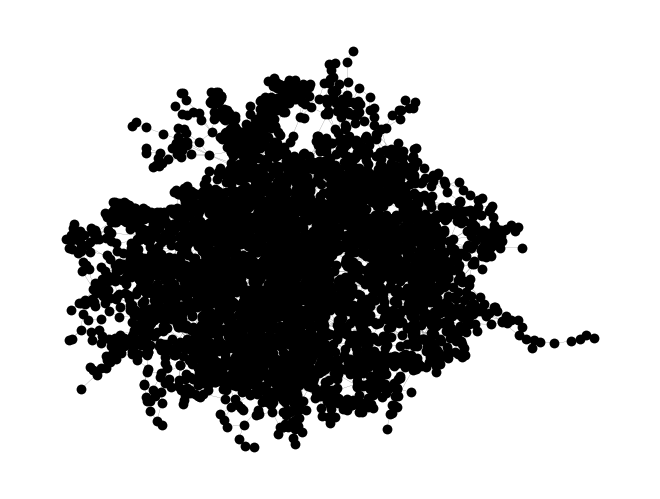

4941
6594


In [47]:
from cProfile import label
import matplotlib.pyplot as plt
import networkx as nx

gml_graph = nx.read_gml(
    "/content/power.gml", label="id"
)

options = {"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}

pos = nx.spring_layout(gml_graph, seed=1969)  # Seed for reproducible layout
nx.draw(gml_graph, pos, **options)
plt.show()



In [49]:
## print nodes and edges
print(f"Number of nodes: {gml_graph.number_of_nodes()}")
print(f"Number of edges: {gml_graph.number_of_edges()}")


Number of nodes: 4941
Number of edges: 6594


## Adding nodes and edges - 6 degrees of Kevin Bacon

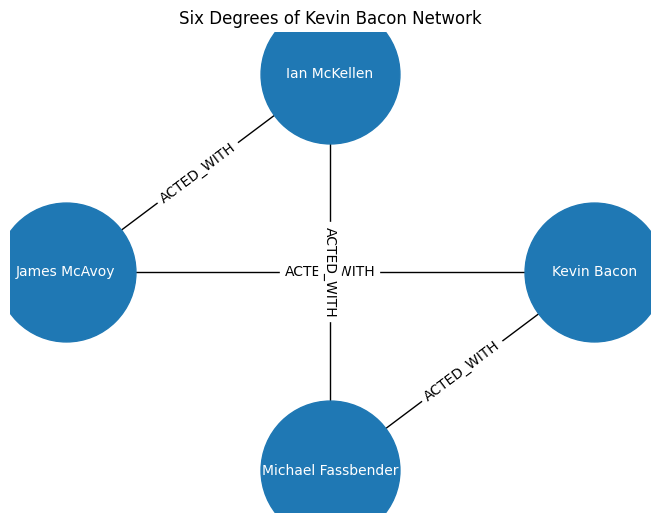

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

## init graph
g = nx.Graph()

# Adding one node to graph
g.add_node("1", label="Person", name="Kevin Bacon", age=64)

# Adding multiple nodes
g.add_nodes_from(
    [
        ("2", {"label": "Person", "name": "Ian McKellen", "age": 83}),
        ("3", {"label": "Person", "name": "James McAvoy", "age": 43}),
        ("4", {"label": "Person", "name": "Michael Fassbender", "age": 45}),
    ]
)

# Adding one edge
g.add_edge("1", "3", type="ACTED_WITH")

# Adding multiple edges
g.add_edges_from([("1", "4"), ("2", "3"), ("2", "4")], type="ACTED_WITH")

# Graph drawing
pos = nx.circular_layout(g)
nx.draw(g, pos, node_size=10000)

labels = nx.get_node_attributes(g, "name")
edge_labels = nx.get_edge_attributes(g, "type")

nx.draw_networkx_labels(g, pos, labels=labels, font_size=10, font_color="white")
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=10)

plt.title("Six Degrees of Kevin Bacon Network")
plt.show();

Summary
* We can see that Ian does not have a direct connection to Kevin but has multiple indirect connections.
* We can say Ian is 2 degrees from Kevin Bacon.